In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
import scipy
from utils.constants import letter_to_num

# output: dictionary w/ num alt locations per residue, and aa string
# input: processed file dictionary
def altloc_per_res(processed_file_dict):
    aa_str = processed_file_dict['aa']
    num_res = len(aa_str)
    loc = 0
    max_num_atoms = 14
    altloc_count = []
    
    #structure = (num_res, 6, 14) --> but all 6 should have same num altloc
    #iterating through res
    for res_idx in range(0,num_res):
        #Finding the max altloc in the first altloc --> list all atom's altloc
        altloc = max(processed_file_dict['num_altloc'][res_idx][loc])
        altloc_count.append(altloc)
    
    altloc_count = np.array(altloc_count)
    
    assert len(aa_str) == len(altloc_count)
    
    return {'aa': aa_str,
            'num_altloc': altloc_count
           }

#Turning list of lists into one large list
def flatten_to_one_list(list_of_lists):
    final_list = []
    
    for sublist in list_of_lists:
        for item in sublist:
            final_list.append(item)
    
    return final_list

def rmsd(a, b, mask):
    """
    Args:
    a: coordinates of shape (n_res, n_atoms, 3) --> need to change from (n_res, max altloc, n_atoms, 3) 
    b: coordinates of shape (n_res, n_atoms, 3)
    mask: mask of shape (n_res, n_atoms)

    Returns:
        Residue-wise RMSDs of shape (n_res,) --> save as an array?
    """
    return np.sqrt((np.square(a-b).sum(-1).sum(-1) / mask.sum(-1)))

#Masks out sidechain atoms
def backbone(a):
    """
    Args:
    a: coordinates of shape (n_res, n_atoms, 3) --> nd-array
    
    Returns:
    a: coordinates of shape (n_res, n_atoms, 3) but replaces all sidechain w/ 1
    """
    n_res, n_atoms, n_coords = np.shape(a)
    b = a.copy()
    
    #for each residue, for each sidechain atom (4-14), replace with 1
    for res in range(0,n_res):
        for atom in range(4,n_atoms):
            #print(a[res][atom])
            b[res][atom] = 1
            #print(a[res][atom])
    
    return b

#Masks out backbone atoms
def sidechain(a):
    """
    Args:
    a: coordinates of shape (n_res, n_atoms, 3)
    
    Returns:
    a: coordinates of shape (n_res, n_atoms, 3) but replaces all backbone w/ 1 ('N', 'CA', 'C', 'O')
    """
    n_res, n_atoms, n_coords = np.shape(a)
    s = a.copy()
    
    #for each residue, for each backbone atom (0-3), replace with 1
    for res in range(0,n_res):
        for atom in range(0,4):
            #print(a[res][atom])
            s[res][atom] = 1
            #print(a[res][atom])
            
    return s

#Generates an array of sidechain RMSD
# NOTE: It will output nan for heteroatoms
def sidechain_RMSD(a,dictionary,mask):
    """
    Args:
    a: coordinates of shape (n_res, n_atoms, 3) --> need to change from (n_res, max altloc, n_atoms, 3) 
    b: coordinates of shape (n_res, n_atoms, 3)
    mask: mask of shape (n_res, n_atoms)

    Returns:
        Residue-wise RMSDs of shape (n_max_altloc,n_res)
    """
    
    r,loc,atom = np.shape(dictionary['atom_mask'])
    loc = int(max(list(np.concatenate(dictionary['num_altloc']).flat))) #Max num alt loc
    a_sidechain = sidechain(a)
    RMSD_sidechain = []
    
    #For each alt loc --> store the RMSD of sidechain
    for j in range(0,loc):
        b = [] #Altloc
        RMSD_temp = []
        
        for i in range(0,r):
            res_b = []
            res_max_altloc = max(pdb_dict['num_altloc'][i].flatten())  #num altloc in a residue
            
            for k in range(0,atom):
                atom_coords_b = pdb_dict['coords'][i][j+1][k]
                atom_coords_a = pdb_dict['coords'][i][0][k]
                
                #If no altloc --> fill with coords from a 
                if max(atom_coords_b.flatten()) == 0:
                    res_b.append(atom_coords_a)
                else:
                    res_b.append(atom_coords_b)
                
            #Adding coordinates for each residue
            b.append(res_b)
                
        #Calculate RMSD - sidechains for each altloc
        b = np.array(b)
        b_sidechain = sidechain(b) #Masks backbone
        RMSD_temp = rmsd(a_sidechain, b_sidechain, mask)
        
        #Adding RMSD values for each altloc
        RMSD_sidechain.append(RMSD_temp)
    
    #RMSD_sidechain = np.array(RMSD_sidechain)
    RMSD_sidechain = np.transpose(np.array(RMSD_sidechain))
    
    assert np.shape(RMSD_sidechain) == (r,loc)
    
    #Create new empty array then fill w/ values
    max_altloc = 6
    RMSD_sidechain_full = np.zeros((r,max_altloc))
    
    for i in range(0,r):
        for al in range(0, loc):
            RMSD_sidechain_full[i][al] = RMSD_sidechain[i][al]
            
    return RMSD_sidechain_full


In [11]:
#iterate through all processed files
pkl_files = Path("/Users/christinali/Documents/Rotations/Kim Lab/Processed Files").glob("*.pkl")
pdb_list = []                  #List of all pdb ids
aa_list = []                   #list of all residues from all files
res_altloc = []                #list of all altlocs for all res
correlation = []               #correlation between b factor and num_alt_loc
b_factor = []                  #list of all b_factor values - not including 0
num_altloc = []                #list of all num altloc values - not including w/ b factor = 0
b_factor_all = []
num_altloc_all = []
coords_all = []
length_aa = []                 #Length of each protein
RMSD_stored = []               #RMSD of each atom in residue
file = 0
included_files = 0

for pkl_dict in pkl_files:
    file_path = str(pkl_dict)
    pdb_dict = {}
    file += 1
    print(file)
    print(pkl_dict.stem)
    
    
    #deserialize dictionary
    with open(file_path,"rb") as f:
        pdb_dict = pickle.load(f)
    
    f.close()
    
    #Storing b-factor and num alt loc info as one list
    b_factor_list = list(np.concatenate(pdb_dict['b_factor']).flat) 
    num_altloc_list = list(np.concatenate(pdb_dict['num_altloc']).flat)
    assert len(b_factor_list) == len(num_altloc_list)
    
    # Filtering out high b factor and files w/o altloc
    if max(b_factor_list) > 80 or max(num_altloc_list) == 0:
        print("b factor or no conformations")
        continue
        
    #Filter out by RMSD
    a = [] #First location
    mask = [] #mask
    
    r,loc,atom = np.shape(pdb_dict['atom_mask'])
    loc = int(max(list(np.concatenate(pdb_dict['num_altloc']).flat))) #Max num alt loc

    
    #Processing mask and array a
    for i in range(0,r):
        res_mask = []
        res_a = []
        
        for k in range(0,atom):
            res_mask.append(pdb_dict['atom_mask'][i][0][k])
            res_a.append(pdb_dict['coords'][i][0][k])
        
        mask.append(res_mask)
        a.append(res_a)
    
    #Change to array
    mask = np.array(mask) 
    a = np.array(a)
    a_backbone = backbone(a) #Masking sidechain atoms
    RMSD = []
    
    #For each alt loc - Checking backbone RMSD
    for j in range(0,loc):
        b = [] #Altloc
        nal = []
        
        for i in range(0,r):
            res_b = []
            res_max_altloc = max(pdb_dict['num_altloc'][i].flatten())  #num altloc in a residue
            
            for k in range(0,atom):
                atom_coords_b = pdb_dict['coords'][i][j+1][k]
                atom_coords_a = pdb_dict['coords'][i][0][k]
                
                #If no altloc --> fill with coords from a 
                if max(atom_coords_b.flatten()) == 0:
                    res_b.append(atom_coords_a)
                else:
                    res_b.append(atom_coords_b)
            
            #Checking if the coordinates are all the same for altloc > 0:
            res_coords_a = a[i]
            res_coords_b = np.array(res_b)
            same_coords = False
            
            if res_max_altloc > 0 and j < res_max_altloc: # j(index) should be 1 less than altloc #
                
                #if the coords are the same and not 0
                if sorted(res_coords_a.flatten()) == sorted(res_coords_b.flatten()) and max(res_coords_a.flatten()) != 0:
                    if res_max_altloc > 0:
                        res_max_altloc -= 1
                        print("same coords?")
                        same_coords = True
                        break

            
            if same_coords == True:
                break
                
            #Adding max altloc and coordinates for each residue
            nal.append(res_max_altloc)       
            b.append(res_b)
        
        if same_coords == True:
            RMSD = [2,2]
            break
                
        #Calculate RMSD --> if max RMSD >1 then exit for loop and go to next file --> otherwise keep going
        b = np.array(b)
        b_backbone = backbone(b) #Masks sidechains
        RMSD = rmsd(a_backbone, b_backbone, mask)

        #if max RMSD >0.5 then exit for loop
        if max(RMSD) > 0.5:
            print("RMSD backbone too high: ")
            break
    
    if max(RMSD) > 0.5:
        print("Skipped file")
        continue
    
    #Calculating sidechain RMSD + storing
    RMSD_all = sidechain_RMSD(a,pdb_dict,mask)
    
    #Remove all files w/ only backbone conformations
    if max(RMSD_all.flatten()) == 0:
        print("Alt conformations in backbone/heteroatoms only")
        continue
    
    #Remove if sidechain RMSD < 2
    check_rmsd = RMSD_all.copy()
    check_rmsd[check_rmsd == 0] = np.nan

    
    if np.nanmin(check_rmsd) < 2:
        print("sidechain RMSD less than 2")
        continue
    
    #RMSD_all has shape (n_res, 6)
    RMSD_stored.append(RMSD_all)
    
    #print(RMSD_all)
    #print(np.shape(RMSD_all))
    #print(np.shape(pdb_dict['coords']))
    #print(len(RMSD_stored))
    
    #Adding to list of all b factor/altloc
    b_factor_all.append(pdb_dict['b_factor'])
    num_altloc_all.append(pdb_dict['num_altloc'])
    coords_all.append(pdb_dict['coords'])
    
    #Getting dictionary w/ list of AA and num altloc per res
    per_res_dict = altloc_per_res(pdb_dict)
    aa_list.append(per_res_dict['aa'])
    res_altloc.append(per_res_dict['num_altloc'])

    #Removing all entries w/o b-factor value (b-factor = 0)
    ## Adding it to giant list of b factors
    max_index = len(b_factor_list)
    for i in range(0,max_index):
        if b_factor_list[i] == 0:
            continue
        else:
            b_factor.append(b_factor_list[i])
            num_altloc.append(num_altloc_list[i])
    
    assert len(b_factor) == len(num_altloc)
    assert len(b_factor_all) == len(num_altloc_all)
    
    #Storing
    pdb_list.append(pkl_dict.stem)
    length_aa.append(len(pdb_dict['aa']))
    included_files += 1  

1
5SPV
RMSD backbone too high: 
Skipped file
2
6J6D
b factor or no conformations
3
6APE
sidechain RMSD less than 2
4
3WW6
5
4PQ9
sidechain RMSD less than 2
6
1FU0
b factor or no conformations
7
5QH3
b factor or no conformations
8
2ZXJ
9
1M0K
b factor or no conformations
10
7BRP
b factor or no conformations
11
8D9A


/var/folders/80/jhzr0zpd32vcl5cw68r1572r0000gn/T/ipykernel_32069/2190970424.py:53: RuntimeWarning: invalid value encountered in divide
  return np.sqrt((np.square(a-b).sum(-1).sum(-1) / mask.sum(-1)))


sidechain RMSD less than 2
12
6CKZ
sidechain RMSD less than 2
13
5SSM
b factor or no conformations
14
8CIW
b factor or no conformations
15
5SP7
RMSD backbone too high: 
Skipped file
16
2XC4
sidechain RMSD less than 2
17
7G9Y
b factor or no conformations
18
5QHR
b factor or no conformations
19
7BR1
RMSD backbone too high: 
Skipped file
20
7BQK
b factor or no conformations
21
7P9C
b factor or no conformations
22
4GR8
sidechain RMSD less than 2
23
1QV1
sidechain RMSD less than 2
24
4B9P
sidechain RMSD less than 2
25
6ZE2
sidechain RMSD less than 2
26
4KG4
b factor or no conformations
27
3K26
sidechain RMSD less than 2
28
1SNT
sidechain RMSD less than 2
29
6VSD
b factor or no conformations
30
210D
b factor or no conformations
31
5FKS
sidechain RMSD less than 2
32
4GRY
sidechain RMSD less than 2
33
3LAZ
b factor or no conformations
34
4B91
b factor or no conformations
35
2CU9
b factor or no conformations
36
3BOI
sidechain RMSD less than 2
37
4EIF
RMSD backbone too high: 
Skipped file
38
1SM

sidechain RMSD less than 2
249
2O5H
RMSD backbone too high: 
Skipped file
250
5OC0
b factor or no conformations
251
2O62
sidechain RMSD less than 2
252
3GRG
sidechain RMSD less than 2
253
2FH7
sidechain RMSD less than 2
254
2FKM
sidechain RMSD less than 2
255
7POD
b factor or no conformations
256
1ZEM
b factor or no conformations
257
1ZF7
b factor or no conformations
258
4BOW
RMSD backbone too high: 
Skipped file
259
8SLG
b factor or no conformations
260
2DPR
b factor or no conformations
261
3EIX
sidechain RMSD less than 2
262
4K2I
b factor or no conformations
263
3KGK
b factor or no conformations
264
4K13
sidechain RMSD less than 2
265
5OCQ
sidechain RMSD less than 2
266
2O6S
b factor or no conformations
267
5AMB
b factor or no conformations
268
3GPX
269
6QTQ
b factor or no conformations
270
5H19
b factor or no conformations
271
4BMH
b factor or no conformations
272
6SL4
sidechain RMSD less than 2
273
2DRM
b factor or no conformations
274
3EKG
b factor or no conformations
275
6SON
sid

484
2ZUM
RMSD backbone too high: 
Skipped file
485
7LQD
b factor or no conformations
486
4U7V
sidechain RMSD less than 2
487
4IQM
sidechain RMSD less than 2
488
4B46
b factor or no conformations
489
3BA4
b factor or no conformations
490
6XP1
b factor or no conformations
491
3NWB
RMSD backbone too high: 
Skipped file
492
5A5Y
b factor or no conformations
493
2F37
sidechain RMSD less than 2
494
7P4D
b factor or no conformations
495
3BAU
b factor or no conformations
496
4KII
b factor or no conformations
497
5A6B
b factor or no conformations
498
5A58
sidechain RMSD less than 2
499
3NTY
sidechain RMSD less than 2
500
6XPP
b factor or no conformations
501
5X99
sidechain RMSD less than 2
502
7NH2
sidechain RMSD less than 2
503
5V4P
sidechain RMSD less than 2
504
6D4C
sidechain RMSD less than 2
505
1DAA
b factor or no conformations
506
4REH
b factor or no conformations
507
3UCG
b factor or no conformations
508
8D5U
sidechain RMSD less than 2
509
4U6E
b factor or no conformations
510
6CD4
b fac

sidechain RMSD less than 2
720
3WLJ
sidechain RMSD less than 2
721
1DUS
b factor or no conformations
722
7K42
b factor or no conformations
723
6F84
b factor or no conformations
724
4PJE
b factor or no conformations
725
1FNL
b factor or no conformations
726
5QP5
b factor or no conformations
727
8AIU
b factor or no conformations
728
3WOQ
b factor or no conformations
729
1O33
sidechain RMSD less than 2
730
8H7P
same coords?
Skipped file
731
2XXH
RMSD backbone too high: 
Skipped file
732
7K4S
RMSD backbone too high: 
Skipped file
733
4RRA
b factor or no conformations
734
3UW4
b factor or no conformations
735
7BIM
sidechain RMSD less than 2
736
3UTN
sidechain RMSD less than 2
737
2ZCW
b factor or no conformations
738
5Z6U
b factor or no conformations
739
5QPT
b factor or no conformations
740
2VTD
sidechain RMSD less than 2
741
4W8L
b factor or no conformations
742
3WN4
b factor or no conformations
743
6OGT
sidechain RMSD less than 2
744
2XZW
b factor or no conformations
745
1O2V
sidechain R

sidechain RMSD less than 2
941
1FLD
b factor or no conformations
942
5T9U
b factor or no conformations
943
7LFM
b factor or no conformations
944
7LE7
b factor or no conformations
945
5Z7F
b factor or no conformations
946
4RS3
b factor or no conformations
947
1O2A
b factor or no conformations
948
6OGC
sidechain RMSD less than 2
949
2VTS
b factor or no conformations
950
6AIP
b factor or no conformations
951
3WMY
RMSD backbone too high: 
Skipped file
952
6H74
b factor or no conformations
953
8OFU
sidechain RMSD less than 2
954
7LEV
b factor or no conformations
955
6O2H
sidechain RMSD less than 2
956
1OGJ
b factor or no conformations
957
7EMC
b factor or no conformations
958
7EN9
b factor or no conformations
959
4UVO
960
4UU5
RMSD backbone too high: 
Skipped file
961
6HAE
b factor or no conformations
962
1H4G
sidechain RMSD less than 2
963
2QRU
sidechain RMSD less than 2
964
6O1S
b factor or no conformations
965
4WM1
sidechain RMSD less than 2
966
5VWA
b factor or no conformations
967
1AI8

sidechain RMSD less than 2
1162
5MLK
b factor or no conformations
1163
4LUA
b factor or no conformations
1164
3IHQ
b factor or no conformations
1165
6QA1
b factor or no conformations
1166
3KSN
b factor or no conformations
1167
4LVZ
b factor or no conformations
1168
1ZRS
b factor or no conformations
1169
5CB9
b factor or no conformations
1170
1Q4R
RMSD backbone too high: 
Skipped file
1171
7PXZ
b factor or no conformations
1172
3IH0
b factor or no conformations
1173
1XJ6
b factor or no conformations
1174
5OTO
b factor or no conformations
1175
5OW5
b factor or no conformations
1176
1XIL
b factor or no conformations
1177
5D14
sidechain RMSD less than 2
1178
4IKC
b factor or no conformations
1179
4IH9
b factor or no conformations
1180
2CB0
b factor or no conformations
1181
5C4H
sidechain RMSD less than 2
1182
7UEC
RMSD backbone too high: 
Skipped file
1183
6ZRZ
sidechain RMSD less than 2
1184
2D2G
b factor or no conformations
1185
1V2T
b factor or no conformations
1186
6VGV
sidechain RMSD 

sidechain RMSD less than 2
1383
1ES2
b factor or no conformations
1384
6LX5
sidechain RMSD less than 2
1385
3TQU
b factor or no conformations
1386
4QLE
RMSD backbone too high: 
Skipped file
1387
5PV5
b factor or no conformations
1388
1GK6
b factor or no conformations
1389
7OYZ
b factor or no conformations
1390
7AT3
sidechain RMSD less than 2
1391
8BTJ
b factor or no conformations
1392
4O1A
b factor or no conformations
1393
1Y5H
b factor or no conformations
1394
3OG9
sidechain RMSD less than 2
1395
7VWS
b factor or no conformations
1396
3AJP
sidechain RMSD less than 2
1397
6WNY
b factor or no conformations
1398
5ENJ
b factor or no conformations
1399
5EM0
sidechain RMSD less than 2
1400
4JYS
b factor or no conformations
1401
7TO6
b factor or no conformations
1402
2BHE
b factor or no conformations
1403
7TLL
sidechain RMSD less than 2
1404
3CR5
b factor or no conformations
1405
8WL5
b factor or no conformations
1406
3AIK
b factor or no conformations
1407
6YCQ
b factor or no conformations
1

RMSD backbone too high: 
Skipped file
1596
1WCW
b factor or no conformations
1597
1YMD
b factor or no conformations
1598
4OIM
b factor or no conformations
1599
6Y8F
b factor or no conformations
1600
3HL8
sidechain RMSD less than 2
1601
2IU2
b factor or no conformations
1602
4F4S
sidechain RMSD less than 2
1603
1P0Z
sidechain RMSD less than 2
1604
6PEX
b factor or no conformations
1605
5K84
b factor or no conformations
1606
4OJV
b factor or no conformations
1607
3A1G
b factor or no conformations
1608
3FA0
sidechain RMSD less than 2
1609
4F7H
b factor or no conformations
1610
4MQI
b factor or no conformations
1611
5LK9
RMSD backbone too high: 
Skipped file
1612
7Z9H
b factor or no conformations
1613
4MR3
b factor or no conformations
1614
3QBP
sidechain RMSD less than 2
1615
4Q7R
b factor or no conformations
1616
1LUZ
b factor or no conformations
1617
7M9R
b factor or no conformations
1618
4ZQS
b factor or no conformations
1619
5UE0
b factor or no conformations
1620
5R5G
sidechain RMSD le

sidechain RMSD less than 2
1812
3ZQM
b factor or no conformations
1813
5U3V
b factor or no conformations
1814
8BZA
sidechain RMSD less than 2
1815
8G2S
RMSD backbone too high: 
Skipped file
1816
4V29
b factor or no conformations
1817
7AZ8
b factor or no conformations
1818
7AYB
b factor or no conformations
1819
1IKO
b factor or no conformations
1820
4QAU
b factor or no conformations
1821
3Q4W
b factor or no conformations
1822
3ZRV
sidechain RMSD less than 2
1823
7MOU
sidechain RMSD less than 2
1824
8BYZ
sidechain RMSD less than 2
1825
8G22
RMSD backbone too high: 
Skipped file
1826
4V2X
b factor or no conformations
1827
3VGZ
b factor or no conformations
1828
2YPC
b factor or no conformations
1829
7OW0
b factor or no conformations
1830
3Q52
b factor or no conformations
1831
6G2A
sidechain RMSD less than 2
1832
1GD9
b factor or no conformations
1833
5U2R
sidechain RMSD less than 2
1834
3ZPI
sidechain RMSD less than 2
1835
3ZS3
sidechain RMSD less than 2
1836
7MMJ
b factor or no conformati

sidechain RMSD less than 2
2033
4HYQ
b factor or no conformations
2034
4FWB
RMSD backbone too high: 
Skipped file
2035
4FT8
b factor or no conformations
2036
1PP1
sidechain RMSD less than 2
2037
7TWQ
sidechain RMSD less than 2
2038
7ZYB
b factor or no conformations
2039
5PNR
b factor or no conformations
2040
7CT1
b factor or no conformations
2041
3TI2
b factor or no conformations
2042
7CWK
b factor or no conformations
2043
7MYX
sidechain RMSD less than 2
2044
5RUM
sidechain RMSD less than 2
2045
3S9E
sidechain RMSD less than 2
2046
1EK4
b factor or no conformations
2047
1EHN
sidechain RMSD less than 2
2048
5RV7
sidechain RMSD less than 2
2049
7OBG
sidechain RMSD less than 2
2050
2YFN
sidechain RMSD less than 2
2051
5PMI
b factor or no conformations
2052
1GPJ
b factor or no conformations
2053
5PN3
b factor or no conformations
2054
4QTC
b factor or no conformations
2055
4Z2B
b factor or no conformations
2056
7MY9
b factor or no conformations
2057
4Z18
b factor or no conformations
2058
7C

2254
3SB3
sidechain RMSD less than 2
2255
1E0B
b factor or no conformations
2256
4ZJN
b factor or no conformations
2257
4ZI4
sidechain RMSD less than 2
2258
5P5E
b factor or no conformations
2259
3QZ7
b factor or no conformations
2260
7FDN
b factor or no conformations
2261
2W3J
sidechain RMSD less than 2
2262
1NUX
b factor or no conformations
2263
7O9P
b factor or no conformations
2264
7JR8
RMSD backbone too high: 
Skipped file
2265
6KHH
sidechain RMSD less than 2
2266
5NHA
sidechain RMSD less than 2
2267
7X9J
sidechain RMSD less than 2
2268
4J9Y
2269
4D7J
b factor or no conformations
2270
2EX8
b factor or no conformations
2271
4D40
b factor or no conformations
2272
6U66
same coords?
Skipped file
2273
1UC4
b factor or no conformations
2274
3C1E
2275
6U5L
b factor or no conformations
2276
5I86
b factor or no conformations
2277
1WXJ
sidechain RMSD less than 2
2278
3DAS
RMSD backbone too high: 
Skipped file
2279
4MIO
2280
6U6W
sidechain RMSD less than 2
2281
5G6D
b factor or no conformati

b factor or no conformations
2483
7ONS
b factor or no conformations
2484
1KJI
b factor or no conformations
2485
5RYY
b factor or no conformations
2486
3S5Q
sidechain RMSD less than 2
2487
6E1X
sidechain RMSD less than 2
2488
6BAN
b factor or no conformations
2489
8E3U
b factor or no conformations
2490
1B4L
b factor or no conformations
2491
7CXD
b factor or no conformations
2492
7F0V
b factor or no conformations
2493
7ON2
b factor or no conformations
2494
6NTB
b factor or no conformations
2495
2WGR
sidechain RMSD less than 2
2496
5RZB
sidechain RMSD less than 2
2497
5RY8
b factor or no conformations
2498
4CEU
sidechain RMSD less than 2
2499
5LRL
b factor or no conformations
2500
5LQ6
sidechain RMSD less than 2
2501
4MKF
b factor or no conformations
2502
3HVV
RMSD backbone too high: 
Skipped file
2503
5G4M
sidechain RMSD less than 2
2504
1WZC
b factor or no conformations
2505
7V6K
sidechain RMSD less than 2
2506
4OPY
b factor or no conformations
2507
3DCZ
sidechain RMSD less than 2
2508


sidechain RMSD less than 2
2704
5PBP
b factor or no conformations
2705
7ACM
b factor or no conformations
2706
5W2F
b factor or no conformations
2707
1KID
sidechain RMSD less than 2
2708
5RZT
b factor or no conformations
2709
1EGW
b factor or no conformations
2710
3TEQ
b factor or no conformations
2711
8E09
RMSD backbone too high: 
Skipped file
2712
1B4Z
sidechain RMSD less than 2
2713
5PB1
sidechain RMSD less than 2
2714
5PAK
sidechain RMSD less than 2
2715
8BBQ
2716
5RXK
b factor or no conformations
2717
1EEH
b factor or no conformations
2718
3TD4
b factor or no conformations
2719
5PCT
b factor or no conformations
2720
6NUP
sidechain RMSD less than 2
2721
7OLZ
sidechain RMSD less than 2
2722
2YHS
sidechain RMSD less than 2
2723
8BB0
sidechain RMSD less than 2
2724
8BAJ
sidechain RMSD less than 2
2725
3TDU
sidechain RMSD less than 2
2726
2P67
sidechain RMSD less than 2
2727
2P5M
b factor or no conformations
2728
5PC5
b factor or no conformations
2729
3CG5
b factor or no conformations
2

RMSD backbone too high: 
Skipped file
2924
2PLR
b factor or no conformations
2925
7A8M
b factor or no conformations
2926
6EIU
b factor or no conformations
2927
1LB3
sidechain RMSD less than 2
2928
8EK9
b factor or no conformations
2929
6GQ0
b factor or no conformations
2930
2POI
b factor or no conformations
2931
5P91
RMSD backbone too high: 
Skipped file
2932
3QU9
b factor or no conformations
2933
3QVC
b factor or no conformations
2934
3HZB
b factor or no conformations
2935
6PPX
b factor or no conformations
2936
7QIR
b factor or no conformations
2937
5BS1
sidechain RMSD less than 2
2938
4CIA
b factor or no conformations
2939
5BPK
sidechain RMSD less than 2
2940
6RKG
sidechain RMSD less than 2
2941
5NEG
sidechain RMSD less than 2
2942
3FT0
sidechain RMSD less than 2
2943
7QI3
sidechain RMSD less than 2
2944
3FWJ
sidechain RMSD less than 2
2945
5I5Q
2946
3HYY
2947
3M1K
sidechain RMSD less than 2
2948
4MG3
b factor or no conformations
2949
3M21
b factor or no conformations
2950
3DLU
b fac

sidechain RMSD less than 2
3152
2IWZ
sidechain RMSD less than 2
3153
6PDJ
b factor or no conformations
3154
1P1H
b factor or no conformations
3155
4F5A
b factor or no conformations
3156
7T5R
b factor or no conformations
3157
1UYZ
b factor or no conformations
3158
5K9G
b factor or no conformations
3159
6W7G
b factor or no conformations
3160
1WBE
sidechain RMSD less than 2
3161
3A04
b factor or no conformations
3162
5NQU
b factor or no conformations
3163
3FCX
3164
5LIQ
b factor or no conformations
3165
7Z8Z
b factor or no conformations
3166
1UZA
sidechain RMSD less than 2
3167
3DXG
sidechain RMSD less than 2
3168
5E4O
b factor or no conformations
3169
2EB7
b factor or no conformations
3170
5E75
sidechain RMSD less than 2
3171
7SED
b factor or no conformations
3172
3A0U
sidechain RMSD less than 2
3173
4F4E
RMSD backbone too high: 
Skipped file
3174
1P36
b factor or no conformations
3175
5LH4
same coords?
Skipped file
3176
2ECR
b factor or no conformations
3177
5K8C
sidechain RMSD less tha

sidechain RMSD less than 2
3368
3OIE
b factor or no conformations
3369
8P1D
b factor or no conformations
3370
1PE1
b factor or no conformations
3371
5GX2
b factor or no conformations
3372
4FBB
b factor or no conformations
3373
2BFX
b factor or no conformations
3374
3ADM
b factor or no conformations
3375
3AG7
sidechain RMSD less than 2
3376
2NST
b factor or no conformations
3377
2R5O
sidechain RMSD less than 2
3378
5RC7
RMSD backbone too high: 
Skipped file
3379
7D1F
b factor or no conformations
3380
8BZW
sidechain RMSD less than 2
3381
8G2E
sidechain RMSD less than 2
3382
2YP4
b factor or no conformations
3383
1IHB
b factor or no conformations
3384
3Q7Z
sidechain RMSD less than 2
3385
4QBX
sidechain RMSD less than 2
3386
6LUR
b factor or no conformations
3387
5RCV
RMSD backbone too high: 
Skipped file
3388
1KPF
b factor or no conformations
3389
3VD6
b factor or no conformations
3390
3VGL
b factor or no conformations
3391
1GEJ
b factor or no conformations
3392
4QAC
b factor or no confor

b factor or no conformations
3589
5R8A
b factor or no conformations
3590
7DJ0
sidechain RMSD less than 2
3591
4TRF
RMSD backbone too high: 
Skipped file
3592
1BU5
b factor or no conformations
3593
7FRU
b factor or no conformations
3594
1I0N
b factor or no conformations
3595
6IF6
b factor or no conformations
3596
5WP2
sidechain RMSD less than 2
3597
4XDQ
sidechain RMSD less than 2
3598
8ERM
sidechain RMSD less than 2
3599
7M45
b factor or no conformations
3600
7M7O
b factor or no conformations
3601
1I3U
b factor or no conformations
3602
7FR4
RMSD backbone too high: 
Skipped file
3603
1UV4
sidechain RMSD less than 2
3604
4H7F
b factor or no conformations
3605
2IX4
sidechain RMSD less than 2
3606
3HBD
b factor or no conformations
3607
4F9U
3608
4AJX
sidechain RMSD less than 2
3609
4ODK
b factor or no conformations
3610
7SI1
sidechain RMSD less than 2
3611
3DWH
sidechain RMSD less than 2
3612
3DT2
RMSD backbone too high: 
Skipped file
3613
7SJK
RMSD backbone too high: 
Skipped file
3614
7Z

b factor or no conformations
3811
8DX8
b factor or no conformations
3812
5S2U
sidechain RMSD less than 2
3813
7KMM
b factor or no conformations
3814
1OIW
b factor or no conformations
3815
5XTT
b factor or no conformations
3816
4WCM
sidechain RMSD less than 2
3817
3W6O
b factor or no conformations
3818
5VZG
sidechain RMSD less than 2
3819
7LKK
b factor or no conformations
3820
2ZL8
b factor or no conformations
3821
6MRA
b factor or no conformations
3822
4PEK
b factor or no conformations
3823
8F5V
b factor or no conformations
3824
1JW4
b factor or no conformations
3825
2ZLY
b factor or no conformations
3826
7LHP
sidechain RMSD less than 2
3827
3P3R
RMSD backbone too high: 
Skipped file
3828
6H9H
b factor or no conformations
3829
7NP5
b factor or no conformations
3830
6OJE
b factor or no conformations
3831
6ADV
b factor or no conformations
3832
5SDE
b factor or no conformations
3833
6VDL
3834
7R5T
sidechain RMSD less than 2
3835
3LUI
b factor or no conformations
3836
5M9A
3837
3LV3
sidech

sidechain RMSD less than 2
4045
4EP3
RMSD backbone too high: 
Skipped file
4046
4ESI
b factor or no conformations
4047
2CLL
b factor or no conformations
4048
6TR5
sidechain RMSD less than 2
4049
7UHE
b factor or no conformations
4050
3I3G
sidechain RMSD less than 2
4051
3NCQ
sidechain RMSD less than 2
4052
6VIK
b factor or no conformations
4053
7R8S
b factor or no conformations
4054
2J2I
sidechain RMSD less than 2
4055
5JGK
sidechain RMSD less than 2
4056
2J13
sidechain RMSD less than 2
4057
5M4F
sidechain RMSD less than 2
4058
4GKM
sidechain RMSD less than 2
4059
2JGB
b factor or no conformations
4060
6STR
b factor or no conformations
4061
7RMX
b factor or no conformations
4062
4NCX
b factor or no conformations
4063
3N6Z
RMSD backbone too high: 
Skipped file
4064
5OZR
b factor or no conformations
4065
6QOM
b factor or no conformations
4066
2FQ4
b factor or no conformations
4067
5MB7
RMSD backbone too high: 
Skipped file
4068
7RNC
b factor or no conformations
4069
7RM9
RMSD backbone to

4268
5J32
sidechain RMSD less than 2
4269
5J0H
b factor or no conformations
4270
4LY5
b factor or no conformations
4271
5CMV
b factor or no conformations
4272
6QME
b factor or no conformations
4273
1VHQ
sidechain RMSD less than 2
4274
5AUR
sidechain RMSD less than 2
4275
4NBK
b factor or no conformations
4276
4NA1
b factor or no conformations
4277
5CM7
sidechain RMSD less than 2
4278
4I1F
sidechain RMSD less than 2
4279
5TNW
sidechain RMSD less than 2
4280
8DW7
b factor or no conformations
4281
7L25
b factor or no conformations
4282
1H5U
b factor or no conformations
4283
3PI7
b factor or no conformations
4284
4WLB
b factor or no conformations
4285
1AK1
b factor or no conformations
4286
4UTF
b factor or no conformations
4287
6O0A
b factor or no conformations
4288
7EOJ
b factor or no conformations
4289
3RRI
sidechain RMSD less than 2
4290
7KAY
b factor or no conformations
4291
6JXS
b factor or no conformations
4292
5QPU
b factor or no conformations
4293
6F8T
sidechain RMSD less than 2
42

b factor or no conformations
4485
1TDG
sidechain RMSD less than 2
4486
3B66
b factor or no conformations
4487
3B5L
b factor or no conformations
4488
4BC4
b factor or no conformations
4489
6T1E
b factor or no conformations
4490
284D
b factor or no conformations
4491
3IP7
sidechain RMSD less than 2
4492
2A78
b factor or no conformations
4493
3KKI
b factor or no conformations
4494
6SAS
RMSD backbone too high: 
Skipped file
4495
7RXY
b factor or no conformations
4496
3B6W
sidechain RMSD less than 2
4497
3L8D
b factor or no conformations
4498
1ZJ5
b factor or no conformations
4499
5MW6
b factor or no conformations
4500
2FGO
RMSD backbone too high: 
Skipped file
4501
6QY6
b factor or no conformations
4502
5F2M
b factor or no conformations
4503
6QZL
b factor or no conformations
4504
2FD5
b factor or no conformations
4505
4UAG
sidechain RMSD less than 2
4506
6C36
b factor or no conformations
4507
6C0L
b factor or no conformations
4508
3RD2
sidechain RMSD less than 2
4509
1OS8
sidechain RMSD le

sidechain RMSD less than 2
4717
3UNA
sidechain RMSD less than 2
4718
6CI2
b factor or no conformations
4719
5SQD
RMSD backbone too high: 
Skipped file
4720
4RK4
b factor or no conformations
4721
4RHN
b factor or no conformations
4722
1DLG
sidechain RMSD less than 2
4723
7NFN
sidechain RMSD less than 2
4724
2XBG
sidechain RMSD less than 2
4725
5X7E
b factor or no conformations
4726
6AQW
b factor or no conformations
4727
4PS0
sidechain RMSD less than 2
4728
1FW9
b factor or no conformations
4729
7G8K
b factor or no conformations
4730
3UMZ
b factor or no conformations
4731
6CIS
b factor or no conformations
4732
1M2B
b factor or no conformations
4733
3WVE
b factor or no conformations
4734
6ARL
b factor or no conformations
4735
6AQ6
b factor or no conformations
4736
5V97
b factor or no conformations
4737
8AQE
b factor or no conformations
4738
6CH6
sidechain RMSD less than 2
4739
4RJ0
b factor or no conformations
4740
5V8R
b factor or no conformations
4741
6APS
b factor or no conformations
4

sidechain RMSD less than 2
4933
5QH2
b factor or no conformations
4934
1FVK
sidechain RMSD less than 2
4935
7G99
b factor or no conformations
4936
4PQ8
b factor or no conformations
4937
3WW7
b factor or no conformations
4938
2VMG
b factor or no conformations
4939
5SPW
RMSD backbone too high: 
Skipped file
4940
6J6E
sidechain RMSD less than 2
4941
7GL2
b factor or no conformations
4942
7KZD
b factor or no conformations
4943
5VMN
b factor or no conformations
4944
2V8L
b factor or no conformations
4945
5VN4
RMSD backbone too high: 
Skipped file
4946
8HYG
sidechain RMSD less than 2
4947
2QHZ
sidechain RMSD less than 2
4948
7GLS
b factor or no conformations
4949
6HX0
b factor or no conformations
4950
5TV0
b factor or no conformations
4951
1J5W
b factor or no conformations
4952
7N1M
b factor or no conformations
4953
4YYL
b factor or no conformations
4954
4YZ6
b factor or no conformations
4955
7N27
b factor or no conformations
4956
5VNU
b factor or no conformations
4957
3EJU
sidechain RMSD le

sidechain RMSD less than 2
5150
3BOJ
b factor or no conformations
5151
7UQ3
sidechain RMSD less than 2
5152
6ZEP
b factor or no conformations
5153
5FKP
b factor or no conformations
5154
4GRZ
sidechain RMSD less than 2
5155
5O6N
sidechain RMSD less than 2
5156
2OCL
b factor or no conformations
5157
4EIE
sidechain RMSD less than 2
5158
1SML
b factor or no conformations
5159
5DPO
sidechain RMSD less than 2
5160
4RKW
b factor or no conformations
5161
1JB7
b factor or no conformations
5162
2VOM
b factor or no conformations
5163
6AQ4
b factor or no conformations
5164
6ARN
sidechain RMSD less than 2
5165
5QJ8
b factor or no conformations
5166
5QIB
same coords?
Skipped file
5167
6MGB
b factor or no conformations
5168
6MD8
sidechain RMSD less than 2
5169
4U8Z
b factor or no conformations
5170
1JBV
b factor or no conformations
5171
6J7T
b factor or no conformations
5172
4RK6
b factor or no conformations
5173
5SQF
RMSD backbone too high: 
Skipped file
5174
2VLV
sidechain RMSD less than 2
5175
7NF

b factor or no conformations
5363
8C19
sidechain RMSD less than 2
5364
3RDQ
sidechain RMSD less than 2
5365
7KWA
b factor or no conformations
5366
1J83
b factor or no conformations
5367
8HTB
b factor or no conformations
5368
4YWR
b factor or no conformations
5369
2V63
sidechain RMSD less than 2
5370
5VC1
b factor or no conformations
5371
2V5I
RMSD backbone too high: 
Skipped file
5372
7GA7
sidechain RMSD less than 2
5373
5Q3F
b factor or no conformations
5374
7GBM
5375
6HUT
sidechain RMSD less than 2
5376
1CFW
b factor or no conformations
5377
6C3U
b factor or no conformations
5378
1J8R
b factor or no conformations
5379
4R12
b factor or no conformations
5380
7EZI
sidechain RMSD less than 2
5381
4R2H
b factor or no conformations
5382
4WZZ
sidechain RMSD less than 2
5383
5VCP
b factor or no conformations
5384
5XN9
b factor or no conformations
5385
7GAV
b factor or no conformations
5386
3U4G
b factor or no conformations
5387
1J97
b factor or no conformations
5388
3REU
b factor or no confo

b factor or no conformations
5584
4WX3
sidechain RMSD less than 2
5585
4YUZ
b factor or no conformations
5586
1OQS
b factor or no conformations
5587
6JLC
b factor or no conformations
5588
8C0K
Alt conformations in backbone/heteroatoms only
5589
6DBP
b factor or no conformations
5590
8C31
b factor or no conformations
5591
5ZT5
b factor or no conformations
5592
5Q24
b factor or no conformations
5593
6FZ5
b factor or no conformations
5594
2QG6
b factor or no conformations
5595
5Q1N
sidechain RMSD less than 2
5596
8HUQ
b factor or no conformations
5597
2X93
sidechain RMSD less than 2
5598
4YVA
b factor or no conformations
5599
1D4I
b factor or no conformations
5600
6DAK
b factor or no conformations
5601
6JOX
b factor or no conformations
5602
1CGD
b factor or no conformations
5603
3U55
sidechain RMSD less than 2
5604
3U6O
b factor or no conformations
5605
5Q2U
b factor or no conformations
5606
6HTG
b factor or no conformations
5607
4REK
RMSD backbone too high: 
Skipped file
5608
2XL8
sidech

sidechain RMSD less than 2
5797
7PTM
sidechain RMSD less than 2
5798
6QMG
b factor or no conformations
5799
1VKH
sidechain RMSD less than 2
5800
5AVK
b factor or no conformations
5801
8QLQ
b factor or no conformations
5802
5OXX
b factor or no conformations
5803
2JF2
sidechain RMSD less than 2
5804
6SVX
RMSD backbone too high: 
Skipped file
5805
7ROR
b factor or no conformations
5806
3RPC
b factor or no conformations
5807
7KCS
sidechain RMSD less than 2
5808
5XZJ
b factor or no conformations
5809
1OD3
sidechain RMSD less than 2
5810
6O2K
sidechain RMSD less than 2
5811
6O11
b factor or no conformations
5812
1OGI
b factor or no conformations
5813
4WMS
sidechain RMSD less than 2
5814
6HAF
sidechain RMSD less than 2
5815
1H4D
b factor or no conformations
5816
5TOF
RMSD backbone too high: 
Skipped file
5817
4UU6
b factor or no conformations
5818
6JYB
b factor or no conformations
5819
6JZ8
b factor or no conformations
5820
6DWQ
sidechain RMSD less than 2
5821
3W80
b factor or no conformation

sidechain RMSD less than 2
6030
8ADQ
b factor or no conformations
6031
4PGA
b factor or no conformations
6032
7BGR
sidechain RMSD less than 2
6033
5T6Y
b factor or no conformations
6034
3UZQ
b factor or no conformations
6035
6MS1
b factor or no conformations
6036
6MPK
b factor or no conformations
6037
8F5C
b factor or no conformations
6038
3WCQ
b factor or no conformations
6039
1A2Z
sidechain RMSD less than 2
6040
7NPA
b factor or no conformations
6041
6OJ1
b factor or no conformations
6042
2XTH
b factor or no conformations
6043
8AFN
b factor or no conformations
6044
6F4U
sidechain RMSD less than 2
6045
8AE4
b factor or no conformations
6046
5T4F
b factor or no conformations
6047
2ZOW
b factor or no conformations
6048
1DYS
sidechain RMSD less than 2
6049
2XWS
sidechain RMSD less than 2
6050
7NSZ
sidechain RMSD less than 2
6051
6AG9
b factor or no conformations
6052
4W5H
b factor or no conformations
6053
1FA6
b factor or no conformations
6054
3P3G
b factor or no conformations
6055
2ZO6


RMSD backbone too high: 
Skipped file
6254
2DDT
b factor or no conformations
6255
3KSM
sidechain RMSD less than 2
6256
1XJT
b factor or no conformations
6257
5OWW
sidechain RMSD less than 2
6258
2HQ9
sidechain RMSD less than 2
6259
3IKI
b factor or no conformations
6260
2HRC
sidechain RMSD less than 2
6261
6QAS
b factor or no conformations
6262
7PXY
b factor or no conformations
6263
4G0X
sidechain RMSD less than 2
6264
2C4B
b factor or no conformations
6265
7U0K
b factor or no conformations
6266
2C78
b factor or no conformations
6267
249L
b factor or no conformations
6268
6SZL
sidechain RMSD less than 2
6269
5OTL
b factor or no conformations
6270
4NMF
b factor or no conformations
6271
4AIA
sidechain RMSD less than 2
6272
1WMH
b factor or no conformations
6273
1WN2
sidechain RMSD less than 2
6274
6Y6Y
b factor or no conformations
6275
5K6J
sidechain RMSD less than 2
6276
6RPX
b factor or no conformations
6277
7SIR
b factor or no conformations
6278
7Z76
b factor or no conformations
6279


sidechain RMSD less than 2
6474
1GHX
sidechain RMSD less than 2
6475
6I03
sidechain RMSD less than 2
6476
4X1O
b factor or no conformations
6477
7OYN
sidechain RMSD less than 2
6478
1ESG
b factor or no conformations
6479
7MB0
b factor or no conformations
6480
7MAJ
b factor or no conformations
6481
4QOJ
b factor or no conformations
6482
7ATF
sidechain RMSD less than 2
6483
3VIE
sidechain RMSD less than 2
6484
8I1D
RMSD backbone too high: 
Skipped file
6485
3TPE
b factor or no conformations
6486
6I17
sidechain RMSD less than 2
6487
4QMU
sidechain RMSD less than 2
6488
3VKZ
sidechain RMSD less than 2
6489
7OXJ
b factor or no conformations
6490
5PWD
sidechain RMSD less than 2
6491
4X3P
sidechain RMSD less than 2
6492
1N7Y
b factor or no conformations
6493
7AV8
b factor or no conformations
6494
3VHA
b factor or no conformations
6495
2WQK
RMSD backbone too high: 
Skipped file
6496
7AUB
b factor or no conformations
6497
4O00
sidechain RMSD less than 2
6498
7XX1
b factor or no conformations
64

b factor or no conformations
6700
5E4M
b factor or no conformations
6701
3A0W
sidechain RMSD less than 2
6702
8PFE
sidechain RMSD less than 2
6703
4OKF
sidechain RMSD less than 2
6704
3HMI
sidechain RMSD less than 2
6705
3HN3
sidechain RMSD less than 2
6706
1P2Q
sidechain RMSD less than 2
6707
4F6X
b factor or no conformations
6708
2B2B
b factor or no conformations
6709
2B18
sidechain RMSD less than 2
6710
4MPY
b factor or no conformations
6711
7Z8X
6712
3JUM
sidechain RMSD less than 2
6713
1YLT
RMSD backbone too high: 
Skipped file
6714
4AE4
b factor or no conformations
6715
6PG2
b factor or no conformations
6716
2GYK
sidechain RMSD less than 2
6717
1P1J
b factor or no conformations
6718
1P20
b factor or no conformations
6719
2GZ1
b factor or no conformations
6720
4F69
b factor or no conformations
6721
6PDH
b factor or no conformations
6722
2IWX
RMSD backbone too high: 
Skipped file
6723
4MP8
b factor or no conformations
6724
5LJH
b factor or no conformations
6725
4MSB
b factor or no 

6916
3M23
b factor or no conformations
6917
6RKE
b factor or no conformations
6918
2EVF
b factor or no conformations
6919
5NEE
sidechain RMSD less than 2
6920
8PR6
sidechain RMSD less than 2
6921
2GMY
b factor or no conformations
6922
5I52
sidechain RMSD less than 2
6923
2ICJ
b factor or no conformations
6924
3M2R
RMSD backbone too high: 
Skipped file
6925
4MGP
sidechain RMSD less than 2
6926
4CIC
b factor or no conformations
6927
1UMJ
b factor or no conformations
6928
6RIZ
b factor or no conformations
6929
3DMS
sidechain RMSD less than 2
6930
7SPP
b factor or no conformations
6931
4J58
sidechain RMSD less than 2
6932
1WTJ
b factor or no conformations
6933
3FVL
b factor or no conformations
6934
5I4W
sidechain RMSD less than 2
6935
3M0M
b factor or no conformations
6936
4MF5
b factor or no conformations
6937
4MEO
b factor or no conformations
6938
3M37
b factor or no conformations
6939
5BRV
sidechain RMSD less than 2
6940
2EWB
sidechain RMSD less than 2
6941
3DNH
sidechain RMSD less than

RMSD backbone too high: 
Skipped file
7141
7ZX3
b factor or no conformations
7142
5PLY
b factor or no conformations
7143
1GQZ
b factor or no conformations
7144
4QUS
b factor or no conformations
7145
6BO0
RMSD backbone too high: 
Skipped file
7146
1B9H
b factor or no conformations
7147
3THC
sidechain RMSD less than 2
7148
3ZFP
b factor or no conformations
7149
6K1T
b factor or no conformations
7150
5RWF
b factor or no conformations
7151
5Y1G
sidechain RMSD less than 2
7152
4QVH
b factor or no conformations
7153
5PL8
b factor or no conformations
7154
5POB
b factor or no conformations
7155
3ZEK
b factor or no conformations
7156
4Z0I
sidechain RMSD less than 2
7157
6BOQ
b factor or no conformations
7158
3S8U
b factor or no conformations
7159
3VPG
b factor or no conformations
7160
6LL3
b factor or no conformations
7161
5PAI
sidechain RMSD less than 2
7162
4QXC
sidechain RMSD less than 2
7163
2P4K
b factor or no conformations
7164
5PB3
sidechain RMSD less than 2
7165
7ACO
b factor or no conf

b factor or no conformations
7365
5G4O
sidechain RMSD less than 2
7366
5NKN
b factor or no conformations
7367
1YU7
b factor or no conformations
7368
4ORD
7369
1YVM
b factor or no conformations
7370
5NH4
sidechain RMSD less than 2
7371
2EXM
b factor or no conformations
7372
6REN
sidechain RMSD less than 2
7373
3DAG
sidechain RMSD less than 2
7374
4CGH
b factor or no conformations
7375
1UCA
b factor or no conformations
7376
3C2J
b factor or no conformations
7377
5I8C
b factor or no conformations
7378
2IMA
b factor or no conformations
7379
5NHU
b factor or no conformations
7380
1R3W
RMSD backbone too high: 
Skipped file
7381
3C1Q
sidechain RMSD less than 2
7382
5LP0
sidechain RMSD less than 2
7383
2INZ
b factor or no conformations
7384
3FZ9
b factor or no conformations
7385
3T1K
b factor or no conformations
7386
4ZJZ
sidechain RMSD less than 2
7387
6IP9
sidechain RMSD less than 2
7388
7FDZ
b factor or no conformations
7389
5P5Q
b factor or no conformations
7390
3QYY
b factor or no conform

RMSD backbone too high: 
Skipped file
7590
5P4T
b factor or no conformations
7591
1LOV
b factor or no conformations
7592
5LPG
b factor or no conformations
7593
5I8U
b factor or no conformations
7594
3FZN
b factor or no conformations
7595
1WXH
b factor or no conformations
7596
5NKX
b factor or no conformations
7597
4ORR
sidechain RMSD less than 2
7598
3DAQ
sidechain RMSD less than 2
7599
7QDV
b factor or no conformations
7600
7X9H
b factor or no conformations
7601
5NK9
b factor or no conformations
7602
4OQI
b factor or no conformations
7603
5NHC
sidechain RMSD less than 2
7604
3DA0
sidechain RMSD less than 2
7605
1NUZ
b factor or no conformations
7606
7O9R
sidechain RMSD less than 2
7607
5YHY
b factor or no conformations
7608
2W3H
b factor or no conformations
7609
8B4B
b factor or no conformations
7610
8B78
b factor or no conformations
7611
8ED5
b factor or no conformations
7612
5P5G
b factor or no conformations
7613
6ISU
b factor or no conformations
7614
7A4Z
b factor or no conformatio

sidechain RMSD less than 2
7806
5N0X
b factor or no conformations
7807
3AQ9
b factor or no conformations
7808
4DOS
b factor or no conformations
7809
5KXJ
b factor or no conformations
7810
6UNN
sidechain RMSD less than 2
7811
334D
b factor or no conformations
7812
4M1V
b factor or no conformations
7813
2I66
b factor or no conformations
7814
4FWW
b factor or no conformations
7815
6YX8
b factor or no conformations
7816
5N3C
b factor or no conformations
7817
7XA2
b factor or no conformations
7818
4DO2
sidechain RMSD less than 2
7819
3D9J
sidechain RMSD less than 2
7820
5EUB
sidechain RMSD less than 2
7821
4DLH
b factor or no conformations
7822
7ALA
b factor or no conformations
7823
2WHH
sidechain RMSD less than 2
7824
5RUX
sidechain RMSD less than 2
7825
5PNG
b factor or no conformations
7826
4QT7
b factor or no conformations
7827
6NXC
b factor or no conformations
7828
5RU9
sidechain RMSD less than 2
7829
5RVC
sidechain RMSD less than 2
7830
6K0Q
sidechain RMSD less than 2
7831
3TIF
b fact

b factor or no conformations
8031
8BY9
b factor or no conformations
8032
6NNY
b factor or no conformations
8033
1GFE
b factor or no conformations
8034
3Q44
b factor or no conformations
8035
3Q7N
b factor or no conformations
8036
5U3T
b factor or no conformations
8037
3ZQO
b factor or no conformations
8038
4FBV
sidechain RMSD less than 2
8039
3F7T
b factor or no conformations
8040
2BE6
sidechain RMSD less than 2
8041
5B3N
b factor or no conformations
8042
2BFL
b factor or no conformations
8043
7S22
b factor or no conformations
8044
1W5R
b factor or no conformations
8045
6YNC
sidechain RMSD less than 2
8046
3OJJ
sidechain RMSD less than 2
8047
6P0F
b factor or no conformations
8048
4FB7
sidechain RMSD less than 2
8049
5GXG
b factor or no conformations
8050
3F75
sidechain RMSD less than 2
8051
5IVT
b factor or no conformations
8052
7ZOM
b factor or no conformations
8053
7ZL7
b factor or no conformations
8054
2BEW
sidechain RMSD less than 2
8055
5B0U
b factor or no conformations
8056
6UXT


RMSD backbone too high: 
Skipped file
8243
5LHA
b factor or no conformations
8244
7Z9J
b factor or no conformations
8245
4MQK
b factor or no conformations
8246
5K86
b factor or no conformations
8247
3A1E
b factor or no conformations
8248
4OJT
b factor or no conformations
8249
3FAS
sidechain RMSD less than 2
8250
2IVJ
sidechain RMSD less than 2
8251
2B0K
b factor or no conformations
8252
1UXJ
sidechain RMSD less than 2
8253
7T4B
b factor or no conformations
8254
7SD5
b factor or no conformations
8255
3DZL
sidechain RMSD less than 2
8256
5NPE
b factor or no conformations
8257
4OJ5
b factor or no conformations
8258
6Y8D
sidechain RMSD less than 2
8259
1WCU
sidechain RMSD less than 2
8260
4F54
b factor or no conformations
8261
6PGE
sidechain RMSD less than 2
8262
3FCL
sidechain RMSD less than 2
8263
2GZF
b factor or no conformations
8264
4MPO
b factor or no conformations
8265
5LIE
sidechain RMSD less than 2
8266
2EAY
b factor or no conformations
8267
3DXS
sidechain RMSD less than 2
8268
5K

sidechain RMSD less than 2
8461
2WSU
b factor or no conformations
8462
4QLP
RMSD backbone too high: 
Skipped file
8463
1GHY
b factor or no conformations
8464
5PUZ
sidechain RMSD less than 2
8465
1IE0
b factor or no conformations
8466
6I3H
b factor or no conformations
8467
7CO9
b factor or no conformations
8468
4FLJ
RMSD backbone too high: 
Skipped file
8469
1PK9
b factor or no conformations
8470
4HBY
b factor or no conformations
8471
5L3A
b factor or no conformations
8472
2BHP
RMSD backbone too high: 
Skipped file
8473
4DWU
RMSD backbone too high: 
Skipped file
8474
4JYF
sidechain RMSD less than 2
8475
4O1T
b factor or no conformations
8476
3ODV
sidechain RMSD less than 2
8477
6WM6
b factor or no conformations
8478
7VWF
b factor or no conformations
8479
3AJE
sidechain RMSD less than 2
8480
5IXH
b factor or no conformations
8481
4HB8
sidechain RMSD less than 2
8482
4FOQ
b factor or no conformations
8483
1PKX
b factor or no conformations
8484
7TL8
b factor or no conformations
8485
7ZAQ
s

sidechain RMSD less than 2
8683
7YPM
b factor or no conformations
8684
2AZW
b factor or no conformations
8685
1V2V
b factor or no conformations
8686
6Q4Y
b factor or no conformations
8687
4GER
sidechain RMSD less than 2
8688
5HQ1
sidechain RMSD less than 2
8689
6ZRX
RMSD backbone too high: 
Skipped file
8690
2CB2
sidechain RMSD less than 2
8691
4NMG
b factor or no conformations
8692
5OTM
sidechain RMSD less than 2
8693
1XJ4
b factor or no conformations
8694
6SZM
b factor or no conformations
8695
5D16
b factor or no conformations
8696
2C79
sidechain RMSD less than 2
8697
4LVX
b factor or no conformations
8698
2HRB
sidechain RMSD less than 2
8699
3IKH
b factor or no conformations
8700
2HQ8
b factor or no conformations
8701
4G0Y
b factor or no conformations
8702
7PXX
sidechain RMSD less than 2
8703
6QAR
sidechain RMSD less than 2
8704
1XJU
b factor or no conformations
8705
6SYV
RMSD backbone too high: 
Skipped file
8706
2JJF
b factor or no conformations
8707
4LUC
sidechain RMSD less than 

sidechain RMSD less than 2
8903
5OVE
b factor or no conformations
8904
4NL5
b factor or no conformations
8905
1XKF
b factor or no conformations
8906
2HPJ
b factor or no conformations
8907
2C6K
b factor or no conformations
8908
2JHN
sidechain RMSD less than 2
8909
1VE4
b factor or no conformations
8910
4G1J
sidechain RMSD less than 2
8911
3GG2
sidechain RMSD less than 2
8912
7U1Y
b factor or no conformations
8913
5MNA
sidechain RMSD less than 2
8914
4LWK
sidechain RMSD less than 2
8915
6HM2
b factor or no conformations
8916
1H80
sidechain RMSD less than 2
8917
3PDR
b factor or no conformations
8918
7B29
b factor or no conformations
8919
4UYB
b factor or no conformations
8920
5TC2
b factor or no conformations
8921
6JUW
b factor or no conformations
8922
5S3E
sidechain RMSD less than 2
8923
7EA4
sidechain RMSD less than 2
8924
8FB7
b factor or no conformations
8925
8FAM
b factor or no conformations
8926
4YO4
sidechain RMSD less than 2
8927
3PGI
b factor or no conformations
8928
4P11
b fact

sidechain RMSD less than 2
9124
3NCR
b factor or no conformations
9125
4N6P
b factor or no conformations
9126
5FRD
b factor or no conformations
9127
1QOG
b factor or no conformations
9128
5M4E
b factor or no conformations
9129
2ZCU
b factor or no conformations
9130
7BIO
b factor or no conformations
9131
5QPV
b factor or no conformations
9132
6F8W
sidechain RMSD less than 2
9133
1O0K
b factor or no conformations
9134
4Y4B
RMSD backbone too high: 
Skipped file
9135
2XXJ
b factor or no conformations
9136
1O31
sidechain RMSD less than 2
9137
6AKZ
b factor or no conformations
9138
4RRC
b factor or no conformations
9139
5SH3
b factor or no conformations
9140
1DVJ
sidechain RMSD less than 2
9141
7K4Q
RMSD backbone too high: 
Skipped file
9142
1JXY
sidechain RMSD less than 2
9143
7BJT
sidechain RMSD less than 2
9144
5Z66
sidechain RMSD less than 2
9145
1FM4
b factor or no conformations
9146
5QP7
b factor or no conformations
9147
6F86
b factor or no conformations
9148
3WLH
sidechain RMSD less t

9344
2CZ4
b factor or no conformations
9345
1T25
b factor or no conformations
9346
6TG7
b factor or no conformations
9347
7P5U
b factor or no conformations
9348
5HJM
b factor or no conformations
9349
2ZWG
sidechain RMSD less than 2
9350
7LSN
b factor or no conformations
9351
6CDW
b factor or no conformations
9352
8D6L
sidechain RMSD less than 2
9353
1C1U
b factor or no conformations
9354
2VBK
RMSD backbone too high: 
Skipped file
9355
3R3S
RMSD backbone too high: 
Skipped file
9356
1DBX
b factor or no conformations
9357
8D5W
sidechain RMSD less than 2
9358
3UCE
b factor or no conformations
9359
7LPU
RMSD backbone too high: 
Skipped file
9360
1HW5
b factor or no conformations
9361
5V4R
b factor or no conformations
9362
2VAP
b factor or no conformations
9363
2XOC
b factor or no conformations
9364
4REJ
b factor or no conformations
9365
3R32
b factor or no conformations
9366
6D4A
sidechain RMSD less than 2
9367
1C0Q
b factor or no conformations
9368
4U4X
b factor or no conformations
9369
3

sidechain RMSD less than 2
9568
2V62
b factor or no conformations
9569
8FZP
b factor or no conformations
9570
7EYS
b factor or no conformations
9571
6JNJ
sidechain RMSD less than 2
9572
5OM9
b factor or no conformations
9573
3EDJ
sidechain RMSD less than 2
9574
4E1H
sidechain RMSD less than 2
9575
1S5A
b factor or no conformations
9576
3KJY
b factor or no conformations
9577
3B7G
sidechain RMSD less than 2
9578
1TE6
b factor or no conformations
9579
6T04
sidechain RMSD less than 2
9580
4BBE
b factor or no conformations
9581
2HK6
sidechain RMSD less than 2
9582
5ACK
RMSD backbone too high: 
Skipped file
9583
2A53
sidechain RMSD less than 2
9584
4NTR
b factor or no conformations
9585
1S6Z
b factor or no conformations
9586
8SBN
sidechain RMSD less than 2
9587
7PB7
b factor or no conformations
9588
5F0F
b factor or no conformations
9589
3KD3
sidechain RMSD less than 2
9590
4K2K
sidechain RMSD less than 2
9591
6SMS
b factor or no conformations
9592
3EIZ
9593
7RTY
b factor or no conformations

sidechain RMSD less than 2
9787
1ZEX
b factor or no conformations
9788
5CU2
b factor or no conformations
9789
5CVH
b factor or no conformations
9790
3GRR
b factor or no conformations
9791
7POQ
b factor or no conformations
9792
2HF1
b factor or no conformations
9793
2HEK
b factor or no conformations
9794
1SMM
b factor or no conformations
9795
4EID
sidechain RMSD less than 2
9796
5O55
b factor or no conformations
9797
5O6O
b factor or no conformations
9798
5HEB
b factor or no conformations
9799
5FKQ
sidechain RMSD less than 2
9800
3BOK
b factor or no conformations
9801
7URH
sidechain RMSD less than 2
9802
3LAX
sidechain RMSD less than 2
9803
6ZEQ
b factor or no conformations
9804
1Z0S
b factor or no conformations
9805
5DSU
b factor or no conformations
9806
4KDL
b factor or no conformations
9807
4KG6
b factor or no conformations
9808
5O5T
b factor or no conformations
9809
5FHJ
b factor or no conformations
9810
7P9A
b factor or no conformations
9811
5HFY
sidechain RMSD less than 2
9812
6ZE

b factor or no conformations
10004
5HD4
b factor or no conformations
10005
5HGN
b factor or no conformations
10006
6TIN
b factor or no conformations
10007
4B8E
sidechain RMSD less than 2
10008
6TJ4
b factor or no conformations
10009
3LCT
b factor or no conformations
10010
3K2F
b factor or no conformations
10011
4KGD
b factor or no conformations
10012
2AMM
same coords?
Skipped file
10013
7WID
sidechain RMSD less than 2
10014
7YGW
b factor or no conformations
10015
5FH8
sidechain RMSD less than 2
10016
7P93
b factor or no conformations
10017
5FKB
10018
3BOX
b factor or no conformations
10019
6ZF8
b factor or no conformations
10020
3LB1
sidechain RMSD less than 2
10021
1SNE
10022
5DSF
b factor or no conformations
10023
4EI6
sidechain RMSD less than 2
10024
7YDL
b factor or no conformations
10025
2ANV
b factor or no conformations
10026
7P9R
b factor or no conformations
10027
2H3H
sidechain RMSD less than 2
10028
4B9A
b factor or no conformations
10029
2CV3
b factor or no conformations
1003

sidechain RMSD less than 2
10229
3BOO
b factor or no conformations
10230
3KGZ
sidechain RMSD less than 2
10231
7RW0
b factor or no conformations
10232
3EJ3
sidechain RMSD less than 2
10233
2DPC
b factor or no conformations
10234
1VPP
b factor or no conformations
10235
4NZJ
b factor or no conformations
10236
7Y11
b factor or no conformations
10237
2O58
sidechain RMSD less than 2
10238
2HEO
b factor or no conformations
10239
5H0M
b factor or no conformations
10240
3GRV
b factor or no conformations
10241
5CU6
b factor or no conformations
10242
4LAU
b factor or no conformations
10243
2DSX
sidechain RMSD less than 2
10244
7RWQ
same coords?
Skipped file
10245
3EJR
sidechain RMSD less than 2
10246
3KDA
sidechain RMSD less than 2
10247
4K29
b factor or no conformations
10248
4NYQ
b factor or no conformations
10249
5AM2
b factor or no conformations
10250
5H3V
sidechain RMSD less than 2
10251
2HFT
sidechain RMSD less than 2
10252
1ZFG
b factor or no conformations
10253
3L46
sidechain RMSD less t

b factor or no conformations
10449
5CXP
sidechain RMSD less than 2
10450
1TES
b factor or no conformations
10451
4BAZ
b factor or no conformations
10452
3EG4
sidechain RMSD less than 2
10453
1S5E
b factor or no conformations
10454
3EDN
sidechain RMSD less than 2
10455
3IR8
sidechain RMSD less than 2
10456
4BBA
b factor or no conformations
10457
3B49
sidechain RMSD less than 2
10458
5CX1
b factor or no conformations
10459
3B7C
sidechain RMSD less than 2
10460
1TE2
sidechain RMSD less than 2
10461
3L9P
sidechain RMSD less than 2
10462
5Q3C
b factor or no conformations
10463
6FX8
b factor or no conformations
10464
2QFA
sidechain RMSD less than 2
10465
7GBH
sidechain RMSD less than 2
10466
5Q09
b factor or no conformations
10467
8DAK
sidechain RMSD less than 2
10468
5ZUB
b factor or no conformations
10469
4R1V
sidechain RMSD less than 2
10470
4WYD
b factor or no conformations
10471
6HU0
b factor or no conformations
10472
1MKZ
sidechain RMSD less than 2
10473
1CF3
b factor or no conformatio

sidechain RMSD less than 2
10661
6FLK
sidechain RMSD less than 2
10662
1H7Z
b factor or no conformations
10663
6HBX
b factor or no conformations
10664
2Z43
b factor or no conformations
10665
8DU8
b factor or no conformations
10666
6DWT
b factor or no conformations
10667
5XYT
sidechain RMSD less than 2
10668
6SWN
sidechain RMSD less than 2
10669
6ST4
b factor or no conformations
10670
5OZ4
b factor or no conformations
10671
1XG7
sidechain RMSD less than 2
10672
6QLQ
RMSD backbone too high: 
Skipped file
10673
4I3I
b factor or no conformations
10674
4I03
RMSD backbone too high: 
Skipped file
10675
5MBQ
b factor or no conformations
10676
5CLB
b factor or no conformations
10677
4BUH
sidechain RMSD less than 2
10678
1VIE
b factor or no conformations
10679
5OZU
b factor or no conformations
10680
1Q92
b factor or no conformations
10681
2FQ3
b factor or no conformations
10682
2FRI
b factor or no conformations
10683
6QL0
sidechain RMSD less than 2
10684
3GH9
RMSD backbone too high: 
Skipped fil

sidechain RMSD less than 2
10876
8QLT
sidechain RMSD less than 2
10877
3ERT
b factor or no conformations
10878
5J35
sidechain RMSD less than 2
10879
2JEM
sidechain RMSD less than 2
10880
5MCB
b factor or no conformations
10881
4LY2
b factor or no conformations
10882
4LZH
b factor or no conformations
10883
5CMQ
sidechain RMSD less than 2
10884
2C8S
b factor or no conformations
10885
3GJ1
sidechain RMSD less than 2
10886
7PTH
sidechain RMSD less than 2
10887
7PW2
sidechain RMSD less than 2
10888
3IGX
sidechain RMSD less than 2
10889
5JED
RMSD backbone too high: 
Skipped file
10890
7WRN
b factor or no conformations
10891
5C8Z
sidechain RMSD less than 2
10892
5M53
b factor or no conformations
10893
3LZA
sidechain RMSD less than 2
10894
1SUO
b factor or no conformations
10895
3NBE
sidechain RMSD less than 2
10896
2OX5
sidechain RMSD less than 2
10897
1QNP
sidechain RMSD less than 2
10898
4GJY
sidechain RMSD less than 2
10899
5FSS
sidechain RMSD less than 2
10900
5M5R
b factor or no conforma

sidechain RMSD less than 2
11094
7E5I
sidechain RMSD less than 2
11095
5SDB
b factor or no conformations
11096
1JWR
b factor or no conformations
11097
5T4T
b factor or no conformations
11098
6MRF
b factor or no conformations
11099
7LKL
sidechain RMSD less than 2
11100
8OK5
b factor or no conformations
11101
3P34
sidechain RMSD less than 2
11102
6F4G
b factor or no conformations
11103
4PF6
sidechain RMSD less than 2
11104
3P0N
sidechain RMSD less than 2
11105
1A12
b factor or no conformations
11106
8F5Q
b factor or no conformations
11107
1DZZ
b factor or no conformations
11108
7E6R
b factor or no conformations
11109
5DF1
b factor or no conformations
11110
2D0I
b factor or no conformations
11111
7YRA
b factor or no conformations
11112
1V0Z
b factor or no conformations
11113
6Q6U
sidechain RMSD less than 2
11114
5HPG
b factor or no conformations
11115
4IIM
sidechain RMSD less than 2
11116
5M8U
b factor or no conformations
11117
3BY4
b factor or no conformations
11118
7UGM
b factor or no c

RMSD backbone too high: 
Skipped file
11321
4H77
b factor or no conformations
11322
6PKU
b factor or no conformations
11323
2GVV
b factor or no conformations
11324
4CQ6
b factor or no conformations
11325
3JZP
b factor or no conformations
11326
6RS0
b factor or no conformations
11327
1WMZ
b factor or no conformations
11328
3O18
sidechain RMSD less than 2
11329
4H6R
b factor or no conformations
11330
2IZZ
sidechain RMSD less than 2
11331
3FMC
sidechain RMSD less than 2
11332
2GW3
b factor or no conformations
11333
7T8R
sidechain RMSD less than 2
11334
4CPS
sidechain RMSD less than 2
11335
7Z6A
sidechain RMSD less than 2
11336
5LD0
sidechain RMSD less than 2
11337
5K4G
b factor or no conformations
11338
3JXO
sidechain RMSD less than 2
11339
6RRU
b factor or no conformations
11340
1WOE
b factor or no conformations
11341
6Y4T
b factor or no conformations
11342
2GWR
b factor or no conformations
11343
3HC1
sidechain RMSD less than 2
11344
2IYA
sidechain RMSD less than 2
11345
4H5I
b factor or

sidechain RMSD less than 2
11532
1PJO
b factor or no conformations
11533
4FNF
sidechain RMSD less than 2
11534
1PI5
sidechain RMSD less than 2
11535
7TNU
sidechain RMSD less than 2
11536
1RQP
b factor or no conformations
11537
1W9B
11538
3AK3
b factor or no conformations
11539
1EQJ
b factor or no conformations
11540
6NA3
b factor or no conformations
11541
4X08
sidechain RMSD less than 2
11542
7AUP
b factor or no conformations
11543
3VHS
b factor or no conformations
11544
5PWV
b factor or no conformations
11545
6BWE
sidechain RMSD less than 2
11546
3TP6
sidechain RMSD less than 2
11547
1ERQ
b factor or no conformations
11548
5ROR
b factor or no conformations
11549
7AU1
b factor or no conformations
11550
7AVK
RMSD backbone too high: 
Skipped file
11551
4X0Y
sidechain RMSD less than 2
11552
7OXX
b factor or no conformations
11553
5PTM
sidechain RMSD less than 2
11554
1GJ4
b factor or no conformations
11555
5PW7
b factor or no conformations
11556
3TPW
sidechain RMSD less than 2
11557
1KQ3


sidechain RMSD less than 2
11749
5U19
b factor or no conformations
11750
6BY8
sidechain RMSD less than 2
11751
6BZB
sidechain RMSD less than 2
11752
4XKN
sidechain RMSD less than 2
11753
1NOG
sidechain RMSD less than 2
11754
5YRD
sidechain RMSD less than 2
11755
4XH4
b factor or no conformations
11756
6KRW
b factor or no conformations
11757
5R4E
b factor or no conformations
11758
3SXM
b factor or no conformations
11759
7C6C
sidechain RMSD less than 2
11760
5UD2
b factor or no conformations
11761
6IJ2
b factor or no conformations
11762
6IIH
b factor or no conformations
11763
1G2Y
b factor or no conformations
11764
8GEV
b factor or no conformations
11765
3V3D
b factor or no conformations
11766
7DFU
b factor or no conformations
11767
1BYP
b factor or no conformations
11768
2PYC
b factor or no conformations
11769
4Q5K
sidechain RMSD less than 2
11770
4MSP
b factor or no conformations
11771
5LJZ
b factor or no conformations
11772
2B1K
sidechain RMSD less than 2
11773
1UZ0
b factor or no con

sidechain RMSD less than 2
11957
6WTQ
b factor or no conformations
11958
6YY8
sidechain RMSD less than 2
11959
5N19
b factor or no conformations
11960
5N2C
sidechain RMSD less than 2
11961
1PQE
b factor or no conformations
11962
5IBU
b factor or no conformations
11963
3ME5
sidechain RMSD less than 2
11964
7ZX6
RMSD backbone too high: 
Skipped file
11965
5EWY
b factor or no conformations
11966
5N1X
b factor or no conformations
11967
3AP9
RMSD backbone too high: 
Skipped file
11968
3S81
b factor or no conformations
11969
5RT9
sidechain RMSD less than 2
11970
8BMY
sidechain RMSD less than 2
11971
5RWC
b factor or no conformations
11972
6NYC
b factor or no conformations
11973
6NZ9
sidechain RMSD less than 2
11974
3VSY
sidechain RMSD less than 2
11975
3ZFU
b factor or no conformations
11976
1B9M
b factor or no conformations
11977
1KD2
b factor or no conformations
11978
6K10
sidechain RMSD less than 2
11979
3S8P
sidechain RMSD less than 2
11980
5RTX
sidechain RMSD less than 2
11981
3VS8
b fa

sidechain RMSD less than 2
12178
4MHZ
b factor or no conformations
12179
3C3K
b factor or no conformations
12180
4CFI
RMSD backbone too high: 
Skipped file
12181
5I9B
sidechain RMSD less than 2
12182
5NJO
b factor or no conformations
12183
4D5D
b factor or no conformations
12184
2EYL
b factor or no conformations
12185
6RG5
RMSD backbone too high: 
Skipped file
12186
1R1M
b factor or no conformations
12187
4CER
RMSD backbone too high: 
Skipped file
12188
3C0P
b factor or no conformations
12189
5LQ1
b factor or no conformations
12190
2GB2
sidechain RMSD less than 2
12191
5G4J
12192
1WZD
sidechain RMSD less than 2
12193
7V6L
b factor or no conformations
12194
5NIT
sidechain RMSD less than 2
12195
4J8L
sidechain RMSD less than 2
12196
6RGT
b factor or no conformations
12197
7Q30
b factor or no conformations
12198
2G79
RMSD backbone too high: 
Skipped file
12199
4HVX
sidechain RMSD less than 2
12200
5IOR
b factor or no conformations
12201
7ZU1
b factor or no conformations
12202
3MKH
b facto

sidechain RMSD less than 2
12398
5KVE
b factor or no conformations
12399
7ZWX
b factor or no conformations
12400
1U69
b factor or no conformations
12401
3OQD
b factor or no conformations
12402
6R3L
b factor or no conformations
12403
6R06
b factor or no conformations
12404
7ABN
sidechain RMSD less than 2
12405
7AA4
sidechain RMSD less than 2
12406
8BAM
b factor or no conformations
12407
6E3V
b factor or no conformations
12408
3ZJA
sidechain RMSD less than 2
12409
5PC2
b factor or no conformations
12410
2YH5
sidechain RMSD less than 2
12411
7OOF
b factor or no conformations
12412
1EEO
b factor or no conformations
12413
5RXL
b factor or no conformations
12414
6E0M
sidechain RMSD less than 2
12415
7CZJ
b factor or no conformations
12416
3TD3
b factor or no conformations
12417
3TGI
b factor or no conformations
12418
7CY0
sidechain RMSD less than 2
12419
3ZIZ
b factor or no conformations
12420
1IS9
sidechain RMSD less than 2
12421
5PCS
b factor or no conformations
12422
3SAO
b factor or no c

b factor or no conformations
12608
2YIQ
b factor or no conformations
12609
7OMX
sidechain RMSD less than 2
12610
7XL0
sidechain RMSD less than 2
12611
3D72
b factor or no conformations
12612
6R0A
b factor or no conformations
12613
1RF9
b factor or no conformations
12614
5KVS
b factor or no conformations
12615
7ZTU
b factor or no conformations
12616
4C2G
b factor or no conformations
12617
7Q2T
RMSD backbone too high: 
Skipped file
12618
5IML
b factor or no conformations
12619
4HTF
b factor or no conformations
12620
4JLB
sidechain RMSD less than 2
12621
5KV2
b factor or no conformations
12622
6R3Z
b factor or no conformations
12623
3MJM
sidechain RMSD less than 2
12624
2G5F
b factor or no conformations
12625
7Q25
b factor or no conformations
12626
1B65
b factor or no conformations
12627
6BC7
sidechain RMSD less than 2
12628
1IP4
b factor or no conformations
12629
4QYT
b factor or no conformations
12630
2WFQ
b factor or no conformations
12631
7ABX
b factor or no conformations
12632
7OLK
b

sidechain RMSD less than 2
12825
2Y2F
sidechain RMSD less than 2
12826
7O6O
sidechain RMSD less than 2
12827
1NZG
b factor or no conformations
12828
7DPN
b factor or no conformations
12829
3SN7
b factor or no conformations
12830
7DS4
b factor or no conformations
12831
1LBC
b factor or no conformations
12832
4ZFJ
b factor or no conformations
12833
6B9R
b factor or no conformations
12834
5UQS
sidechain RMSD less than 2
12835
2PLC
b factor or no conformations
12836
3QUI
b factor or no conformations
12837
5P9A
b factor or no conformations
12838
7FK0
b factor or no conformations
12839
7O5T
sidechain RMSD less than 2
12840
8GPV
b factor or no conformations
12841
7X5N
b factor or no conformations
12842
5NDE
b factor or no conformations
12843
2EWF
b factor or no conformations
12844
5BQI
b factor or no conformations
12845
7QHP
b factor or no conformations
12846
2IBJ
sidechain RMSD less than 2
12847
1WTN
sidechain RMSD less than 2
12848
7V8F
b factor or no conformations
12849
3M0I
RMSD backbone 

sidechain RMSD less than 2
13042
1UNB
sidechain RMSD less than 2
13043
4CJK
sidechain RMSD less than 2
13044
4MDX
sidechain RMSD less than 2
13045
3M1Z
sidechain RMSD less than 2
13046
4J74
sidechain RMSD less than 2
13047
4ARO
sidechain RMSD less than 2
13048
1WVF
sidechain RMSD less than 2
13049
2GN0
sidechain RMSD less than 2
13050
2ICY
b factor or no conformations
13051
3M2A
b factor or no conformations
13052
4CIP
sidechain RMSD less than 2
13053
6WU5
b factor or no conformations
13054
5KXO
RMSD backbone too high: 
Skipped file
13055
4DOV
b factor or no conformations
13056
7ZY3
b factor or no conformations
13057
4HZZ
b factor or no conformations
13058
5GMC
b factor or no conformations
13059
5N3F
b factor or no conformations
13060
4DO7
sidechain RMSD less than 2
13061
5EUG
b factor or no conformations
13062
4DLM
sidechain RMSD less than 2
13063
3MDQ
RMSD backbone too high: 
Skipped file
13064
4M1S
b factor or no conformations
13065
7ZYR
b factor or no conformations
13066
2BSH
b fact

sidechain RMSD less than 2
13259
7C6B
sidechain RMSD less than 2
13260
5UGI
b factor or no conformations
13261
2RAF
sidechain RMSD less than 2
13262
5R4D
sidechain RMSD less than 2
13263
7DF5
sidechain RMSD less than 2
13264
5YRE
sidechain RMSD less than 2
13265
1NOF
b factor or no conformations
13266
1YMT
sidechain RMSD less than 2
13267
1WCG
sidechain RMSD less than 2
13268
3A16
sidechain RMSD less than 2
13269
4AGN
sidechain RMSD less than 2
13270
4AD4
sidechain RMSD less than 2
13271
3A2L
b factor or no conformations
13272
3JTM
RMSD backbone too high: 
Skipped file
13273
5K8E
sidechain RMSD less than 2
13274
3JW7
b factor or no conformations
13275
7Z99
b factor or no conformations
13276
4MRB
sidechain RMSD less than 2
13277
1UXX
b factor or no conformations
13278
2IVX
sidechain RMSD less than 2
13279
3A1W
b factor or no conformations
13280
5NSL
sidechain RMSD less than 2
13281
4OJF
b factor or no conformations
13282
1YNO
b factor or no conformations
13283
3JWV
b factor or no confor

sidechain RMSD less than 2
13475
6ERY
b factor or no conformations
13476
3X0Q
b factor or no conformations
13477
1NAZ
b factor or no conformations
13478
6LZL
b factor or no conformations
13479
1GJ5
b factor or no conformations
13480
5PTL
sidechain RMSD less than 2
13481
7AVJ
sidechain RMSD less than 2
13482
2WQ9
sidechain RMSD less than 2
13483
7OXY
b factor or no conformations
13484
4X0X
same coords?
Skipped file
13485
5ROS
b factor or no conformations
13486
6LYW
sidechain RMSD less than 2
13487
3TP7
sidechain RMSD less than 2
13488
5PWW
b factor or no conformations
13489
6I1E
b factor or no conformations
13490
1N40
sidechain RMSD less than 2
13491
4X09
b factor or no conformations
13492
6YBR
RMSD backbone too high: 
Skipped file
13493
1Y7P
b factor or no conformations
13494
3AK2
b factor or no conformations
13495
5L1L
b factor or no conformations
13496
1PI4
RMSD backbone too high: 
Skipped file
13497
4FNG
b factor or no conformations
13498
460D
b factor or no conformations
13499
7VVP

RMSD backbone too high: 
Skipped file
13689
7ZA5
b factor or no conformations
13690
4DTK
b factor or no conformations
13691
5EMA
b factor or no conformations
13692
4JZX
sidechain RMSD less than 2
13693
4O10
b factor or no conformations
13694
1Y59
sidechain RMSD less than 2
13695
3OGH
13696
7XZK
sidechain RMSD less than 2
13697
7ZAT
sidechain RMSD less than 2
13698
7TOG
sidechain RMSD less than 2
13699
6UVM
sidechain RMSD less than 2
13700
2BH4
RMSD backbone too high: 
Skipped file
13701
4AIR
RMSD backbone too high: 
Skipped file
13702
3O19
b factor or no conformations
13703
3O2C
b factor or no conformations
13704
6Y6J
sidechain RMSD less than 2
13705
3JZQ
b factor or no conformations
13706
3DTB
sidechain RMSD less than 2
13707
7SIA
b factor or no conformations
13708
6RS1
b factor or no conformations
13709
4CQ7
b factor or no conformations
13710
2IXD
sidechain RMSD less than 2
13711
4H76
sidechain RMSD less than 2
13712
2GVW
b factor or no conformations
13713
3O1X
RMSD backbone too high

RMSD backbone too high: 
Skipped file
13911
5OW2
b factor or no conformations
13912
1XIK
b factor or no conformations
13913
5OTH
b factor or no conformations
13914
1VGX
b factor or no conformations
13915
5D2I
sidechain RMSD less than 2
13916
6SZH
b factor or no conformations
13917
2DGK
sidechain RMSD less than 2
13918
5MO6
b factor or no conformations
13919
5MLL
sidechain RMSD less than 2
13920
3IHV
sidechain RMSD less than 2
13921
1Q44
sidechain RMSD less than 2
13922
5OWS
b factor or no conformations
13923
4NNY
b factor or no conformations
13924
2JJC
b factor or no conformations
13925
3KSI
b factor or no conformations
13926
6SYS
b factor or no conformations
13927
4YM9
b factor or no conformations
13928
5XWI
b factor or no conformations
13929
1OI0
b factor or no conformations
13930
1OJJ
sidechain RMSD less than 2
13931
4YNC
sidechain RMSD less than 2
13932
6DZ3
b factor or no conformations
13933
5S22
sidechain RMSD less than 2
13934
7EC9
13935
6DYI
b factor or no conformations
13936
7

sidechain RMSD less than 2
14128
4W9O
sidechain RMSD less than 2
14129
8CRM
sidechain RMSD less than 2
14130
7LDB
b factor or no conformations
14131
5Z5I
sidechain RMSD less than 2
14132
2ZC1
b factor or no conformations
14133
4PI8
b factor or no conformations
14134
8AIR
sidechain RMSD less than 2
14135
5QSH
b factor or no conformations
14136
1FNK
b factor or no conformations
14137
5QP2
b factor or no conformations
14138
6H5Z
b factor or no conformations
14139
5M5S
sidechain RMSD less than 2
14140
3BWH
b factor or no conformations
14141
1QNQ
sidechain RMSD less than 2
14142
4IG1
b factor or no conformations
14143
2OX4
b factor or no conformations
14144
3NBD
sidechain RMSD less than 2
14145
1X3O
sidechain RMSD less than 2
14146
4N7F
b factor or no conformations
14147
4EQG
sidechain RMSD less than 2
14148
5DHM
b factor or no conformations
14149
6TPZ
sidechain RMSD less than 2
14150
6Q8H
b factor or no conformations
14151
2OXU
b factor or no conformations
14152
1X0T
b factor or no conform

sidechain RMSD less than 2
14340
6AKH
sidechain RMSD less than 2
14341
2VVK
sidechain RMSD less than 2
14342
5QPD
b factor or no conformations
14343
1FMG
b factor or no conformations
14344
4PIN
sidechain RMSD less than 2
14345
5Z6E
b factor or no conformations
14346
6CPW
b factor or no conformations
14347
5SID
b factor or no conformations
14348
1JZT
b factor or no conformations
14349
2XZG
sidechain RMSD less than 2
14350
4Y6O
b factor or no conformations
14351
2VTT
b factor or no conformations
14352
1HB1
b factor or no conformations
14353
2ZAX
RMSD backbone too high: 
Skipped file
14354
5T93
sidechain RMSD less than 2
14355
7BH8
b factor or no conformations
14356
1JZ5
b factor or no conformations
14357
7K5G
sidechain RMSD less than 2
14358
1JYO
b factor or no conformations
14359
2VWO
sidechain RMSD less than 2
14360
3WNE
sidechain RMSD less than 2
14361
4Y5T
b factor or no conformations
14362
8OEI
RMSD backbone too high: 
Skipped file
14363
4PHJ
b factor or no conformations
14364
1FO9


sidechain RMSD less than 2
14551
4E1M
b factor or no conformations
14552
1S5D
14553
5CXQ
sidechain RMSD less than 2
14554
3B4Y
sidechain RMSD less than 2
14555
6T0P
sidechain RMSD less than 2
14556
5F0C
b factor or no conformations
14557
2HKR
sidechain RMSD less than 2
14558
4NTW
b factor or no conformations
14559
2A56
b factor or no conformations
14560
4E2V
RMSD backbone too high: 
Skipped file
14561
3KIG
sidechain RMSD less than 2
14562
2F0J
b factor or no conformations
14563
5FF2
sidechain RMSD less than 2
14564
7P4C
b factor or no conformations
14565
2F30
b factor or no conformations
14566
3BAR
sidechain RMSD less than 2
14567
4B4P
sidechain RMSD less than 2
14568
2CXX
b factor or no conformations
14569
5JPD
sidechain RMSD less than 2
14570
4KIN
b factor or no conformations
14571
7WGN
sidechain RMSD less than 2
14572
7WD4
RMSD backbone too high: 
Skipped file
14573
6XPW
b factor or no conformations
14574
5FFS
b factor or no conformations
14575
7P7X
b factor or no conformations
1457

sidechain RMSD less than 2
14760
6S5Z
sidechain RMSD less than 2
14761
4EDQ
b factor or no conformations
14762
2CXO
b factor or no conformations
14763
6TF6
b factor or no conformations
14764
1T0N
b factor or no conformations
14765
3BAE
b factor or no conformations
14766
5HKL
b factor or no conformations
14767
5HH6
b factor or no conformations
14768
4IRF
b factor or no conformations
14769
5O8A
b factor or no conformations
14770
2ON9
sidechain RMSD less than 2
14771
2ACP
RMSD backbone too high: 
Skipped file
14772
3E12
sidechain RMSD less than 2
14773
4ED0
b factor or no conformations
14774
5JPS
b factor or no conformations
14775
1QVW
sidechain RMSD less than 2
14776
5FKT
sidechain RMSD less than 2
14777
3BON
sidechain RMSD less than 2
14778
4B96
b factor or no conformations
14779
6TKG
b factor or no conformations
14780
2CVD
b factor or no conformations
14781
1SN2
sidechain RMSD less than 2
14782
2OCH
sidechain RMSD less than 2
14783
5O50
b factor or no conformations
14784
3NZB
sidechain

sidechain RMSD less than 2
14968
3BO8
sidechain RMSD less than 2
14969
4GQR
b factor or no conformations
14970
2H03
sidechain RMSD less than 2
14971
5HFK
sidechain RMSD less than 2
14972
5O5F
sidechain RMSD less than 2
14973
2ANW
sidechain RMSD less than 2
14974
4EI7
b factor or no conformations
14975
3BOY
b factor or no conformations
14976
3LB0
RMSD backbone too high: 
Skipped file
14977
6ZF9
sidechain RMSD less than 2
14978
6ZEC
sidechain RMSD less than 2
14979
5FKC
14980
4GQ3
sidechain RMSD less than 2
14981
2AML
sidechain RMSD less than 2
14982
6VS5
sidechain RMSD less than 2
14983
3K2G
b factor or no conformations
14984
4EIV
RMSD backbone too high: 
Skipped file
14985
3L4A
sidechain RMSD less than 2
14986
1ZF0
b factor or no conformations
14987
1TKY
sidechain RMSD less than 2
14988
4K14
sidechain RMSD less than 2
14989
3KD6
b factor or no conformations
14990
2A8G
b factor or no conformations
14991
5AME
b factor or no conformations
14992
2HE8
RMSD backbone too high: 
Skipped file
1

sidechain RMSD less than 2
15179
2VMT
sidechain RMSD less than 2
15180
5SPD
RMSD backbone too high: 
Skipped file
15181
1DMG
b factor or no conformations
15182
6J6V
sidechain RMSD less than 2
15183
6CIW
b factor or no conformations
15184
7G8O
b factor or no conformations
15185
5QID
same coords?
Skipped file
15186
2VOK
b factor or no conformations
15187
6ARH
sidechain RMSD less than 2
15188
3WVA
sidechain RMSD less than 2
15189
4RKQ
b factor or no conformations
15190
1JAK
b factor or no conformations
15191
7BSF
b factor or no conformations
15192
8D8W
sidechain RMSD less than 2
15193
6CJL
sidechain RMSD less than 2
15194
1HZ5
b factor or no conformations
15195
1HYO
b factor or no conformations
15196
3WUZ
sidechain RMSD less than 2
15197
6AQS
b factor or no conformations
15198
7NFJ
sidechain RMSD less than 2
15199
4RHJ
b factor or no conformations
15200
4RK0
b factor or no conformations
15201
2CWU
b factor or no conformations
15202
6ZDE
RMSD backbone too high: 
Skipped file
15203
5HDV
b f

sidechain RMSD less than 2
15391
6DOF
sidechain RMSD less than 2
15392
6JAU
b factor or no conformations
15393
8DN1
sidechain RMSD less than 2
15394
5TWQ
sidechain RMSD less than 2
15395
6FWB
sidechain RMSD less than 2
15396
7GM2
b factor or no conformations
15397
7GNH
b factor or no conformations
15398
6FT8
sidechain RMSD less than 2
15399
4WUD
b factor or no conformations
15400
2V9L
b factor or no conformations
15401
1AQM
sidechain RMSD less than 2
15402
7N3V
b factor or no conformations
15403
7EUW
sidechain RMSD less than 2
15404
3RHT
15405
4NX7
b factor or no conformations
15406
7Y06
sidechain RMSD less than 2
15407
2O7E
b factor or no conformations
15408
2DQD
b factor or no conformations
15409
7RV7
b factor or no conformations
15410
6SLG
b factor or no conformations
15411
5CWK
b factor or no conformations
15412
3L5P
sidechain RMSD less than 2
15413
5MYX
sidechain RMSD less than 2
15414
6QWX
sidechain RMSD less than 2
15415
7PNR
b factor or no conformations
15416
2A97
b factor or n

sidechain RMSD less than 2
15603
7KU9
sidechain RMSD less than 2
15604
6JL3
sidechain RMSD less than 2
15605
6DAZ
15606
3RES
b factor or no conformations
15607
1D4X
b factor or no conformations
15608
5TZ7
b factor or no conformations
15609
5TYM
b factor or no conformations
15610
4YV1
b factor or no conformations
15611
4YUK
RMSD backbone too high: 
Skipped file
15612
5VBR
b factor or no conformations
15613
3RE2
b factor or no conformations
15614
1D7C
b factor or no conformations
15615
1D49
b factor or no conformations
15616
6DBA
sidechain RMSD less than 2
15617
7W09
b factor or no conformations
15618
5ABH
b factor or no conformations
15619
2A40
sidechain RMSD less than 2
15620
2A7J
sidechain RMSD less than 2
15621
1S7Y
b factor or no conformations
15622
5MWD
b factor or no conformations
15623
4LM4
sidechain RMSD less than 2
15624
4NVJ
b factor or no conformations
15625
4NU0
b factor or no conformations
15626
3KKZ
b factor or no conformations
15627
3EEI
sidechain RMSD less than 2
15628
4

sidechain RMSD less than 2
15813
2QPO
b factor or no conformations
15814
6O0R
b factor or no conformations
15815
3W92
sidechain RMSD less than 2
15816
6DVS
b factor or no conformations
15817
3RRZ
b factor or no conformations
15818
7KB0
b factor or no conformations
15819
5ZAS
b factor or no conformations
15820
8DUZ
b factor or no conformations
15821
3PKZ
sidechain RMSD less than 2
15822
2QRP
sidechain RMSD less than 2
15823
6O17
sidechain RMSD less than 2
15824
1OGO
sidechain RMSD less than 2
15825
3W8W
b factor or no conformations
15826
4WMU
sidechain RMSD less than 2
15827
3RPE
sidechain RMSD less than 2
15828
1CQX
b factor or no conformations
15829
5ZA2
sidechain RMSD less than 2
15830
7L3C
RMSD backbone too high: 
Skipped file
15831
6FLH
b factor or no conformations
15832
3W86
RMSD backbone too high: 
Skipped file
15833
1AJG
sidechain RMSD less than 2
15834
4WNN
b factor or no conformations
15835
4WM4
sidechain RMSD less than 2
15836
5VWD
b factor or no conformations
15837
1ODT
side

sidechain RMSD less than 2
16023
5TOW
b factor or no conformations
16024
8DV7
b factor or no conformations
16025
3RPR
sidechain RMSD less than 2
16026
7EMQ
sidechain RMSD less than 2
16027
5VW2
b factor or no conformations
16028
8FNR
b factor or no conformations
16029
7LED
b factor or no conformations
16030
5Z4O
sidechain RMSD less than 2
16031
2ZB7
b factor or no conformations
16032
7BKW
RMSD backbone too high: 
Skipped file
16033
5QRN
b factor or no conformations
16034
5QQ4
b factor or no conformations
16035
8H5J
sidechain RMSD less than 2
16036
6OGQ
sidechain RMSD less than 2
16037
1O2S
sidechain RMSD less than 2
16038
3WMK
b factor or no conformations
16039
6AIB
sidechain RMSD less than 2
16040
5SIQ
b factor or no conformations
16041
7K6I
sidechain RMSD less than 2
16042
7BHL
sidechain RMSD less than 2
16043
8AH5
RMSD backbone too high: 
Skipped file
16044
5QQU
sidechain RMSD less than 2
16045
6F9T
b factor or no conformations
16046
2VWZ
sidechain RMSD less than 2
16047
6AJY
b fact

sidechain RMSD less than 2
16234
3UXH
b factor or no conformations
16235
7LKX
sidechain RMSD less than 2
16236
6MRR
sidechain RMSD less than 2
16237
3P0Z
sidechain RMSD less than 2
16238
6F4S
sidechain RMSD less than 2
16239
4PEX
sidechain RMSD less than 2
16240
6OIM
b factor or no conformations
16241
7NPG
sidechain RMSD less than 2
16242
4Y8F
sidechain RMSD less than 2
16243
2XTN
sidechain RMSD less than 2
16244
6OJ7
b factor or no conformations
16245
5SD7
b factor or no conformations
16246
1DY4
b factor or no conformations
16247
5Z9H
b factor or no conformations
16248
6MQI
b factor or no conformations
16249
6MR3
b factor or no conformations
16250
8H8M
sidechain RMSD less than 2
16251
3WC6
sidechain RMSD less than 2
16252
1A1G
b factor or no conformations
16253
4W64
sidechain RMSD less than 2
16254
2OT5
b factor or no conformations
16255
5DDL
b factor or no conformations
16256
2D24
b factor or no conformations
16257
6ZQS
b factor or no conformations
16258
5M9R
sidechain RMSD less than

b factor or no conformations
16444
7FPY
RMSD backbone too high: 
Skipped file
16445
4Q8X
sidechain RMSD less than 2
16446
1I2B
sidechain RMSD less than 2
16447
6N6R
b factor or no conformations
16448
4XGY
b factor or no conformations
16449
7M4G
b factor or no conformations
16450
4TRU
sidechain RMSD less than 2
16451
8GIA
b factor or no conformations
16452
6N63
b factor or no conformations
16453
6N5I
b factor or no conformations
16454
3SWA
16455
5R83
sidechain RMSD less than 2
16456
4TR4
b factor or no conformations
16457
4TQN
sidechain RMSD less than 2
16458
2PUT
sidechain RMSD less than 2
16459
7Z7F
16460
4H7U
b factor or no conformations
16461
3HBW
b factor or no conformations
16462
6PHM
b factor or no conformations
16463
4AI1
RMSD backbone too high: 
Skipped file
16464
3O1Z
RMSD backbone too high: 
Skipped file
16465
6Y5S
RMSD backbone too high: 
Skipped file
16466
4CQ5
b factor or no conformations
16467
3HAL
b factor or no conformations
16468
4H4N
sidechain RMSD less than 2
16469
6

b factor or no conformations
16659
3AIN
b factor or no conformations
16660
3AJ4
RMSD backbone too high: 
Skipped file
16661
2E8V
b factor or no conformations
16662
5EMT
sidechain RMSD less than 2
16663
5KCG
b factor or no conformations
16664
4JY7
b factor or no conformations
16665
4FAJ
sidechain RMSD less than 2
16666
4HOY
b factor or no conformations
16667
5IVS
sidechain RMSD less than 2
16668
5B0R
b factor or no conformations
16669
2BEP
RMSD backbone too high: 
Skipped file
16670
4JTF
b factor or no conformations
16671
3OIV
sidechain RMSD less than 2
16672
1W6N
b factor or no conformations
16673
4A2G
sidechain RMSD less than 2
16674
8P1W
sidechain RMSD less than 2
16675
6WCL
b factor or no conformations
16676
4HLB
b factor or no conformations
16677
7TBB
b factor or no conformations
16678
5B3I
b factor or no conformations
16679
3MQR
b factor or no conformations
16680
2E5F
sidechain RMSD less than 2
16681
4DZ4
sidechain RMSD less than 2
16682
1W5U
16683
6YND


/var/folders/80/jhzr0zpd32vcl5cw68r1572r0000gn/T/ipykernel_32069/2071837248.py:140: RuntimeWarning: All-NaN slice encountered
  if np.nanmin(check_rmsd) < 2:


sidechain RMSD less than 2
16684
1KP4
b factor or no conformations
16685
7AYG
b factor or no conformations
16686
4V1F
b factor or no conformations
16687
3Q7I
RMSD backbone too high: 
Skipped file
16688
4QA1
sidechain RMSD less than 2
16689
4QBK
b factor or no conformations
16690
3Q43
sidechain RMSD less than 2
16691
5U3S
b factor or no conformations
16692
7MO1
b factor or no conformations
16693
3ZQH
sidechain RMSD less than 2
16694
5RCE
same coords?
Skipped file
16695
7D2N
b factor or no conformations
16696
1KPU
sidechain RMSD less than 2
16697
4QAP
b factor or no conformations
16698
5PXZ
b factor or no conformations
16699
3Q4R
b factor or no conformations
16700
1IKJ
RMSD backbone too high: 
Skipped file
16701
7CB9
b factor or no conformations
16702
5U0H
b factor or no conformations
16703
3V2T
sidechain RMSD less than 2
16704
1NN6
same coords?
Skipped file
16705
5R54
b factor or no conformations
16706
7C4H
b factor or no conformations
16707
4ZRZ
b factor or no conformations
16708
3QAY


sidechain RMSD less than 2
16899
6KR5
b factor or no conformations
16900
8GEU
sidechain RMSD less than 2
16901
3V3G
b factor or no conformations
16902
4XHV
sidechain RMSD less than 2
16903
6IJP
b factor or no conformations
16904
6GDC
RMSD backbone too high: 
Skipped file
16905
4Q62
b factor or no conformations
16906
3QC0
sidechain RMSD less than 2
16907
1BYS
b factor or no conformations
16908
5UDP
16909
4ZSI
b factor or no conformations
16910
2GYZ
b factor or no conformations
16911
1UZ3
b factor or no conformations
16912
4MSS
sidechain RMSD less than 2
16913
2EBE
b factor or no conformations
16914
7SE6
b factor or no conformations
16915
5NQF
b factor or no conformations
16916
6Y9G
sidechain RMSD less than 2
16917
1YLE
sidechain RMSD less than 2
16918
4F6I
b factor or no conformations
16919
3FCK
b factor or no conformations
16920
6PGB
sidechain RMSD less than 2
16921
4H8Z
sidechain RMSD less than 2
16922
5LJ8
sidechain RMSD less than 2
16923
3DXT
b factor or no conformations
16924
7SEW


sidechain RMSD less than 2
17109
1YYD
b factor or no conformations
17110
7SSM
b factor or no conformations
17111
7O5V
b factor or no conformations
17112
1K26
b factor or no conformations
17113
8B8F
b factor or no conformations
17114
6B9P
b factor or no conformations
17115
4ZFH
b factor or no conformations
17116
7FK2
b factor or no conformations
17117
5P9C
b factor or no conformations
17118
6GR8
b factor or no conformations
17119
7O6M
sidechain RMSD less than 2
17120
1NZE
b factor or no conformations
17121
5YGF
b factor or no conformations
17122
7O57
sidechain RMSD less than 2
17123
5WIU
b factor or no conformations
17124
7DS6
sidechain RMSD less than 2
17125
3SMO
sidechain RMSD less than 2
17126
4ZES
b factor or no conformations
17127
6B91
b factor or no conformations
17128
7FKS
b factor or no conformations
17129
3QVP
b factor or no conformations
17130
5RW6
b factor or no conformations
17131
5RTL
sidechain RMSD less than 2
17132
3VPV
b factor or no conformations
17133
7AMU
b factor or 

b factor or no conformations
17319
5W3Q
sidechain RMSD less than 2
17320
6E08
b factor or no conformations
17321
5RX9
b factor or no conformations
17322
3S7K
b factor or no conformations
17323
7MWV
b factor or no conformations
17324
1B67
sidechain RMSD less than 2
17325
3TDF
b factor or no conformations
17326
1IP6
b factor or no conformations
17327
3MI5
sidechain RMSD less than 2
17328
3MJO
b factor or no conformations
17329
4FZ6
sidechain RMSD less than 2
17330
7Q27
b factor or no conformations
17331
2G5D
b factor or no conformations
17332
3OQP
sidechain RMSD less than 2
17333
6YUY
b factor or no conformations
17334
4DBS
sidechain RMSD less than 2
17335
6R3X
b factor or no conformations
17336
5KV0
b factor or no conformations
17337
5KUJ
b factor or no conformations
17338
6UCN
RMSD backbone too high: 
Skipped file
17339
1U56
b factor or no conformations
17340
4C2E
b factor or no conformations
17341
7ZTW
b factor or no conformations
17342
5IN4
b factor or no conformations
17343
7Q2V
b f

sidechain RMSD less than 2
17531
6WZY
b factor or no conformations
17532
1UB5
b factor or no conformations
17533
4CEF
RMSD backbone too high: 
Skipped file
17534
4MKU
sidechain RMSD less than 2
17535
7V6X
sidechain RMSD less than 2
17536
1YTC
b factor or no conformations
17537
4OPJ
b factor or no conformations
17538
4OS0
b factor or no conformations
17539
1YW9
b factor or no conformations
17540
4MHN
b factor or no conformations
17541
5LQD
sidechain RMSD less than 2
17542
1UBT
b factor or no conformations
17543
6U7V
sidechain RMSD less than 2
17544
7QE4
sidechain RMSD less than 2
17545
3FX7
sidechain RMSD less than 2
17546
5I9V
sidechain RMSD less than 2
17547
1WZ1
b factor or no conformations
17548
1R1Y
b factor or no conformations
17549
4D5P
sidechain RMSD less than 2
17550
5YJA
b factor or no conformations
17551
1NT8
b factor or no conformations
17552
4XSK
b factor or no conformations
17553
5WDR
b factor or no conformations
17554
2W1P
sidechain RMSD less than 2
17555
1E29
b factor or

sidechain RMSD less than 2
17749
3HVS
b factor or no conformations
17750
7V5U
b factor or no conformations
17751
1YT4
sidechain RMSD less than 2
17752
5NJM
b factor or no conformations
17753
1YWN
b factor or no conformations
17754
2EYN
b factor or no conformations
17755
4CFK
sidechain RMSD less than 2
17756
3C03
sidechain RMSD less than 2
17757
1UA8
b factor or no conformations
17758
4MHX
b factor or no conformations
17759
5LQR
RMSD backbone too high: 
Skipped file
17760
3HUH
b factor or no conformations
17761
3HV2
b factor or no conformations
17762
4ZHB
RMSD backbone too high: 
Skipped file
17763
4ZK8
b factor or no conformations
17764
5P7I
b factor or no conformations
17765
2PA1
sidechain RMSD less than 2
17766
2PBK
sidechain RMSD less than 2
17767
5P43
b factor or no conformations
17768
5WDD
b factor or no conformations
17769
5YJW
sidechain RMSD less than 2
17770
8B56
b factor or no conformations
17771
6EDW
b factor or no conformations
17772
4ZKY
b factor or no conformations
17773
1

RMSD backbone too high: 
Skipped file
17962
6B90
b factor or no conformations
17963
3SN4
sidechain RMSD less than 2
17964
1K2V
b factor or no conformations
17965
5YGG
b factor or no conformations
17966
7O6L
b factor or no conformations
17967
5P9B
sidechain RMSD less than 2
17968
7FK3
b factor or no conformations
17969
6GQC
sidechain RMSD less than 2
17970
8EKJ
b factor or no conformations
17971
8EH0
b factor or no conformations
17972
1K27
b factor or no conformations
17973
7O5W
sidechain RMSD less than 2
17974
7X67
b factor or no conformations
17975
5I41
b factor or no conformations
17976
3HX9
b factor or no conformations
17977
2GLZ
sidechain RMSD less than 2
17978
1UO3
b factor or no conformations
17979
1ULI
b factor or no conformations
17980
7SPW
sidechain RMSD less than 2
17981
1WW7
sidechain RMSD less than 2
17982
7V8E
b factor or no conformations
17983
1WTM
sidechain RMSD less than 2
17984
3FVK
sidechain RMSD less than 2
17985
3FU1
sidechain RMSD less than 2
17986
2IAR
b factor or

b factor or no conformations
18194
3VEV
b factor or no conformations
18195
6NL6
sidechain RMSD less than 2
18196
7OVF
b factor or no conformations
18197
6NOL
b factor or no conformations
18198
5PYH
b factor or no conformations
18199
6G1I
sidechain RMSD less than 2
18200
5PZ2
b factor or no conformations
18201
1IJX
b factor or no conformations
18202
7MM8
b factor or no conformations
18203
5U1Z
sidechain RMSD less than 2
18204
5RBW
RMSD backbone too high: 
Skipped file
18205
8BXM
b factor or no conformations
18206
6NLW
b factor or no conformations
18207
3VFM
sidechain RMSD less than 2
18208
3VE7
sidechain RMSD less than 2
18209
6YLM
sidechain RMSD less than 2
18210
2NR4
b factor or no conformations
18211
6YO7
b factor or no conformations
18212
4A3U
b factor or no conformations
18213
6P1S
b factor or no conformations
18214
5GYR
b factor or no conformations
18215
1PDQ
b factor or no conformations
18216
4HM1
sidechain RMSD less than 2
18217
7ZNX
sidechain RMSD less than 2
18218
2BDB
b facto

18403
1N8F
18404
8G26
b factor or no conformations
18405
5RCD
same coords?
Skipped file
18406
1KPT
sidechain RMSD less than 2
18407
5U3R
b factor or no conformations
18408
7CBY
b factor or no conformations
18409
3ZQI
sidechain RMSD less than 2
18410
6G3A
sidechain RMSD less than 2
18411
4V1G
18412
7AYF
sidechain RMSD less than 2
18413
1KSO
b factor or no conformations
18414
2NSF
b factor or no conformations
18415
6YNE
18416
4DZ5
sidechain RMSD less than 2
18417
7TA9
sidechain RMSD less than 2
18418
7ZLP
b factor or no conformations
18419
4HLC
b factor or no conformations
18420
5IV3
b factor or no conformations
18421
5IUI
b factor or no conformations
18422
4HO9
b factor or no conformations
18423
1PFY
b factor or no conformations
18424
3OIW
sidechain RMSD less than 2
18425
7XTT
sidechain RMSD less than 2
18426
6WCM
b factor or no conformations
18427
8P1V
sidechain RMSD less than 2
18428
4A2F
sidechain RMSD less than 2
18429
1W6O
b factor or no conformations
18430
7S2U
b factor or no conf

sidechain RMSD less than 2
18616
2GWG
b factor or no conformations
18617
6PJD
RMSD backbone too high: 
Skipped file
18618
3FNM
18619
2IYT
b factor or no conformations
18620
7FST
b factor or no conformations
18621
6IG7
b factor or no conformations
18622
4XFK
sidechain RMSD less than 2
18623
4XE1
b factor or no conformations
18624
5WQR
RMSD backbone too high: 
Skipped file
18625
7DK1
sidechain RMSD less than 2
18626
2RLB
b factor or no conformations
18627
3SV2
18628
8EP6
sidechain RMSD less than 2
18629
1BTU
b factor or no conformations
18630
1I2T
b factor or no conformations
18631
7FPO
RMSD backbone too high: 
Skipped file
18632
3QN6
b factor or no conformations
18633
4Q8N
sidechain RMSD less than 2
18634
5WRI
sidechain RMSD less than 2
18635
5WQ3
b factor or no conformations
18636
3X0R
sidechain RMSD less than 2
18637
4XEP
RMSD backbone too high: 
Skipped file
18638
7DKP
sidechain RMSD less than 2
18639
6ERZ
b factor or no conformations
18640
3SVS
sidechain RMSD less than 2
18641
7SIB


sidechain RMSD less than 2
18834
4KQK
sidechain RMSD less than 2
18835
2OUQ
b factor or no conformations
18836
2AX8
b factor or no conformations
18837
6VFA
b factor or no conformations
18838
4IIO
sidechain RMSD less than 2
18839
4IJ5
sidechain RMSD less than 2
18840
1QCU
b factor or no conformations
18841
6Q6W
b factor or no conformations
18842
3BZL
sidechain RMSD less than 2
18843
2CCF
b factor or no conformations
18844
6ZPV
b factor or no conformations
18845
5DEI
sidechain RMSD less than 2
18846
2D0K
b factor or no conformations
18847
7R4B
sidechain RMSD less than 2
18848
2AXY
b factor or no conformations
18849
6VEZ
b factor or no conformations
18850
2OVJ
sidechain RMSD less than 2
18851
4N98
sidechain RMSD less than 2
18852
2OU0
sidechain RMSD less than 2
18853
7YQ9
sidechain RMSD less than 2
18854
1QB0
b factor or no conformations
18855
6Q4H
b factor or no conformations
18856
3BXS
sidechain RMSD less than 2
18857
2CAY
b factor or no conformations
18858
6ZRI
sidechain RMSD less than

sidechain RMSD less than 2
19046
3LUL
sidechain RMSD less than 2
19047
3LV6
b factor or no conformations
19048
3G3M
sidechain RMSD less than 2
19049
6Q7D
sidechain RMSD less than 2
19050
4GE5
b factor or no conformations
19051
6VG3
b factor or no conformations
19052
6VDI
b factor or no conformations
19053
3NNS
b factor or no conformations
19054
5DDZ
b factor or no conformations
19055
2D1X
b factor or no conformations
19056
1SYY
b factor or no conformations
19057
7R5Q
b factor or no conformations
19058
5HQ7
b factor or no conformations
19059
4IKG
b factor or no conformations
19060
3NMH
b factor or no conformations
19061
2OTB
b factor or no conformations
19062
3NN2
19063
1V2P
b factor or no conformations
19064
7R6J
b factor or no conformations
19065
5JIR
b factor or no conformations
19066
2HRD
sidechain RMSD less than 2
19067
3IKN
sidechain RMSD less than 2
19068
2C4E
sidechain RMSD less than 2
19069
3KPQ
sidechain RMSD less than 2
19070
5D2J
sidechain RMSD less than 2
19071
6SZK
b facto

19265
5TNR
sidechain RMSD less than 2
19266
4UWX
b factor or no conformations
19267
2QSB
RMSD backbone too high: 
Skipped file
19268
3PI2
sidechain RMSD less than 2
19269
2QP8
b factor or no conformations
19270
8FLL
sidechain RMSD less than 2
19271
1AKU
b factor or no conformations
19272
3RQ6
19273
7EL5
b factor or no conformations
19274
1H51
b factor or no conformations
19275
6FMZ
b factor or no conformations
19276
6QL2
b factor or no conformations
19277
2FRK
b factor or no conformations
19278
6QOH
b factor or no conformations
19279
4LXB
b factor or no conformations
19280
5MB2
b factor or no conformations
19281
8SUA
b factor or no conformations
19282
4BVQ
b factor or no conformations
19283
6STW
b factor or no conformations
19284
5OZW
b factor or no conformations
19285
3IFI
b factor or no conformations
19286
3IE3
sidechain RMSD less than 2
19287
6QLS
RMSD backbone too high: 
Skipped file
19288
2FQP
sidechain RMSD less than 2
19289
1TR9
b factor or no conformations
19290
244L
b factor o

sidechain RMSD less than 2
19477
6DCD
b factor or no conformations
19478
4R15
b factor or no conformations
19479
2V6U
sidechain RMSD less than 2
19480
2X8F
sidechain RMSD less than 2
19481
6HU2
b factor or no conformations
19482
6C33
b factor or no conformations
19483
4UAB
sidechain RMSD less than 2
19484
4UB8
b factor or no conformations
19485
5TXH
sidechain RMSD less than 2
19486
1MKX
b factor or no conformations
19487
3RDV
b factor or no conformations
19488
4R1T
b factor or no conformations
19489
7GBJ
sidechain RMSD less than 2
19490
2QE9
b factor or no conformations
19491
7GA0
b factor or no conformations
19492
5Q3A
b factor or no conformations
19493
6HUS
sidechain RMSD less than 2
19494
8DAI
RMSD backbone too high: 
Skipped file
19495
4UBY
RMSD backbone too high: 
Skipped file
19496
2FFY
RMSD backbone too high: 
Skipped file
19497
2HHJ
sidechain RMSD less than 2
19498
5MUZ
b factor or no conformations
19499
1ZHY
b factor or no conformations
19500
4LLP
sidechain RMSD less than 2
19

sidechain RMSD less than 2
19703
4LMC
b factor or no conformations
19704
7PCC
b factor or no conformations
19705
5F12
sidechain RMSD less than 2
19706
2FD0
b factor or no conformations
19707
6QZI
b factor or no conformations
19708
2HIY
sidechain RMSD less than 2
19709
1XRU
sidechain RMSD less than 2
19710
5OOV
sidechain RMSD less than 2
19711
6SAV
RMSD backbone too high: 
Skipped file
19712
5HIP
b factor or no conformations
19713
4IPZ
sidechain RMSD less than 2
19714
7P52
sidechain RMSD less than 2
19715
5FGC
b factor or no conformations
19716
5FD9
b factor or no conformations
19717
7P6H
sidechain RMSD less than 2
19718
2CZS
b factor or no conformations
19719
3BCY
b factor or no conformations
19720
5JQ5
b factor or no conformations
19721
4EEV
b factor or no conformations
19722
5A4N
b factor or no conformations
19723
2AAL
sidechain RMSD less than 2
19724
4ISA
b factor or no conformations
19725
2CZ2
b factor or no conformations
19726
1T1I
RMSD backbone too high: 
Skipped file
19727
3BC8


sidechain RMSD less than 2
19917
5O5R
b factor or no conformations
19918
2AM9
sidechain RMSD less than 2
19919
7WJJ
sidechain RMSD less than 2
19920
3K22
b factor or no conformations
19921
3K1H
b factor or no conformations
19922
5X5H
b factor or no conformations
19923
6ASZ
b factor or no conformations
19924
2VNY
b factor or no conformations
19925
5SP3
RMSD backbone too high: 
Skipped file
19926
8CIS
b factor or no conformations
19927
5SSI
RMSD backbone too high: 
Skipped file
19928
7BQO
b factor or no conformations
19929
7BR5
sidechain RMSD less than 2
19930
6CHE
b factor or no conformations
19931
8ARL
b factor or no conformations
19932
5QHV
same coords?
Skipped file
19933
8AQ6
b factor or no conformations
19934
2VMB
sidechain RMSD less than 2
19935
6APA
sidechain RMSD less than 2
19936
7NGX
sidechain RMSD less than 2
19937
5X6S
b factor or no conformations
19938
5SPR
RMSD backbone too high: 
Skipped file
19939
7BRT
b factor or no conformations
19940
5QH7
b factor or no conformations
1

sidechain RMSD less than 2
20128
4GWA
sidechain RMSD less than 2
20129
1QSH
b factor or no conformations
20130
2H5Z
sidechain RMSD less than 2
20131
5O3U
b factor or no conformations
20132
5DUT
sidechain RMSD less than 2
20133
3K45
sidechain RMSD less than 2
20134
4KA7
b factor or no conformations
20135
7UW3
b factor or no conformations
20136
6TMC
sidechain RMSD less than 2
20137
2H6A
sidechain RMSD less than 2
20138
2OEL
b factor or no conformations
20139
6XXO
sidechain RMSD less than 2
20140
4KAV
RMSD backbone too high: 
Skipped file
20141
4EOE
RMSD backbone too high: 
Skipped file
20142
3WQ5
sidechain RMSD less than 2
20143
2VKE
sidechain RMSD less than 2
20144
3WRO
b factor or no conformations
20145
2XEV
sidechain RMSD less than 2
20146
6OXU
sidechain RMSD less than 2
20147
6J0G
sidechain RMSD less than 2
20148
6MCJ
b factor or no conformations
20149
1FS3
b factor or no conformations
20150
8AWP
b factor or no conformations
20151
7NBD
b factor or no conformations
20152
3R9F
b factor

sidechain RMSD less than 2
20340
6MB8
sidechain RMSD less than 2
20341
7LXH
b factor or no conformations
20342
6MAB
b factor or no conformations
20343
6J1T
sidechain RMSD less than 2
20344
4RM6
b factor or no conformations
20345
4RNL
b factor or no conformations
20346
1DJE
b factor or no conformations
20347
2VJV
b factor or no conformations
20348
2XDE
b factor or no conformations
20349
8AU9
b factor or no conformations
20350
3UHC
sidechain RMSD less than 2
20351
6MBY
sidechain RMSD less than 2
20352
7ESF
sidechain RMSD less than 2
20353
6DI6
sidechain RMSD less than 2
20354
4UHJ
b factor or no conformations
20355
1CO9
b factor or no conformations
20356
5Q9R
b factor or no conformations
20357
7GHY
b factor or no conformations
20358
1ATG
sidechain RMSD less than 2
20359
4WPN
sidechain RMSD less than 2
20360
4WS4
b factor or no conformations
20361
2X2U
sidechain RMSD less than 2
20362
5XGW
b factor or no conformations
20363
1J2F
b factor or no conformations
20364
6DIW
b factor or no confo

sidechain RMSD less than 2
20557
5VDC
b factor or no conformations
20558
2V1A
sidechain RMSD less than 2
20559
5XJP
b factor or no conformations
20560
7KSI
b factor or no conformations
20561
6DDP
b factor or no conformations
20562
4UFV
sidechain RMSD less than 2
20563
5Q7N
b factor or no conformations
20564
2QBL
b factor or no conformations
20565
5Q44
b factor or no conformations
20566
7GFE
20567
1OTH
b factor or no conformations
20568
5XJ1
b factor or no conformations
20569
1OW2
b factor or no conformations
20570
6DGK
b factor or no conformations
20571
8C5P
sidechain RMSD less than 2
20572
1D2I
b factor or no conformations
20573
6DD1
sidechain RMSD less than 2
20574
5ZRT
b factor or no conformations
20575
4UF7
b factor or no conformations
20576
5Q4U
b factor or no conformations
20577
1ZL7
RMSD backbone too high: 
Skipped file
20578
3B0U
b factor or no conformations
20579
7PED
b factor or no conformations
20580
5F4O
sidechain RMSD less than 2
20581
3GXG
sidechain RMSD less than 2
20582

sidechain RMSD less than 2
20772
4NDI
sidechain RMSD less than 2
20773
3N21
b factor or no conformations
20774
4NG3
sidechain RMSD less than 2
20775
1VNS
b factor or no conformations
20776
6SSC
sidechain RMSD less than 2
20777
3EWJ
b factor or no conformations
20778
7RJI
20779
5D88
b factor or no conformations
20780
6SP9
RMSD backbone too high: 
Skipped file
20781
2HXW
sidechain RMSD less than 2
20782
3GON
b factor or no conformations
20783
7PQ7
b factor or no conformations
20784
2FVD
b factor or no conformations
20785
7PRM
b factor or no conformations
20786
6V8J
b factor or no conformations
20787
1VMH
sidechain RMSD less than 2
20788
3N2P
b factor or no conformations
20789
4NGR
sidechain RMSD less than 2
20790
3ETQ
sidechain RMSD less than 2
20791
6SPX
b factor or no conformations
20792
5VPQ
b factor or no conformations
20793
6DPB
b factor or no conformations
20794
5S8C
sidechain RMSD less than 2
20795
5TH4
sidechain RMSD less than 2
20796
5TKN
b factor or no conformations
20797
8DQT


b factor or no conformations
20991
5AQ9
b factor or no conformations
20992
5ARC
RMSD backbone too high: 
Skipped file
20993
3RVC
b factor or no conformations
20994
5S91
sidechain RMSD less than 2
20995
1OAI
b factor or no conformations
20996
1OB3
b factor or no conformations
20997
4WKS
b factor or no conformations
20998
5VRY
b factor or no conformations
20999
6HGF
RMSD backbone too high: 
Skipped file
21000
5ZGU
sidechain RMSD less than 2
21001
4US6
RMSD backbone too high: 
Skipped file
21002
5TIF
b factor or no conformations
21003
7B8M
sidechain RMSD less than 2
21004
4UPL
b factor or no conformations
21005
6DQQ
b factor or no conformations
21006
3RUX
sidechain RMSD less than 2
21007
6A9C
b factor or no conformations
21008
4WHH
b factor or no conformations
21009
5VR8
b factor or no conformations
21010
6O7P
sidechain RMSD less than 2
21011
8HEK
sidechain RMSD less than 2
21012
6FJN
sidechain RMSD less than 2
21013
2QT7
sidechain RMSD less than 2
21014
3PNG
b factor or no conformations


sidechain RMSD less than 2
21214
4KT6
b factor or no conformations
21215
6XNU
b factor or no conformations
21216
2OSV
sidechain RMSD less than 2
21217
7WYL
sidechain RMSD less than 2
21218
1V5D
21219
4RX7
b factor or no conformations
21220
5SBG
sidechain RMSD less than 2
21221
7E06
b factor or no conformations
21222
6CYK
sidechain RMSD less than 2
21223
6CZ1
b factor or no conformations
21224
5T20
b factor or no conformations
21225
7LNR
sidechain RMSD less than 2
21226
1HI2
b factor or no conformations
21227
5QYX
b factor or no conformations
21228
3P5P
b factor or no conformations
21229
6AAO
b factor or no conformations
21230
1A4M
b factor or no conformations
21231
4RXV
sidechain RMSD less than 2
21232
1JRL
b factor or no conformations
21233
7LMI
b factor or no conformations
21234
5T2Q
b factor or no conformations
21235
5QZC
b factor or no conformations
21236
6F18
21237
4PCI
sidechain RMSD less than 2
21238
5QY9
b factor or no conformations
21239
8ONJ
b factor or no conformations
21240

b factor or no conformations
21430
6Y2F
b factor or no conformations
21431
5NZG
b factor or no conformations
21432
3O55
21433
4OCM
b factor or no conformations
21434
3DS4
sidechain RMSD less than 2
21435
6RTG
b factor or no conformations
21436
4MXR
sidechain RMSD less than 2
21437
3HF8
b factor or no conformations
21438
7QVR
sidechain RMSD less than 2
21439
8EV1
b factor or no conformations
21440
8EUK
b factor or no conformations
21441
6IAQ
b factor or no conformations
21442
6GOB
sidechain RMSD less than 2
21443
7FVH
sidechain RMSD less than 2
21444
3QH1
sidechain RMSD less than 2
21445
6GL8
sidechain RMSD less than 2
21446
4XCW
b factor or no conformations
21447
6KZN
sidechain RMSD less than 2
21448
5ULJ
21449
5UO0
b factor or no conformations
21450
2PQZ
sidechain RMSD less than 2
21451
7FUS
sidechain RMSD less than 2
21452
3QHP
sidechain RMSD less than 2
21453
1I7H
b factor or no conformations
21454
5YYF
b factor or no conformations
21455
3SSO
b factor or no conformations
21456
6EWF


RMSD backbone too high: 
Skipped file
21648
2RHM
b factor or no conformations
21649
2RK7
sidechain RMSD less than 2
21650
1NE7
sidechain RMSD less than 2
21651
8IAT
b factor or no conformations
21652
4XBD
sidechain RMSD less than 2
21653
3ZYR
sidechain RMSD less than 2
21654
3TWA
sidechain RMSD less than 2
21655
5U83
b factor or no conformations
21656
1GNX
b factor or no conformations
21657
6I5I
b factor or no conformations
21658
4X45
b factor or no conformations
21659
6NFD
sidechain RMSD less than 2
21660
2WUT
b factor or no conformations
21661
5RHD
sidechain RMSD less than 2
21662
1EUG
b factor or no conformations
21663
7CIY
sidechain RMSD less than 2
21664
3TTZ
sidechain RMSD less than 2
21665
3ZY3
b factor or no conformations
21666
1ICP
b factor or no conformations
21667
6G8A
sidechain RMSD less than 2
21668
4QJ0
sidechain RMSD less than 2
21669
1KXO
b factor or no conformations
21670
4O74
sidechain RMSD less than 2
21671
2NXF
sidechain RMSD less than 2
21672
4DRO
sidechain RMSD le

sidechain RMSD less than 2
21861
5B5O
sidechain RMSD less than 2
21862
3MWT
b factor or no conformations
21863
4HJD
sidechain RMSD less than 2
21864
5IP4
b factor or no conformations
21865
5E03
b factor or no conformations
21866
6RX2
sidechain RMSD less than 2
21867
4ABQ
b factor or no conformations
21868
1P5U
sidechain RMSD less than 2
21869
3HI7
sidechain RMSD less than 2
21870
5LNW
b factor or no conformations
21871
4CYN
RMSD backbone too high: 
Skipped file
21872
5E0R
sidechain RMSD less than 2
21873
6RXS
b factor or no conformations
21874
3A72
b factor or no conformations
21875
4AAJ
21876
4AB0
sidechain RMSD less than 2
21877
4OOY
sidechain RMSD less than 2
21878
1P54
b factor or no conformations
21879
3FGE
sidechain RMSD less than 2
21880
6PCL
RMSD backbone too high: 
Skipped file
21881
7T2T
b factor or no conformations
21882
4CZU
b factor or no conformations
21883
6IME
b factor or no conformations
21884
1G6T
sidechain RMSD less than 2
21885
6GCV
b factor or no conformations
2188

sidechain RMSD less than 2
22077
5PH0
sidechain RMSD less than 2
22078
5PKJ
b factor or no conformations
22079
7AIL
b factor or no conformations
22080
7AJ6
b factor or no conformations
22081
3VTO
sidechain RMSD less than 2
22082
5Y6T
b factor or no conformations
22083
5RPU
b factor or no conformations
22084
8BJO
b factor or no conformations
22085
1EMV
b factor or no conformations
22086
7VIV
b factor or no conformations
22087
3ATU
b factor or no conformations
22088
3OZF
sidechain RMSD less than 2
22089
5EPO
b factor or no conformations
22090
6UH9
b factor or no conformations
22091
5IF9
b factor or no conformations
22092
2I0A
sidechain RMSD less than 2
22093
5N5U
b factor or no conformations
22094
1RNW
b factor or no conformations
22095
4C9S
sidechain RMSD less than 2
22096
5GK1
b factor or no conformations
22097
2IFQ
RMSD backbone too high: 
Skipped file
22098
7QLK
sidechain RMSD less than 2
22099
3FR2
b factor or no conformations
22100
3C9Z
sidechain RMSD less than 2
22101
4CLX
b facto

sidechain RMSD less than 2
22298
4D1I
b factor or no conformations
22299
3DG1
b factor or no conformations
22300
5NM8
b factor or no conformations
22301
4OWH
b factor or no conformations
22302
5NNB
b factor or no conformations
22303
7QBW
b factor or no conformations
22304
2IK7
b factor or no conformations
22305
3M9U
b factor or no conformations
22306
4MLW
sidechain RMSD less than 2
22307
3C7F
sidechain RMSD less than 2
22308
5BX4
sidechain RMSD less than 2
22309
6U05
b factor or no conformations
22310
7SZS
sidechain RMSD less than 2
22311
3DGP
b factor or no conformations
22312
8PYP
sidechain RMSD less than 2
22313
4OTS
b factor or no conformations
22314
6PXF
b factor or no conformations
22315
5G0G
sidechain RMSD less than 2
22316
5BXU
sidechain RMSD less than 2
22317
7FAV
b factor or no conformations
22318
1BEL
b factor or no conformations
22319
3T4G
b factor or no conformations
22320
1BF6
b factor or no conformations
22321
6KMP
sidechain RMSD less than 2
22322
1E6A
sidechain RMSD les

sidechain RMSD less than 2
22514
3ZOH
sidechain RMSD less than 2
22515
1KN4
b factor or no conformations
22516
8BDD
b factor or no conformations
22517
7OIT
b factor or no conformations
22518
7F7Q
b factor or no conformations
22519
5PFZ
b factor or no conformations
22520
1IUJ
b factor or no conformations
22521
1B01
b factor or no conformations
22522
8E4R
b factor or no conformations
22523
6BE3
b factor or no conformations
22524
6E5D
b factor or no conformations
22525
7F5N
b factor or no conformations
22526
2P1G
b factor or no conformations
22527
5PDE
b factor or no conformations
22528
1IWU
sidechain RMSD less than 2
22529
6LJE
sidechain RMSD less than 2
22530
4Z84
b factor or no conformations
22531
3ZM6
b factor or no conformations
22532
7MSO
b factor or no conformations
22533
6BDV
sidechain RMSD less than 2
22534
2UYU
sidechain RMSD less than 2
22535
7F6U
b factor or no conformations
22536
1B2O
b factor or no conformations
22537
2UY4
sidechain RMSD less than 2
22538
7MPT
b factor or no

sidechain RMSD less than 2
22739
3VZE
b factor or no conformations
22740
6K8M
b factor or no conformations
22741
8BDE
b factor or no conformations
22742
3ZOI
sidechain RMSD less than 2
22743
2P0B
sidechain RMSD less than 2
22744
2P38
b factor or no conformations
22745
7F71
22746
1U0K
b factor or no conformations
22747
6UF3
b factor or no conformations
22748
3MOS
sidechain RMSD less than 2
22749
5IH3
b factor or no conformations
22750
2G0X
b factor or no conformations
22751
7Q4Q
b factor or no conformations
22752
3OW6
b factor or no conformations
22753
6YPE
sidechain RMSD less than 2
22754
3OTL
b factor or no conformations
22755
5N8D
RMSD backbone too high: 
Skipped file
22756
7XJ5
b factor or no conformations
22757
6R6D
b factor or no conformations
22758
4DD5
sidechain RMSD less than 2
22759
4C7Y
b factor or no conformations
22760
3AYD
b factor or no conformations
22761
5KP7
b factor or no conformations
22762
1EA5
sidechain RMSD less than 2
22763
6E47
b factor or no conformations
22764

sidechain RMSD less than 2
22961
4XY9
sidechain RMSD less than 2
22962
2Y51
b factor or no conformations
22963
2Y6K
RMSD backbone too high: 
Skipped file
22964
1BKF
b factor or no conformations
22965
4TL5
b factor or no conformations
22966
6L0W
sidechain RMSD less than 2
22967
6ENR
b factor or no conformations
22968
1K5C
RMSD backbone too high: 
Skipped file
22969
7O1Y
b factor or no conformations
22970
2Y5P
sidechain RMSD less than 2
22971
2W89
b factor or no conformations
22972
2PHN
sidechain RMSD less than 2
22973
7FLG
b factor or no conformations
22974
3QQD
sidechain RMSD less than 2
22975
6GUM
b factor or no conformations
22976
4ZBG
sidechain RMSD less than 2
22977
3T9V
b factor or no conformations
22978
4TLT
b factor or no conformations
22979
6ELM
RMSD backbone too high: 
Skipped file
22980
1E9O
b factor or no conformations
22981
7O3F
b factor or no conformations
22982
2Y7O
b factor or no conformations
22983
7FNX
b factor or no conformations
22984
6L1S
b factor or no conformation

sidechain RMSD less than 2
23170
4QSE
sidechain RMSD less than 2
23171
1GWL
sidechain RMSD less than 2
23172
5PI5
b factor or no conformations
23173
5PJO
b factor or no conformations
23174
6LG5
b factor or no conformations
23175
7CSV
b factor or no conformations
23176
7AKR
sidechain RMSD less than 2
23177
5Y4J
sidechain RMSD less than 2
23178
2YAH
b factor or no conformations
23179
1IZD
b factor or no conformations
23180
5PIT
b factor or no conformations
23181
1GTW
b factor or no conformations
23182
3TN4
b factor or no conformations
23183
3TMN
b factor or no conformations
23184
6LGT
sidechain RMSD less than 2
23185
5GJ4
b factor or no conformations
23186
1PTM
b factor or no conformations
23187
7TPW
RMSD backbone too high: 
Skipped file
23188
4M6E
sidechain RMSD less than 2
23189
5ERQ
b factor or no conformations
23190
3AVK
sidechain RMSD less than 2
23191
6WQ8
b factor or no conformations
23192
3OXX
sidechain RMSD less than 2
23193
5N4P
b factor or no conformations
23194
5GJU
b factor 

b factor or no conformations
23381
7SCP
b factor or no conformations
23382
1YIY
b factor or no conformations
23383
6W2H
sidechain RMSD less than 2
23384
1WD0
b factor or no conformations
23385
4F3U
b factor or no conformations
23386
7T3F
sidechain RMSD less than 2
23387
8PCH
b factor or no conformations
23388
1WDQ
b factor or no conformations
23389
4ONK
b factor or no conformations
23390
3O83
sidechain RMSD less than 2
23391
1YJB
b factor or no conformations
23392
5B7F
b factor or no conformations
23393
7TE7
sidechain RMSD less than 2
23394
7TFM
sidechain RMSD less than 2
23395
6YI1
b factor or no conformations
23396
2NWH
RMSD backbone too high: 
Skipped file
23397
3ONB
sidechain RMSD less than 2
23398
4A5S
b factor or no conformations
23399
1RZ2
b factor or no conformations
23400
1RYH
b factor or no conformations
23401
5KJX
b factor or no conformations
23402
4JSR
sidechain RMSD less than 2
23403
7TEV
b factor or no conformations
23404
3MVF
b factor or no conformations
23405
4HKV
sidec

sidechain RMSD less than 2
23594
3MXM
b factor or no conformations
23595
7ZEN
sidechain RMSD less than 2
23596
5KGH
b factor or no conformations
23597
1RTX
b factor or no conformations
23598
7VPB
b factor or no conformations
23599
3AMA
b factor or no conformations
23600
6WIH
b factor or no conformations
23601
2NZX
b factor or no conformations
23602
3OCR
sidechain RMSD less than 2
23603
7ZFU
sidechain RMSD less than 2
23604
222L
b factor or no conformations
23605
7THF
sidechain RMSD less than 2
23606
2BLO
sidechain RMSD less than 2
23607
1RWC
sidechain RMSD less than 2
23608
4DP0
sidechain RMSD less than 2
23609
5KDS
b factor or no conformations
23610
4O61
b factor or no conformations
23611
2NYC
b factor or no conformations
23612
2B9D
b factor or no conformations
23613
5LBU
sidechain RMSD less than 2
23614
3HE5
b factor or no conformations
23615
4H07
sidechain RMSD less than 2
23616
3HFO
sidechain RMSD less than 2
23617
2GQV
sidechain RMSD less than 2
23618
4ANS
b factor or no conformat

sidechain RMSD less than 2
23810
1ZU4
b factor or no conformations
23811
5MKM
b factor or no conformations
23812
3GAD
sidechain RMSD less than 2
23813
1Q35
sidechain RMSD less than 2
23814
4G4F
b factor or no conformations
23815
7B4O
sidechain RMSD less than 2
23816
5TED
b factor or no conformations
23817
1MVT
b factor or no conformations
23818
5ZKW
b factor or no conformations
23819
8A7L
b factor or no conformations
23820
6FEW
b factor or no conformations
23821
8A46
sidechain RMSD less than 2
23822
1F0U
b factor or no conformations
23823
3W2S
b factor or no conformations
23824
6O8I
b factor or no conformations
23825
1ON1
b factor or no conformations
23826
1OMK
b factor or no conformations
23827
7L9G
b factor or no conformations
23828
7B7T
b factor or no conformations
23829
6FFL
b factor or no conformations
23830
8A4W
sidechain RMSD less than 2
23831
3PBE
b factor or no conformations
23832
4YJY
b factor or no conformations
23833
3W22
b factor or no conformations
23834
8FGZ
b factor or 

RMSD backbone too high: 
Skipped file
24025
3P7Y
sidechain RMSD less than 2
24026
1HHA
b factor or no conformations
24027
6OM4
b factor or no conformations
24028
6ONN
b factor or no conformations
24029
3WDT
b factor or no conformations
24030
5SC4
sidechain RMSD less than 2
24031
2ZI7
b factor or no conformations
24032
2ZJM
b factor or no conformations
24033
6MT4
b factor or no conformations
24034
7LND
RMSD backbone too high: 
Skipped file
24035
5QZ4
b factor or no conformations
24036
6F1O
sidechain RMSD less than 2
24037
3P5F
b factor or no conformations
24038
5QYN
b factor or no conformations
24039
1FG7
b factor or no conformations
24040
8OMG
b factor or no conformations
24041
1O9S
sidechain RMSD less than 2
24042
8CXK
b factor or no conformations
24043
5SBQ
sidechain RMSD less than 2
24044
7E3Z
b factor or no conformations
24045
7BCL
sidechain RMSD less than 2
24046
6CZF
b factor or no conformations
24047
5QZU
b factor or no conformations
24048
8F3B
b factor or no conformations
24049

sidechain RMSD less than 2
24244
2J5N
sidechain RMSD less than 2
24245
5JC6
b factor or no conformations
24246
3NDV
sidechain RMSD less than 2
24247
4N1T
sidechain RMSD less than 2
24248
1V84
b factor or no conformations
24249
2ASO
sidechain RMSD less than 2
24250
4GLJ
b factor or no conformations
24251
1QHC
b factor or no conformations
24252
4IBY
sidechain RMSD less than 2
24253
5M3A
sidechain RMSD less than 2
24254
3KYO
b factor or no conformations
24255
3KZ5
b factor or no conformations
24256
5MFJ
b factor or no conformations
24257
4I7R
sidechain RMSD less than 2
24258
3GO9
sidechain RMSD less than 2
24259
6QHJ
sidechain RMSD less than 2
24260
6X6O
b factor or no conformations
24261
1XCM
sidechain RMSD less than 2
24262
4NGD
b factor or no conformations
24263
5D8O
sidechain RMSD less than 2
24264
6SPN
RMSD backbone too high: 
Skipped file
24265
5CH8
sidechain RMSD less than 2
24266
4BRH
sidechain RMSD less than 2
24267
4BQ2
sidechain RMSD less than 2
24268
3GOX
RMSD backbone too hig

sidechain RMSD less than 2
24467
5D8X
sidechain RMSD less than 2
24468
7RIS
b factor or no conformations
24469
6V8K
b factor or no conformations
24470
4NGS
sidechain RMSD less than 2
24471
6X6X
b factor or no conformations
24472
2HXV
b factor or no conformations
24473
8SQO
b factor or no conformations
24474
6SP8
sidechain RMSD less than 2
24475
5J5P
b factor or no conformations
24476
3N20
b factor or no conformations
24477
4NDH
sidechain RMSD less than 2
24478
2HX7
sidechain RMSD less than 2
24479
5CK4
b factor or no conformations
24480
5A3L
sidechain RMSD less than 2
24481
5A06
b factor or no conformations
24482
4KLG
b factor or no conformations
24483
1Z89
b factor or no conformations
24484
4B1Y
RMSD backbone too high: 
Skipped file
24485
4GZ1
b factor or no conformations
24486
2F69
same coords?
Skipped file
24487
7P20
b factor or no conformations
24488
4GYK
24489
2AEU
b factor or no conformations
24490
6VXV
b factor or no conformations
24491
3NQ6
sidechain RMSD less than 2
24492
2OKF

sidechain RMSD less than 2
24689
1SE0
b factor or no conformations
24690
4EA9
sidechain RMSD less than 2
24691
6S02
b factor or no conformations
24692
2AFY
RMSD backbone too high: 
Skipped file
24693
6XV3
sidechain RMSD less than 2
24694
6XUI
b factor or no conformations
24695
2OK0
b factor or no conformations
24696
7YO9
b factor or no conformations
24697
2F5T
sidechain RMSD less than 2
24698
3BDL
b factor or no conformations
24699
3BG6
b factor or no conformations
24700
7UYO
b factor or no conformations
24701
6ZNV
b factor or no conformations
24702
4NR3
b factor or no conformations
24703
6SE9
b factor or no conformations
24704
1TC6
b factor or no conformations
24705
3IWF
sidechain RMSD less than 2
24706
1VXH
sidechain RMSD less than 2
24707
5AF1
b factor or no conformations
24708
2A33
b factor or no conformations
24709
6SEX
sidechain RMSD less than 2
24710
4E4S
sidechain RMSD less than 2
24711
4LIM
sidechain RMSD less than 2
24712
3GY4
sidechain RMSD less than 2
24713
7PD7
b factor or

sidechain RMSD less than 2
24904
8DID
b factor or no conformations
24905
1J09
b factor or no conformations
24906
6JFA
b factor or no conformations
24907
4WQK
b factor or no conformations
24908
6FPV
b factor or no conformations
24909
5Q8W
b factor or no conformations
24910
4UIO
sidechain RMSD less than 2
24911
6C8D
b factor or no conformations
24912
7ERC
sidechain RMSD less than 2
24913
6DH3
b factor or no conformations
24914
4WRP
b factor or no conformations
24915
1AVY
b factor or no conformations
24916
2X0K
RMSD backbone too high: 
Skipped file
24917
1OXJ
b factor or no conformations
24918
4K4K
b factor or no conformations
24919
3KB3
b factor or no conformations
24920
3KAI
sidechain RMSD less than 2
24921
2DVP
b factor or no conformations
24922
7RRY
b factor or no conformations
24923
6SKS
sidechain RMSD less than 2
24924
2O0Q
b factor or no conformations
24925
3GTE
b factor or no conformations
24926
6QPL
b factor or no conformations
24927
7PIF
sidechain RMSD less than 2
24928
6Z57
sid

RMSD backbone too high: 
Skipped file
25113
5DU4
b factor or no conformations
25114
1SH7
sidechain RMSD less than 2
25115
2OEM
b factor or no conformations
25116
4IZH
sidechain RMSD less than 2
25117
3BJ1
sidechain RMSD less than 2
25118
6TN8
b factor or no conformations
25119
6TMB
sidechain RMSD less than 2
25120
7UW2
b factor or no conformations
25121
1Z6S
b factor or no conformations
25122
1SHV
b factor or no conformations
25123
2AHE
b factor or no conformations
25124
6VUF
sidechain RMSD less than 2
25125
1QSI
b factor or no conformations
25126
5FNJ
sidechain RMSD less than 2
25127
4IYS
b factor or no conformations
25128
1Z62
b factor or no conformations
25129
3LDC
b factor or no conformations
25130
4L1A
b factor or no conformations
25131
6ZC0
b factor or no conformations
25132
3BJP
b factor or no conformations
25133
3L3U
sidechain RMSD less than 2
25134
5CQN
sidechain RMSD less than 2
25135
5CR4
RMSD backbone too high: 
Skipped file
25136
7Y5I
b factor or no conformations
25137
5OD

b factor or no conformations
25325
3PU8
b factor or no conformations
25326
7GKA
b factor or no conformations
25327
6M4J
sidechain RMSD less than 2
25328
1ZAR
sidechain RMSD less than 2
25329
5CQ8
sidechain RMSD less than 2
25330
1TOA
sidechain RMSD less than 2
25331
6SIN
b factor or no conformations
25332
7RPD
b factor or no conformations
25333
6SJ4
b factor or no conformations
25334
3KCT
b factor or no conformations
25335
4K6V
sidechain RMSD less than 2
25336
5OD4
sidechain RMSD less than 2
25337
1XY7
sidechain RMSD less than 2
25338
5OGN
sidechain RMSD less than 2
25339
2O16
sidechain RMSD less than 2
25340
7W8V
b factor or no conformations
25341
5H7X
b factor or no conformations
25342
2HBZ
25343
2FO3
sidechain RMSD less than 2
25344
6QR0
b factor or no conformations
25345
2FLI
b factor or no conformations
25346
3GV9
sidechain RMSD less than 2
25347
1ZBI
b factor or no conformations
25348
6Z7K
RMSD backbone too high: 
Skipped file
25349
3L3B
b factor or no conformations
25350
4K5M
si

25540
5SZ4
sidechain RMSD less than 2
25541
1DG7
sidechain RMSD less than 2
25542
5SYN
b factor or no conformations
25543
6OWN
b factor or no conformations
25544
7NND
b factor or no conformations
25545
6OT4
b factor or no conformations
25546
5QBQ
RMSD backbone too high: 
Skipped file
25547
1JIE
b factor or no conformations
25548
6D2T
sidechain RMSD less than 2
25549
8CC5
b factor or no conformations
25550
2XIV
sidechain RMSD less than 2
25551
8OUC
b factor or no conformations
25552
5QB0
b factor or no conformations
25553
7G0A
RMSD backbone too high: 
Skipped file
25554
2Q72
sidechain RMSD less than 2
25555
6CAY
b factor or no conformations
25556
2ZQ3
b factor or no conformations
25557
6ML0
sidechain RMSD less than 2
25558
5HOC
25559
4IU3
sidechain RMSD less than 2
25560
4GXZ
b factor or no conformations
25561
6TAC
b factor or no conformations
25562
4B32
sidechain RMSD less than 2
25563
3BEJ
b factor or no conformations
25564
4B0H
b factor or no conformations
25565
3LKY
sidechain RMSD l

sidechain RMSD less than 2
25759
5Q47
b factor or no conformations
25760
7GFF
25761
6M9M
sidechain RMSD less than 2
25762
4R59
b factor or no conformations
25763
1D10
b factor or no conformations
25764
4R6C
b factor or no conformations
25765
1OW1
b factor or no conformations
25766
5Q4V
b factor or no conformations
25767
3U0L
RMSD backbone too high: 
Skipped file
25768
7PEG
b factor or no conformations
25769
5F76
sidechain RMSD less than 2
25770
5MRM
b factor or no conformations
25771
6Z96
sidechain RMSD less than 2
25772
3KMH
b factor or no conformations
25773
4K8J
b factor or no conformations
25774
8T5I
sidechain RMSD less than 2
25775
1S2P
sidechain RMSD less than 2
25776
2A2C
b factor or no conformations
25777
7W50
RMSD backbone too high: 
Skipped file
25778
4NPX
b factor or no conformations
25779
5OIR
b factor or no conformations
25780
3IUL
b factor or no conformations
25781
4BFO
b factor or no conformations
25782
1TBF
sidechain RMSD less than 2
25783
3B3M
b factor or no conformati

sidechain RMSD less than 2
25977
8H0C
b factor or no conformations
25978
6OBX
sidechain RMSD less than 2
25979
6H1U
b factor or no conformations
25980
3P85
sidechain RMSD less than 2
25981
4PM7
b factor or no conformations
25982
7LC7
b factor or no conformations
25983
5SL9
b factor or no conformations
25984
4RVI
b factor or no conformations
25985
4RU3
sidechain RMSD less than 2
25986
8H3X
b factor or no conformations
25987
4Y32
b factor or no conformations
25988
4Y0H
b factor or no conformations
25989
1O4A
b factor or no conformations
25990
3WKY
b factor or no conformations
25991
2VRS
b factor or no conformations
25992
8ANF
same coords?
Skipped file
25993
3P8T
b factor or no conformations
25994
6H2N
b factor or no conformations
25995
6H14
b factor or no conformations
25996
7LCV
b factor or no conformations
25997
6CW5
b factor or no conformations
25998
5HZU
b factor or no conformations
25999
5M2G
b factor or no conformations
26000
2CIV
sidechain RMSD less than 2
26001
4EVS
sidechain RMS

26186
6A55
sidechain RMSD less than 2
26187
6HKQ
sidechain RMSD less than 2
26188
3PAK
b factor or no conformations
26189
6FEB
b factor or no conformations
26190
4P4I
b factor or no conformations
26191
3RZ5
sidechain RMSD less than 2
26192
6JSU
b factor or no conformations
26193
5XSF
b factor or no conformations
26194
8FGO
b factor or no conformations
26195
4P7R
b factor or no conformations
26196
8A78
sidechain RMSD less than 2
26197
5TFJ
b factor or no conformations
26198
7B7A
b factor or no conformations
26199
5TE0
b factor or no conformations
26200
5S7X
sidechain RMSD less than 2
26201
7EFS
b factor or no conformations
26202
4YHS
b factor or no conformations
26203
6O9X
b factor or no conformations
26204
6A41
b factor or no conformations
26205
3W08
b factor or no conformations
26206
3W3B
sidechain RMSD less than 2
26207
6A7K
b factor or no conformations
26208
4P5M
b factor or no conformations
26209
4P67
b factor or no conformations
26210
6FDF
b factor or no conformations
26211
6HJU
b

sidechain RMSD less than 2
26404
5T1I
26405
6CYH
RMSD backbone too high: 
Skipped file
26406
1JQ5
b factor or no conformations
26407
4RXU
b factor or no conformations
26408
3P6H
RMSD backbone too high: 
Skipped file
26409
4PCJ
b factor or no conformations
26410
1FGC
b factor or no conformations
26411
7BCY
sidechain RMSD less than 2
26412
6CZS
sidechain RMSD less than 2
26413
7LMJ
b factor or no conformations
26414
2ZJ9
sidechain RMSD less than 2
26415
4IN9
b factor or no conformations
26416
5HTI
sidechain RMSD less than 2
26417
5HW3
RMSD backbone too high: 
Skipped file
26418
4IMC
sidechain RMSD less than 2
26419
1QGY
b factor or no conformations
26420
4GCP
26421
7UCC
b factor or no conformations
26422
5C12
b factor or no conformations
26423
5C2H
b factor or no conformations
26424
2CD0
b factor or no conformations
26425
6TZI
b factor or no conformations
26426
5JOV
sidechain RMSD less than 2
26427
7R0N
sidechain RMSD less than 2
26428
5DAE
b factor or no conformations
26429
6VAV
b facto

sidechain RMSD less than 2
26614
5EKF
b factor or no conformations
26615
4DQ6
sidechain RMSD less than 2
26616
5KEU
b factor or no conformations
26617
2NXE
b factor or no conformations
26618
6WKU
b factor or no conformations
26619
5L6X
b factor or no conformations
26620
6US0
b factor or no conformations
26621
2BN3
sidechain RMSD less than 2
26622
5KFN
b factor or no conformations
26623
4A9E
b factor or no conformations
26624
3ALG
b factor or no conformations
26625
6WHN
b factor or no conformations
26626
312D
b factor or no conformations
26627
6P89
b factor or no conformations
26628
5GSB
b factor or no conformations
26629
2BNR
b factor or no conformations
26630
7ZG2
sidechain RMSD less than 2
26631
3MYK
sidechain RMSD less than 2
26632
3MZ1
b factor or no conformations
26633
6Y3V
sidechain RMSD less than 2
26634
4AO4
sidechain RMSD less than 2
26635
3A9L
b factor or no conformations
26636
2EHT
b factor or no conformations
26637
6RUW
sidechain RMSD less than 2
26638
5K3E
sidechain RMSD l

RMSD backbone too high: 
Skipped file
26829
6GCB
b factor or no conformations
26830
7FZH
RMSD backbone too high: 
Skipped file
26831
7C2Z
b factor or no conformations
26832
8EZ1
b factor or no conformations
26833
5UCQ
sidechain RMSD less than 2
26834
4ZW2
b factor or no conformations
26835
7JOD
b factor or no conformations
26836
8GBT
b factor or no conformations
26837
3V4F
sidechain RMSD less than 2
26838
4XOW
sidechain RMSD less than 2
26839
6RXG
b factor or no conformations
26840
5E0F
sidechain RMSD less than 2
26841
8PBN
sidechain RMSD less than 2
26842
5NVG
b factor or no conformations
26843
4OL7
sidechain RMSD less than 2
26844
1YKD
sidechain RMSD less than 2
26845
2IPH
RMSD backbone too high: 
Skipped file
26846
4F2S
b factor or no conformations
26847
4MTR
b factor or no conformations
26848
3JQF
sidechain RMSD less than 2
26849
4ABE
RMSD backbone too high: 
Skipped file
26850
6W04
b factor or no conformations
26851
4F1H
b factor or no conformations
26852
3FDJ
sidechain RMSD less 

b factor or no conformations
27046
5B66
b factor or no conformations
27047
4OYW
b factor or no conformations
27048
4J1E
b factor or no conformations
27049
4MBH
RMSD backbone too high: 
Skipped file
27050
5LX8
sidechain RMSD less than 2
27051
3M40
RMSD backbone too high: 
Skipped file
27052
5BUQ
b factor or no conformations
27053
3FR1
b factor or no conformations
27054
2GHA
sidechain RMSD less than 2
27055
7QO2
b factor or no conformations
27056
2IFR
b factor or no conformations
27057
1WPV
b factor or no conformations
27058
4OY6
sidechain RMSD less than 2
27059
5NCF
RMSD backbone too high: 
Skipped file
27060
7X2M
sidechain RMSD less than 2
27061
4OZL
sidechain RMSD less than 2
27062
3DJ5
b factor or no conformations
27063
6RMF
b factor or no conformations
27064
4MAS
sidechain RMSD less than 2
27065
2IEI
b factor or no conformations
27066
6PVY
b factor or no conformations
27067
7QOS
sidechain RMSD less than 2
27068
4TOZ
b factor or no conformations
27069
5UVP
b factor or no conformation

sidechain RMSD less than 2
27257
2BV5
sidechain RMSD less than 2
27258
2BUO
b factor or no conformations
27259
7TQF
b factor or no conformations
27260
6WS2
sidechain RMSD less than 2
27261
3OZR
sidechain RMSD less than 2
27262
7XGQ
b factor or no conformations
27263
4JD8
b factor or no conformations
27264
6UKW
b factor or no conformations
27265
3MB7
sidechain RMSD less than 2
27266
3MAM
b factor or no conformations
27267
4FQ4
sidechain RMSD less than 2
27268
1PVG
b factor or no conformations
27269
6BH7
RMSD backbone too high: 
Skipped file
27270
7CRG
27271
3TOD
b factor or no conformations
27272
4Z4U
b factor or no conformations
27273
4QRT
RMSD backbone too high: 
Skipped file
27274
7AIX
b factor or no conformations
27275
1KCQ
sidechain RMSD less than 2
27276
1EN8
b factor or no conformations
27277
5RPA
b factor or no conformations
27278
6LFE
sidechain RMSD less than 2
27279
3ZBL
sidechain RMSD less than 2
27280
2UUU
sidechain RMSD less than 2
27281
5PHE
b factor or no conformations
27

sidechain RMSD less than 2
27495
6U0W
b factor or no conformations
27496
7QB5
b factor or no conformations
27497
6B37
b factor or no conformations
27498
3T4D
b factor or no conformations
27499
4XW0
b factor or no conformations
27500
1NS9
b factor or no conformations
27501
4XTJ
b factor or no conformations
27502
2Y8B
sidechain RMSD less than 2
27503
8GYI
sidechain RMSD less than 2
27504
7A2X
RMSD backbone too high: 
Skipped file
27505
3SD3
b factor or no conformations
27506
7DZJ
sidechain RMSD less than 2
27507
1E6B
b factor or no conformations
27508
1E58
RMSD backbone too high: 
Skipped file
27509
6B3V
b factor or no conformations
27510
7FBN
sidechain RMSD less than 2
27511
2PFG
sidechain RMSD less than 2
27512
5P3E
b factor or no conformations
27513
7A1C
sidechain RMSD less than 2
27514
2W60
sidechain RMSD less than 2
27515
1NSX
b factor or no conformations
27516
6KNH
sidechain RMSD less than 2
27517
7JT8
sidechain RMSD less than 2
27518
6KM2
RMSD backbone too high: 
Skipped file
2751

RMSD backbone too high: 
Skipped file
27713
3CBX
sidechain RMSD less than 2
27714
3MO1
b factor or no conformations
27715
7ZR2
sidechain RMSD less than 2
27716
5KP4
sidechain RMSD less than 2
27717
4JJD
b factor or no conformations
27718
5KSN
b factor or no conformations
27719
3OWT
b factor or no conformations
27720
4MO8
b factor or no conformations
27721
5LUH
b factor or no conformations
27722
6U3Z
b factor or no conformations
27723
4CBQ
b factor or no conformations
27724
2GFK
b factor or no conformations
27725
5G03
b factor or no conformations
27726
5NNW
b factor or no conformations
27727
4AZ4
b factor or no conformations
27728
1UEC
b factor or no conformations
27729
5LVS
sidechain RMSD less than 2
27730
5G0R
b factor or no conformations
27731
2GEP
b factor or no conformations
27732
4OTF
b factor or no conformations
27733
7SZF
b factor or no conformations
27734
6RCL
b factor or no conformations
27735
1R54
sidechain RMSD less than 2
27736
5WCE
sidechain RMSD less than 2
27737
7A2N
b f

sidechain RMSD less than 2
27930
1K95
b factor or no conformations
27931
7JVG
sidechain RMSD less than 2
27932
4XVT
b factor or no conformations
27933
2PGB
b factor or no conformations
27934
6GZA
b factor or no conformations
27935
2PD8
sidechain RMSD less than 2
27936
1LJ8
b factor or no conformations
27937
4ZMK
b factor or no conformations
27938
1K9T
sidechain RMSD less than 2
27939
6EBE
b factor or no conformations
27940
4XV5
b factor or no conformations
27941
5YLE
sidechain RMSD less than 2
27942
2Y9G
sidechain RMSD less than 2
27943
4XUO
b factor or no conformations
27944
2PDY
b factor or no conformations
27945
6B22
b factor or no conformations
27946
8ECS
sidechain RMSD less than 2
27947
6B1H
sidechain RMSD less than 2
27948
1BG0
b factor or no conformations
27949
2YLL
sidechain RMSD less than 2
27950
3S3G
sidechain RMSD less than 2
27951
1EBL
b factor or no conformations
27952
6E44
b factor or no conformations
27953
3ZNY
sidechain RMSD less than 2
27954
8K8K
b factor or no conform

sidechain RMSD less than 2
28148
3AVH
sidechain RMSD less than 2
28149
3AU2
sidechain RMSD less than 2
28150
4DKX
b factor or no conformations
28151
5ERR
b factor or no conformations
28152
4JF1
sidechain RMSD less than 2
28153
7TP5
sidechain RMSD less than 2
28154
4C84
sidechain RMSD less than 2
28155
6UJE
b factor or no conformations
28156
2BWF
b factor or no conformations
28157
7XE9
sidechain RMSD less than 2
28158
4JFP
b factor or no conformations
28159
1RO0
b factor or no conformations
28160
3FSU
sidechain RMSD less than 2
28161
7QNV
sidechain RMSD less than 2
28162
5I1N
b factor or no conformations
28163
2IG6
sidechain RMSD less than 2
28164
2IDL
sidechain RMSD less than 2
28165
5I24
b factor or no conformations
28166
3M5T
b factor or no conformations
28167
5BT5
sidechain RMSD less than 2
28168
4CNE
b factor or no conformations
28169
6RO9
b factor or no conformations
28170
3DK0
b factor or no conformations
28171
7SV3
sidechain RMSD less than 2
28172
4OX3
b factor or no conformatio

RMSD backbone too high: 
Skipped file
28369
1KWU
sidechain RMSD less than 2
28370
5U42
b factor or no conformations
28371
4QFP
sidechain RMSD less than 2
28372
1GBY
b factor or no conformations
28373
1IO0
b factor or no conformations
28374
2WZN
b factor or no conformations
28375
2WY4
sidechain RMSD less than 2
28376
1KW4
b factor or no conformations
28377
1KTN
b factor or no conformations
28378
5U4S
sidechain RMSD less than 2
28379
6LRA
b factor or no conformations
28380
1IOQ
b factor or no conformations
28381
4QEK
b factor or no conformations
28382
1GB8
b factor or no conformations
28383
3Q0I
RMSD backbone too high: 
Skipped file
28384
5B4I
b factor or no conformations
28385
5B73
b factor or no conformations
28386
3MVR
b factor or no conformations
28387
5IQ2
b factor or no conformations
28388
6P4Z
b factor or no conformations
28389
1W2U
sidechain RMSD less than 2
28390
6WGW
b factor or no conformations
28391
2NTG
b factor or no conformations
28392
4O8O
sidechain RMSD less than 2
28393

sidechain RMSD less than 2
28593
3O5A
sidechain RMSD less than 2
28594
5NYI
b factor or no conformations
28595
2GQ4
b factor or no conformations
28596
2GRN
b factor or no conformations
28597
4CVT
b factor or no conformations
28598
5LB7
b factor or no conformations
28599
2EIQ
b factor or no conformations
28600
6RTR
b factor or no conformations
28601
4AN1
b factor or no conformations
28602
3A8I
b factor or no conformations
28603
6EW2
sidechain RMSD less than 2
28604
2RIK
sidechain RMSD less than 2
28605
2RJ1
b factor or no conformations
28606
6ETH
b factor or no conformations
28607
1ND1
b factor or no conformations
28608
5YZH
sidechain RMSD less than 2
28609
4XCB
sidechain RMSD less than 2
28610
1I4F
sidechain RMSD less than 2
28611
4TU4
b factor or no conformations
28612
3V82
b factor or no conformations
28613
8GMZ
b factor or no conformations
28614
2PR5
RMSD backbone too high: 
Skipped file
28615
6GLL
sidechain RMSD less than 2
28616
3VM9
RMSD backbone too high: 
Skipped file
28617
8I6

sidechain RMSD less than 2
28815
5RHQ
sidechain RMSD less than 2
28816
8BRK
b factor or no conformations
28817
7D9Z
sidechain RMSD less than 2
28818
8I70
b factor or no conformations
28819
4X7Z
sidechain RMSD less than 2
28820
8I4J
sidechain RMSD less than 2
28821
2WUA
b factor or no conformations
28822
3VLK
b factor or no conformations
28823
6G85
b factor or no conformations
28824
5PP4
b factor or no conformations
28825
1GM7
sidechain RMSD less than 2
28826
5PSN
b factor or no conformations
28827
3TWT
sidechain RMSD less than 2
28828
5RH0
b factor or no conformations
28829
8BQP
sidechain RMSD less than 2
28830
1EU3
b factor or no conformations
28831
5RKJ
sidechain RMSD less than 2
28832
7ARS
RMSD backbone too high: 
Skipped file
28833
6NEJ
b factor or no conformations
28834
4X4A
sidechain RMSD less than 2
28835
6I6G
b factor or no conformations
28836
5PPU
sidechain RMSD less than 2
28837
7CJ6
b factor or no conformations
28838
6BPF
sidechain RMSD less than 2
28839
5GPO
sidechain RMSD 

b factor or no conformations
29034
5ZHO
sidechain RMSD less than 2
29035
5ZK5
b factor or no conformations
29036
6JSC
sidechain RMSD less than 2
29037
3RYY
sidechain RMSD less than 2
29038
7EDZ
b factor or no conformations
29039
3W21
b factor or no conformations
29040
8FGY
sidechain RMSD less than 2
29041
6X9C
sidechain RMSD less than 2
29042
4NK2
29043
6V7P
sidechain RMSD less than 2
29044
1VBR
b factor or no conformations
29045
5D49
b factor or no conformations
29046
3EX1
sidechain RMSD less than 2
29047
5D7C
b factor or no conformations
29048
2JLR
sidechain RMSD less than 2
29049
4LSW
b factor or no conformations
29050
2C1L
sidechain RMSD less than 2
29051
3ING
b factor or no conformations
29052
2HWM
b factor or no conformations
29053
1VAI
b factor or no conformations
29054
6V71
RMSD backbone too high: 
Skipped file
29055
1XOZ
b factor or no conformations
29056
5ORY
b factor or no conformations
29057
3KVC
sidechain RMSD less than 2
29058
1TZV
sidechain RMSD less than 2
29059
4LS6
b 

sidechain RMSD less than 2
29250
2VSV
sidechain RMSD less than 2
29251
7NZ6
sidechain RMSD less than 2
29252
4Y27
b factor or no conformations
29253
7NYL
b factor or no conformations
29254
1DSE
b factor or no conformations
29255
7LB2
b factor or no conformations
29256
5Z0C
sidechain RMSD less than 2
29257
7LAH
sidechain RMSD less than 2
29258
6CVQ
sidechain RMSD less than 2
29259
5QU8
b factor or no conformations
29260
3P90
b factor or no conformations
29261
8ALX
RMSD backbone too high: 
Skipped file
29262
7NZW
RMSD backbone too high: 
Skipped file
29263
8H1F
b factor or no conformations
29264
1A8L
b factor or no conformations
29265
6AN4
b factor or no conformations
29266
8CWG
sidechain RMSD less than 2
29267
4RTW
sidechain RMSD less than 2
29268
7YZM
b factor or no conformations
29269
3ND4
b factor or no conformations
29270
7YY7
sidechain RMSD less than 2
29271
4N16
b factor or no conformations
29272
6XCG
sidechain RMSD less than 2
29273
2APW
b factor or no conformations
29274
1V8V
b 

RMSD backbone too high: 
Skipped file
29460
3WHT
b factor or no conformations
29461
3P8B
b factor or no conformations
29462
7BMS
sidechain RMSD less than 2
29463
2ZGI
sidechain RMSD less than 2
29464
5Z2K
b factor or no conformations
29465
8CV5
b factor or no conformations
29466
8CUO
sidechain RMSD less than 2
29467
5SOU
RMSD backbone too high: 
Skipped file
29468
2VRE
sidechain RMSD less than 2
29469
3WH5
b factor or no conformations
29470
1O4W
sidechain RMSD less than 2
29471
4KXV
b factor or no conformations
29472
7YXE
29473
4N0D
b factor or no conformations
29474
4ICI
sidechain RMSD less than 2
29475
3I51
sidechain RMSD less than 2
29476
1QIS
b factor or no conformations
29477
7UMI
29478
6TW9
sidechain RMSD less than 2
29479
3BPJ
b factor or no conformations
29480
6ZZP
sidechain RMSD less than 2
29481
5M2Q
b factor or no conformations
29482
5DLT
b factor or no conformations
29483
1SQW
b factor or no conformations
29484
1X7V
b factor or no conformations
29485
6XBT
b factor or no con

b factor or no conformations
29673
5A05
b factor or no conformations
29674
3NQT
sidechain RMSD less than 2
29675
4GZ2
b factor or no conformations
29676
7P23
sidechain RMSD less than 2
29677
6ZM8
b factor or no conformations
29678
3LI1
b factor or no conformations
29679
3LJK
RMSD backbone too high: 
Skipped file
29680
3E4N
b factor or no conformations
29681
6S0G
sidechain RMSD less than 2
29682
5JVU
sidechain RMSD less than 2
29683
2AEV
b factor or no conformations
29684
5HMJ
sidechain RMSD less than 2
29685
6ZMY
sidechain RMSD less than 2
29686
3BGC
b factor or no conformations
29687
4B2A
b factor or no conformations
29688
5QCC
b factor or no conformations
29689
7G12
sidechain RMSD less than 2
29690
6MMC
b factor or no conformations
29691
7LTI
RMSD backbone too high: 
Skipped file
29692
1M8A
b factor or no conformations
29693
1C6R
b factor or no conformations
29694
1JH6
b factor or no conformations
29695
1JKL
sidechain RMSD less than 2
29696
7NOV
b factor or no conformations
29697
5V3

sidechain RMSD less than 2
29898
4L2N
b factor or no conformations
29899
4PTU
sidechain RMSD less than 2
29900
8AWE
b factor or no conformations
29901
3UIE
b factor or no conformations
29902
7LZU
sidechain RMSD less than 2
29903
8CLZ
sidechain RMSD less than 2
29904
4RL0
b factor or no conformations
29905
4ROJ
b factor or no conformations
29906
3R92
b factor or no conformations
29907
2VKP
sidechain RMSD less than 2
29908
3WRZ
b factor or no conformations
29909
7NAJ
b factor or no conformations
29910
5QND
b factor or no conformations
29911
1FSG
b factor or no conformations
29912
4PWN
b factor or no conformations
29913
1M5F
sidechain RMSD less than 2
29914
6CNW
sidechain RMSD less than 2
29915
4RLQ
sidechain RMSD less than 2
29916
6J03
b factor or no conformations
29917
1JE1
b factor or no conformations
29918
2XFX
b factor or no conformations
29919
6AUH
b factor or no conformations
29920
2VK1
b factor or no conformations
29921
2VHK
RMSD backbone too high: 
Skipped file
29922
6M65
sidecha

sidechain RMSD less than 2
30123
7ESS
sidechain RMSD less than 2
30124
1J22
b factor or no conformations
30125
7N5R
sidechain RMSD less than 2
30126
7GKW
b factor or no conformations
30127
8DHT
sidechain RMSD less than 2
30128
3RMK
sidechain RMSD less than 2
30129
2STA
sidechain RMSD less than 2
30130
3RN1
30131
8FP1
b factor or no conformations
30132
5VIQ
b factor or no conformations
30133
7N53
sidechain RMSD less than 2
30134
6SIX
b factor or no conformations
30135
7RPR
b factor or no conformations
30136
4E8S
b factor or no conformations
30137
1VTH
b factor or no conformations
30138
5OGX
b factor or no conformations
30139
2HAW
sidechain RMSD less than 2
30140
3GU4
RMSD backbone too high: 
Skipped file
30141
6QRG
b factor or no conformations
30142
3GVN
b factor or no conformations
30143
3L35
b factor or no conformations
30144
6SI9
b factor or no conformations
30145
3ENJ
b factor or no conformations
30146
4E82
b factor or no conformations
30147
2O1A
RMSD backbone too high: 
Skipped fil

same coords?
Skipped file
30341
6VVM
b factor or no conformations
30342
4KAG
RMSD backbone too high: 
Skipped file
30343
5JXM
b factor or no conformations
30344
4L2J
b factor or no conformations
30345
4L10
sidechain RMSD less than 2
30346
2H6P
b factor or no conformations
30347
4IZX
b factor or no conformations
30348
2AHU
b factor or no conformations
30349
6VUV
b factor or no conformations
30350
5O3D
sidechain RMSD less than 2
30351
7YA5
sidechain RMSD less than 2
30352
4ELO
b factor or no conformations
30353
6TM3
sidechain RMSD less than 2
30354
4L1Q
b factor or no conformations
30355
2H61
sidechain RMSD less than 2
30356
4IZ9
b factor or no conformations
30357
8AVR
b factor or no conformations
30358
5QLH
b factor or no conformations
30359
5QO2
b factor or no conformations
30360
4PUB
sidechain RMSD less than 2
30361
1M7J
b factor or no conformations
30362
1M40
RMSD backbone too high: 
Skipped file
30363
7LX8
sidechain RMSD less than 2
30364
6MBH
b factor or no conformations
30365
1C9Y

sidechain RMSD less than 2
30547
3EBZ
b factor or no conformations
30548
2A08
30549
2A3B
sidechain RMSD less than 2
30550
5OHS
b factor or no conformations
30551
3IWV
b factor or no conformations
30552
5F67
b factor or no conformations
30553
5MP6
b factor or no conformations
30554
4E4C
b factor or no conformations
30555
1S0J
b factor or no conformations
30556
3KOR
sidechain RMSD less than 2
30557
5OH2
sidechain RMSD less than 2
30558
1XVK
b factor or no conformations
30559
4NQ8
b factor or no conformations
30560
1XU1
b factor or no conformations
30561
7Y99
b factor or no conformations
30562
5OKH
b factor or no conformations
30563
2FCT
sidechain RMSD less than 2
30564
5F6V
sidechain RMSD less than 2
30565
6Z8V
RMSD backbone too high: 
Skipped file
30566
5MPW
sidechain RMSD less than 2
30567
1ZMT
b factor or no conformations
30568
6T6E
b factor or no conformations
30569
5Q56
b factor or no conformations
30570
7GGG
b factor or no conformations
30571
2QCN
sidechain RMSD less than 2
30572
5

sidechain RMSD less than 2
30773
6HRV
b factor or no conformations
30774
7GF5
30775
5Q4D
b factor or no conformations
30776
3PXL
sidechain RMSD less than 2
30777
2QAF
sidechain RMSD less than 2
30778
7GEO
30779
5VD3
b factor or no conformations
30780
2V2K
sidechain RMSD less than 2
30781
6JJ3
b factor or no conformations
30782
7KPC
b factor or no conformations
30783
4R6Q
sidechain RMSD less than 2
30784
6DGZ
b factor or no conformations
30785
3U3E
sidechain RMSD less than 2
30786
6C7L
b factor or no conformations
30787
6C46
b factor or no conformations
30788
4UFG
sidechain RMSD less than 2
30789
7GFT
30790
6HQM
b factor or no conformations
30791
2V1P
b factor or no conformations
30792
4R60
sidechain RMSD less than 2
30793
8C6Z
b factor or no conformations
30794
3RC2
sidechain RMSD less than 2
30795
6JJR
sidechain RMSD less than 2
30796
7KSX
b factor or no conformations
30797
5QBT
RMSD backbone too high: 
Skipped file
30798
2Q7V
b factor or no conformations
30799
4U3L
b factor or no con

RMSD backbone too high: 
Skipped file
30999
1ZXU
b factor or no conformations
31000
2FVU
b factor or no conformations
31001
4I4N
b factor or no conformations
31002
4I74
sidechain RMSD less than 2
31003
4NDX
sidechain RMSD less than 2
31004
7U9U
b factor or no conformations
31005
3IBW
b factor or no conformations
31006
4I7U
sidechain RMSD less than 2
31007
6QHM
b factor or no conformations
31008
4G9F
b factor or no conformations
31009
3PNV
b factor or no conformations
31010
6HG6
b factor or no conformations
31011
1H1N
sidechain RMSD less than 2
31012
6HDL
b factor or no conformations
31013
7L5T
sidechain RMSD less than 2
31014
5TJL
sidechain RMSD less than 2
31015
1CWO
b factor or no conformations
31016
5TI6
b factor or no conformations
31017
4USF
b factor or no conformations
31018
5S9A
sidechain RMSD less than 2
31019
3RUI
b factor or no conformations
31020
3RV3
b factor or no conformations
31021
3PMM
b factor or no conformations
31022
2QTG
sidechain RMSD less than 2
31023
5TIW
b facto

b factor or no conformations
31219
6QFQ
sidechain RMSD less than 2
31220
3GBX
RMSD backbone too high: 
Skipped file
31221
5JNW
b factor or no conformations
31222
7R25
b factor or no conformations
31223
2D5F
b factor or no conformations
31224
4EYN
b factor or no conformations
31225
6XND
b factor or no conformations
31226
3NJM
sidechain RMSD less than 2
31227
2CE1
sidechain RMSD less than 2
31228
5C03
sidechain RMSD less than 2
31229
2CFK
sidechain RMSD less than 2
31230
4EZU
b factor or no conformations
31231
4KTF
sidechain RMSD less than 2
31232
7YTU
b factor or no conformations
31233
7WZF
b factor or no conformations
31234
6Q0A
b factor or no conformations
31235
1QF9
b factor or no conformations
31236
3G4H
b factor or no conformations
31237
3G72
sidechain RMSD less than 2
31238
5HVS
sidechain RMSD less than 2
31239
4IOY
b factor or no conformations
31240
3LQ3
RMSD backbone too high: 
Skipped file
31241
5QXZ
b factor or no conformations
31242
6MVZ
b factor or no conformations
31243
7BA

b factor or no conformations
31430
2ORT
b factor or no conformations
31431
5JOD
b factor or no conformations
31432
4KU4
sidechain RMSD less than 2
31433
5DAW
b factor or no conformations
31434
2D4U
b factor or no conformations
31435
5C2Z
b factor or no conformations
31436
6ZW2
sidechain RMSD less than 2
31437
4IMQ
b factor or no conformations
31438
3I8S
sidechain RMSD less than 2
31439
4GCB
b factor or no conformations
31440
1QD1
sidechain RMSD less than 2
31441
6CZA
b factor or no conformations
31442
7BCK
b factor or no conformations
31443
6MTR
b factor or no conformations
31444
2ZIQ
b factor or no conformations
31445
7LMX
b factor or no conformations
31446
1HJ8
RMSD backbone too high: 
Skipped file
31447
1FGQ
sidechain RMSD less than 2
31448
5QZR
b factor or no conformations
31449
3P6Z
sidechain RMSD less than 2
31450
5SAM
RMSD backbone too high: 
Skipped file
31451
7LNC
RMSD backbone too high: 
Skipped file
31452
6MT3
b factor or no conformations
31453
6MWI
sidechain RMSD less than 

sidechain RMSD less than 2
31641
6Y2W
b factor or no conformations
31642
4AMO
sidechain RMSD less than 2
31643
3A8M
sidechain RMSD less than 2
31644
6RTV
sidechain RMSD less than 2
31645
5K2D
b factor or no conformations
31646
4CV1
RMSD backbone too high: 
Skipped file
31647
1UR8
b factor or no conformations
31648
4H3J
b factor or no conformations
31649
7QUX
b factor or no conformations
31650
6Y1L
RMSD backbone too high: 
Skipped file
31651
5NYM
sidechain RMSD less than 2
31652
3O5E
sidechain RMSD less than 2
31653
6Y26
sidechain RMSD less than 2
31654
2EJN
b factor or no conformations
31655
6RT7
b factor or no conformations
31656
5WUL
b factor or no conformations
31657
7FWJ
sidechain RMSD less than 2
31658
3QJI
b factor or no conformations
31659
2PP9
sidechain RMSD less than 2
31660
1I5Q
b factor or no conformations
31661
4ZZ0
sidechain RMSD less than 2
31662
7M1K
sidechain RMSD less than 2
31663
5UNS
b factor or no conformations
31664
4TWY
b factor or no conformations
31665
7DON
b fa

sidechain RMSD less than 2
31866
3ONR
b factor or no conformations
31867
4HKF
b factor or no conformations
31868
7ZKU
b factor or no conformations
31869
3MVV
sidechain RMSD less than 2
31870
5B77
b factor or no conformations
31871
7TEF
b factor or no conformations
31872
1RY9
b factor or no conformations
31873
7S51
sidechain RMSD less than 2
31874
2NW9
b factor or no conformations
31875
4O8K
sidechain RMSD less than 2
31876
3ACZ
sidechain RMSD less than 2
31877
6WGS
b factor or no conformations
31878
4A6X
sidechain RMSD less than 2
31879
7D6Q
sidechain RMSD less than 2
31880
5RGZ
sidechain RMSD less than 2
31881
6NIZ
b factor or no conformations
31882
4X8Q
b factor or no conformations
31883
3Q37
b factor or no conformations
31884
1GAF
b factor or no conformations
31885
3ZU6
b factor or no conformations
31886
3ZVL
sidechain RMSD less than 2
31887
5RDA
RMSD backbone too high: 
Skipped file
31888
7D5J
b factor or no conformations
31889
1EYB
b factor or no conformations
31890
2WYQ
RMSD back

RMSD backbone too high: 
Skipped file
32077
7DBI
b factor or no conformations
32078
5R08
b factor or no conformations
32079
3V7X
b factor or no conformations
32080
6IM5
sidechain RMSD less than 2
32081
7FYV
sidechain RMSD less than 2
32082
4Q1W
sidechain RMSD less than 2
32083
8EZU
b factor or no conformations
32084
4ZWV
sidechain RMSD less than 2
32085
5R0Y
b factor or no conformations
32086
6EXX
sidechain RMSD less than 2
32087
5YVX
b factor or no conformations
32088
4XOR
sidechain RMSD less than 2
32089
8GBQ
b factor or no conformations
32090
5WXK
b factor or no conformations
32091
3V4C
sidechain RMSD less than 2
32092
7FY7
RMSD backbone too high: 
Skipped file
32093
6GCG
b factor or no conformations
32094
4Q2L
b factor or no conformations
32095
7FZM
RMSD backbone too high: 
Skipped file
32096
6IMT
b factor or no conformations
32097
1I8V
sidechain RMSD less than 2
32098
1LPD
b factor or no conformations
32099
4ZW7
sidechain RMSD less than 2
32100
8EZ4
32101
8EYN
sidechain RMSD less 

sidechain RMSD less than 2
32300
7TRO
b factor or no conformations
32301
6R8H
b factor or no conformations
32302
7VIP
sidechain RMSD less than 2
32303
3ATS
b factor or no conformations
32304
6WPZ
b factor or no conformations
32305
7XGC
b factor or no conformations
32306
5GHM
b factor or no conformations
32307
5GK7
b factor or no conformations
32308
4DJX
b factor or no conformations
32309
5ESR
sidechain RMSD less than 2
32310
4JG1
sidechain RMSD less than 2
32311
3AWH
b factor or no conformations
32312
3AT2
sidechain RMSD less than 2
32313
3M7O
sidechain RMSD less than 2
32314
4MA7
b factor or no conformations
32315
7QLM
sidechain RMSD less than 2
32316
2GHD
sidechain RMSD less than 2
32317
6PUG
sidechain RMSD less than 2
32318
3FQN
b factor or no conformations
32319
1WSH
b factor or no conformations
32320
3DJQ
b factor or no conformations
32321
7SWR
sidechain RMSD less than 2
32322
5BU5
b factor or no conformations
32323
5BVO
b factor or no conformations
32324
7QOV
sidechain RMSD less 

sidechain RMSD less than 2
32515
4S2Y
b factor or no conformations
32516
7A2J
b factor or no conformations
32517
5WCA
b factor or no conformations
32518
7A10
b factor or no conformations
32519
2W59
b factor or no conformations
32520
5P36
b factor or no conformations
32521
7FAG
b factor or no conformations
32522
5P0L
b factor or no conformations
32523
3T4V
sidechain RMSD less than 2
32524
5G0V
b factor or no conformations
32525
2IKG
b factor or no conformations
32526
4CB4
sidechain RMSD less than 2
32527
5BXD
b factor or no conformations
32528
3C76
RMSD backbone too high: 
Skipped file
32529
4CAN
b factor or no conformations
32530
1R50
b factor or no conformations
32531
4D19
RMSD backbone too high: 
Skipped file
32532
6RCH
RMSD backbone too high: 
Skipped file
32533
1R6J
RMSD backbone too high: 
Skipped file
32534
5NN2
b factor or no conformations
32535
1YPK
b factor or no conformations
32536
1YS1
b factor or no conformations
32537
5NMH
sidechain RMSD less than 2
32538
5G3M
sidechain RM

sidechain RMSD less than 2
32735
1RCV
b factor or no conformations
32736
5KPF
32737
4JJ6
b factor or no conformations
32738
5N8T
sidechain RMSD less than 2
32739
7VGL
b factor or no conformations
32740
4HR2
sidechain RMSD less than 2
32741
4HQH
b factor or no conformations
32742
2G3S
b factor or no conformations
32743
4C7I
b factor or no conformations
32744
3CA1
sidechain RMSD less than 2
32745
6UFB
sidechain RMSD less than 2
32746
4C43
sidechain RMSD less than 2
32747
3MLX
b factor or no conformations
32748
4DDD
sidechain RMSD less than 2
32749
3D1F
b factor or no conformations
32750
3AYT
b factor or no conformations
32751
6YP4
b factor or no conformations
32752
7XJD
b factor or no conformations
32753
7FA0
sidechain RMSD less than 2
32754
5P3A
b factor or no conformations
32755
1LK9
RMSD backbone too high: 
Skipped file
32756
7DYU
b factor or no conformations
32757
8B2D
32758
6KM6
b factor or no conformations
32759
4XWU
b factor or no conformations
32760
2W5N
sidechain RMSD less than 

b factor or no conformations
32954
2Y80
sidechain RMSD less than 2
32955
4XT8
b factor or no conformations
32956
4S29
sidechain RMSD less than 2
32957
8B2S
b factor or no conformations
32958
7DYB
sidechain RMSD less than 2
32959
1E5J
sidechain RMSD less than 2
32960
1IV7
b factor or no conformations
32961
7MQW
b factor or no conformations
32962
6BE4
b factor or no conformations
32963
2UX7
sidechain RMSD less than 2
32964
3S20
b factor or no conformations
32965
3S1J
sidechain RMSD less than 2
32966
8BGX
b factor or no conformations
32967
6NSB
b factor or no conformations
32968
7OI2
b factor or no conformations
32969
6NP8
b factor or no conformations
32970
2YNA
b factor or no conformations
32971
1IVV
b factor or no conformations
32972
2P0D
32973
5PEF
b factor or no conformations
32974
8E7N
sidechain RMSD less than 2
32975
1B0W
b factor or no conformations
32976
3ZOO
RMSD backbone too high: 
Skipped file
32977
1KN3
sidechain RMSD less than 2
32978
3S2Q
b factor or no conformations
32979
2

b factor or no conformations
33169
1PUO
b factor or no conformations
33170
1PV5
b factor or no conformations
33171
3ATR
b factor or no conformations
33172
7VIQ
sidechain RMSD less than 2
33173
5N53
b factor or no conformations
33174
5EPH
sidechain RMSD less than 2
33175
6R8I
b factor or no conformations
33176
7TRN
b factor or no conformations
33177
3CL7
sidechain RMSD less than 2
33178
6UKD
sidechain RMSD less than 2
33179
5IED
b factor or no conformations
33180
7CRT
b factor or no conformations
33181
3TOW
sidechain RMSD less than 2
33182
6LF7
b factor or no conformations
33183
5PKM
b factor or no conformations
33184
1GU4
b factor or no conformations
33185
1GVN
b factor or no conformations
33186
5PH7
sidechain RMSD less than 2
33187
1KCB
b factor or no conformations
33188
8BI2
b factor or no conformations
33189
8BJH
b factor or no conformations
33190
5RPR
b factor or no conformations
33191
6LFV
b factor or no conformations
33192
1L3T
b factor or no conformations
33193
6BHE
RMSD backbon

b factor or no conformations
33385
5RES
sidechain RMSD less than 2
33386
7ORY
b factor or no conformations
33387
2YVP
b factor or no conformations
33388
4JRP
b factor or no conformations
33389
5EF3
b factor or no conformations
33390
1RXJ
same coords?
Skipped file
33391
5EEI
sidechain RMSD less than 2
33392
3AAS
b factor or no conformations
33393
4A4Q
b factor or no conformations
33394
2NU0
sidechain RMSD less than 2
33395
6YKI
sidechain RMSD less than 2
33396
6YH3
b factor or no conformations
33397
7XRC
b factor or no conformations
33398
5IPE
sidechain RMSD less than 2
33399
4HIO
b factor or no conformations
33400
3CY6
sidechain RMSD less than 2
33401
5B6D
sidechain RMSD less than 2
33402
2E3P
sidechain RMSD less than 2
33403
7S7Y
sidechain RMSD less than 2
33404
4JQK
RMSD backbone too high: 
Skipped file
33405
3AA2
b factor or no conformations
33406
4A7J
b factor or no conformations
33407
1PC4
sidechain RMSD less than 2
33408
4HJT
RMSD backbone too high: 
Skipped file
33409
5L86
b fac

sidechain RMSD less than 2
33599
7T2S
b factor or no conformations
33600
6RX5
sidechain RMSD less than 2
33601
1YHL
b factor or no conformations
33602
3O9G
sidechain RMSD less than 2
33603
4ABV
b factor or no conformations
33604
3A7T
b factor or no conformations
33605
3FDY
b factor or no conformations
33606
5LNP
b factor or no conformations
33607
4MWZ
sidechain RMSD less than 2
33608
7T1H
b factor or no conformations
33609
2B5A
sidechain RMSD less than 2
33610
5E1Q
b factor or no conformations
33611
4ONZ
b factor or no conformations
33612
5NWP
b factor or no conformations
33613
3A5K
b factor or no conformations
33614
6PBO
sidechain RMSD less than 2
33615
3HHU
b factor or no conformations
33616
5LLO
sidechain RMSD less than 2
33617
5LO5
b factor or no conformations
33618
3JPQ
b factor or no conformations
33619
5E10
RMSD backbone too high: 
Skipped file
33620
6RY1
sidechain RMSD less than 2
33621
6RZK
RMSD backbone too high: 
Skipped file
33622
8PC8
b factor or no conformations
33623
1YJ

sidechain RMSD less than 2
33820
5RKO
sidechain RMSD less than 2
33821
2NXV
sidechain RMSD less than 2
33822
7VQ6
sidechain RMSD less than 2
33823
6P8K
sidechain RMSD less than 2
33824
3H2Q
b factor or no conformations
33825
3MZC
sidechain RMSD less than 2
33826
5L6K
b factor or no conformations
33827
3CTP
RMSD backbone too high: 
Skipped file
33828
1RUM
b factor or no conformations
33829
4DQD
sidechain RMSD less than 2
33830
4A9V
b factor or no conformations
33831
4O7E
b factor or no conformations
33832
3H20
b factor or no conformations
33833
4HG2
sidechain RMSD less than 2
33834
5GSQ
b factor or no conformations
33835
3CWK
sidechain RMSD less than 2
33836
7TI2
sidechain RMSD less than 2
33837
6USB
b factor or no conformations
33838
3CT1
sidechain RMSD less than 2
33839
5B89
b factor or no conformations
33840
3MYX
RMSD backbone too high: 
Skipped file
33841
6BQP
b factor or no conformations
33842
4QK3
sidechain RMSD less than 2
33843
5PQC
sidechain RMSD less than 2
33844
5PR9
b factor

sidechain RMSD less than 2
34040
1VB6
b factor or no conformations
34041
3EXU
sidechain RMSD less than 2
34042
1OOE
sidechain RMSD less than 2
34043
3RXO
b factor or no conformations
34044
5S4G
sidechain RMSD less than 2
34045
7EF6
b factor or no conformations
34046
1MTZ
b factor or no conformations
34047
7L8R
b factor or no conformations
34048
7B6A
RMSD backbone too high: 
Skipped file
34049
8A68
b factor or no conformations
34050
2QZZ
b factor or no conformations
34051
6FGY
sidechain RMSD less than 2
34052
8A5B
sidechain RMSD less than 2
34053
6A45
b factor or no conformations
34054
6JR4
b factor or no conformations
34055
7EFW
sidechain RMSD less than 2
34056
7B5Z
b factor or no conformations
34057
5ZJB
b factor or no conformations
34058
6FG8
b factor or no conformations
34059
5XSB
sidechain RMSD less than 2
34060
3RZ1
RMSD backbone too high: 
Skipped file
34061
3RYK
34062
7B7E
b factor or no conformations
34063
1CX7
b factor or no conformations
34064
6HHN
b factor or no conformation

sidechain RMSD less than 2
34256
3P42
b factor or no conformations
34257
1JPT
b factor or no conformations
34258
7LOQ
RMSD backbone too high: 
Skipped file
34259
7BB8
b factor or no conformations
34260
7BAB
sidechain RMSD less than 2
34261
1HKK
b factor or no conformations
34262
3LQ2
b factor or no conformations
34263
4GAK
b factor or no conformations
34264
3G4I
b factor or no conformations
34265
1QF8
sidechain RMSD less than 2
34266
7YTT
b factor or no conformations
34267
3NIW
sidechain RMSD less than 2
34268
7R2U
b factor or no conformations
34269
4KTG
b factor or no conformations
34270
5JN7
34271
5C02
b factor or no conformations
34272
2CE0
sidechain RMSD less than 2
34273
3LQS
sidechain RMSD less than 2
34274
5HUI
b factor or no conformations
34275
3I9A
sidechain RMSD less than 2
34276
3G7R
sidechain RMSD less than 2
34277
1QFY
b factor or no conformations
34278
3NJL
sidechain RMSD less than 2
34279
6XNE
sidechain RMSD less than 2
34280
2OSF
b factor or no conformations
34281
3NI6


sidechain RMSD less than 2
34473
6OCX
b factor or no conformations
34474
8CWB
sidechain RMSD less than 2
34475
5Z0F
b factor or no conformations
34476
2ZED
b factor or no conformations
34477
4POM
sidechain RMSD less than 2
34478
3P95
sidechain RMSD less than 2
34479
7UOD
b factor or no conformations
34480
4IAD
b factor or no conformations
34481
4N2I
b factor or no conformations
34482
3ND1
sidechain RMSD less than 2
34483
7YZH
b factor or no conformations
34484
7YY2
sidechain RMSD less than 2
34485
6XCB
b factor or no conformations
34486
4N13
RMSD backbone too high: 
Skipped file
34487
5JCQ
sidechain RMSD less than 2
34488
4EW2
sidechain RMSD less than 2
34489
5DN8
b factor or no conformations
34490
6TUU
b factor or no conformations
34491
4N1R
sidechain RMSD less than 2
34492
6VNJ
b factor or no conformations
34493
2AP3
b factor or no conformations
34494
1V82
b factor or no conformations
34495
4I7T
sidechain RMSD less than 2
34496
7PQF
b factor or no conformations
34497
4G9G
sidechain R

b factor or no conformations
34697
6D1K
sidechain RMSD less than 2
34698
1DG3
b factor or no conformations
34699
5SYJ
b factor or no conformations
34700
3R68
sidechain RMSD less than 2
34701
5SZ0
b factor or no conformations
34702
1C7D
b factor or no conformations
34703
2Q7W
RMSD backbone too high: 
Skipped file
34704
8AXO
sidechain RMSD less than 2
34705
2XHV
b factor or no conformations
34706
3UDP
b factor or no conformations
34707
8D2B
b factor or no conformations
34708
7BYS
sidechain RMSD less than 2
34709
2ZP3
b factor or no conformations
34710
2ZSI
b factor or no conformations
34711
7G1A
RMSD backbone too high: 
Skipped file
34712
5QC0
b factor or no conformations
34713
2Q62
b factor or no conformations
34714
6OVN
b factor or no conformations
34715
2XH7
sidechain RMSD less than 2
34716
1DF7
b factor or no conformations
34717
1M8S
b factor or no conformations
34718
2ZPR
b factor or no conformations
34719
8D1Y
b factor or no conformations
34720
5QCQ
b factor or no conformations
347

sidechain RMSD less than 2
34916
2V0B
b factor or no conformations
34917
4R4X
RMSD backbone too high: 
Skipped file
34918
1D0Q
b factor or no conformations
34919
6M8M
sidechain RMSD less than 2
34920
5ZPL
b factor or no conformations
34921
4UGU
b factor or no conformations
34922
3U2W
b factor or no conformations
34923
5Q6M
b factor or no conformations
34924
7GGF
34925
5Q57
b factor or no conformations
34926
5MPV
b factor or no conformations
34927
6Z8W
b factor or no conformations
34928
1TCF
b factor or no conformations
34929
5F6W
sidechain RMSD less than 2
34930
2FCU
sidechain RMSD less than 2
34931
3ITL
b factor or no conformations
34932
5H8D
b factor or no conformations
34933
4NRC
b factor or no conformations
34934
1XVJ
b factor or no conformations
34935
5AEZ
b factor or no conformations
34936
3KOS
sidechain RMSD less than 2
34937
3B1V
b factor or no conformations
34938
5F66
b factor or no conformations
34939
5F5L
b factor or no conformations
34940
3GYD
RMSD backbone too high: 
Skipp

sidechain RMSD less than 2
35127
3GW9
b factor or no conformations
35128
7W97
sidechain RMSD less than 2
35129
2O0W
b factor or no conformations
35130
3KB5
b factor or no conformations
35131
3KAO
RMSD backbone too high: 
Skipped file
35132
2DVV
b factor or no conformations
35133
8T9N
b factor or no conformations
35134
3L1Y
sidechain RMSD less than 2
35135
6Z5P
b factor or no conformations
35136
5CSB
b factor or no conformations
35137
8SIX
b factor or no conformations
35138
2O3L
b factor or no conformations
35139
5OE4
RMSD backbone too high: 
Skipped file
35140
3ELG
sidechain RMSD less than 2
35141
4E9E
b factor or no conformations
35142
6SK4
b factor or no conformations
35143
352D
b factor or no conformations
35144
4K7V
sidechain RMSD less than 2
35145
4IZ8
b factor or no conformations
35146
4IYB
b factor or no conformations
35147
5HC2
b factor or no conformations
35148
1Z5Y
sidechain RMSD less than 2
35149
3E9L
sidechain RMSD less than 2
35150
7YA4
b factor or no conformations
35151
5

b factor or no conformations
35352
7GJC
b factor or no conformations
35353
6FP3
b factor or no conformations
35354
4WR5
b factor or no conformations
35355
5XFV
b factor or no conformations
35356
4UHO
RMSD backbone too high: 
Skipped file
35357
5TQE
b factor or no conformations
35358
6M7W
b factor or no conformations
35359
5Q9W
b factor or no conformations
35360
4WSP
b factor or no conformations
35361
2X21
sidechain RMSD less than 2
35362
2X1K
RMSD backbone too high: 
Skipped file
35363
1OYJ
b factor or no conformations
35364
1J1X
b factor or no conformations
35365
6JDZ
sidechain RMSD less than 2
35366
4R88
b factor or no conformations
35367
6DJI
b factor or no conformations
35368
6M4L
RMSD backbone too high: 
Skipped file
35369
1MB4
b factor or no conformations
35370
6M76
b factor or no conformations
35371
6FQ7
RMSD backbone too high: 
Skipped file
35372
2QON
sidechain RMSD less than 2
35373
7GKG
b factor or no conformations
35374
5Q96
b factor or no conformations
35375
3PVD
b factor o

b factor or no conformations
35571
2XDW
b factor or no conformations
35572
6MAP
sidechain RMSD less than 2
35573
6COC
b factor or no conformations
35574
7BU3
b factor or no conformations
35575
3UKJ
RMSD backbone too high: 
Skipped file
35576
8AV0
b factor or no conformations
35577
5QOP
b factor or no conformations
35578
8AUJ
b factor or no conformations
35579
5X14
sidechain RMSD less than 2
35580
3WPU
sidechain RMSD less than 2
35581
5STO
b factor or no conformations
35582
3R8G
sidechain RMSD less than 2
35583
1DJ6
b factor or no conformations
35584
1DIL
b factor or no conformations
35585
6XZU
b factor or no conformations
35586
2AIE
b factor or no conformations
35587
3K54
35588
4KCL
b factor or no conformations
35589
3LEC
sidechain RMSD less than 2
35590
1Z72
RMSD backbone too high: 
Skipped file
35591
6ZAJ
sidechain RMSD less than 2
35592
6ZB0
sidechain RMSD less than 2
35593
4L0A
b factor or no conformations
35594
3BKP
sidechain RMSD less than 2
35595
6TOY
sidechain RMSD less than 2


sidechain RMSD less than 2
35779
5SZ2
sidechain RMSD less than 2
35780
5SYH
b factor or no conformations
35781
4RC8
b factor or no conformations
35782
6D1I
sidechain RMSD less than 2
35783
3UEV
sidechain RMSD less than 2
35784
4U0T
RMSD backbone too high: 
Skipped file
35785
2ZQ5
b factor or no conformations
35786
6ML6
sidechain RMSD less than 2
35787
7G0G
sidechain RMSD less than 2
35788
5QB6
RMSD backbone too high: 
Skipped file
35789
5QAL
sidechain RMSD less than 2
35790
2VGC
b factor or no conformations
35791
7NMY
sidechain RMSD less than 2
35792
1JJ9
b factor or no conformations
35793
6D2R
b factor or no conformations
35794
4RCY
b factor or no conformations
35795
8CC3
RMSD backbone too high: 
Skipped file
35796
2AGY
b factor or no conformations
35797
4KMP
b factor or no conformations
35798
5DZI
b factor or no conformations
35799
6S2H
35800
5DY3
sidechain RMSD less than 2
35801
1SGJ
b factor or no conformations
35802
4B34
sidechain RMSD less than 2
35803
1T4G
b factor or no conform

sidechain RMSD less than 2
36008
4BRL
b factor or no conformations
36009
3EWX
sidechain RMSD less than 2
36010
6QHN
b factor or no conformations
36011
6QK4
b factor or no conformations
36012
4G9E
sidechain RMSD less than 2
36013
4I7V
sidechain RMSD less than 2
36014
5ME4
b factor or no conformations
36015
4BQW
b factor or no conformations
36016
2ASK
b factor or no conformations
36017
2AP1
sidechain RMSD less than 2
36018
4N1P
sidechain RMSD less than 2
36019
7YYQ
b factor or no conformations
36020
2J60
sidechain RMSD less than 2
36021
1SSX
sidechain RMSD less than 2
36022
4GLN
b factor or no conformations
36023
5FUD
b factor or no conformations
36024
4N11
sidechain RMSD less than 2
36025
3NGI
b factor or no conformations
36026
7YY0
sidechain RMSD less than 2
36027
3ND3
b factor or no conformations
36028
4N2K
b factor or no conformations
36029
235L
b factor or no conformations
36030
7UOF
b factor or no conformations
36031
6TU6
RMSD backbone too high: 
Skipped file
36032
2CH5
b factor or

sidechain RMSD less than 2
36231
1QIT
b factor or no conformations
36232
5FTW
sidechain RMSD less than 2
36233
6TTD
b factor or no conformations
36234
2CIG
b factor or no conformations
36235
3BS7
b factor or no conformations
36236
6ZZW
sidechain RMSD less than 2
36237
5QTM
b factor or no conformations
36238
3UPW
b factor or no conformations
36239
7BMT
sidechain RMSD less than 2
36240
5Z2L
sidechain RMSD less than 2
36241
5SOR
RMSD backbone too high: 
Skipped file
36242
4RVX
b factor or no conformations
36243
3WH2
sidechain RMSD less than 2
36244
6AOA
sidechain RMSD less than 2
36245
2VQ8
sidechain RMSD less than 2
36246
3WKH
b factor or no conformations
36247
1O4P
b factor or no conformations
36248
4Y0Y
same coords?
Skipped file
36249
8H3I
b factor or no conformations
36250
8AN6
sidechain RMSD less than 2
36251
6H1D
b factor or no conformations
36252
5SLI
b factor or no conformations
36253
1DR0
b factor or no conformations
36254
7K3Q
sidechain RMSD less than 2
36255
1O41
b factor or no

sidechain RMSD less than 2
36451
5MH3
sidechain RMSD less than 2
36452
4LRC
b factor or no conformations
36453
7U4Q
b factor or no conformations
36454
5D66
sidechain RMSD less than 2
36455
2DC4
b factor or no conformations
36456
5OSM
sidechain RMSD less than 2
36457
5OP7
b factor or no conformations
36458
2HV8
b factor or no conformations
36459
4I9J
sidechain RMSD less than 2
36460
2HUB
RMSD backbone too high: 
Skipped file
36461
7U7J
b factor or no conformations
36462
1TX8
b factor or no conformations
36463
5CFA
sidechain RMSD less than 2
36464
7L81
sidechain RMSD less than 2
36465
1MWC
RMSD backbone too high: 
Skipped file
36466
5TDS
sidechain RMSD less than 2
36467
3PC3
sidechain RMSD less than 2
36468
2QYC
sidechain RMSD less than 2
36469
4P61
sidechain RMSD less than 2
36470
1F28
b factor or no conformations
36471
6HJS
b factor or no conformations
36472
6A47
b factor or no conformations
36473
3W3D
b factor or no conformations
36474
1AA5
b factor or no conformations
36475
1CZK
b fa

sidechain RMSD less than 2
36658
4DP4
sidechain RMSD less than 2
36659
7S85
b factor or no conformations
36660
1RWG
sidechain RMSD less than 2
36661
7ZEJ
b factor or no conformations
36662
7ZF0
b factor or no conformations
36663
2BOP
b factor or no conformations
36664
4FH0
sidechain RMSD less than 2
36665
4FKJ
b factor or no conformations
36666
4HEY
sidechain RMSD less than 2
36667
3OCV
sidechain RMSD less than 2
36668
4O6T
RMSD backbone too high: 
Skipped file
36669
4DPU
b factor or no conformations
36670
5KD6
b factor or no conformations
36671
4X54
sidechain RMSD less than 2
36672
1N2G
sidechain RMSD less than 2
36673
6BQ3
b factor or no conformations
36674
5PRZ
b factor or no conformations
36675
6I4H
b factor or no conformations
36676
6I72
RMSD backbone too high: 
Skipped file
36677
2WT4
sidechain RMSD less than 2
36678
8BPD
b factor or no conformations
36679
7CHX
b factor or no conformations
36680
3ZX2
b factor or no conformations
36681
5PQA
b factor or no conformations
36682
4QK1


sidechain RMSD less than 2
36875
2RKD
sidechain RMSD less than 2
36876
6EVG
b factor or no conformations
36877
6KXT
sidechain RMSD less than 2
36878
4TTA
sidechain RMSD less than 2
36879
5UMK
sidechain RMSD less than 2
36880
6ICK
b factor or no conformations
36881
1I53
b factor or no conformations
36882
1I6I
sidechain RMSD less than 2
36883
7Z2I
sidechain RMSD less than 2
36884
6PN8
b factor or no conformations
36885
3FJ1
sidechain RMSD less than 2
36886
7QTH
sidechain RMSD less than 2
36887
4H2Z
b factor or no conformations
36888
7SOW
sidechain RMSD less than 2
36889
1UP3
RMSD backbone too high: 
Skipped file
36890
2B82
b factor or no conformations
36891
1USI
b factor or no conformations
36892
4MYS
b factor or no conformations
36893
7Z1R
b factor or no conformations
36894
3HDC
b factor or no conformations
36895
6PNY
b factor or no conformations
36896
3O7N
RMSD backbone too high: 
Skipped file
36897
3DQO
b factor or no conformations
36898
3HJH
b factor or no conformations
36899
2ISB
sa

RMSD backbone too high: 
Skipped file
37096
6W0S
b factor or no conformations
37097
8PBH
b factor or no conformations
37098
4AAX
sidechain RMSD less than 2
37099
4OOK
b factor or no conformations
37100
3O93
sidechain RMSD less than 2
37101
7SAK
RMSD backbone too high: 
Skipped file
37102
6RXA
b factor or no conformations
37103
2EF8
sidechain RMSD less than 2
37104
4MWO
sidechain RMSD less than 2
37105
1P5G
sidechain RMSD less than 2
37106
7QYO
sidechain RMSD less than 2
37107
7QZ5
b factor or no conformations
37108
3FDL
sidechain RMSD less than 2
37109
5NUZ
sidechain RMSD less than 2
37110
6W02
sidechain RMSD less than 2
37111
4AA9
b factor or no conformations
37112
3CYU
b factor or no conformations
37113
3MWF
sidechain RMSD less than 2
37114
2E3R
sidechain RMSD less than 2
37115
4A42
sidechain RMSD less than 2
37116
6WE9
b factor or no conformations
37117
3AA0
sidechain RMSD less than 2
37118
1PCW
b factor or no conformations
37119
4HIM
sidechain RMSD less than 2
37120
5IPG
RMSD backb

b factor or no conformations
37306
4ZA9
RMSD backbone too high: 
Skipped file
37307
6GUI
sidechain RMSD less than 2
37308
7FO9
b factor or no conformations
37309
7FLC
b factor or no conformations
37310
6GV3
sidechain RMSD less than 2
37311
2Y6O
b factor or no conformations
37312
8GWD
b factor or no conformations
37313
3SID
sidechain RMSD less than 2
37314
6L0S
b factor or no conformations
37315
4ZAX
RMSD backbone too high: 
Skipped file
37316
4TL1
sidechain RMSD less than 2
37317
1BKB
sidechain RMSD less than 2
37318
3T93
b factor or no conformations
37319
7FOX
b factor or no conformations
37320
6GVR
sidechain RMSD less than 2
37321
5LXH
sidechain RMSD less than 2
37322
4MAB
b factor or no conformations
37323
4COQ
sidechain RMSD less than 2
37324
7QOB
b factor or no conformations
37325
6PVH
b factor or no conformations
37326
7QL8
b factor or no conformations
37327
5I0Z
b factor or no conformations
37328
5NCW
b factor or no conformations
37329
4ATN
b factor or no conformations
37330
4AW

sidechain RMSD less than 2
37518
7VJH
sidechain RMSD less than 2
37519
5N5P
b factor or no conformations
37520
4JG2
RMSD backbone too high: 
Skipped file
37521
5IHV
sidechain RMSD less than 2
37522
6UFV
b factor or no conformations
37523
7ZQO
b factor or no conformations
37524
3MO6
b factor or no conformations
37525
5KSI
b factor or no conformations
37526
4JJC
b factor or no conformations
37527
5KP3
sidechain RMSD less than 2
37528
3D1R
sidechain RMSD less than 2
37529
4DDP
b factor or no conformations
37530
3OWS
b factor or no conformations
37531
5IKM
RMSD backbone too high: 
Skipped file
37532
7ZRT
b factor or no conformations
37533
6UF7
b factor or no conformations
37534
4DD1
b factor or no conformations
37535
5KPR
b factor or no conformations
37536
2NN8
sidechain RMSD less than 2
37537
6YPA
b factor or no conformations
37538
3S2S
b factor or no conformations
37539
6E6Z
b factor or no conformations
37540
5Y8Z
b factor or no conformations
37541
7OIQ
b factor or no conformations
37542

sidechain RMSD less than 2
37740
7A1E
b factor or no conformations
37741
4XWW
b factor or no conformations
37742
5P09
b factor or no conformations
37743
6GX8
b factor or no conformations
37744
5P3C
b factor or no conformations
37745
4ZO2
sidechain RMSD less than 2
37746
3SE1
sidechain RMSD less than 2
37747
4S3I
b factor or no conformations
37748
2W7S
sidechain RMSD less than 2
37749
8GXK
b factor or no conformations
37750
5YO8
sidechain RMSD less than 2
37751
5YLB
b factor or no conformations
37752
8IVX
b factor or no conformations
37753
3T5F
37754
1BG7
b factor or no conformations
37755
8ECT
b factor or no conformations
37756
6B1O
sidechain RMSD less than 2
37757
8B3B
b factor or no conformations
37758
6KL0
RMSD backbone too high: 
Skipped file
37759
1K92
RMSD backbone too high: 
Skipped file
37760
8IUC
b factor or no conformations
37761
1NRZ
b factor or no conformations
37762
4XVS
b factor or no conformations
37763
2W72
RMSD backbone too high: 
Skipped file
37764
5P2G
b factor or no

sidechain RMSD less than 2
37964
1BEH
b factor or no conformations
37965
6GXX
sidechain RMSD less than 2
37966
5P0Y
b factor or no conformations
37967
2Y8E
sidechain RMSD less than 2
37968
2W6V
sidechain RMSD less than 2
37969
8GZ4
sidechain RMSD less than 2
37970
8GYN
sidechain RMSD less than 2
37971
3SD4
sidechain RMSD less than 2
37972
4S2L
b factor or no conformations
37973
4AZD
37974
3DGT
b factor or no conformations
37975
4ML2
sidechain RMSD less than 2
37976
5LU8
b factor or no conformations
37977
1UER
b factor or no conformations
37978
5G39
b factor or no conformations
37979
5G0C
RMSD backbone too high: 
Skipped file
37980
6PXB
b factor or no conformations
37981
3HRX
b factor or no conformations
37982
5NNF
sidechain RMSD less than 2
37983
3DDO
sidechain RMSD less than 2
37984
6U01
sidechain RMSD less than 2
37985
1UFI
b factor or no conformations
37986
6U3K
sidechain RMSD less than 2
37987
4MLS
37988
3M9Q
RMSD backbone too high: 
Skipped file
37989
3HQC
sidechain RMSD less than

sidechain RMSD less than 2
38182
4COG
sidechain RMSD less than 2
38183
3M4V
b factor or no conformations
38184
431D
b factor or no conformations
38185
2IEN
RMSD backbone too high: 
Skipped file
38186
3DJS
b factor or no conformations
38187
6RNZ
b factor or no conformations
38188
4J1B
sidechain RMSD less than 2
38189
4J28
b factor or no conformations
38190
3M47
sidechain RMSD less than 2
38191
4MBO
b factor or no conformations
38192
4MA5
b factor or no conformations
38193
5BUV
sidechain RMSD less than 2
38194
3FQL
sidechain RMSD less than 2
38195
6PUE
b factor or no conformations
38196
7QLO
sidechain RMSD less than 2
38197
4JG3
b factor or no conformations
38198
4JDI
sidechain RMSD less than 2
38199
7VJI
b factor or no conformations
38200
3OYY
b factor or no conformations
38201
5GK5
b factor or no conformations
38202
4FQE
sidechain RMSD less than 2
38203
5GHO
RMSD backbone too high: 
Skipped file
38204
3CLU
sidechain RMSD less than 2
38205
4C9W
sidechain RMSD less than 2
38206
4DIA
b fa

RMSD backbone too high: 
Skipped file
38393
5N4B
b factor or no conformations
38394
7XF3
b factor or no conformations
38395
4JEZ
sidechain RMSD less than 2
38396
5EQ9
b factor or no conformations
38397
3CMF
b factor or no conformations
38398
6UIO
b factor or no conformations
38399
6UJ5
b factor or no conformations
38400
2BTL
b factor or no conformations
38401
2I17
RMSD backbone too high: 
Skipped file
38402
5IGO
b factor or no conformations
38403
4FPV
b factor or no conformations
38404
6LGF
b factor or no conformations
38405
4Z6M
RMSD backbone too high: 
Skipped file
38406
4QPL
b factor or no conformations
38407
1GTE
sidechain RMSD less than 2
38408
5PIF
b factor or no conformations
38409
4QS6
b factor or no conformations
38410
3VU9
b factor or no conformations
38411
7OES
sidechain RMSD less than 2
38412
1KB3
b factor or no conformations
38413
8BHC
b factor or no conformations
38414
7CSD
b factor or no conformations
38415
4QSW
b factor or no conformations
38416
3VUX
sidechain RMSD less

sidechain RMSD less than 2
38605
2R2Z
sidechain RMSD less than 2
38606
5KIQ
b factor or no conformations
38607
7S53
b factor or no conformations
38608
5EGB
b factor or no conformations
38609
4A6Z
b factor or no conformations
38610
6WGQ
sidechain RMSD less than 2
38611
3ACX
b factor or no conformations
38612
3ON1
sidechain RMSD less than 2
38613
6YJ8
b factor or no conformations
38614
4O8I
sidechain RMSD less than 2
38615
6YIB
b factor or no conformations
38616
3OMK
b factor or no conformations
38617
4HKD
b factor or no conformations
38618
5IQ4
sidechain RMSD less than 2
38619
4FEW
b factor or no conformations
38620
3F0U
b factor or no conformations
38621
2BB7
b factor or no conformations
38622
5B4O
sidechain RMSD less than 2
38623
5B75
b factor or no conformations
38624
3ONP
RMSD backbone too high: 
Skipped file
38625
6YJY
b factor or no conformations
38626
2NWZ
b factor or no conformations
38627
6WG0
sidechain RMSD less than 2
38628
1W1H
sidechain RMSD less than 2
38629
3F04
RMSD back

sidechain RMSD less than 2
38817
6ETY
b factor or no conformations
38818
2RIZ
b factor or no conformations
38819
7DMS
sidechain RMSD less than 2
38820
6KZJ
sidechain RMSD less than 2
38821
1NGZ
b factor or no conformations
38822
8IC9
b factor or no conformations
38823
3DPJ
b factor or no conformations
38824
3DS0
b factor or no conformations
38825
7SMI
sidechain RMSD less than 2
38826
5K2Q
b factor or no conformations
38827
6Y18
sidechain RMSD less than 2
38828
4OCI
b factor or no conformations
38829
5NZC
b factor or no conformations
38830
6Y2B
sidechain RMSD less than 2
38831
4H0D
b factor or no conformations
38832
3HEF
b factor or no conformations
38833
2B97
sidechain RMSD less than 2
38834
5K1J
b factor or no conformations
38835
3A89
b factor or no conformations
38836
6Y1Y
b factor or no conformations
38837
5NYX
sidechain RMSD less than 2
38838
3O5P
sidechain RMSD less than 2
38839
7QUM
b factor or no conformations
38840
5LBG
sidechain RMSD less than 2
38841
7Z06
sidechain RMSD less 

sidechain RMSD less than 2
39031
5C0G
sidechain RMSD less than 2
39032
3I94
RMSD backbone too high: 
Skipped file
39033
6XN0
b factor or no conformations
39034
1X8H
sidechain RMSD less than 2
39035
6VCY
b factor or no conformations
39036
7R2A
sidechain RMSD less than 2
39037
2D52
sidechain RMSD less than 2
39038
4KTS
b factor or no conformations
39039
6OMP
b factor or no conformations
39040
3WD0
RMSD backbone too high: 
Skipped file
39041
5SCP
sidechain RMSD less than 2
39042
7LOE
sidechain RMSD less than 2
39043
6MU5
b factor or no conformations
39044
6MVO
sidechain RMSD less than 2
39045
7BAV
b factor or no conformations
39046
3P4G
sidechain RMSD less than 2
39047
5QXO
b factor or no conformations
39048
8ABU
b factor or no conformations
39049
3WDQ
sidechain RMSD less than 2
39050
8F2C
b factor or no conformations
39051
7NWA
b factor or no conformations
39052
1O83
b factor or no conformations
39053
6ONK
sidechain RMSD less than 2
39054
2XP2
b factor or no conformations
39055
5SC1
side

sidechain RMSD less than 2
39241
6HHZ
b factor or no conformations
39242
6FE3
b factor or no conformations
39243
4P7B
b factor or no conformations
39244
2QX0
b factor or no conformations
39245
4P48
sidechain RMSD less than 2
39246
1OO0
b factor or no conformations
39247
4YK9
sidechain RMSD less than 2
39248
7KHP
b factor or no conformations
39249
5S7H
sidechain RMSD less than 2
39250
5S42
sidechain RMSD less than 2
39251
5TDE
b factor or no conformations
39252
7B64
b factor or no conformations
39253
5ZJV
b factor or no conformations
39254
5XRR
b factor or no conformations
39255
4YKX
b factor or no conformations
39256
3W0I
b factor or no conformations
39257
3W33
b factor or no conformations
39258
4WEK
b factor or no conformations
39259
6JRA
sidechain RMSD less than 2
39260
5ZJ7
sidechain RMSD less than 2
39261
5ZIM
sidechain RMSD less than 2
39262
7B6U
b factor or no conformations
39263
1F2O
b factor or no conformations
39264
1ZTT
b factor or no conformations
39265
5MIW
sidechain RMSD l

sidechain RMSD less than 2
39451
5SML
39452
7LAY
sidechain RMSD less than 2
39453
6MXS
b factor or no conformations
39454
8ALI
sidechain RMSD less than 2
39455
8AO3
b factor or no conformations
39456
4POY
b factor or no conformations
39457
1O5U
sidechain RMSD less than 2
39458
3WI7
b factor or no conformations
39459
6AND
b factor or no conformations
39460
8CTM
b factor or no conformations
39461
8CW7
sidechain RMSD less than 2
39462
7LA8
b factor or no conformations
39463
5Z3I
b factor or no conformations
39464
5Z03
b factor or no conformations
39465
5QUH
RMSD backbone too high: 
Skipped file
39466
1FK1
b factor or no conformations
39467
1HFX
b factor or no conformations
39468
4GNP
RMSD backbone too high: 
Skipped file
39469
6TT3
b factor or no conformations
39470
2CJJ
b factor or no conformations
39471
2CI0
sidechain RMSD less than 2
39472
7UM9
b factor or no conformations
39473
4EUO
b factor or no conformations
39474
5DLE
RMSD backbone too high: 
Skipped file
39475
6VLV
b factor or no

39678
7BYP
b factor or no conformations
39679
1C5X
b factor or no conformations
39680
6D36
b factor or no conformations
39681
4RAG
b factor or no conformations
39682
5SXM
sidechain RMSD less than 2
39683
1DF4
b factor or no conformations
39684
6D0L
b factor or no conformations
39685
6OVM
b factor or no conformations
39686
2XH4
sidechain RMSD less than 2
39687
2XKN
RMSD backbone too high: 
Skipped file
39688
4PZX
b factor or no conformations
39689
7BZK
b factor or no conformations
39690
6CCA
b factor or no conformations
39691
7BY1
b factor or no conformations
39692
2ZPQ
b factor or no conformations
39693
5FCH
b factor or no conformations
39694
4GZB
b factor or no conformations
39695
4B2P
sidechain RMSD less than 2
39696
4KL4
b factor or no conformations
39697
5DXW
sidechain RMSD less than 2
39698
5A0E
b factor or no conformations
39699
2OKT
sidechain RMSD less than 2
39700
4GYY
b factor or no conformations
39701
4IWJ
b factor or no conformations
39702
2H88
b factor or no conformations
3

sidechain RMSD less than 2
39900
4IVY
b factor or no conformations
39901
5HOS
39902
7YMU
b factor or no conformations
39903
219L
b factor or no conformations
39904
3NPV
sidechain RMSD less than 2
39905
7WCF
b factor or no conformations
39906
5A2M
sidechain RMSD less than 2
39907
4ECU
b factor or no conformations
39908
3K8D
b factor or no conformations
39909
4KMF
b factor or no conformations
39910
6TA2
b factor or no conformations
39911
4B3C
RMSD backbone too high: 
Skipped file
39912
1T40
b factor or no conformations
39913
7UX8
b factor or no conformations
39914
6TBH
b factor or no conformations
39915
1Z9Y
b factor or no conformations
39916
3LHR
sidechain RMSD less than 2
39917
4IV8
sidechain RMSD less than 2
39918
4IUB
sidechain RMSD less than 2
39919
2H9J
sidechain RMSD less than 2
39920
6XWD
sidechain RMSD less than 2
39921
5JWW
RMSD backbone too high: 
Skipped file
39922
6S1E
b factor or no conformations
39923
2FBR
sidechain RMSD less than 2
39924
5H9C
b factor or no conformations


RMSD backbone too high: 
Skipped file
40114
2FOU
b factor or no conformations
40115
3IXL
b factor or no conformations
40116
6Z4W
sidechain RMSD less than 2
40117
4BKO
b factor or no conformations
40118
4BH5
sidechain RMSD less than 2
40119
6SJ3
sidechain RMSD less than 2
40120
2DTJ
b factor or no conformations
40121
7RS9
b factor or no conformations
40122
3KCS
sidechain RMSD less than 2
40123
2O11
b factor or no conformations
40124
1XY0
b factor or no conformations
40125
5OD3
sidechain RMSD less than 2
40126
7Y6B
b factor or no conformations
40127
2O2K
sidechain RMSD less than 2
40128
5AIZ
b factor or no conformations
40129
1VTY
b factor or no conformations
40130
4R8X
sidechain RMSD less than 2
40131
6DIS
b factor or no conformations
40132
3RMZ
RMSD backbone too high: 
Skipped file
40133
2X2Q
b factor or no conformations
40134
1OZP
b factor or no conformations
40135
7N6X
b factor or no conformations
40136
4WS0
sidechain RMSD less than 2
40137
3PVE
sidechain RMSD less than 2
40138
5Q97


sidechain RMSD less than 2
40334
5HB8
b factor or no conformations
40335
5O15
b factor or no conformations
40336
6XZN
b factor or no conformations
40337
5O2O
b factor or no conformations
40338
4EMD
sidechain RMSD less than 2
40339
5DW4
b factor or no conformations
40340
3K6U
sidechain RMSD less than 2
40341
6ZCN
sidechain RMSD less than 2
40342
3BIT
b factor or no conformations
40343
7UTW
b factor or no conformations
40344
4GTD
b factor or no conformations
40345
1QS7
sidechain RMSD less than 2
40346
4IZW
sidechain RMSD less than 2
40347
7WOH
b factor or no conformations
40348
2AKA
b factor or no conformations
40349
6VVB
sidechain RMSD less than 2
40350
4KAH
b factor or no conformations
40351
2H5D
sidechain RMSD less than 2
40352
5FNU
sidechain RMSD less than 2
40353
2OE3
b factor or no conformations
40354
2OFI
b factor or no conformations
40355
4KBS
b factor or no conformations
40356
6AUC
sidechain RMSD less than 2
40357
3WQJ
b factor or no conformations
40358
3WR0
b factor or no confo

sidechain RMSD less than 2
40554
8JDS
b factor or no conformations
40555
7GIC
b factor or no conformations
40556
2QMJ
sidechain RMSD less than 2
40557
6FS3
sidechain RMSD less than 2
40558
6FPI
b factor or no conformations
40559
2QN0
b factor or no conformations
40560
7GJ9
b factor or no conformations
40561
5Q8H
b factor or no conformations
40562
6JKN
b factor or no conformations
40563
4YRW
b factor or no conformations
40564
5VEN
sidechain RMSD less than 2
40565
2V36
b factor or no conformations
40566
5Q6C
b factor or no conformations
40567
7GD2
sidechain RMSD less than 2
40568
7GGH
40569
5Q59
b factor or no conformations
40570
2QCA
b factor or no conformations
40571
6HPQ
b factor or no conformations
40572
5ZPB
b factor or no conformations
40573
6M8C
sidechain RMSD less than 2
40574
8DG1
b factor or no conformations
40575
6JHU
b factor or no conformations
40576
4R47
b factor or no conformations
40577
3RA5
sidechain RMSD less than 2
40578
1OUE
b factor or no conformations
40579
6HP0
sid

RMSD backbone too high: 
Skipped file
40767
1D3S
b factor or no conformations
40768
8C70
sidechain RMSD less than 2
40769
8C4J
b factor or no conformations
40770
5ZP4
b factor or no conformations
40771
1MM7
b factor or no conformations
40772
4UDW
RMSD backbone too high: 
Skipped file
40773
3U1U
sidechain RMSD less than 2
40774
3PYG
b factor or no conformations
40775
5Q65
b factor or no conformations
40776
7GDD
sidechain RMSD less than 2
40777
1AXZ
b factor or no conformations
40778
8HQP
b factor or no conformations
40779
1D32
b factor or no conformations
40780
6DEJ
b factor or no conformations
40781
4R4A
b factor or no conformations
40782
6DF0
b factor or no conformations
40783
3U2N
b factor or no conformations
40784
4UGL
b factor or no conformations
40785
6M8T
b factor or no conformations
40786
6HPF
b factor or no conformations
40787
2QCV
b factor or no conformations
40788
5Q6T
b factor or no conformations
40789
3R72
sidechain RMSD less than 2
40790
4RAJ
b factor or no conformations
4

RMSD backbone too high: 
Skipped file
40975
1FIU
b factor or no conformations
40976
8ANL
b factor or no conformations
40977
3UPL
RMSD backbone too high: 
Skipped file
40978
6CTE
b factor or no conformations
40979
3US6
b factor or no conformations
40980
7BMO
sidechain RMSD less than 2
40981
6O4B
sidechain RMSD less than 2
40982
4WKZ
b factor or no conformations
40983
6DQ9
b factor or no conformations
40984
5S98
sidechain RMSD less than 2
40985
3RU0
sidechain RMSD less than 2
40986
7B8D
b factor or no conformations
40987
4UPE
sidechain RMSD less than 2
40988
8DSU
sidechain RMSD less than 2
40989
3PMU
sidechain RMSD less than 2
40990
4P8W
sidechain RMSD less than 2
40991
1H17
sidechain RMSD less than 2
40992
4WHA
b factor or no conformations
40993
4YFR
b factor or no conformations
40994
6DQX
b factor or no conformations
40995
5S9Y
b factor or no conformations
40996
7EHR
b factor or no conformations
40997
7L66
b factor or no conformations
40998
2Z1E
sidechain RMSD less than 2
40999
6HDT
b 

sidechain RMSD less than 2
41187
7KEM
b factor or no conformations
41188
4WH7
b factor or no conformations
41189
8HE4
sidechain RMSD less than 2
41190
8HFN
b factor or no conformations
41191
6O4U
b factor or no conformations
41192
1H2Z
b factor or no conformations
41193
3PN8
b factor or no conformations
41194
5TIX
sidechain RMSD less than 2
41195
4UPR
b factor or no conformations
41196
1MY2
b factor or no conformations
41197
2Z13
b factor or no conformations
41198
2Z2I
b factor or no conformations
41199
7KGR
b factor or no conformations
41200
6DPK
b factor or no conformations
41201
5S8J
sidechain RMSD less than 2
41202
3RW8
b factor or no conformations
41203
1OCH
b factor or no conformations
41204
6O6J
b factor or no conformations
41205
8A9O
sidechain RMSD less than 2
41206
6FKT
b factor or no conformations
41207
5TKG
RMSD backbone too high: 
Skipped file
41208
7B96
sidechain RMSD less than 2
41209
1MXW
b factor or no conformations
41210
6DSP
b factor or no conformations
41211
7KG3
b f

sidechain RMSD less than 2
41403
3WFT
sidechain RMSD less than 2
41404
8F0F
b factor or no conformations
41405
7NUD
b factor or no conformations
41406
6F1P
RMSD backbone too high: 
Skipped file
41407
8ACK
b factor or no conformations
41408
3P5Y
b factor or no conformations
41409
5QYQ
b factor or no conformations
41410
1FDR
b factor or no conformations
41411
6CZ8
b factor or no conformations
41412
6CYB
b factor or no conformations
41413
5SAU
b factor or no conformations
41414
8CX5
sidechain RMSD less than 2
41415
3WEO
b factor or no conformations
41416
3P58
sidechain RMSD less than 2
41417
5QY0
b factor or no conformations
41418
5QZJ
b factor or no conformations
41419
1FD3
sidechain RMSD less than 2
41420
6F2K
sidechain RMSD less than 2
41421
2ZJ3
sidechain RMSD less than 2
41422
6MW0
sidechain RMSD less than 2
41423
6CZY
sidechain RMSD less than 2
41424
5C30
b factor or no conformations
41425
5C0J
b factor or no conformations
41426
6ZVX
RMSD backbone too high: 
Skipped file
41427
5HU1


sidechain RMSD less than 2
41613
2WVF
b factor or no conformations
41614
7AQ5
b factor or no conformations
41615
4ZY3
b factor or no conformations
41616
5UMP
sidechain RMSD less than 2
41617
3QIJ
b factor or no conformations
41618
7FW3
sidechain RMSD less than 2
41619
6GMC
same coords?
Skipped file
41620
6GN9
b factor or no conformations
41621
1G8A
b factor or no conformations
41622
5WVO
b factor or no conformations
41623
3SRU
b factor or no conformations
41624
6KXO
sidechain RMSD less than 2
41625
5UM1
b factor or no conformations
41626
6IC1
b factor or no conformations
41627
7FWR
sidechain RMSD less than 2
41628
8GL4
sidechain RMSD less than 2
41629
5WUT
41630
4XA7
b factor or no conformations
41631
6EUG
sidechain RMSD less than 2
41632
7DO7
b factor or no conformations
41633
7DLM
b factor or no conformations
41634
3A9F
sidechain RMSD less than 2
41635
3O7U
b factor or no conformations
41636
5K3O
b factor or no conformations
41637
4MZ2
sidechain RMSD less than 2
41638
5LC8
b factor o

sidechain RMSD less than 2
41823
6ETT
RMSD backbone too high: 
Skipped file
41824
6N2U
b factor or no conformations
41825
6GLP
sidechain RMSD less than 2
41826
7FUZ
sidechain RMSD less than 2
41827
6IA9
same coords?
Skipped file
41828
7DNE
b factor or no conformations
41829
3SSF
b factor or no conformations
41830
2RI6
b factor or no conformations
41831
6N1N
b factor or no conformations
41832
1NG6
b factor or no conformations
41833
5YZ5
b factor or no conformations
41834
6RWU
b factor or no conformations
41835
5K1G
b factor or no conformations
41836
6Y1T
sidechain RMSD less than 2
41837
4ANL
b factor or no conformations
41838
3A84
b factor or no conformations
41839
6PLJ
sidechain RMSD less than 2
41840
2GR3
sidechain RMSD less than 2
41841
1P9H
sidechain RMSD less than 2
41842
6PO0
b factor or no conformations
41843
5LA0
sidechain RMSD less than 2
41844
4CUS
b factor or no conformations
41845
1UQZ
sidechain RMSD less than 2
41846
3DPG
b factor or no conformations
41847
4AMW
sidechain RM

42038
5B4U
b factor or no conformations
42039
3MU4
RMSD backbone too high: 
Skipped file
42040
3MVN
42041
3F0O
b factor or no conformations
42042
4FF7
b factor or no conformations
42043
3F35
b factor or no conformations
42044
6YI9
b factor or no conformations
42045
3OM0
b factor or no conformations
42046
3ONJ
b factor or no conformations
42047
6YJC
sidechain RMSD less than 2
42048
1W1R
b factor or no conformations
42049
8P6K
b factor or no conformations
42050
5EDC
RMSD backbone too high: 
Skipped file
42051
7S5H
b factor or no conformations
42052
5KJP
b factor or no conformations
42053
4JSZ
42054
5B7N
sidechain RMSD less than 2
42055
5IR5
b factor or no conformations
42056
5IQO
sidechain RMSD less than 2
42057
6LQF
b factor or no conformations
42058
3ZUO
42059
7MHL
b factor or no conformations
42060
4QFL
sidechain RMSD less than 2
42061
3Q04
sidechain RMSD less than 2
42062
3Q3N
b factor or no conformations
42063
6I9T
RMSD backbone too high: 
Skipped file
42064
7OSS
b factor or no conf

sidechain RMSD less than 2
42248
7VJS
sidechain RMSD less than 2
42249
5N5K
b factor or no conformations
42250
3OZ9
sidechain RMSD less than 2
42251
4JDS
sidechain RMSD less than 2
42252
1RNI
b factor or no conformations
42253
5EP0
b factor or no conformations
42254
2BUE
sidechain RMSD less than 2
42255
4C9M
sidechain RMSD less than 2
42256
5IFF
b factor or no conformations
42257
2I3D
sidechain RMSD less than 2
42258
5GHU
b factor or no conformations
42259
3ATK
b factor or no conformations
42260
5EPQ
sidechain RMSD less than 2
42261
6R8P
b factor or no conformations
42262
3MAG
b factor or no conformations
42263
4FRD
b factor or no conformations
42264
1PVM
b factor or no conformations
42265
1PU7
sidechain RMSD less than 2
42266
5N75
RMSD backbone too high: 
Skipped file
42267
7VKW
b factor or no conformations
42268
4JEW
sidechain RMSD less than 2
42269
3MCX
RMSD backbone too high: 
Skipped file
42270
7TS2
b factor or no conformations
42271
3CN1
sidechain RMSD less than 2
42272
7Q8Z
b fa

sidechain RMSD less than 2
42461
7JX1
b factor or no conformations
42462
1K49
b factor or no conformations
42463
6KBA
b factor or no conformations
42464
1E9P
b factor or no conformations
42465
7DUX
b factor or no conformations
42466
6ELR
b factor or no conformations
42467
8KC6
b factor or no conformations
42468
1LGU
b factor or no conformations
42469
4XXC
sidechain RMSD less than 2
42470
2Y71
sidechain RMSD less than 2
42471
6EOI
b factor or no conformations
42472
7DVC
b factor or no conformations
42473
6EL3
sidechain RMSD less than 2
42474
6KAZ
sidechain RMSD less than 2
42475
7FCW
sidechain RMSD less than 2
42476
5UY4
b factor or no conformations
42477
3T6F
RMSD backbone too high: 
Skipped file
42478
5UZN
42479
6EAB
sidechain RMSD less than 2
42480
8B3Y
b factor or no conformations
42481
4S33
b factor or no conformations
42482
5YOB
sidechain RMSD less than 2
42483
4XU2
b factor or no conformations
42484
4XVH
b factor or no conformations
42485
5YL8
b factor or no conformations
42486
7

sidechain RMSD less than 2
42682
6EAU
RMSD backbone too high: 
Skipped file
42683
8B3N
RMSD backbone too high: 
Skipped file
42684
8B04
sidechain RMSD less than 2
42685
1E4W
b factor or no conformations
42686
2P18
42687
7F51
b factor or no conformations
42688
1GZC
sidechain RMSD less than 2
42689
3ZN3
b factor or no conformations
42690
7MS0
b factor or no conformations
42691
8E62
b factor or no conformations
42692
6BGS
b factor or no conformations
42693
8E5H
sidechain RMSD less than 2
42694
1KL5
b factor or no conformations
42695
7OKU
b factor or no conformations
42696
3VXE
RMSD backbone too high: 
Skipped file
42697
2WAO
sidechain RMSD less than 2
42698
7F5P
b factor or no conformations
42699
1GYX
sidechain RMSD less than 2
42700
2UZ1
sidechain RMSD less than 2
42701
1B20
sidechain RMSD less than 2
42702
6BG2
b factor or no conformations
42703
2UYK
b factor or no conformations
42704
1KLT
b factor or no conformations
42705
6E7E
b factor or no conformations
42706
3S06
sidechain RMSD les

b factor or no conformations
42906
5BY8
b factor or no conformations
42907
6RB4
b factor or no conformations
42908
4D0E
b factor or no conformations
42909
5NON
b factor or no conformations
42910
5NL4
sidechain RMSD less than 2
42911
2BY1
b factor or no conformations
42912
6UD2
b factor or no conformations
42913
4C6C
sidechain RMSD less than 2
42914
7Q6P
b factor or no conformations
42915
5IJ2
b factor or no conformations
42916
4HPB
RMSD backbone too high: 
Skipped file
42917
6YRD
b factor or no conformations
42918
4DF4
b factor or no conformations
42919
4DEN
b factor or no conformations
42920
1U1Q
b factor or no conformations
42921
4C5X
b factor or no conformations
42922
6UDS
b factor or no conformations
42923
7ZSJ
b factor or no conformations
42924
3MM3
b factor or no conformations
42925
4M81
sidechain RMSD less than 2
42926
3MNI
sidechain RMSD less than 2
42927
7ZP0
b factor or no conformations
42928
2G28
b factor or no conformations
42929
7XHU
b factor or no conformations
42930
5KR6

sidechain RMSD less than 2
43115
3AU8
b factor or no conformations
43116
6WRK
b factor or no conformations
43117
3AVB
sidechain RMSD less than 2
43118
4JEA
b factor or no conformations
43119
5ERX
b factor or no conformations
43120
4DKR
b factor or no conformations
43121
2BWL
sidechain RMSD less than 2
43122
7TSE
b factor or no conformations
43123
2BT6
sidechain RMSD less than 2
43124
4FSV
b factor or no conformations
43125
2I27
b factor or no conformations
43126
2I1M
b factor or no conformations
43127
5N7B
sidechain RMSD less than 2
43128
5N48
b factor or no conformations
43129
6WQP
b factor or no conformations
43130
5ER9
b factor or no conformations
43131
4DHI
43132
4JFZ
sidechain RMSD less than 2
43133
5Y7X
b factor or no conformations
43134
7OFS
b factor or no conformations
43135
1L1D
sidechain RMSD less than 2
43136
4Z67
sidechain RMSD less than 2
43137
6BJU
b factor or no conformations
43138
5PJF
b factor or no conformations
43139
7F87
b factor or no conformations
43140
1GWE
RMSD 

sidechain RMSD less than 2
43343
8GUV
sidechain RMSD less than 2
43344
2W94
b factor or no conformations
43345
4XXU
b factor or no conformations
43346
1K4N
b factor or no conformations
43347
7JXF
b factor or no conformations
43348
6KB6
sidechain RMSD less than 2
43349
8EM3
b factor or no conformations
43350
6L2A
b factor or no conformations
43351
7FMJ
b factor or no conformations
43352
2PJ9
b factor or no conformations
43353
7FN0
b factor or no conformations
43354
8GT3
sidechain RMSD less than 2
43355
5WMS
sidechain RMSD less than 2
43356
4XZJ
sidechain RMSD less than 2
43357
2Y6B
sidechain RMSD less than 2
43358
7DW0
b factor or no conformations
43359
3SII
b factor or no conformations
43360
3SJ3
sidechain RMSD less than 2
43361
4TOF
sidechain RMSD less than 2
43362
5UU6
b factor or no conformations
43363
6IXL
sidechain RMSD less than 2
43364
7FOU
b factor or no conformations
43365
5WM2
sidechain RMSD less than 2
43366
7JZ8
sidechain RMSD less than 2
43367
4ZA4
RMSD backbone too high: 

sidechain RMSD less than 2
43552
5E2R
sidechain RMSD less than 2
43553
4CX4
b factor or no conformations
43554
2IQG
b factor or no conformations
43555
3A5S
b factor or no conformations
43556
4OM8
sidechain RMSD less than 2
43557
3JSR
b factor or no conformations
43558
2EG1
b factor or no conformations
43559
5E23
RMSD backbone too high: 
Skipped file
43560
6RZ2
b factor or no conformations
43561
5YWR
b factor or no conformations
43562
2RDQ
sidechain RMSD less than 2
43563
7C3U
sidechain RMSD less than 2
43564
4Q3F
b factor or no conformations
43565
6GA7
sidechain RMSD less than 2
43566
3QFD
RMSD backbone too high: 
Skipped file
43567
4XMC
b factor or no conformations
43568
5YW3
sidechain RMSD less than 2
43569
5R12
b factor or no conformations
43570
6EZI
b factor or no conformations
43571
5R2H
RMSD backbone too high: 
Skipped file
43572
7JMP
b factor or no conformations
43573
7C0N
b factor or no conformations
43574
7C34
b factor or no conformations
43575
1G4T
sidechain RMSD less than 2


b factor or no conformations
43759
2PQ3
b factor or no conformations
43760
8BSE
b factor or no conformations
43761
4X6T
sidechain RMSD less than 2
43762
2WTO
sidechain RMSD less than 2
43763
7APF
b factor or no conformations
43764
2WW5
sidechain RMSD less than 2
43765
1IAP
b factor or no conformations
43766
6I4R
b factor or no conformations
43767
1KYT
43768
1N1F
b factor or no conformations
43769
1IA1
sidechain RMSD less than 2
43770
6I43
b factor or no conformations
43771
6G9Z
b factor or no conformations
43772
4QHQ
sidechain RMSD less than 2
43773
7CK8
sidechain RMSD less than 2
43774
3TUA
b factor or no conformations
43775
7MFQ
b factor or no conformations
43776
2BLQ
sidechain RMSD less than 2
43777
3MX2
b factor or no conformations
43778
5KG7
b factor or no conformations
43779
6WJM
RMSD backbone too high: 
Skipped file
43780
6WI7
sidechain RMSD less than 2
43781
4FKP
b factor or no conformations
43782
4HEC
sidechain RMSD less than 2
43783
3MXS
sidechain RMSD less than 2
43784
2BL0


sidechain RMSD less than 2
43976
5KFE
b factor or no conformations
43977
3AOW
b factor or no conformations
43978
4O4F
sidechain RMSD less than 2
43979
1Y0O
b factor or no conformations
43980
5EH7
sidechain RMSD less than 2
43981
1RU4
b factor or no conformations
43982
5EKM
sidechain RMSD less than 2
43983
3FIQ
b factor or no conformations
43984
3HGB
sidechain RMSD less than 2
43985
5LCX
b factor or no conformations
43986
7Z2S
sidechain RMSD less than 2
43987
1US2
sidechain RMSD less than 2
43988
5BN1
b factor or no conformations
43989
2B8I
b factor or no conformations
43990
6RVG
sidechain RMSD less than 2
43991
3DQ4
b factor or no conformations
43992
4OB7
sidechain RMSD less than 2
43993
5NXG
RMSD backbone too high: 
Skipped file
43994
3FJJ
b factor or no conformations
43995
7QT3
b factor or no conformations
43996
5LC9
b factor or no conformations
43997
4MZ3
sidechain RMSD less than 2
43998
3DQU
b factor or no conformations
43999
8POU
b factor or no conformations
44000
4ALE
sidechain R

sidechain RMSD less than 2
44182
5CDS
b factor or no conformations
44183
1F1X
sidechain RMSD less than 2
44184
4P5Q
sidechain RMSD less than 2
44185
5ZJZ
sidechain RMSD less than 2
44186
5TG3
b factor or no conformations
44187
1CYJ
b factor or no conformations
44188
7B68
b factor or no conformations
44189
5TDI
44190
5S7D
sidechain RMSD less than 2
44191
7EE5
sidechain RMSD less than 2
44192
5XQE
b factor or no conformations
44193
4YK5
sidechain RMSD less than 2
44194
4YHO
b factor or no conformations
44195
1CZQ
b factor or no conformations
44196
1MW8
b factor or no conformations
44197
7KKG
b factor or no conformations
44198
3RXW
sidechain RMSD less than 2
44199
6A76
b factor or no conformations
44200
3W0E
b factor or no conformations
44201
4YKT
b factor or no conformations
44202
6MW1
b factor or no conformations
44203
5T2Y
b factor or no conformations
44204
6CZX
sidechain RMSD less than 2
44205
6F2J
sidechain RMSD less than 2
44206
3P6C
sidechain RMSD less than 2
44207
5QZK
b factor or

sidechain RMSD less than 2
44395
6TW3
b factor or no conformations
44396
5JA7
b factor or no conformations
44397
2J45
RMSD backbone too high: 
Skipped file
44398
2AQN
b factor or no conformations
44399
3NFW
sidechain RMSD less than 2
44400
4N3U
b factor or no conformations
44401
4GM1
sidechain RMSD less than 2
44402
1QI8
b factor or no conformations
44403
5FWA
b factor or no conformations
44404
3G83
b factor or no conformations
44405
1HG1
sidechain RMSD less than 2
44406
6H1I
b factor or no conformations
44407
1HDK
b factor or no conformations
44408
4PNQ
b factor or no conformations
44409
7BNB
b factor or no conformations
44410
5Z1Z
b factor or no conformations
44411
1DQG
b factor or no conformations
44412
5SLD
b factor or no conformations
44413
6ALW
sidechain RMSD less than 2
44414
6H2R
b factor or no conformations
44415
2ZGC
44416
7BMY
sidechain RMSD less than 2
44417
4RVU
b factor or no conformations
44418
7K0G
b factor or no conformations
44419
2VRO
b factor or no conformations
444

sidechain RMSD less than 2
44615
6HDU
sidechain RMSD less than 2
44616
3PNO
44617
4P87
b factor or no conformations
44618
8DS5
b factor or no conformations
44619
7L67
sidechain RMSD less than 2
44620
7EHS
b factor or no conformations
44621
3RUP
b factor or no conformations
44622
5S9X
b factor or no conformations
44623
6A9K
b factor or no conformations
44624
5VQJ
b factor or no conformations
44625
5VR0
RMSD backbone too high: 
Skipped file
44626
1OBZ
b factor or no conformations
44627
8HF9
b factor or no conformations
44628
4P8V
sidechain RMSD less than 2
44629
3PMT
sidechain RMSD less than 2
44630
6HGN
b factor or no conformations
44631
1H16
sidechain RMSD less than 2
44632
3RVK
sidechain RMSD less than 2
44633
5S99
sidechain RMSD less than 2
44634
6DQ8
b factor or no conformations
44635
1OAA
b factor or no conformations
44636
6O4C
sidechain RMSD less than 2
44637
6MOA
sidechain RMSD less than 2
44638
2ZQ8
RMSD backbone too high: 
Skipped file
44639
7LU1
RMSD backbone too high: 
Skippe

sidechain RMSD less than 2
44834
5QAV
b factor or no conformations
44835
8AX6
b factor or no conformations
44836
3UF6
sidechain RMSD less than 2
44837
4U34
b factor or no conformations
44838
2ZRU
b factor or no conformations
44839
6MOV
b factor or no conformations
44840
1JIY
b factor or no conformations
44841
4RCC
b factor or no conformations
44842
3R6A
b factor or no conformations
44843
2XIJ
b factor or no conformations
44844
7NMC
sidechain RMSD less than 2
44845
6C4N
b factor or no conformations
44846
3U0G
b factor or no conformations
44847
6C74
sidechain RMSD less than 2
44848
7GEV
44849
5XJ9
sidechain RMSD less than 2
44850
5XIC
sidechain RMSD less than 2
44851
2V2R
b factor or no conformations
44852
3RCJ
b factor or no conformations
44853
4R52
b factor or no conformations
44854
4R6H
b factor or no conformations
44855
1D2A
b factor or no conformations
44856
6JIP
sidechain RMSD less than 2
44857
7KPZ
b factor or no conformations
44858
8DEN
same coords?
Skipped file
44859
5ZQG
b fact

sidechain RMSD less than 2
45062
2QO5
b factor or no conformations
45063
5Q9M
b factor or no conformations
45064
4UHU
sidechain RMSD less than 2
45065
6M7M
b factor or no conformations
45066
1J1B
b factor or no conformations
45067
4WSJ
b factor or no conformations
45068
2X1Q
b factor or no conformations
45069
7N5X
sidechain RMSD less than 2
45070
5XDS
sidechain RMSD less than 2
45071
6FRW
b factor or no conformations
45072
131D
b factor or no conformations
45073
4UH4
b factor or no conformations
45074
5TRD
b factor or no conformations
45075
6DJ2
sidechain RMSD less than 2
45076
6DIH
b factor or no conformations
45077
5XD2
b factor or no conformations
45078
1C96
b factor or no conformations
45079
7BVD
b factor or no conformations
45080
8AUG
b factor or no conformations
45081
6OY8
sidechain RMSD less than 2
45082
6OZB
b factor or no conformations
45083
1JGR
b factor or no conformations
45084
8CNX
b factor or no conformations
45085
5STB
b factor or no conformations
45086
3R8J
b factor or 

sidechain RMSD less than 2
45276
5STU
b factor or no conformations
45277
6ATF
sidechain RMSD less than 2
45278
2VIE
sidechain RMSD less than 2
45279
6DH8
sidechain RMSD less than 2
45280
7ERH
sidechain RMSD less than 2
45281
3ROK
b factor or no conformations
45282
7EQ2
sidechain RMSD less than 2
45283
4R93
b factor or no conformations
45284
8C9Y
b factor or no conformations
45285
6JEQ
sidechain RMSD less than 2
45286
8JDG
b factor or no conformations
45287
6C8O
b factor or no conformations
45288
8DJT
45289
5VK0
b factor or no conformations
45290
7N7R
b factor or no conformations
45291
5XFY
b factor or no conformations
45292
6JFJ
sidechain RMSD less than 2
45293
1J02
sidechain RMSD less than 2
45294
6JE0
sidechain RMSD less than 2
45295
3RLP
sidechain RMSD less than 2
45296
1CNV
b factor or no conformations
45297
7GJL
b factor or no conformations
45298
3PT5
sidechain RMSD less than 2
45299
7GI6
b factor or no conformations
45300
8SIU
b factor or no conformations
45301
5CSO
RMSD backbone

45489
6ZAE
b factor or no conformations
45490
4L34
sidechain RMSD less than 2
45491
6TOV
b factor or no conformations
45492
5FOE
b factor or no conformations
45493
1QRF
sidechain RMSD less than 2
45494
4GVO
sidechain RMSD less than 2
45495
5HAV
sidechain RMSD less than 2
45496
2H4T
b factor or no conformations
45497
6XZZ
sidechain RMSD less than 2
45498
2AIJ
sidechain RMSD less than 2
45499
3E8R
b factor or no conformations
45500
5DTZ
b factor or no conformations
45501
4KCC
b factor or no conformations
45502
3K6A
45503
3BHD
sidechain RMSD less than 2
45504
4L3U
b factor or no conformations
45505
5HA7
b factor or no conformations
45506
4GUT
b factor or no conformations
45507
6VWR
b factor or no conformations
45508
6XYA
sidechain RMSD less than 2
45509
5DWA
sidechain RMSD less than 2
45510
3E83
b factor or no conformations
45511
6AT2
sidechain RMSD less than 2
45512
2VI1
RMSD backbone too high: 
Skipped file
45513
6AWH
b factor or no conformations
45514
1JG1
b factor or no conformations


45708
3PY2
b factor or no conformations
45709
2QCB
sidechain RMSD less than 2
45710
1OUF
b factor or no conformations
45711
4YQO
sidechain RMSD less than 2
45712
5XHE
sidechain RMSD less than 2
45713
1D3G
b factor or no conformations
45714
6C5H
b factor or no conformations
45715
4UG9
b factor or no conformations
45716
6C62
b factor or no conformations
45717
7GDP
sidechain RMSD less than 2
45718
6T5R
b factor or no conformations
45719
3GZ3
sidechain RMSD less than 2
45720
5F5A
RMSD backbone too high: 
Skipped file
45721
3GYI
RMSD backbone too high: 
Skipped file
45722
2A3N
sidechain RMSD less than 2
45723
5AE6
sidechain RMSD less than 2
45724
3EBV
sidechain RMSD less than 2
45725
4E7T
b factor or no conformations
45726
4K9G
sidechain RMSD less than 2
45727
6T53
sidechain RMSD less than 2
45728
4BGB
b factor or no conformations
45729
8SDR
sidechain RMSD less than 2
45730
3ITA
b factor or no conformations
45731
5H8I
b factor or no conformations
45732
2HMK
sidechain RMSD less than 2
45733


sidechain RMSD less than 2
45918
8CT5
b factor or no conformations
45919
5Z0K
b factor or no conformations
45920
6CVY
sidechain RMSD less than 2
45921
7BOS
b factor or no conformations
45922
5QU0
b factor or no conformations
45923
8ALP
b factor or no conformations
45924
6H0X
b factor or no conformations
45925
3WJT
RMSD backbone too high: 
Skipped file
45926
1O66
sidechain RMSD less than 2
45927
4Y1E
45928
1DP7
b factor or no conformations
45929
7BLH
b factor or no conformations
45930
7BO2
sidechain RMSD less than 2
45931
2ZFR
b factor or no conformations
45932
5QUQ
sidechain RMSD less than 2
45933
8AOK
b factor or no conformations
45934
7ULR
b factor or no conformations
45935
6ZX1
RMSD backbone too high: 
Skipped file
45936
5M00
b factor or no conformations
45937
5FUK
sidechain RMSD less than 2
45938
2ASD
b factor or no conformations
45939
4KZ7
sidechain RMSD less than 2
45940
6TVC
b factor or no conformations
45941
7UOI
b factor or no conformations
45942
6TU9
b factor or no conformati

46129
4WI0
46130
8HGI
b factor or no conformations
46131
7KG0
sidechain RMSD less than 2
46132
7B9T
sidechain RMSD less than 2
46133
4UQU
sidechain RMSD less than 2
46134
5ZFL
sidechain RMSD less than 2
46135
3PLE
sidechain RMSD less than 2
46136
2QV5
sidechain RMSD less than 2
46137
2QUO
sidechain RMSD less than 2
46138
4BQO
b factor or no conformations
46139
4BR5
sidechain RMSD less than 2
46140
3IBL
sidechain RMSD less than 2
46141
4I7N
sidechain RMSD less than 2
46142
6QHV
sidechain RMSD less than 2
46143
5D82
sidechain RMSD less than 2
46144
5MEM
b factor or no conformations
46145
5MF7
b factor or no conformations
46146
2FU4
sidechain RMSD less than 2
46147
4I4U
sidechain RMSD less than 2
46148
3IAW
RMSD backbone too high: 
Skipped file
46149
1VMB
sidechain RMSD less than 2
46150
6SPR
RMSD backbone too high: 
Skipped file
46151
2JCB
b factor or no conformations
46152
5MGR
sidechain RMSD less than 2
46153
1ZZQ
sidechain RMSD less than 2
46154
4BPK
b factor or no conformations
46155

sidechain RMSD less than 2
46346
5ZHG
b factor or no conformations
46347
1MUD
b factor or no conformations
46348
7L9L
sidechain RMSD less than 2
46349
3RY0
b factor or no conformations
46350
7KIZ
b factor or no conformations
46351
5XPC
b factor or no conformations
46352
8HJY
b factor or no conformations
46353
4YII
46354
5XS9
b factor or no conformations
46355
3W2X
sidechain RMSD less than 2
46356
8FDJ
b factor or no conformations
46357
6A6Q
b factor or no conformations
46358
4WGZ
sidechain RMSD less than 2
46359
4P4W
b factor or no conformations
46360
6HH5
b factor or no conformations
46361
5TF5
b factor or no conformations
46362
7B4D
b factor or no conformations
46363
1CXL
b factor or no conformations
46364
7E18
sidechain RMSD less than 2
46365
4RY9
b factor or no conformations
46366
7E2B
b factor or no conformations
46367
2ZKU
b factor or no conformations
46368
8AA6
sidechain RMSD less than 2
46369
5QXV
b factor or no conformations
46370
6F0W
sidechain RMSD less than 2
46371
6ONR
sid

sidechain RMSD less than 2
46561
6NDQ
b factor or no conformations
46562
1N1S
b factor or no conformations
46563
4X5Z
46564
8I50
b factor or no conformations
46565
5RJQ
sidechain RMSD less than 2
46566
8P8C
sidechain RMSD less than 2
46567
2NYH
sidechain RMSD less than 2
46568
1RWH
sidechain RMSD less than 2
46569
4HE7
b factor or no conformations
46570
3H05
sidechain RMSD less than 2
46571
4HFM
RMSD backbone too high: 
Skipped file
46572
6YGP
sidechain RMSD less than 2
46573
3OCY
sidechain RMSD less than 2
46574
6WIC
sidechain RMSD less than 2
46575
5EIP
b factor or no conformations
46576
4DPZ
b factor or no conformations
46577
5KD9
b factor or no conformations
46578
3MXF
sidechain RMSD less than 2
46579
7ZEE
sidechain RMSD less than 2
46580
5L74
sidechain RMSD less than 2
46581
4FKE
b factor or no conformations
46582
1PL6
sidechain RMSD less than 2
46583
3H0T
b factor or no conformations
46584
2EIY
b factor or no conformations
46585
3DPS
b factor or no conformations
46586
3A8A
b fact

sidechain RMSD less than 2
46786
4TWU
sidechain RMSD less than 2
46787
4ZYF
sidechain RMSD less than 2
46788
3QJE
46789
6GNL
b factor or no conformations
46790
6GM6
b factor or no conformations
46791
7FWF
sidechain RMSD less than 2
46792
3SQZ
sidechain RMSD less than 2
46793
4TTN
sidechain RMSD less than 2
46794
1G8U
b factor or no conformations
46795
2PPT
b factor or no conformations
46796
4XAB
b factor or no conformations
46797
8IBR
b factor or no conformations
46798
6EVH
sidechain RMSD less than 2
46799
6I6O
b factor or no conformations
46800
6I55
b factor or no conformations
46801
5RH8
sidechain RMSD less than 2
46802
5RKB
sidechain RMSD less than 2
46803
4QJL
b factor or no conformations
46804
7MG6
b factor or no conformations
46805
6BSU
b factor or no conformations
46806
5RHY
sidechain RMSD less than 2
46807
1KX3
b factor or no conformations
46808
2WV3
b factor or no conformations
46809
4DQI
b factor or no conformations
46810
7S9H
b factor or no conformations
46811
5KFP
b factor 

sidechain RMSD less than 2
46999
4JQF
b factor or no conformations
47000
4A7G
sidechain RMSD less than 2
47001
1W04
47002
6WFL
b factor or no conformations
47003
3OLV
sidechain RMSD less than 2
47004
3CYZ
sidechain RMSD less than 2
47005
5B5R
b factor or no conformations
47006
7TDY
sidechain RMSD less than 2
47007
7S4O
sidechain RMSD less than 2
47008
1RXG
sidechain RMSD less than 2
47009
7S75
b factor or no conformations
47010
5KKW
sidechain RMSD less than 2
47011
4O95
b factor or no conformations
47012
6YKD
b factor or no conformations
47013
7XQ4
b factor or no conformations
47014
2NVG
sidechain RMSD less than 2
47015
1W0U
b factor or no conformations
47016
4FGQ
b factor or no conformations
47017
5IPH
sidechain RMSD less than 2
47018
4HIB
sidechain RMSD less than 2
47019
5IS2
b factor or no conformations
47020
7ZIQ
b factor or no conformations
47021
5L8Z
RMSD backbone too high: 
Skipped file
47022
3MTR
b factor or no conformations
47023
5B6I
b factor or no conformations
47024
3CZA
si

sidechain RMSD less than 2
47218
6LGH
b factor or no conformations
47219
6LD2
b factor or no conformations
47220
3VVM
b factor or no conformations
47221
1IXG
sidechain RMSD less than 2
47222
1GVT
sidechain RMSD less than 2
47223
5PKW
b factor or no conformations
47224
6E8I
b factor or no conformations
47225
8BJR
sidechain RMSD less than 2
47226
5RPH
b factor or no conformations
47227
7OGB
sidechain RMSD less than 2
47228
5Y53
sidechain RMSD less than 2
47229
1GV5
RMSD backbone too high: 
Skipped file
47230
5PHL
b factor or no conformations
47231
7F9G
sidechain RMSD less than 2
47232
8K4W
47233
8BJ3
sidechain RMSD less than 2
47234
5RSS
sidechain RMSD less than 2
47235
5Y5R
b factor or no conformations
47236
7ODY
b factor or no conformations
47237
3VWI
sidechain RMSD less than 2
47238
7AI0
47239
3VT3
b factor or no conformations
47240
1RNJ
b factor or no conformations
47241
5EP3
b factor or no conformations
47242
4DJC
sidechain RMSD less than 2
47243
4DI9
sidechain RMSD less than 2
4724

sidechain RMSD less than 2
47435
3HRA
b factor or no conformations
47436
2IKK
b factor or no conformations
47437
4OWU
b factor or no conformations
47438
7V1G
sidechain RMSD less than 2
47439
4D1T
RMSD backbone too high: 
Skipped file
47440
4MLJ
sidechain RMSD less than 2
47441
2GFC
b factor or no conformations
47442
5G3A
b factor or no conformations
47443
2IHP
47444
3HQZ
sidechain RMSD less than 2
47445
6B3H
b factor or no conformations
47446
1BE0
b factor or no conformations
47447
3T7A
sidechain RMSD less than 2
47448
2PFY
b factor or no conformations
47449
7FBP
b factor or no conformations
47450
1NSF
b factor or no conformations
47451
2W5T
sidechain RMSD less than 2
47452
7DZ5
b factor or no conformations
47453
4S24
b factor or no conformations
47454
3SG6
b factor or no conformations
47455
6KNV
b factor or no conformations
47456
3T4Z
b factor or no conformations
47457
8EBH
b factor or no conformations
47458
6B0S
b factor or no conformations
47459
1LKB
sidechain RMSD less than 2
47460

b factor or no conformations
47649
5PFG
b factor or no conformations
47650
3VZ8
b factor or no conformations
47651
5W60
b factor or no conformations
47652
6E5Y
b factor or no conformations
47653
8BGB
sidechain RMSD less than 2
47654
1KM2
sidechain RMSD less than 2
47655
6K80
b factor or no conformations
47656
1B37
b factor or no conformations
47657
7MRV
sidechain RMSD less than 2
47658
3ZOU
sidechain RMSD less than 2
47659
3VZY
b factor or no conformations
47660
7AGZ
b factor or no conformations
47661
6NPC
b factor or no conformations
47662
6NS9
b factor or no conformations
47663
1KMS
RMSD backbone too high: 
Skipped file
47664
8E61
b factor or no conformations
47665
1B2R
b factor or no conformations
47666
3TCY
sidechain RMSD less than 2
47667
5PGC
b factor or no conformations
47668
5PD9
b factor or no conformations
47669
2WB6
sidechain RMSD less than 2
47670
7OKV
b factor or no conformations
47671
1KOL
b factor or no conformations
47672
1KL6
sidechain RMSD less than 2
47673
3S0T
sidec

sidechain RMSD less than 2
47863
3VZX
b factor or no conformations
47864
6NPB
b factor or no conformations
47865
5Y8C
sidechain RMSD less than 2
47866
7OJ2
b factor or no conformations
47867
1IU7
b factor or no conformations
47868
8E7U
b factor or no conformations
47869
6E5X
b factor or no conformations
47870
1KNI
b factor or no conformations
47871
1KM3
sidechain RMSD less than 2
47872
2YNZ
b factor or no conformations
47873
3VZ9
b factor or no conformations
47874
5PFF
b factor or no conformations
47875
7MQL
sidechain RMSD less than 2
47876
7MR6
b factor or no conformations
47877
7Q7W
b factor or no conformations
47878
5IK5
b factor or no conformations
47879
4M9W
b factor or no conformations
47880
4C7D
b factor or no conformations
47881
1U07
sidechain RMSD less than 2
47882
3CBF
sidechain RMSD less than 2
47883
6R68
sidechain RMSD less than 2
47884
3D1K
sidechain RMSD less than 2
47885
4DG3
b factor or no conformations
47886
3OWJ
sidechain RMSD less than 2
47887
3OT0
b factor or no con

RMSD backbone too high: 
Skipped file
48076
1PVX
sidechain RMSD less than 2
48077
7TQ8
sidechain RMSD less than 2
48078
6UH2
b factor or no conformations
48079
3OZM
b factor or no conformations
48080
1UKA
b factor or no conformations
48081
3C90
b factor or no conformations
48082
4CL2
b factor or no conformations
48083
5I0C
b factor or no conformations
48084
5I39
sidechain RMSD less than 2
48085
2IEA
b factor or no conformations
48086
2GKR
sidechain RMSD less than 2
48087
7X2E
sidechain RMSD less than 2
48088
7STD
b factor or no conformations
48089
3M7B
sidechain RMSD less than 2
48090
3M48
b factor or no conformations
48091
3C9Q
sidechain RMSD less than 2
48092
4CLS
b factor or no conformations
48093
6PUJ
b factor or no conformations
48094
5I3X
b factor or no conformations
48095
4J27
sidechain RMSD less than 2
48096
4J1M
sidechain RMSD less than 2
48097
4XYE
sidechain RMSD less than 2
48098
2Y5M
b factor or no conformations
48099
7O1D
b factor or no conformations
48100
2Y67
b factor or

sidechain RMSD less than 2
48297
3SK4
b factor or no conformations
48298
7DV7
b factor or no conformations
48299
6ELG
sidechain RMSD less than 2
48300
5WLT
sidechain RMSD less than 2
48301
8GU4
sidechain RMSD less than 2
48302
4XX7
sidechain RMSD less than 2
48303
7O06
sidechain RMSD less than 2
48304
5YBG
b factor or no conformations
48305
2Y7E
sidechain RMSD less than 2
48306
3QSQ
sidechain RMSD less than 2
48307
7FNR
b factor or no conformations
48308
5UT1
sidechain RMSD less than 2
48309
3T89
b factor or no conformations
48310
5UWK
sidechain RMSD less than 2
48311
6KAO
b factor or no conformations
48312
1K77
sidechain RMSD less than 2
48313
1K4M
b factor or no conformations
48314
6KB5
sidechain RMSD less than 2
48315
4XXV
sidechain RMSD less than 2
48316
5WL5
b factor or no conformations
48317
5WOO
b factor or no conformations
48318
7FMI
b factor or no conformations
48319
3QPJ
sidechain RMSD less than 2
48320
7FN3
b factor or no conformations
48321
6L18
b factor or no conformations

sidechain RMSD less than 2
48507
2RDE
b factor or no conformations
48508
5R1G
b factor or no conformations
48509
5UBJ
sidechain RMSD less than 2
48510
6GBY
b factor or no conformations
48511
2B7R
b factor or no conformations
48512
4MV3
b factor or no conformations
48513
5LLC
b factor or no conformations
48514
3HHY
sidechain RMSD less than 2
48515
6PA9
sidechain RMSD less than 2
48516
3FE0
b factor or no conformations
48517
3A5G
b factor or no conformations
48518
4ONV
b factor or no conformations
48519
3JSF
sidechain RMSD less than 2
48520
4F0S
sidechain RMSD less than 2
48521
3HH8
b factor or no conformations
48522
4OMM
b factor or no conformations
48523
6RZG
sidechain RMSD less than 2
48524
5E2F
sidechain RMSD less than 2
48525
2EGD
b factor or no conformations
48526
5IRA
b factor or no conformations
48527
4HKK
b factor or no conformations
48528
4JPT
sidechain RMSD less than 2
48529
2E2O
b factor or no conformations
48530
7S6F
b factor or no conformations
48531
5EGM
b factor or no con

sidechain RMSD less than 2
48717
4X7S
b factor or no conformations
48718
7AQA
b factor or no conformations
48719
2WUH
b factor or no conformations
48720
5RHX
sidechain RMSD less than 2
48721
8BRB
sidechain RMSD less than 2
48722
7MG7
b factor or no conformations
48723
6BST
b factor or no conformations
48724
5PSG
b factor or no conformations
48725
4QJM
RMSD backbone too high: 
Skipped file
48726
8I7X
b factor or no conformations
48727
6NEC
b factor or no conformations
48728
5RKC
sidechain RMSD less than 2
48729
5RH9
b factor or no conformations
48730
3TTF
b factor or no conformations
48731
6I6N
RMSD backbone too high: 
Skipped file
48732
7APE
b factor or no conformations
48733
2WW6
sidechain RMSD less than 2
48734
3ZXJ
sidechain RMSD less than 2
48735
6I4Q
b factor or no conformations
48736
5PQ9
sidechain RMSD less than 2
48737
4QKI
RMSD backbone too high: 
Skipped file
48738
1N1E
b factor or no conformations
48739
7D86
b factor or no conformations
48740
6BQK
b factor or no conformation

sidechain RMSD less than 2
48931
6G9N
b factor or no conformations
48932
1GO6
b factor or no conformations
48933
5PQO
b factor or no conformations
48934
1EW2
b factor or no conformations
48935
8BSQ
sidechain RMSD less than 2
48936
6NGK
b factor or no conformations
48937
1N13
48938
1N2I
sidechain RMSD less than 2
48939
2YZH
b factor or no conformations
48940
5PRT
b factor or no conformations
48941
6I4F
b factor or no conformations
48942
3TVN
RMSD backbone too high: 
Skipped file
48943
6KZR
b factor or no conformations
48944
2RJ8
sidechain RMSD less than 2
48945
7DN1
b factor or no conformations
48946
2RIB
b factor or no conformations
48947
6IAM
b factor or no conformations
48948
1I75
b factor or no conformations
48949
5YYZ
b factor or no conformations
48950
2RJY
b factor or no conformations
48951
6KYI
sidechain RMSD less than 2
48952
4ZX5
b factor or no conformations
48953
7M04
b factor or no conformations
48954
8EVL
b factor or no conformations
48955
5ULV
b factor or no conformations
4

sidechain RMSD less than 2
49144
4I8W
b factor or no conformations
49145
2FY6
b factor or no conformations
49146
4G6D
b factor or no conformations
49147
5MJ5
b factor or no conformations
49148
1ZW6
sidechain RMSD less than 2
49149
7B4E
RMSD backbone too high: 
Skipped file
49150
5TF4
b factor or no conformations
49151
4P4V
b factor or no conformations
49152
6HH4
b factor or no conformations
49153
5XS8
b factor or no conformations
49154
4YIH
b factor or no conformations
49155
8HJX
RMSD backbone too high: 
Skipped file
49156
8FDK
b factor or no conformations
49157
3W2Y
49158
7ED2
b factor or no conformations
49159
3RY1
sidechain RMSD less than 2
49160
7L9M
sidechain RMSD less than 2
49161
5ZHF
b factor or no conformations
49162
6FFF
sidechain RMSD less than 2
49163
4P47
sidechain RMSD less than 2
49164
3PBO
b factor or no conformations
49165
3PA5
b factor or no conformations
49166
1F3D
sidechain RMSD less than 2
49167
8FGP
b factor or no conformations
49168
6A5K
b factor or no conformati

b factor or no conformations
49354
3NF5
sidechain RMSD less than 2
49355
4N0M
b factor or no conformations
49356
6XAF
b factor or no conformations
49357
5JAU
b factor or no conformations
49358
5DOF
b factor or no conformations
49359
4EU6
b factor or no conformations
49360
2CJ3
49361
3BPC
b factor or no conformations
49362
3BS9
b factor or no conformations
49363
306D
b factor or no conformations
49364
3NFT
sidechain RMSD less than 2
49365
4N3V
b factor or no conformations
49366
6VLN
b factor or no conformations
49367
6VO4
b factor or no conformations
49368
7WUD
b factor or no conformations
49369
2J46
RMSD backbone too high: 
Skipped file
49370
5JBN
sidechain RMSD less than 2
49371
5M29
b factor or no conformations
49372
6ZYB
b factor or no conformations
49373
5FWB
b factor or no conformations
49374
3UP8
b factor or no conformations
49375
7BNA
b factor or no conformations
49376
6CWK
b factor or no conformations
49377
4PNR
b factor or no conformations
49378
6H1J
b factor or no conformatio

sidechain RMSD less than 2
49570
3P9X
b factor or no conformations
49571
5QUP
sidechain RMSD less than 2
49572
7BLI
sidechain RMSD less than 2
49573
2ZFS
b factor or no conformations
49574
8CTU
b factor or no conformations
49575
1DSL
b factor or no conformations
49576
5SM5
b factor or no conformations
49577
4RWE
b factor or no conformations
49578
4Y1D
b factor or no conformations
49579
7NYE
sidechain RMSD less than 2
49580
1FH2
b factor or no conformations
49581
5QU1
sidechain RMSD less than 2
49582
6H0Y
RMSD backbone too high: 
Skipped file
49583
2ZEH
b factor or no conformations
49584
5Z0J
RMSD backbone too high: 
Skipped file
49585
7BOR
b factor or no conformations
49586
6CVX
sidechain RMSD less than 2
49587
1DPW
sidechain RMSD less than 2
49588
7K2L
b factor or no conformations
49589
1O6V
RMSD backbone too high: 
Skipped file
49590
6AMG
b factor or no conformations
49591
3WJ4
sidechain RMSD less than 2
49592
1A8E
b factor or no conformations
49593
5TKR
sidechain RMSD less than 2
49

sidechain RMSD less than 2
49779
1DDE
b factor or no conformations
49780
6D1G
sidechain RMSD less than 2
49781
7NM6
sidechain RMSD less than 2
49782
3E5T
b factor or no conformations
49783
5JT5
sidechain RMSD less than 2
49784
5JWO
b factor or no conformations
49785
7YNV
sidechain RMSD less than 2
49786
2AG6
b factor or no conformations
49787
6VYO
sidechain RMSD less than 2
49788
5A24
sidechain RMSD less than 2
49789
5FBC
sidechain RMSD less than 2
49790
2F7A
sidechain RMSD less than 2
49791
4IUZ
49792
1T7R
sidechain RMSD less than 2
49793
6TBP
b factor or no conformations
49794
5JTT
b factor or no conformations
49795
5DZG
sidechain RMSD less than 2
49796
3E55
b factor or no conformations
49797
1SGD
b factor or no conformations
49798
2AGW
b factor or no conformations
49799
6XTG
b factor or no conformations
49800
4IVA
b factor or no conformations
49801
5HOK
b factor or no conformations
49802
6TAK
b factor or no conformations
49803
6TB1
b factor or no conformations
49804
3BF8
b factor or

sidechain RMSD less than 2
50006
2FL7
b factor or no conformations
50007
6QRN
b factor or no conformations
50008
3GVG
sidechain RMSD less than 2
50009
6QQ4
sidechain RMSD less than 2
50010
2FOM
sidechain RMSD less than 2
50011
1XYI
b factor or no conformations
50012
2O1H
sidechain RMSD less than 2
50013
1XZ3
sidechain RMSD less than 2
50014
5ODJ
b factor or no conformations
50015
6SI0
sidechain RMSD less than 2
50016
6Z7T
b factor or no conformations
50017
4BK6
sidechain RMSD less than 2
50018
4BHL
b factor or no conformations
50019
2FLV
RMSD backbone too high: 
Skipped file
50020
6QQU
b factor or no conformations
50021
5H7G
b factor or no conformations
50022
8DKF
b factor or no conformations
50023
4UHV
b factor or no conformations
50024
6FR5
sidechain RMSD less than 2
50025
6FQO
sidechain RMSD less than 2
50026
2QO6
b factor or no conformations
50027
5Q9N
b factor or no conformations
50028
2X1R
b factor or no conformations
50029
5VI9
b factor or no conformations
50030
4WP3
b factor or

sidechain RMSD less than 2
50216
5CP4
b factor or no conformations
50217
1TM7
sidechain RMSD less than 2
50218
3L1U
b factor or no conformations
50219
7GI7
b factor or no conformations
50220
3PWN
sidechain RMSD less than 2
50221
6FSG
RMSD backbone too high: 
Skipped file
50222
2QND
b factor or no conformations
50223
7GJM
b factor or no conformations
50224
6JE1
sidechain RMSD less than 2
50225
6JFK
b factor or no conformations
50226
3RLQ
sidechain RMSD less than 2
50227
6DHX
b factor or no conformations
50228
1AV2
b factor or no conformations
50229
4WQA
b factor or no conformations
50230
7GIV
b factor or no conformations
50231
8JDF
b factor or no conformations
50232
8DJU
b factor or no conformations
50233
6C8N
b factor or no conformations
50234
1CML
RMSD backbone too high: 
Skipped file
50235
4R92
b factor or no conformations
50236
7ERI
b factor or no conformations
50237
2X0A
sidechain RMSD less than 2
50238
5XEC
sidechain RMSD less than 2
50239
4WRZ
sidechain RMSD less than 2
50240
1AV

sidechain RMSD less than 2
50430
5QLA
b factor or no conformations
50431
2VI4
RMSD backbone too high: 
Skipped file
50432
1JG4
b factor or no conformations
50433
7LXP
b factor or no conformations
50434
6MAZ
RMSD backbone too high: 
Skipped file
50435
5QOZ
b factor or no conformations
50436
4PVP
RMSD backbone too high: 
Skipped file
50437
6ATV
b factor or no conformations
50438
6OZE
b factor or no conformations
50439
7NCO
sidechain RMSD less than 2
50440
1JGU
b factor or no conformations
50441
5STE
b factor or no conformations
50442
3R8M
b factor or no conformations
50443
4RN5
b factor or no conformations
50444
5DVW
sidechain RMSD less than 2
50445
3K4L
b factor or no conformations
50446
4KAN
sidechain RMSD less than 2
50447
215D
b factor or no conformations
50448
6XXW
sidechain RMSD less than 2
50449
7WL4
b factor or no conformations
50450
4GTB
b factor or no conformations
50451
1QS1
b factor or no conformations
50452
5FMH
b factor or no conformations
50453
4L19
b factor or no conforma

sidechain RMSD less than 2
50649
3R60
b factor or no conformations
50650
5SZ8
b factor or no conformations
50651
7LU6
sidechain RMSD less than 2
50652
1C4W
sidechain RMSD less than 2
50653
7G0M
RMSD backbone too high: 
Skipped file
50654
7NMS
b factor or no conformations
50655
6D2X
b factor or no conformations
50656
1JJ3
b factor or no conformations
50657
5Q77
b factor or no conformations
50658
7GEF
sidechain RMSD less than 2
50659
5Q4M
b factor or no conformations
50660
2QB5
sidechain RMSD less than 2
50661
8DFE
b factor or no conformations
50662
3U0W
b factor or no conformations
50663
5ZRL
sidechain RMSD less than 2
50664
1MOO
sidechain RMSD less than 2
50665
3RCZ
b factor or no conformations
50666
8C5H
b factor or no conformations
50667
6DGS
b factor or no conformations
50668
2V2B
sidechain RMSD less than 2
50669
4YPY
b factor or no conformations
50670
5XIS
b factor or no conformations
50671
5Q7V
b factor or no conformations
50672
2QBT
sidechain RMSD less than 2
50673
6HQD
b factor 

sidechain RMSD less than 2
50856
4R5T
b factor or no conformations
50857
6C73
b factor or no conformations
50858
5Q4Z
b factor or no conformations
50859
2V2U
RMSD backbone too high: 
Skipped file
50860
4R6O
b factor or no conformations
50861
4R55
b factor or no conformations
50862
6JIW
sidechain RMSD less than 2
50863
1MMG
b factor or no conformations
50864
5ZPD
b factor or no conformations
50865
7GD4
sidechain RMSD less than 2
50866
5Q6E
b factor or no conformations
50867
3PZM
sidechain RMSD less than 2
50868
7GGN
b factor or no conformations
50869
2QCG
sidechain RMSD less than 2
50870
6HPW
b factor or no conformations
50871
5VEH
sidechain RMSD less than 2
50872
5VF2
RMSD backbone too high: 
Skipped file
50873
3U1D
sidechain RMSD less than 2
50874
7GDU
50875
2V3Q
RMSD backbone too high: 
Skipped file
50876
1OUC
b factor or no conformations
50877
4YQJ
sidechain RMSD less than 2
50878
4YR0
sidechain RMSD less than 2
50879
4R41
sidechain RMSD less than 2
50880
4R7K
b factor or no conform

RMSD backbone too high: 
Skipped file
51065
1SQZ
sidechain RMSD less than 2
51066
4N3R
b factor or no conformations
51067
4GNL
b factor or no conformations
51068
1QJE
sidechain RMSD less than 2
51069
5JAQ
b factor or no conformations
51070
4N33
sidechain RMSD less than 2
51071
6XAB
sidechain RMSD less than 2
51072
2ARR
sidechain RMSD less than 2
51073
3G8U
b factor or no conformations
51074
4GMW
b factor or no conformations
51075
3I6F
sidechain RMSD less than 2
51076
6TW4
b factor or no conformations
51077
2CJ7
sidechain RMSD less than 2
51078
6TTN
sidechain RMSD less than 2
51079
1XAK
b factor or no conformations
51080
4NEB
sidechain RMSD less than 2
51081
6X4I
b factor or no conformations
51082
4NF8
b factor or no conformations
51083
3EVA
b factor or no conformations
51084
7RH8
b factor or no conformations
51085
6SRH
b factor or no conformations
51086
6SQ2
b factor or no conformations
51087
2DOK
b factor or no conformations
51088
4BS4
sidechain RMSD less than 2
51089
5MGW
b factor or

sidechain RMSD less than 2
51273
8DS2
b factor or no conformations
51274
5ZDA
b factor or no conformations
51275
2Z29
51276
2Z1C
b factor or no conformations
51277
7EHT
sidechain RMSD less than 2
51278
7RK4
sidechain RMSD less than 2
51279
5D9E
sidechain RMSD less than 2
51280
3EUM
b factor or no conformations
51281
6SQD
b factor or no conformations
51282
5AQW
b factor or no conformations
51283
4NFN
b factor or no conformations
51284
4NE4
sidechain RMSD less than 2
51285
6X7E
sidechain RMSD less than 2
51286
2HYK
sidechain RMSD less than 2
51287
2HZ1
b factor or no conformations
51288
4I69
b factor or no conformations
51289
7PSQ
b factor or no conformations
51290
3GNR
sidechain RMSD less than 2
51291
5CJH
sidechain RMSD less than 2
51292
1TT1
b factor or no conformations
51293
7U89
b factor or no conformations
51294
1ZYX
b factor or no conformations
51295
5J4M
b factor or no conformations
51296
3N0W
sidechain RMSD less than 2
51297
1VL5
b factor or no conformations
51298
5AQ6
b factor 

sidechain RMSD less than 2
51488
2D4K
b factor or no conformations
51489
4KVP
sidechain RMSD less than 2
51490
6ZTV
b factor or no conformations
51491
5C2D
b factor or no conformations
51492
1QGU
sidechain RMSD less than 2
51493
6Q2W
b factor or no conformations
51494
4IMO
b factor or no conformations
51495
6VBA
b factor or no conformations
51496
7WX1
b factor or no conformations
51497
6XLR
sidechain RMSD less than 2
51498
2J9C
sidechain RMSD less than 2
51499
4KUK
sidechain RMSD less than 2
51500
5JLA
sidechain RMSD less than 2
51501
4KV1
b factor or no conformations
51502
8TXH
sidechain RMSD less than 2
51503
6ZT7
b factor or no conformations
51504
3G5E
sidechain RMSD less than 2
51505
6Q1L
b factor or no conformations
51506
5T1E
b factor or no conformations
51507
6CYD
b factor or no conformations
51508
1HJG
b factor or no conformations
51509
5QYW
b factor or no conformations
51510
1A7Y
b factor or no conformations
51511
1JQX
sidechain RMSD less than 2
51512
5SA2
b factor or no confo

sidechain RMSD less than 2
51707
1Y3D
sidechain RMSD less than 2
51708
4O7M
sidechain RMSD less than 2
51709
4O47
b factor or no conformations
51710
5GS8
sidechain RMSD less than 2
51711
4FIH
b factor or no conformations
51712
3H2Y
sidechain RMSD less than 2
51713
7ZGH
sidechain RMSD less than 2
51714
2BMR
b factor or no conformations
51715
6UPQ
b factor or no conformations
51716
4O4V
sidechain RMSD less than 2
51717
7VRD
b factor or no conformations
51718
1UPX
sidechain RMSD less than 2
51719
2B8Y
b factor or no conformations
51720
5LCH
sidechain RMSD less than 2
51721
4MZB
b factor or no conformations
51722
4H2P
b factor or no conformations
51723
6PN2
b factor or no conformations
51724
7QTB
RMSD backbone too high: 
Skipped file
51725
3FIA
sidechain RMSD less than 2
51726
3A96
sidechain RMSD less than 2
51727
4AON
sidechain RMSD less than 2
51728
4AL4
b factor or no conformations
51729
6Y0V
b factor or no conformations
51730
5NXW
RMSD backbone too high: 
Skipped file
51731
2EKT
b fact

b factor or no conformations
51931
6INF
b factor or no conformations
51932
1NKR
b factor or no conformations
51933
8ILK
sidechain RMSD less than 2
51934
5WXB
b factor or no conformations
51935
5R0P
b factor or no conformations
51936
2RER
b factor or no conformations
51937
1G6L
b factor or no conformations
51938
7FZD
sidechain RMSD less than 2
51939
1KU1
b factor or no conformations
51940
1EXX
b factor or no conformations
51941
2R0Y
b factor or no conformations
51942
3VAA
sidechain RMSD less than 2
51943
7ORQ
sidechain RMSD less than 2
51944
6I8V
sidechain RMSD less than 2
51945
6G6E
sidechain RMSD less than 2
51946
4QD4
b factor or no conformations
51947
5U6V
b factor or no conformations
51948
3ZW7
b factor or no conformations
51949
3ZTM
sidechain RMSD less than 2
51950
6LPD
b factor or no conformations
51951
2R3B
RMSD backbone too high: 
Skipped file
51952
7D7K
b factor or no conformations
51953
7OQJ
sidechain RMSD less than 2
51954
4X9K
sidechain RMSD less than 2
51955
2YV9
b factor 

sidechain RMSD less than 2
52141
7D5C
sidechain RMSD less than 2
52142
2R1J
b factor or no conformations
52143
2R20
b factor or no conformations
52144
1EZ1
b factor or no conformations
52145
5RDH
RMSD backbone too high: 
Skipped file
52146
5U7E
sidechain RMSD less than 2
52147
7CE4
sidechain RMSD less than 2
52148
192D
b factor or no conformations
52149
5L9L
b factor or no conformations
52150
468D
b factor or no conformations
52151
3F3E
b factor or no conformations
52152
6P7L
b factor or no conformations
52153
4A60
sidechain RMSD less than 2
52154
1RYQ
sidechain RMSD less than 2
52155
5B4D
b factor or no conformations
52156
4HKO
sidechain RMSD less than 2
52157
6YJ3
RMSD backbone too high: 
Skipped file
52158
6YII
b factor or no conformations
52159
2NW0
sidechain RMSD less than 2
52160
4A6Q
b factor or no conformations
52161
2E11
b factor or no conformations
52162
7S58
b factor or no conformations
52163
1RY0
b factor or no conformations
52164
5ED3
b factor or no conformations
52165
3FE

b factor or no conformations
52361
3VUS
b factor or no conformations
52362
7AHP
b factor or no conformations
52363
2YA0
sidechain RMSD less than 2
52364
7OE9
sidechain RMSD less than 2
52365
7OFC
b factor or no conformations
52366
5PJV
RMSD backbone too high: 
Skipped file
52367
1GWU
sidechain RMSD less than 2
52368
3TNL
RMSD backbone too high: 
Skipped file
52369
7CP5
b factor or no conformations
52370
1L1T
b factor or no conformations
52371
6LDV
52372
8BHH
b factor or no conformations
52373
2YAQ
b factor or no conformations
52374
7OEX
b factor or no conformations
52375
5PJ7
b factor or no conformations
52376
7F8F
b factor or no conformations
52377
5PIM
b factor or no conformations
52378
3ZCD
b factor or no conformations
52379
3TMW
b factor or no conformations
52380
2W93
b factor or no conformations
52381
5WL1
b factor or no conformations
52382
7O0S
RMSD backbone too high: 
Skipped file
52383
4XXR
b factor or no conformations
52384
6KB1
sidechain RMSD less than 2
52385
1K4I
b factor o

sidechain RMSD less than 2
52573
5G0H
b factor or no conformations
52574
5LVI
sidechain RMSD less than 2
52575
4ML9
b factor or no conformations
52576
5LU3
sidechain RMSD less than 2
52577
7V14
b factor or no conformations
52578
5NMV
b factor or no conformations
52579
2GGU
b factor or no conformations
52580
5BZE
RMSD backbone too high: 
Skipped file
52581
3C57
sidechain RMSD less than 2
52582
5G1L
sidechain RMSD less than 2
52583
6PYM
b factor or no conformations
52584
6PZ7
sidechain RMSD less than 2
52585
2GDN
b factor or no conformations
52586
5LT7
b factor or no conformations
52587
5LWM
b factor or no conformations
52588
4AX1
RMSD backbone too high: 
Skipped file
52589
4S3C
b factor or no conformations
52590
6EA2
sidechain RMSD less than 2
52591
1K9Y
b factor or no conformations
52592
4XV8
b factor or no conformations
52593
8IVR
b factor or no conformations
52594
4XUB
b factor or no conformations
52595
6GYW
b factor or no conformations
52596
5P1V
b factor or no conformations
52597
6

sidechain RMSD less than 2
52786
2NO6
sidechain RMSD less than 2
52787
5N9N
b factor or no conformations
52788
3OUF
b factor or no conformations
52789
7XHE
52790
2NLL
b factor or no conformations
52791
8BEO
b factor or no conformations
52792
7AE6
b factor or no conformations
52793
5PDJ
b factor or no conformations
52794
5PG0
b factor or no conformations
52795
2P1H
b factor or no conformations
52796
1IWZ
sidechain RMSD less than 2
52797
3ZM9
b factor or no conformations
52798
6LJJ
b factor or no conformations
52799
2UYZ
sidechain RMSD less than 2
52800
6BDY
sidechain RMSD less than 2
52801
8E6B
b factor or no conformations
52802
6E4O
b factor or no conformations
52803
8BFT
b factor or no conformations
52804
6E75
b factor or no conformations
52805
7AEW
RMSD backbone too high: 
Skipped file
52806
7OKD
b factor or no conformations
52807
6NQ4
sidechain RMSD less than 2
52808
2YL7
sidechain RMSD less than 2
52809
2P2S
RMSD backbone too high: 
Skipped file
52810
5PGQ
b factor or no conformati

sidechain RMSD less than 2
53005
5NOH
b factor or no conformations
53006
1YRK
b factor or no conformations
53007
3C56
b factor or no conformations
53008
5G2V
RMSD backbone too high: 
Skipped file
53009
4DF2
b factor or no conformations
53010
3D0J
sidechain RMSD less than 2
53011
3D30
RMSD backbone too high: 
Skipped file
53012
6R79
b factor or no conformations
53013
2NOA
sidechain RMSD less than 2
53014
6YQ8
b factor or no conformations
53015
3OU1
b factor or no conformations
53016
5N99
b factor or no conformations
53017
3AXX
b factor or no conformations
53018
7Q6V
b factor or no conformations
53019
4HPD
RMSD backbone too high: 
Skipped file
53020
4M8V
b factor or no conformations
53021
7ZPW
sidechain RMSD less than 2
53022
3CCG
sidechain RMSD less than 2
53023
6UGN
sidechain RMSD less than 2
53024
2BY7
RMSD backbone too high: 
Skipped file
53025
4C6E
RMSD backbone too high: 
Skipped file
53026
5KR0
sidechain RMSD less than 2
53027
6YQY
b factor or no conformations
53028
3OUP
b factor 

sidechain RMSD less than 2
53219
3VTV
b factor or no conformations
53220
7AIU
b factor or no conformations
53221
5RPL
b factor or no conformations
53222
6E8M
b factor or no conformations
53223
3TMV
b factor or no conformations
53224
5PIL
b factor or no conformations
53225
4QPF
sidechain RMSD less than 2
53226
5PJ6
b factor or no conformations
53227
7OEY
sidechain RMSD less than 2
53228
2YAP
b factor or no conformations
53229
2WL9
sidechain RMSD less than 2
53230
7AH0
b factor or no conformations
53231
3VVI
sidechain RMSD less than 2
53232
3TNM
b factor or no conformations
53233
3TM7
sidechain RMSD less than 2
53234
7CSN
b factor or no conformations
53235
6LDW
b factor or no conformations
53236
1GWT
sidechain RMSD less than 2
53237
5PJW
b factor or no conformations
53238
2WLX
b factor or no conformations
53239
3VUR
b factor or no conformations
53240
7OE8
sidechain RMSD less than 2
53241
6K7Z
b factor or no conformations
53242
1ELK
b factor or no conformations
53243
3AUH
sidechain RMSD l

53432
5I28
b factor or no conformations
53433
2GJS
53434
3FSY
sidechain RMSD less than 2
53435
5NAT
sidechain RMSD less than 2
53436
4AVM
b factor or no conformations
53437
1WRD
b factor or no conformations
53438
2ERW
sidechain RMSD less than 2
53439
6ROT
sidechain RMSD less than 2
53440
4J0L
sidechain RMSD less than 2
53441
4MCA
b factor or no conformations
53442
3M59
sidechain RMSD less than 2
53443
5LZK
b factor or no conformations
53444
4CMR
b factor or no conformations
53445
3C8P
b factor or no conformations
53446
5BTX
sidechain RMSD less than 2
53447
6PTK
sidechain RMSD less than 2
53448
3FS8
b factor or no conformations
53449
7QMA
b factor or no conformations
53450
5EGH
sidechain RMSD less than 2
53451
2E10
b factor or no conformations
53452
1W2Y
sidechain RMSD less than 2
53453
4A6P
b factor or no conformations
53454
6P4V
b factor or no conformations
53455
3CXM
sidechain RMSD less than 2
53456
4JP0
sidechain RMSD less than 2
53457
4JSJ
b factor or no conformations
53458
1RYP
b 

RMSD backbone too high: 
Skipped file
53647
6PAJ
b factor or no conformations
53648
3FF9
b factor or no conformations
53649
3HKP
sidechain RMSD less than 2
53650
2IRZ
b factor or no conformations
53651
5LL0
b factor or no conformations
53652
6RYN
b factor or no conformations
53653
5NT4
b factor or no conformations
53654
1YI7
b factor or no conformations
53655
3HK1
sidechain RMSD less than 2
53656
3HHK
sidechain RMSD less than 2
53657
1P7S
b factor or no conformations
53658
6PBQ
sidechain RMSD less than 2
53659
1I9Z
RMSD backbone too high: 
Skipped file
53660
6ILX
b factor or no conformations
53661
6GA1
b factor or no conformations
53662
1G7I
sidechain RMSD less than 2
53663
3QE8
b factor or no conformations
53664
6GBK
sidechain RMSD less than 2
53665
7C3S
sidechain RMSD less than 2
53666
1LR2
b factor or no conformations
53667
6KWG
sidechain RMSD less than 2
53668
5R1U
RMSD backbone too high: 
Skipped file
53669
2RDW
sidechain RMSD less than 2
53670
1NJW
b factor or no conformations
53

RMSD backbone too high: 
Skipped file
53863
6YGT
b factor or no conformations
53864
2NZW
b factor or no conformations
53865
1Y2V
b factor or no conformations
53866
1PL2
sidechain RMSD less than 2
53867
4FKA
sidechain RMSD less than 2
53868
6P90
b factor or no conformations
53869
6URX
b factor or no conformations
53870
5L4J
sidechain RMSD less than 2
53871
4DSE
b factor or no conformations
53872
1RWL
b factor or no conformations
53873
1Y1M
b factor or no conformations
53874
3ANU
b factor or no conformations
53875
5GQP
sidechain RMSD less than 2
53876
6P9Q
sidechain RMSD less than 2
53877
3H01
b factor or no conformations
53878
7ZFZ
sidechain RMSD less than 2
53879
6UQC
b factor or no conformations
53880
3CUJ
RMSD backbone too high: 
Skipped file
53881
7THI
sidechain RMSD less than 2
53882
6G9K
b factor or no conformations
53883
5PQJ
sidechain RMSD less than 2
53884
1GO3
b factor or no conformations
53885
6I7X
sidechain RMSD less than 2
53886
5RJU
sidechain RMSD less than 2
53887
2YYV
b 

sidechain RMSD less than 2
54069
2CFC
b factor or no conformations
54070
7UBJ
b factor or no conformations
54071
6ZUS
b factor or no conformations
54072
4KWU
sidechain RMSD less than 2
54073
7R1G
sidechain RMSD less than 2
54074
5DC6
RMSD backbone too high: 
Skipped file
54075
4EYF
54076
2OSO
sidechain RMSD less than 2
54077
6XM6
b factor or no conformations
54078
1X84
b factor or no conformations
54079
3NJE
sidechain RMSD less than 2
54080
1JSF
sidechain RMSD less than 2
54081
8CZL
sidechain RMSD less than 2
54082
2XSU
sidechain RMSD less than 2
54083
1HHY
b factor or no conformations
54084
4PBC
b factor or no conformations
54085
1FE0
b factor or no conformations
54086
7BBP
b factor or no conformations
54087
7LO9
b factor or no conformations
54088
2ZHJ
b factor or no conformations
54089
5SCM
sidechain RMSD less than 2
54090
2XS4
b factor or no conformations
54091
6ON7
sidechain RMSD less than 2
54092
2XPN
b factor or no conformations
54093
7NTG
b factor or no conformations
54094
6F0S


RMSD backbone too high: 
Skipped file
54284
6FF5
b factor or no conformations
54285
1MU6
b factor or no conformations
54286
7B4W
b factor or no conformations
54287
7EEE
b factor or no conformations
54288
5S74
sidechain RMSD less than 2
54289
3RXF
b factor or no conformations
54290
7KKV
b factor or no conformations
54291
5XRO
sidechain RMSD less than 2
54292
6O94
b factor or no conformations
54293
3W0T
b factor or no conformations
54294
4WEV
b factor or no conformations
54295
6HIC
sidechain RMSD less than 2
54296
1MTS
b factor or no conformations
54297
5S7U
b factor or no conformations
54298
3W05
sidechain RMSD less than 2
54299
3W3O
b factor or no conformations
54300
8A6P
b factor or no conformations
54301
6FDK
b factor or no conformations
54302
5TDX
sidechain RMSD less than 2
54303
3IM1
sidechain RMSD less than 2
54304
2HWA
b factor or no conformations
54305
4G5Z
b factor or no conformations
54306
5CDB
b factor or no conformations
54307
3KUT
sidechain RMSD less than 2
54308
5D7O
sidec

sidechain RMSD less than 2
54494
7YYZ
sidechain RMSD less than 2
54495
7WT3
RMSD backbone too high: 
Skipped file
54496
8CTP
b factor or no conformations
54497
6OC0
b factor or no conformations
54498
3WJP
RMSD backbone too high: 
Skipped file
54499
1FHV
b factor or no conformations
54500
8AOO
b factor or no conformations
54501
5QUU
RMSD backbone too high: 
Skipped file
54502
1HFE
sidechain RMSD less than 2
54503
3UQO
sidechain RMSD less than 2
54504
7BLL
b factor or no conformations
54505
3UR5
b factor or no conformations
54506
7K13
sidechain RMSD less than 2
54507
9BNA
b factor or no conformations
54508
3WIK
b factor or no conformations
54509
3WJ1
sidechain RMSD less than 2
54510
2VPA
RMSD backbone too high: 
Skipped file
54511
1O6S
sidechain RMSD less than 2
54512
8H20
sidechain RMSD less than 2
54513
1FH7
b factor or no conformations
54514
8ALT
b factor or no conformations
54515
4POD
b factor or no conformations
54516
5QU4
sidechain RMSD less than 2
54517
1FKM
sidechain RMSD less th

sidechain RMSD less than 2
54707
4R4Q
sidechain RMSD less than 2
54708
7KQ9
b factor or no conformations
54709
5VEI
RMSD backbone too high: 
Skipped file
54710
2QCF
RMSD backbone too high: 
Skipped file
54711
7GGO
54712
3PY6
sidechain RMSD less than 2
54713
5Q6D
b factor or no conformations
54714
7GD5
sidechain RMSD less than 2
54715
5ZPE
b factor or no conformations
54716
8DDL
b factor or no conformations
54717
8DG6
b factor or no conformations
54718
5V38
sidechain RMSD less than 2
54719
6OVP
b factor or no conformations
54720
4RAZ
sidechain RMSD less than 2
54721
5SXP
54722
4U2W
sidechain RMSD less than 2
54723
7BZV
b factor or no conformations
54724
3UGU
sidechain RMSD less than 2
54725
2ZPL
sidechain RMSD less than 2
54726
6MMO
b factor or no conformations
54727
8OWF
RMSD backbone too high: 
Skipped file
54728
2Q6M
sidechain RMSD less than 2
54729
7NLA
sidechain RMSD less than 2
54730
6OV1
b factor or no conformations
54731
2XHH
sidechain RMSD less than 2
54732
2XK2
b factor or no 

RMSD backbone too high: 
Skipped file
54923
2Q5A
b factor or no conformations
54924
8D11
b factor or no conformations
54925
1C5R
sidechain RMSD less than 2
54926
3UDY
b factor or no conformations
54927
5SXG
b factor or no conformations
54928
4RAM
RMSD backbone too high: 
Skipped file
54929
1DED
b factor or no conformations
54930
2XKD
b factor or no conformations
54931
8AZ8
b factor or no conformations
54932
8AYB
b factor or no conformations
54933
1M8Z
b factor or no conformations
54934
7LTR
b factor or no conformations
54935
6CCK
b factor or no conformations
54936
8D1P
b factor or no conformations
54937
1C6I
b factor or no conformations
54938
7NMR
b factor or no conformations
54939
5V10
b factor or no conformations
54940
5V2J
b factor or no conformations
54941
4PXM
b factor or no conformations
54942
7G0L
sidechain RMSD less than 2
54943
8OV4
b factor or no conformations
54944
6MOG
sidechain RMSD less than 2
54945
7LVM
b factor or no conformations
54946
3R61
b factor or no conformations

sidechain RMSD less than 2
55138
6FSB
b factor or no conformations
55139
6FP8
b factor or no conformations
55140
7GJH
b factor or no conformations
55141
5Q89
b factor or no conformations
55142
3PT1
sidechain RMSD less than 2
55143
6M69
sidechain RMSD less than 2
55144
5TSQ
b factor or no conformations
55145
7ERL
b factor or no conformations
55146
3RL5
b factor or no conformations
55147
8FQO
sidechain RMSD less than 2
55148
1OXE
b factor or no conformations
55149
7GIS
b factor or no conformations
55150
5Q8X
b factor or no conformations
55151
8JDC
b factor or no conformations
55152
1ZAH
b factor or no conformations
55153
3L39
sidechain RMSD less than 2
55154
6Z4J
sidechain RMSD less than 2
55155
4BKR
RMSD backbone too high: 
Skipped file
55156
3GVB
sidechain RMSD less than 2
55157
3GU8
RMSD backbone too high: 
Skipped file
55158
5F90
55159
2FOH
b factor or no conformations
55160
6QQ1
sidechain RMSD less than 2
55161
5H4Y
b factor or no conformations
55162
3IXQ
sidechain RMSD less than 2


sidechain RMSD less than 2
55358
6DJ6
b factor or no conformations
55359
6M7I
b factor or no conformations
55360
4UHQ
b factor or no conformations
55361
8DKA
b factor or no conformations
55362
5Q9I
b factor or no conformations
55363
3PUA
b factor or no conformations
55364
6FQH
b factor or no conformations
55365
7GHB
sidechain RMSD less than 2
55366
1OYT
b factor or no conformations
55367
2X1U
55368
4WP4
sidechain RMSD less than 2
55369
5VJD
b factor or no conformations
55370
1J1F
b factor or no conformations
55371
1XZ4
b factor or no conformations
55372
5OG7
sidechain RMSD less than 2
55373
7Y5F
b factor or no conformations
55374
8T8V
sidechain RMSD less than 2
55375
2DT4
b factor or no conformations
55376
4K5U
b factor or no conformations
55377
4BK1
sidechain RMSD less than 2
55378
6QQR
b factor or no conformations
55379
5F9S
sidechain RMSD less than 2
55380
7PHX
b factor or no conformations
55381
2HA8
sidechain RMSD less than 2
55382
2HBB
b factor or no conformations
55383
7W8N
b fac

sidechain RMSD less than 2
55568
4R95
b factor or no conformations
55569
5XED
b factor or no conformations
55570
7N4O
b factor or no conformations
55571
8FQM
sidechain RMSD less than 2
55572
3PT3
sidechain RMSD less than 2
55573
7GJJ
b factor or no conformations
55574
7GI0
b factor or no conformations
55575
1MC9
b factor or no conformations
55576
6M5A
b factor or no conformations
55577
3RLV
sidechain RMSD less than 2
55578
1AUO
b factor or no conformations
55579
3ELL
sidechain RMSD less than 2
55580
2DUF
b factor or no conformations
55581
3EO6
RMSD backbone too high: 
Skipped file
55582
7Y7N
b factor or no conformations
55583
7Y44
b factor or no conformations
55584
5OFE
b factor or no conformations
55585
5H62
b factor or no conformations
55586
5H5H
b factor or no conformations
55587
2HC0
RMSD backbone too high: 
Skipped file
55588
7PJP
sidechain RMSD less than 2
55589
5CP3
b factor or no conformations
55590
6T82
b factor or no conformations
55591
3KAD
55592
3GTH
b factor or no conforma

RMSD backbone too high: 
Skipped file
55789
4PXO
b factor or no conformations
55790
1JJ0
b factor or no conformations
55791
4RCP
b factor or no conformations
55792
5V2H
b factor or no conformations
55793
6AZI
sidechain RMSD less than 2
55794
6AY3
sidechain RMSD less than 2
55795
7NMP
sidechain RMSD less than 2
55796
2OH1
sidechain RMSD less than 2
55797
6XVH
sidechain RMSD less than 2
55798
2AEX
sidechain RMSD less than 2
55799
6S0I
b factor or no conformations
55800
4EAB
sidechain RMSD less than 2
55801
6S33
b factor or no conformations
55802
4KOQ
b factor or no conformations
55803
3BGM
sidechain RMSD less than 2
55804
7UY4
b factor or no conformations
55805
4B15
sidechain RMSD less than 2
55806
6TCD
sidechain RMSD less than 2
55807
4B2O
sidechain RMSD less than 2
55808
7UZN
sidechain RMSD less than 2
55809
1T6F
sidechain RMSD less than 2
55810
3BD7
b factor or no conformations
55811
2F6U
RMSD backbone too high: 
Skipped file
55812
5FCW
b factor or no conformations
55813
2H8F
sidechai

sidechain RMSD less than 2
56017
1ALZ
b factor or no conformations
56018
4WHS
b factor or no conformations
56019
1OA3
b factor or no conformations
56020
6FJ4
sidechain RMSD less than 2
56021
6FIN
b factor or no conformations
56022
1MY7
b factor or no conformations
56023
8DSG
sidechain RMSD less than 2
56024
7B8V
b factor or no conformations
56025
8HE1
b factor or no conformations
56026
4WKH
sidechain RMSD less than 2
56027
5VRB
sidechain RMSD less than 2
56028
4WH2
b factor or no conformations
56029
6CTW
b factor or no conformations
56030
5Z2E
b factor or no conformations
56031
3P8L
b factor or no conformations
56032
5QTD
b factor or no conformations
56033
4PMN
sidechain RMSD less than 2
56034
1O4Y
same coords?
Skipped file
56035
4RVQ
sidechain RMSD less than 2
56036
3USE
sidechain RMSD less than 2
56037
6CT6
b factor or no conformations
56038
7BNF
sidechain RMSD less than 2
56039
4PNU
sidechain RMSD less than 2
56040
8AME
b factor or no conformations
56041
1HDO
b factor or no conforma

sidechain RMSD less than 2
56241
3I7V
b factor or no conformations
56242
472D
b factor or no conformations
56243
4IBT
b factor or no conformations
56244
1QK4
b factor or no conformations
56245
4GLG
b factor or no conformations
56246
7ULT
b factor or no conformations
56247
4EW9
sidechain RMSD less than 2
56248
4ETC
b factor or no conformations
56249
1SPJ
sidechain RMSD less than 2
56250
4KZP
sidechain RMSD less than 2
56251
4N2B
b factor or no conformations
56252
4N18
b factor or no conformations
56253
6XCI
sidechain RMSD less than 2
56254
7YY9
sidechain RMSD less than 2
56255
1V8X
56256
6ZXV
b factor or no conformations
56257
5M0W
sidechain RMSD less than 2
56258
6TVE
RMSD backbone too high: 
Skipped file
56259
3BRL
b factor or no conformations
56260
2CKF
sidechain RMSD less than 2
56261
6X6B
sidechain RMSD less than 2
56262
4NGI
sidechain RMSD less than 2
56263
3N11
b factor or no conformations
56264
3KZY
sidechain RMSD less than 2
56265
7RII
sidechain RMSD less than 2
56266
3EW0
side

sidechain RMSD less than 2
56459
5XRM
b factor or no conformations
56460
6V6M
b factor or no conformations
56461
6V57
b factor or no conformations
56462
3EZV
b factor or no conformations
56463
5J8M
b factor or no conformations
56464
1ZVC
sidechain RMSD less than 2
56465
4LRJ
b factor or no conformations
56466
3GAI
sidechain RMSD less than 2
56467
4G4K
sidechain RMSD less than 2
56468
1Q0B
b factor or no conformations
56469
3GB3
sidechain RMSD less than 2
56470
1XNG
b factor or no conformations
56471
5OSD
b factor or no conformations
56472
7U49
sidechain RMSD less than 2
56473
5CFH
b factor or no conformations
56474
7U7C
b factor or no conformations
56475
1ZUX
b factor or no conformations
56476
2HUK
sidechain RMSD less than 2
56477
4G7P
RMSD backbone too high: 
Skipped file
56478
7B7Y
sidechain RMSD less than 2
56479
5ZHA
b factor or no conformations
56480
1MV8
b factor or no conformations
56481
7L9J
b factor or no conformations
56482
4P7J
b factor or no conformations
56483
3PA2
b facto

RMSD backbone too high: 
Skipped file
56666
7AQF
b factor or no conformations
56667
1KX5
b factor or no conformations
56668
3ZZ3
b factor or no conformations
56669
3TWZ
sidechain RMSD less than 2
56670
4QI0
b factor or no conformations
56671
1GM9
sidechain RMSD less than 2
56672
6I5R
sidechain RMSD less than 2
56673
6USI
b factor or no conformations
56674
7TJC
sidechain RMSD less than 2
56675
2BNJ
sidechain RMSD less than 2
56676
4FJP
b factor or no conformations
56677
4HG9
sidechain RMSD less than 2
56678
3OBL
sidechain RMSD less than 2
56679
5EHE
RMSD backbone too high: 
Skipped file
56680
7S9N
b factor or no conformations
56681
5KFV
sidechain RMSD less than 2
56682
2BMQ
b factor or no conformations
56683
7TIX
b factor or no conformations
56684
7ZD1
b factor or no conformations
56685
3H2Z
sidechain RMSD less than 2
56686
4FIK
sidechain RMSD less than 2
56687
5KF7
b factor or no conformations
56688
4DRT
b factor or no conformations
56689
2BON
b factor or no conformations
56690
3CVD
si

RMSD backbone too high: 
Skipped file
56876
5EJM
sidechain RMSD less than 2
56877
4O5F
b factor or no conformations
56878
2NYN
b factor or no conformations
56879
4HEP
b factor or no conformations
56880
6URZ
b factor or no conformations
56881
2BOY
sidechain RMSD less than 2
56882
1RTU
sidechain RMSD less than 2
56883
1Y2T
b factor or no conformations
56884
6YGV
sidechain RMSD less than 2
56885
4A8N
sidechain RMSD less than 2
56886
6WIE
b factor or no conformations
56887
3AML
sidechain RMSD less than 2
56888
1URS
b factor or no conformations
56889
5BOP
b factor or no conformations
56890
5LAC
sidechain RMSD less than 2
56891
7Z32
b factor or no conformations
56892
6POC
b factor or no conformations
56893
7QU3
b factor or no conformations
56894
6PL9
sidechain RMSD less than 2
56895
3A8G
sidechain RMSD less than 2
56896
4OCV
b factor or no conformations
56897
5K2N
b factor or no conformations
56898
7SMV
b factor or no conformations
56899
7Z3S
b factor or no conformations
56900
1UR2
sidechain

sidechain RMSD less than 2
57086
4TZT
b factor or no conformations
57087
7T0G
sidechain RMSD less than 2
57088
4CXF
b factor or no conformations
57089
3FEV
b factor or no conformations
57090
2IQ5
b factor or no conformations
57091
3O8H
b factor or no conformations
57092
4OMJ
b factor or no conformations
57093
8PC3
b factor or no conformations
57094
4ACY
sidechain RMSD less than 2
57095
5E2A
sidechain RMSD less than 2
57096
3JPZ
b factor or no conformations
57097
2B7U
RMSD backbone too high: 
Skipped file
57098
4MV4
b factor or no conformations
57099
4MUN
RMSD backbone too high: 
Skipped file
57100
3FE7
sidechain RMSD less than 2
57101
4F3O
b factor or no conformations
57102
6W1I
b factor or no conformations
57103
3JSA
sidechain RMSD less than 2
57104
5E1Z
sidechain RMSD less than 2
57105
4XM1
b factor or no conformations
57106
7JNX
sidechain RMSD less than 2
57107
7DC1
57108
2RG8
b factor or no conformations
57109
1I9O
b factor or no conformations
57110
3QFW
57111
5YTZ
b factor or no c

sidechain RMSD less than 2
57297
4J20
sidechain RMSD less than 2
57298
1UKF
b factor or no conformations
57299
3C97
sidechain RMSD less than 2
57300
5I0D
sidechain RMSD less than 2
57301
6PVV
b factor or no conformations
57302
1WPY
b factor or no conformations
57303
7X2B
b factor or no conformations
57304
4OY9
b factor or no conformations
57305
5NCI
b factor or no conformations
57306
2EPJ
sidechain RMSD less than 2
57307
3C8R
b factor or no conformations
57308
5BTZ
sidechain RMSD less than 2
57309
5LZI
sidechain RMSD less than 2
57310
5LY3
b factor or no conformations
57311
4MCC
b factor or no conformations
57312
2GIJ
b factor or no conformations
57313
7QMC
b factor or no conformations
57314
4AVO
RMSD backbone too high: 
Skipped file
57315
5LYR
RMSD backbone too high: 
Skipped file
57316
3M5Z
sidechain RMSD less than 2
57317
3C83
b factor or no conformations
57318
1UI8
b factor or no conformations
57319
4CM1
sidechain RMSD less than 2
57320
6PWR
sidechain RMSD less than 2
57321
2IG8
b 

sidechain RMSD less than 2
57517
5N70
b factor or no conformations
57518
7XEA
RMSD backbone too high: 
Skipped file
57519
5N4J
sidechain RMSD less than 2
57520
4JER
RMSD backbone too high: 
Skipped file
57521
4DKA
b factor or no conformations
57522
5EQ1
b factor or no conformations
57523
4M5D
b factor or no conformations
57524
7TSV
sidechain RMSD less than 2
57525
3CNU
b factor or no conformations
57526
5GJO
b factor or no conformations
57527
1PT6
b factor or no conformations
57528
1PWL
RMSD backbone too high: 
Skipped file
57529
5GI5
b factor or no conformations
57530
5N7Q
RMSD backbone too high: 
Skipped file
57531
4JFI
sidechain RMSD less than 2
57532
3VUP
RMSD backbone too high: 
Skipped file
57533
2WLZ
sidechain RMSD less than 2
57534
6LDU
b factor or no conformations
57535
3TNO
sidechain RMSD less than 2
57536
5PJU
b factor or no conformations
57537
1IYE
b factor or no conformations
57538
5W99
sidechain RMSD less than 2
57539
2YAR
b factor or no conformations
57540
3ZCG
sidechain

sidechain RMSD less than 2
57729
2G10
b factor or no conformations
57730
7VEN
b factor or no conformations
57731
3AXM
b factor or no conformations
57732
8UFM
b factor or no conformations
57733
4JH4
b factor or no conformations
57734
4JKN
sidechain RMSD less than 2
57735
2BYC
sidechain RMSD less than 2
57736
4C5K
b factor or no conformations
57737
3MNZ
b factor or no conformations
57738
4HP0
sidechain RMSD less than 2
57739
4HSJ
b factor or no conformations
57740
7Q5X
b factor or no conformations
57741
5N9M
b factor or no conformations
57742
2NLO
b factor or no conformations
57743
6YR6
b factor or no conformations
57744
4JHU
RMSD backbone too high: 
Skipped file
57745
1RA5
b factor or no conformations
57746
5W7D
b factor or no conformations
57747
2WBF
b factor or no conformations
57748
5Y9W
b factor or no conformations
57749
6K9D
sidechain RMSD less than 2
57750
8BF6
b factor or no conformations
57751
6LJI
b factor or no conformations
57752
1IWY
sidechain RMSD less than 2
57753
7F68
b f

sidechain RMSD less than 2
57943
4C7U
b factor or no conformations
57944
7ZQG
sidechain RMSD less than 2
57945
2P3U
b factor or no conformations
57946
5PFW
b factor or no conformations
57947
6BFD
b factor or no conformations
57948
3TBM
b factor or no conformations
57949
1B3F
sidechain RMSD less than 2
57950
3TA7
sidechain RMSD less than 2
57951
8BGR
b factor or no conformations
57952
5W5Z
b factor or no conformations
57953
7OJB
b factor or no conformations
57954
6NP2
RMSD backbone too high: 
Skipped file
57955
5PEL
b factor or no conformations
57956
5PF6
sidechain RMSD less than 2
57957
2P0N
sidechain RMSD less than 2
57958
6LH6
sidechain RMSD less than 2
57959
3ZOE
sidechain RMSD less than 2
57960
8BG3
b factor or no conformations
57961
6E6R
sidechain RMSD less than 2
57962
6NPS
b factor or no conformations
57963
2YMP
b factor or no conformations
57964
5W6A
b factor or no conformations
57965
5PGS
b factor or no conformations
57966
6LIS
b factor or no conformations
57967
2UZC
sidechain

b factor or no conformations
58157
7Q6U
b factor or no conformations
58158
6YQZ
RMSD backbone too high: 
Skipped file
58159
3OUS
b factor or no conformations
58160
7VFC
sidechain RMSD less than 2
58161
3D3R
RMSD backbone too high: 
Skipped file
58162
4JHC
58163
5KR3
sidechain RMSD less than 2
58164
5KQI
b factor or no conformations
58165
4JK9
sidechain RMSD less than 2
58166
3MM6
b factor or no conformations
58167
7ZSO
b factor or no conformations
58168
4M84
b factor or no conformations
58169
7ZP5
sidechain RMSD less than 2
58170
3MNL
b factor or no conformations
58171
1U1T
b factor or no conformations
58172
6UDV
b factor or no conformations
58173
1PYF
b factor or no conformations
58174
3ZNV
b factor or no conformations
58175
6BG6
sidechain RMSD less than 2
58176
2UYO
b factor or no conformations
58177
6BDL
b factor or no conformations
58178
5Y9A
b factor or no conformations
58179
2YLC
sidechain RMSD less than 2
58180
2WBP
RMSD backbone too high: 
Skipped file
58181
7AFY
sidechain RMSD

sidechain RMSD less than 2
58375
3FQR
sidechain RMSD less than 2
58376
4OZU
b factor or no conformations
58377
4ATF
sidechain RMSD less than 2
58378
1WS5
b factor or no conformations
58379
3DIV
sidechain RMSD less than 2
58380
4MB0
b factor or no conformations
58381
3M4H
RMSD backbone too high: 
Skipped file
58382
3M72
b factor or no conformations
58383
4COY
b factor or no conformations
58384
3FQ3
sidechain RMSD less than 2
58385
3FRI
b factor or no conformations
58386
2GH9
sidechain RMSD less than 2
58387
5I0R
b factor or no conformations
58388
7FMX
b factor or no conformations
58389
4TMK
sidechain RMSD less than 2
58390
3T8I
sidechain RMSD less than 2
58391
5UTA
sidechain RMSD less than 2
58392
3SKD
b factor or no conformations
58393
2Y4O
sidechain RMSD less than 2
58394
4XXG
b factor or no conformations
58395
7FNC
b factor or no conformations
58396
7FM9
b factor or no conformations
58397
4ZC9
58398
5UWZ
sidechain RMSD less than 2
58399
6ELV
sidechain RMSD less than 2
58400
6KBE
b fa

sidechain RMSD less than 2
58592
4MWP
sidechain RMSD less than 2
58593
5LNZ
b factor or no conformations
58594
1G68
sidechain RMSD less than 2
58595
7FZ0
sidechain RMSD less than 2
58596
4Q1K
b factor or no conformations
58597
8EY3
sidechain RMSD less than 2
58598
8EZI
b factor or no conformations
58599
7DBU
b factor or no conformations
58600
5WX6
b factor or no conformations
58601
7FZQ
sidechain RMSD less than 2
58602
6IN2
b factor or no conformations
58603
1I8J
b factor or no conformations
58604
7C19
sidechain RMSD less than 2
58605
7C2C
sidechain RMSD less than 2
58606
5R0E
b factor or no conformations
58607
7DB4
sidechain RMSD less than 2
58608
2REG
RMSD backbone too high: 
Skipped file
58609
1NKG
sidechain RMSD less than 2
58610
4XL4
b factor or no conformations
58611
8GBM
b factor or no conformations
58612
4Q0O
b factor or no conformations
58613
3QF7
sidechain RMSD less than 2
58614
7FXN
RMSD backbone too high: 
Skipped file
58615
6GAD
b factor or no conformations
58616
6IOW
side

sidechain RMSD less than 2
58805
6LR8
b factor or no conformations
58806
6LQB
b factor or no conformations
58807
1KWM
sidechain RMSD less than 2
58808
1KT7
b factor or no conformations
58809
7S5L
RMSD backbone too high: 
Skipped file
58810
8P6O
sidechain RMSD less than 2
58811
1W1V
sidechain RMSD less than 2
58812
7XP7
b factor or no conformations
58813
3ONN
b factor or no conformations
58814
3OM4
sidechain RMSD less than 2
58815
2NWD
sidechain RMSD less than 2
58816
5IQK
b factor or no conformations
58817
4HHA
b factor or no conformations
58818
4FFR
b factor or no conformations
58819
2BBH
b factor or no conformations
58820
2BA2
b factor or no conformations
58821
5L9Y
b factor or no conformations
58822
5KIO
b factor or no conformations
58823
4JPE
b factor or no conformations
58824
1W17
b factor or no conformations
58825
3ACF
b factor or no conformations
58826
6WGO
sidechain RMSD less than 2
58827
3F31
b factor or no conformations
58828
6P78
b factor or no conformations
58829
4FF3
b fac

sidechain RMSD less than 2
59027
2NZC
59028
3OCI
b factor or no conformations
59029
4HEF
b factor or no conformations
59030
4FKU
b factor or no conformations
59031
6URL
b factor or no conformations
59032
3CVE
b factor or no conformations
59033
2BOO
sidechain RMSD less than 2
59034
3MXV
sidechain RMSD less than 2
59035
5NZJ
b factor or no conformations
59036
1YD3
b factor or no conformations
59037
6Y2K
sidechain RMSD less than 2
59038
3DS9
b factor or no conformations
59039
2EII
RMSD backbone too high: 
Skipped file
59040
6RW0
b factor or no conformations
59041
5K2X
sidechain RMSD less than 2
59042
5LAU
RMSD backbone too high: 
Skipped file
59043
3HF5
RMSD backbone too high: 
Skipped file
59044
3A80
b factor or no conformations
59045
4AM2
sidechain RMSD less than 2
59046
6Y1P
RMSD backbone too high: 
Skipped file
59047
5NYQ
b factor or no conformations
59048
5LBN
sidechain RMSD less than 2
59049
5LA4
b factor or no conformations
59050
4H3V
b factor or no conformations
59051
3HFT
sidecha

sidechain RMSD less than 2
59246
7L9K
sidechain RMSD less than 2
59247
1MV9
b factor or no conformations
59248
4I9B
b factor or no conformations
59249
2HUJ
sidechain RMSD less than 2
59250
3GBS
b factor or no conformations
59251
7U7B
b factor or no conformations
59252
2C01
59253
7U48
b factor or no conformations
59254
1ZUY
sidechain RMSD less than 2
59255
5MHZ
RMSD backbone too high: 
Skipped file
59256
7RDO
same coords?
Skipped file
59257
4NI5
sidechain RMSD less than 2
59258
5OSE
b factor or no conformations
59259
1XNF
b factor or no conformations
59260
6QEA
sidechain RMSD less than 2
59261
3GAH
sidechain RMSD less than 2
59262
5MKA
b factor or no conformations
59263
1ZVB
b factor or no conformations
59264
1TXQ
b factor or no conformations
59265
5J8L
b factor or no conformations
59266
4IOR
sidechain RMSD less than 2
59267
6Q30
b factor or no conformations
59268
7WZM
b factor or no conformations
59269
1X8V
b factor or no conformations
59270
2OPW
59271
5JMG
sidechain RMSD less than 2
5

sidechain RMSD less than 2
59460
6VCP
b factor or no conformations
59461
235D
b factor or no conformations
59462
7UON
b factor or no conformations
59463
7YY8
sidechain RMSD less than 2
59464
4N19
sidechain RMSD less than 2
59465
7YZB
sidechain RMSD less than 2
59466
2APX
b factor or no conformations
59467
1V8Y
b factor or no conformations
59468
5DN2
sidechain RMSD less than 2
59469
4ETB
b factor or no conformations
59470
5DMH
b factor or no conformations
59471
2J6Y
sidechain RMSD less than 2
59472
3BQV
sidechain RMSD less than 2
59473
4IBU
RMSD backbone too high: 
Skipped file
59474
4GLF
b factor or no conformations
59475
1QHO
sidechain RMSD less than 2
59476
5FUL
b factor or no conformations
59477
1QK5
b factor or no conformations
59478
2ASC
b factor or no conformations
59479
7YYY
b factor or no conformations
59480
8TTI
b factor or no conformations
59481
1SSP
b factor or no conformations
59482
6ANZ
b factor or no conformations
59483
4Y1B
sidechain RMSD less than 2
59484
1O5K
sidechain

59673
7UOY
b factor or no conformations
59674
5JCL
b factor or no conformations
59675
4KZF
sidechain RMSD less than 2
59676
1V8N
b factor or no conformations
59677
2APO
b factor or no conformations
59678
7YZU
b factor or no conformations
59679
3NGV
sidechain RMSD less than 2
59680
1ZXI
b factor or no conformations
59681
5MEJ
RMSD backbone too high: 
Skipped file
59682
4BRS
sidechain RMSD less than 2
59683
3GOC
b factor or no conformations
59684
3GL9
sidechain RMSD less than 2
59685
4I4R
sidechain RMSD less than 2
59686
2HXZ
sidechain RMSD less than 2
59687
5APF
59688
1VME
RMSD backbone too high: 
Skipped file
59689
6SPU
sidechain RMSD less than 2
59690
5D8T
b factor or no conformations
59691
3KZO
b factor or no conformations
59692
5CHB
sidechain RMSD less than 2
59693
1TUA
b factor or no conformations
59694
4BQH
sidechain RMSD less than 2
59695
5MFQ
b factor or no conformations
59696
3IA1
b factor or no conformations
59697
2FUR
sidechain RMSD less than 2
59698
4G9Z
b factor or no confo

sidechain RMSD less than 2
59888
6S1L
b factor or no conformations
59889
1SG4
b factor or no conformations
59890
5DYM
b factor or no conformations
59891
6S26
sidechain RMSD less than 2
59892
6XT7
b factor or no conformations
59893
5SYW
b factor or no conformations
59894
6D1V
b factor or no conformations
59895
2VDG
b factor or no conformations
59896
2XJT
RMSD backbone too high: 
Skipped file
59897
2Q7J
sidechain RMSD less than 2
59898
5QA2
b factor or no conformations
59899
5QBH
RMSD backbone too high: 
Skipped file
59900
7G09
sidechain RMSD less than 2
59901
8AXR
b factor or no conformations
59902
4PX8
RMSD backbone too high: 
Skipped file
59903
4U3P
b factor or no conformations
59904
6MLH
sidechain RMSD less than 2
59905
5SY6
b factor or no conformations
59906
6D17
sidechain RMSD less than 2
59907
4RCF
b factor or no conformations
59908
6D2M
b factor or no conformations
59909
3R6D
RMSD backbone too high: 
Skipped file
59910
2XJ5
b factor or no conformations
59911
2XIO
sidechain RMSD l

sidechain RMSD less than 2
60106
7LT0
b factor or no conformations
60107
8D12
sidechain RMSD less than 2
60108
1C5Q
sidechain RMSD less than 2
60109
3UDZ
b factor or no conformations
60110
4PZ0
same coords?
Skipped file
60111
8AZZ
sidechain RMSD less than 2
60112
7G21
RMSD backbone too high: 
Skipped file
60113
7G1K
RMSD backbone too high: 
Skipped file
60114
2Q5B
sidechain RMSD less than 2
60115
4PYJ
b factor or no conformations
60116
2XKG
sidechain RMSD less than 2
60117
6D0E
sidechain RMSD less than 2
60118
4U19
b factor or no conformations
60119
7BY8
b factor or no conformations
60120
1C6J
b factor or no conformations
60121
4U2C
60122
8AYA
b factor or no conformations
60123
1D0L
sidechain RMSD less than 2
60124
6DF4
sidechain RMSD less than 2
60125
6DEN
b factor or no conformations
60126
1D36
b factor or no conformations
60127
3RAG
b factor or no conformations
60128
5Q6P
b factor or no conformations
60129
6HS8
b factor or no conformations
60130
5ZPQ
b factor or no conformations
601

sidechain RMSD less than 2
60322
5CQ6
b factor or no conformations
60323
3IXE
sidechain RMSD less than 2
60324
2HB5
sidechain RMSD less than 2
60325
2O2B
sidechain RMSD less than 2
60326
7W8X
b factor or no conformations
60327
5AIS
sidechain RMSD less than 2
60328
3EMI
b factor or no conformations
60329
7RS0
b factor or no conformations
60330
2DTC
b factor or no conformations
60331
4K6X
b factor or no conformations
60332
1J39
b factor or no conformations
60333
7ERX
b factor or no conformations
60334
5VKA
sidechain RMSD less than 2
60335
1AVB
b factor or no conformations
60336
5Q8L
b factor or no conformations
60337
6FPM
b factor or no conformations
60338
2QN4
b factor or no conformations
60339
6FS7
b factor or no conformations
60340
7GIG
b factor or no conformations
60341
4UIT
sidechain RMSD less than 2
60342
6M6L
sidechain RMSD less than 2
60343
7ER9
b factor or no conformations
60344
4R9B
sidechain RMSD less than 2
60345
5XFI
b factor or no conformations
60346
1OX0
b factor or no con

sidechain RMSD less than 2
60532
2ZYP
sidechain RMSD less than 2
60533
1M1Q
RMSD backbone too high: 
Skipped file
60534
1AQV
b factor or no conformations
60535
4YX6
b factor or no conformations
60536
5XBF
b factor or no conformations
60537
7N3M
b factor or no conformations
60538
6JBU
b factor or no conformations
60539
7EUL
RMSD backbone too high: 
Skipped file
60540
5TT0
sidechain RMSD less than 2
60541
1CI3
sidechain RMSD less than 2
60542
6HYJ
b factor or no conformations
60543
2QJZ
b factor or no conformations
60544
7GNS
sidechain RMSD less than 2
60545
6JAN
b factor or no conformations
60546
7KXD
b factor or no conformations
60547
6JB4
b factor or no conformations
60548
3PS1
b factor or no conformations
60549
7GMH
60550
2QIA
b factor or no conformations
60551
7GN2
sidechain RMSD less than 2
60552
6HZQ
b factor or no conformations
60553
5CW1
sidechain RMSD less than 2
60554
6QTX
b factor or no conformations
60555
7Y0L
sidechain RMSD less than 2
60556
5AOT
sidechain RMSD less than 2


b factor or no conformations
60744
5H38
sidechain RMSD less than 2
60745
6QVP
b factor or no conformations
60746
7POZ
b factor or no conformations
60747
5CU9
b factor or no conformations
60748
4LAZ
b factor or no conformations
60749
1ZES
b factor or no conformations
60750
5MXP
sidechain RMSD less than 2
60751
3L4X
sidechain RMSD less than 2
60752
6Z0Q
sidechain RMSD less than 2
60753
3KGU
sidechain RMSD less than 2
60754
2DPL
sidechain RMSD less than 2
60755
3EIF
sidechain RMSD less than 2
60756
5OCO
b factor or no conformations
60757
2O57
sidechain RMSD less than 2
60758
2FK2
sidechain RMSD less than 2
60759
6QUK
sidechain RMSD less than 2
60760
6Z3J
b factor or no conformations
60761
3L7C
sidechain RMSD less than 2
60762
4LBA
b factor or no conformations
60763
6Z00
b factor or no conformations
60764
4BLR
b factor or no conformations
60765
4K1L
b factor or no conformations
60766
3KG4
sidechain RMSD less than 2
60767
2O5V
b factor or no conformations
60768
5ANG
b factor or no conformat

b factor or no conformations
60959
5JQ8
b factor or no conformations
60960
6XRQ
b factor or no conformations
60961
3WXQ
sidechain RMSD less than 2
60962
5V4Y
b factor or no conformations
60963
5QGT
b factor or no conformations
60964
1FZW
sidechain RMSD less than 2
60965
2Q2V
b factor or no conformations
60966
4U6L
b factor or no conformations
60967
1C2E
sidechain RMSD less than 2
60968
6J9B
b factor or no conformations
60969
3R3X
sidechain RMSD less than 2
60970
4RFZ
b factor or no conformations
60971
1DBS
b factor or no conformations
60972
5QDO
b factor or no conformations
60973
4U5W
b factor or no conformations
60974
6MJO
b factor or no conformations
60975
2CX7
b factor or no conformations
60976
1T06
b factor or no conformations
60977
6XSB
sidechain RMSD less than 2
60978
7YJH
b factor or no conformations
60979
3NT1
60980
5O89
b factor or no conformations
60981
6XP8
b factor or no conformations
60982
4EDH
sidechain RMSD less than 2
60983
5JSQ
sidechain RMSD less than 2
60984
2CXV
b f

sidechain RMSD less than 2
61181
7BHW
sidechain RMSD less than 2
61182
2ZA7
b factor or no conformations
61183
2ZBM
b factor or no conformations
61184
8OEG
b factor or no conformations
61185
1FLM
b factor or no conformations
61186
5QR4
b factor or no conformations
61187
6F9O
RMSD backbone too high: 
Skipped file
61188
6OGJ
b factor or no conformations
61189
1O2H
sidechain RMSD less than 2
61190
2XZI
sidechain RMSD less than 2
61191
6AIY
sidechain RMSD less than 2
61192
4W8R
b factor or no conformations
61193
1DTI
b factor or no conformations
61194
7K6R
sidechain RMSD less than 2
61195
2ZAV
b factor or no conformations
61196
5Z4T
b factor or no conformations
61197
7BH6
b factor or no conformations
61198
5QRU
b factor or no conformations
61199
3BVU
b factor or no conformations
61200
4IEV
b factor or no conformations
61201
1X2R
b factor or no conformations
61202
7WPI
b factor or no conformations
61203
1STS
sidechain RMSD less than 2
61204
4EPZ
b factor or no conformations
61205
5JD9
b fac

b factor or no conformations
61391
8F8N
b factor or no conformations
61392
2VWV
sidechain RMSD less than 2
61393
5QQY
sidechain RMSD less than 2
61394
8AKC
b factor or no conformations
61395
6F9X
sidechain RMSD less than 2
61396
8AH9
b factor or no conformations
61397
4PHS
b factor or no conformations
61398
8OEP
b factor or no conformations
61399
2ZBZ
b factor or no conformations
61400
3UV9
sidechain RMSD less than 2
61401
6CR0
b factor or no conformations
61402
2TLI
sidechain RMSD less than 2
61403
1DUZ
b factor or no conformations
61404
8CRC
b factor or no conformations
61405
4Y7R
b factor or no conformations
61406
4W9A
sidechain RMSD less than 2
61407
5QSF
b factor or no conformations
61408
1FNE
b factor or no conformations
61409
6H5T
b factor or no conformations
61410
7K4Z
RMSD backbone too high: 
Skipped file
61411
4RRH
b factor or no conformations
61412
8F9J
b factor or no conformations
61413
6AKQ
b factor or no conformations
61414
6H6O
b factor or no conformations
61415
7BID
sid

sidechain RMSD less than 2
61622
4G2Z
b factor or no conformations
61623
2DEM
b factor or no conformations
61624
3W4O
RMSD backbone too high: 
Skipped file
61625
4WB7
b factor or no conformations
61626
3W75
b factor or no conformations
61627
5XVT
sidechain RMSD less than 2
61628
7KOM
RMSD backbone too high: 
Skipped file
61629
6JVG
b factor or no conformations
61630
7KL7
b factor or no conformations
61631
6DXT
b factor or no conformations
61632
7B2S
sidechain RMSD less than 2
61633
8DYB
b factor or no conformations
61634
2Z8I
b factor or no conformations
61635
5ZN1
sidechain RMSD less than 2
61636
1H8Z
b factor or no conformations
61637
6FCK
b factor or no conformations
61638
8A1P
b factor or no conformations
61639
1OHL
b factor or no conformations
61640
4YLE
b factor or no conformations
61641
4WBV
sidechain RMSD less than 2
61642
8FAF
b factor or no conformations
61643
3W7T
RMSD backbone too high: 
Skipped file
61644
5S3N
sidechain RMSD less than 2
61645
4UZ3
sidechain RMSD less than 

61832
3CQQ
b factor or no conformations
61833
5L00
b factor or no conformations
61834
7ZBA
sidechain RMSD less than 2
61835
3H7P
b factor or no conformations
61836
5GV1
b factor or no conformations
61837
7VUR
b factor or no conformations
61838
6YA1
sidechain RMSD less than 2
61839
6YBK
b factor or no conformations
61840
1Y43
b factor or no conformations
61841
5EO1
b factor or no conformations
61842
7TM7
b factor or no conformations
61843
2BJD
sidechain RMSD less than 2
61844
5IYG
b factor or no conformations
61845
5GWT
b factor or no conformations
61846
6YAP
b factor or no conformations
61847
7XXZ
b factor or no conformations
61848
6WOC
sidechain RMSD less than 2
61849
7VVI
b factor or no conformations
61850
5EOP
sidechain RMSD less than 2
61851
5KAC
b factor or no conformations
61852
5L14
b factor or no conformations
61853
5L2N
b factor or no conformations
61854
1PJ6
b factor or no conformations
61855
4HCV
b factor or no conformations
61856
6LZU
b factor or no conformations
61857
6BTF

RMSD backbone too high: 
Skipped file
62043
1NA5
b factor or no conformations
62044
6N7M
sidechain RMSD less than 2
62045
5R9M
b factor or no conformations
62046
7DHF
sidechain RMSD less than 2
62047
6ER6
b factor or no conformations
62048
6II1
sidechain RMSD less than 2
62049
6GDX
sidechain RMSD less than 2
62050
5UDK
b factor or no conformations
62051
4ZSR
sidechain RMSD less than 2
62052
2RBD
b factor or no conformations
62053
7DE7
b factor or no conformations
62054
4XHM
sidechain RMSD less than 2
62055
4Q6H
b factor or no conformations
62056
1G2A
b factor or no conformations
62057
6GGC
sidechain RMSD less than 2
62058
6IIP
b factor or no conformations
62059
7M8H
b factor or no conformations
62060
5UGP
sidechain RMSD less than 2
62061
1BZS
b factor or no conformations
62062
3SXU
sidechain RMSD less than 2
62063
6KRO
b factor or no conformations
62064
8GFU
b factor or no conformations
62065
3V0G
b factor or no conformations
62066
5E4G
b factor or no conformations
62067
7SF6
RMSD back

sidechain RMSD less than 2
62260
4ZSE
b factor or no conformations
62261
6GDO
b factor or no conformations
62262
5YQP
b factor or no conformations
62263
8GEY
sidechain RMSD less than 2
62264
2RBS
sidechain RMSD less than 2
62265
6KQC
62266
1IJU
b factor or no conformations
62267
6G1D
b factor or no conformations
62268
5PYE
b factor or no conformations
62269
3Q67
sidechain RMSD less than 2
62270
3ZSL
b factor or no conformations
62271
7MM5
b factor or no conformations
62272
1KQJ
b factor or no conformations
62273
1KR0
b factor or no conformations
62274
5RBZ
same coords?
Skipped file
62275
6NLZ
b factor or no conformations
62276
1N9X
b factor or no conformations
62277
3Q6V
sidechain RMSD less than 2
62278
7MMT
sidechain RMSD less than 2
62279
5U2L
b factor or no conformations
62280
7CCG
b factor or no conformations
62281
5RAA
b factor or no conformations
62282
1N99
b factor or no conformations
62283
7OU1
sidechain RMSD less than 2
62284
7AXX
b factor or no conformations
62285
7S0P
RMSD b

62470
4J5D
sidechain RMSD less than 2
62471
3DNU
b factor or no conformations
62472
4CHZ
sidechain RMSD less than 2
62473
5BQP
b factor or no conformations
62474
6U9Q
b factor or no conformations
62475
4MFI
sidechain RMSD less than 2
62476
3M3K
b factor or no conformations
62477
4ME3
b factor or no conformations
62478
5I7Q
sidechain RMSD less than 2
62479
3FUJ
sidechain RMSD less than 2
62480
5NGG
b factor or no conformations
62481
3DMN
sidechain RMSD less than 2
62482
7SS7
b factor or no conformations
62483
6RIG
RMSD backbone too high: 
Skipped file
62484
3DN4
sidechain RMSD less than 2
62485
5BQ1
b factor or no conformations
62486
3FVQ
sidechain RMSD less than 2
62487
5P99
sidechain RMSD less than 2
62488
3QU1
sidechain RMSD less than 2
62489
7FKH
b factor or no conformations
62490
6GQ8
b factor or no conformations
62491
3QVK
62492
5WJ4
b factor or no conformations
62493
8GST
b factor or no conformations
62494
1BLI
b factor or no conformations
62495
5UR0
b factor or no conformations


b factor or no conformations
62685
6BLW
b factor or no conformations
62686
1L7F
sidechain RMSD less than 2
62687
3ZE7
sidechain RMSD less than 2
62688
4Z05
sidechain RMSD less than 2
62689
6LBD
sidechain RMSD less than 2
62690
7MX4
b factor or no conformations
62691
5PLD
b factor or no conformations
62692
4QUN
sidechain RMSD less than 2
62693
2P9F
b factor or no conformations
62694
1GQG
sidechain RMSD less than 2
62695
1KDK
b factor or no conformations
62696
1EJX
b factor or no conformations
62697
2P7M
b factor or no conformations
62698
5PA5
sidechain RMSD less than 2
62699
5PBO
b factor or no conformations
62700
8E0G
b factor or no conformations
62701
3TFU
sidechain RMSD less than 2
62702
3ZHF
sidechain RMSD less than 2
62703
3S5X
sidechain RMSD less than 2
62704
5RYP
b factor or no conformations
62705
8BCJ
RMSD backbone too high: 
Skipped file
62706
7AC3
sidechain RMSD less than 2
62707
7ONZ
b factor or no conformations
62708
2YJS
b factor or no conformations
62709
5PAT
b factor or n

same coords?
Skipped file
62903
5NHH
b factor or no conformations
62904
3HT7
sidechain RMSD less than 2
62905
5G5V
b factor or no conformations
62906
6U5E
b factor or no conformations
62907
4CDN
b factor or no conformations
62908
4D4X
b factor or no conformations
62909
1R0Q
b factor or no conformations
62910
3DAZ
b factor or no conformations
62911
5NKS
sidechain RMSD less than 2
62912
4ORY
b factor or no conformations
62913
1WXC
b factor or no conformations
62914
5G6M
b factor or no conformations
62915
3FZE
b factor or no conformations
62916
2GCO
sidechain RMSD less than 2
62917
7QGF
b factor or no conformations
62918
5G57
b factor or no conformations
62919
3HTV
sidechain RMSD less than 2
62920
4MIF
b factor or no conformations
62921
5LPL
b factor or no conformations
62922
5P6W
b factor or no conformations
62923
2PCU
sidechain RMSD less than 2
62924
6IPE
sidechain RMSD less than 2
62925
3T2M
b factor or no conformations
62926
6B6D
b factor or no conformations
62927
6EEI
b factor or no 

RMSD backbone too high: 
Skipped file
63116
1E2U
sidechain RMSD less than 2
63117
4ZH8
sidechain RMSD less than 2
63118
1LOK
b factor or no conformations
63119
6B4Z
b factor or no conformations
63120
5P73
b factor or no conformations
63121
5P4I
b factor or no conformations
63122
2PB1
sidechain RMSD less than 2
63123
7A5T
sidechain RMSD less than 2
63124
1NWO
b factor or no conformations
63125
5YI6
b factor or no conformations
63126
7JSU
b factor or no conformations
63127
6B7A
b factor or no conformations
63128
4ZHY
b factor or no conformations
63129
1LLP
b factor or no conformations
63130
5P7R
b factor or no conformations
63131
2PBP
b factor or no conformations
63132
7QDK
b factor or no conformations
63133
3FYH
b factor or no conformations
63134
5LSA
RMSD backbone too high: 
Skipped file
63135
4MI1
b factor or no conformations
63136
4MJK
b factor or no conformations
63137
4D7U
RMSD backbone too high: 
Skipped file
63138
4J9F
b factor or no conformations
63139
1WX4
b factor or no confor

sidechain RMSD less than 2
63328
3S8I
sidechain RMSD less than 2
63329
1EJ8
b factor or no conformations
63330
6K2S
b factor or no conformations
63331
6NZA
sidechain RMSD less than 2
63332
4QVT
b factor or no conformations
63333
3TKD
sidechain RMSD less than 2
63334
5GOD
b factor or no conformations
63335
4FVN
RMSD backbone too high: 
Skipped file
63336
2I4U
b factor or no conformations
63337
3MF7
b factor or no conformations
63338
5KY2
b factor or no conformations
63339
5KZH
b factor or no conformations
63340
5N2Z
sidechain RMSD less than 2
63341
7XCQ
RMSD backbone too high: 
Skipped file
63342
3APA
b factor or no conformations
63343
7VN8
b factor or no conformations
63344
7VMB
b factor or no conformations
63345
2I7N
b factor or no conformations
63346
4FUU
sidechain RMSD less than 2
63347
6ULL
b factor or no conformations
63348
2BQO
b factor or no conformations
63349
3MFV
b factor or no conformations
63350
4M3T
b factor or no conformations
63351
4DNJ
sidechain RMSD less than 2
63352
1

RMSD backbone too high: 
Skipped file
63548
2I5F
sidechain RMSD less than 2
63549
5N3I
RMSD backbone too high: 
Skipped file
63550
6YX2
b factor or no conformations
63551
7VLQ
b factor or no conformations
63552
5EV2
b factor or no conformations
63553
4DO8
b factor or no conformations
63554
3HYG
b factor or no conformations
63555
2IC7
b factor or no conformations
63556
3FWT
b factor or no conformations
63557
3M1U
sidechain RMSD less than 2
63558
3DLK
b factor or no conformations
63559
6RHB
b factor or no conformations
63560
6RK8
b factor or no conformations
63561
3DO1
sidechain RMSD less than 2
63562
1WUR
b factor or no conformations
63563
7V9Z
b factor or no conformations
63564
8PRK
b factor or no conformations
63565
5NE8
b factor or no conformations
63566
7X7I
b factor or no conformations
63567
7X43
b factor or no conformations
63568
5NFB
sidechain RMSD less than 2
63569
2GME
sidechain RMSD less than 2
63570
2ICV
b factor or no conformations
63571
3M14
sidechain RMSD less than 2
63572

b factor or no conformations
63769
6YMR
sidechain RMSD less than 2
63770
5RCH
RMSD backbone too high: 
Skipped file
63771
2R6J
b factor or no conformations
63772
7D2C
b factor or no conformations
63773
4V2P
b factor or no conformations
63774
7OTB
b factor or no conformations
63775
2YPK
b factor or no conformations
63776
6NN2
b factor or no conformations
63777
1IKG
sidechain RMSD less than 2
63778
6G0V
RMSD backbone too high: 
Skipped file
63779
6BXD
sidechain RMSD less than 2
63780
5U0E
b factor or no conformations
63781
8BZI
b factor or no conformations
63782
1KSC
b factor or no conformations
63783
6NNS
b factor or no conformations
63784
7OWY
RMSD backbone too high: 
Skipped file
63785
3VDI
b factor or no conformations
63786
4V1K
sidechain RMSD less than 2
63787
7AYJ
RMSD backbone too high: 
Skipped file
63788
6G3M
sidechain RMSD less than 2
63789
5PX6
b factor or no conformations
63790
6G07
sidechain RMSD less than 2
63791
4QBF
b factor or no conformations
63792
6LV6
sidechain RMSD l

sidechain RMSD less than 2
63993
1WNX
b factor or no conformations
63994
1YC1
b factor or no conformations
63995
4OG8
b factor or no conformations
63996
6Y63
sidechain RMSD less than 2
63997
2GU5
b factor or no conformations
63998
4H4T
sidechain RMSD less than 2
63999
4CRU
b factor or no conformations
64000
3DTZ
sidechain RMSD less than 2
64001
7SIY
b factor or no conformations
64002
5K6A
sidechain RMSD less than 2
64003
4AJ0
b factor or no conformations
64004
1WN9
b factor or no conformations
64005
5R8H
b factor or no conformations
64006
6N6H
b factor or no conformations
64007
8IDS
b factor or no conformations
64008
2PVU
sidechain RMSD less than 2
64009
1I0G
b factor or no conformations
64010
4TRO
b factor or no conformations
64011
7DJX
b factor or no conformations
64012
3X1Z
sidechain RMSD less than 2
64013
4XDX
RMSD backbone too high: 
Skipped file
64014
8ID2
b factor or no conformations
64015
3QLD
RMSD backbone too high: 
Skipped file
64016
2PV4
b factor or no conformations
64017
4

b factor or no conformations
64200
5EN4
RMSD backbone too high: 
Skipped file
64201
4JZW
b factor or no conformations
64202
7XZD
b factor or no conformations
64203
1Y6L
b factor or no conformations
64204
4O2E
b factor or no conformations
64205
6YCN
b factor or no conformations
64206
3OGG
b factor or no conformations
64207
1EPW
b factor or no conformations
64208
8BT4
sidechain RMSD less than 2
64209
7ATM
b factor or no conformations
64210
3VIN
sidechain RMSD less than 2
64211
1GKH
b factor or no conformations
64212
5PU1
b factor or no conformations
64213
5PVK
b factor or no conformations
64214
7MAA
b factor or no conformations
64215
3TRQ
b factor or no conformations
64216
8BTU
64217
1N67
b factor or no conformations
64218
6I3B
sidechain RMSD less than 2
64219
5PUP
b factor or no conformations
64220
3TR0
b factor or no conformations
64221
7CO3
b factor or no conformations
64222
6MQD
b factor or no conformations
64223
5Z9E
64224
6H9V
b factor or no conformations
64225
8OKM
b factor or no 

sidechain RMSD less than 2
64410
7LHY
sidechain RMSD less than 2
64411
3UX3
b factor or no conformations
64412
5T7A
sidechain RMSD less than 2
64413
7BE0
sidechain RMSD less than 2
64414
5SG6
b factor or no conformations
64415
7E5G
sidechain RMSD less than 2
64416
8H8W
sidechain RMSD less than 2
64417
6OJL
sidechain RMSD less than 2
64418
2XWO
sidechain RMSD less than 2
64419
5TA0
RMSD backbone too high: 
Skipped file
64420
7B3A
sidechain RMSD less than 2
64421
6HO0
b factor or no conformations
64422
1H9H
b factor or no conformations
64423
4P3R
b factor or no conformations
64424
6FBY
sidechain RMSD less than 2
64425
8A0B
b factor or no conformations
64426
6A1T
b factor or no conformations
64427
5S1G
sidechain RMSD less than 2
64428
7EC6
b factor or no conformations
64429
6DYF
sidechain RMSD less than 2
64430
5ZOB
b factor or no conformations
64431
4P33
sidechain RMSD less than 2
64432
4P0I
b factor or no conformations
64433
6HOQ
b factor or no conformations
64434
5VZN
b factor or no co

b factor or no conformations
64634
6HBA
b factor or no conformations
64635
16GS
b factor or no conformations
64636
1H7C
sidechain RMSD less than 2
64637
2QQQ
b factor or no conformations
64638
1F9P
b factor or no conformations
64639
7L3Y
sidechain RMSD less than 2
64640
3RSD
b factor or no conformations
64641
1ODN
b factor or no conformations
64642
5XZ7
sidechain RMSD less than 2
64643
6O26
b factor or no conformations
64644
5Z7Y
b factor or no conformations
64645
6CR1
b factor or no conformations
64646
4PHR
b factor or no conformations
64647
8AH8
b factor or no conformations
64648
6F9Y
sidechain RMSD less than 2
64649
5QQX
sidechain RMSD less than 2
64650
6H40
b factor or no conformations
64651
4Y5L
RMSD backbone too high: 
Skipped file
64652
6ODG
b factor or no conformations
64653
2VWW
sidechain RMSD less than 2
64654
4RP7
b factor or no conformations
64655
5SJG
b factor or no conformations
64656
4RSM
b factor or no conformations
64657
1JYW
b factor or no conformations
64658
7BKZ
RMS

sidechain RMSD less than 2
64851
6OGK
b factor or no conformations
64852
4W8S
b factor or no conformations
64853
3WMQ
b factor or no conformations
64854
6AIX
sidechain RMSD less than 2
64855
1FO6
b factor or no conformations
64856
5QR5
b factor or no conformations
64857
7BHV
sidechain RMSD less than 2
64858
2ZBL
sidechain RMSD less than 2
64859
2ZA6
b factor or no conformations
64860
5Z7N
b factor or no conformations
64861
7K5H
sidechain RMSD less than 2
64862
8CS0
b factor or no conformations
64863
1DWS
64864
4W82
sidechain RMSD less than 2
64865
3WNJ
b factor or no conformations
64866
2XYS
b factor or no conformations
64867
3U62
b factor or no conformations
64868
5Q1R
b factor or no conformations
64869
2X9N
sidechain RMSD less than 2
64870
4YUF
b factor or no conformations
64871
3RFE
b factor or no conformations
64872
1MIK
sidechain RMSD less than 2
64873
5ZW2
b factor or no conformations
64874
6C2Z
sidechain RMSD less than 2
64875
3U6S
b factor or no conformations
64876
5Q13
b facto

sidechain RMSD less than 2
65063
4U5V
b factor or no conformations
65064
7LSD
sidechain RMSD less than 2
65065
6MJN
b factor or no conformations
65066
1FZ7
b factor or no conformations
65067
5QDN
b factor or no conformations
65068
5QG4
b factor or no conformations
65069
2VBA
sidechain RMSD less than 2
65070
3WX1
b factor or no conformations
65071
5X9P
b factor or no conformations
65072
3R3Y
RMSD backbone too high: 
Skipped file
65073
6MIU
RMSD backbone too high: 
Skipped file
65074
2ZTV
65075
6CGF
b factor or no conformations
65076
1C2D
sidechain RMSD less than 2
65077
4U6M
b factor or no conformations
65078
5QGU
b factor or no conformations
65079
2XOI
b factor or no conformations
65080
3WXP
b factor or no conformations
65081
6D4K
b factor or no conformations
65082
6D71
b factor or no conformations
65083
6S4Q
b factor or no conformations
65084
3E0X
sidechain RMSD less than 2
65085
4EEZ
sidechain RMSD less than 2
65086
5JRC
sidechain RMSD less than 2
65087
6ZIO
b factor or no conformati

b factor or no conformations
65286
5SRA
RMSD backbone too high: 
Skipped file
65287
1DL8
b factor or no conformations
65288
7NF1
b factor or no conformations
65289
2XAB
b factor or no conformations
65290
6ARR
b factor or no conformations
65291
5QJE
b factor or no conformations
65292
7G84
sidechain RMSD less than 2
65293
6CJV
b factor or no conformations
65294
5SQZ
RMSD backbone too high: 
Skipped file
65295
1DLY
b factor or no conformations
65296
2VO0
b factor or no conformations
65297
7NFP
sidechain RMSD less than 2
65298
5ZYO
b factor or no conformations
65299
1MG6
b factor or no conformations
65300
4UNV
sidechain RMSD less than 2
65301
6FWO
RMSD backbone too high: 
Skipped file
65302
2QI6
sidechain RMSD less than 2
65303
2QJL
sidechain RMSD less than 2
65304
6FT5
b factor or no conformations
65305
7GNE
b factor or no conformations
65306
5VLC
b factor or no conformations
65307
4WUI
sidechain RMSD less than 2
65308
7EUZ
b factor or no conformations
65309
1D9R
b factor or no conformati

b factor or no conformations
65496
6M2B
b factor or no conformations
65497
5ZZC
b factor or no conformations
65498
8DNJ
65499
7EVV
b factor or no conformations
65500
6JB5
sidechain RMSD less than 2
65501
1J77
sidechain RMSD less than 2
65502
6JAO
b factor or no conformations
65503
1AQ6
b factor or no conformations
65504
5VL5
sidechain RMSD less than 2
65505
4WVE
sidechain RMSD less than 2
65506
7GNR
b factor or no conformations
65507
3U89
b factor or no conformations
65508
5TT1
sidechain RMSD less than 2
65509
6DLG
sidechain RMSD less than 2
65510
7EV7
sidechain RMSD less than 2
65511
3RK4
sidechain RMSD less than 2
65512
2V9V
RMSD backbone too high: 
Skipped file
65513
1AQW
b factor or no conformations
65514
7N3L
sidechain RMSD less than 2
65515
6AP9
b factor or no conformations
65516
5V88
b factor or no conformations
65517
5SSP
RMSD backbone too high: 
Skipped file
65518
8CJ0
b factor or no conformations
65519
4RJZ
b factor or no conformations
65520
7BQV
b factor or no conformations


sidechain RMSD less than 2
65708
6APO
sidechain RMSD less than 2
65709
2VN6
sidechain RMSD less than 2
65710
5QH9
sidechain RMSD less than 2
65711
8AQY
b factor or no conformations
65712
7G92
b factor or no conformations
65713
6CKP
RMSD backbone too high: 
Skipped file
65714
7BRZ
sidechain RMSD less than 2
65715
5SSG
RMSD backbone too high: 
Skipped file
65716
4RI7
b factor or no conformations
65717
7NG7
b factor or no conformations
65718
7NDM
b factor or no conformations
65719
5QHX
sidechain RMSD less than 2
65720
8AQ8
b factor or no conformations
65721
1M3Z
sidechain RMSD less than 2
65722
8J79
b factor or no conformations
65723
3UO8
b factor or no conformations
65724
6CHK
b factor or no conformations
65725
3ULB
b factor or no conformations
65726
2X5O
sidechain RMSD less than 2
65727
7KYT
b factor or no conformations
65728
6DNM
b factor or no conformations
65729
7GLX
sidechain RMSD less than 2
65730
2QHQ
sidechain RMSD less than 2
65731
6FUR
b factor or no conformations
65732
4WW5
b 

sidechain RMSD less than 2
65914
2O9A
sidechain RMSD less than 2
65915
2HHS
b factor or no conformations
65916
7PA3
b factor or no conformations
65917
5F3B
b factor or no conformations
65918
5F08
b factor or no conformations
65919
6T3Q
sidechain RMSD less than 2
65920
5AC5
sidechain RMSD less than 2
65921
6QXX
RMSD backbone too high: 
Skipped file
65922
3IRB
sidechain RMSD less than 2
65923
5CXK
b factor or no conformations
65924
6T0J
RMSD backbone too high: 
Skipped file
65925
6T30
b factor or no conformations
65926
3B79
sidechain RMSD less than 2
65927
6SCG
sidechain RMSD less than 2
65928
3ED4
b factor or no conformations
65929
4NTM
b factor or no conformations
65930
2A6V
sidechain RMSD less than 2
65931
5ACT
b factor or no conformations
65932
3RGT
sidechain RMSD less than 2
65933
6JN4
b factor or no conformations
65934
1J8L
b factor or no conformations
65935
7KTD
sidechain RMSD less than 2
65936
4YTW
b factor or no conformations
65937
5Q39
b factor or no conformations
65938
7GB2
si

RMSD backbone too high: 
Skipped file
66137
1H63
b factor or no conformations
66138
6HC1
b factor or no conformations
66139
1H5I
sidechain RMSD less than 2
66140
3PJQ
b factor or no conformations
66141
6FNX
sidechain RMSD less than 2
66142
4YAV
b factor or no conformations
66143
1AH6
b factor or no conformations
66144
7KAE
66145
7L12
b factor or no conformations
66146
5ZCC
b factor or no conformations
66147
1F8A
b factor or no conformations
66148
3PJ0
RMSD backbone too high: 
Skipped file
66149
6FMC
RMSD backbone too high: 
Skipped file
66150
3PIJ
sidechain RMSD less than 2
66151
1H6R
sidechain RMSD less than 2
66152
6HCP
b factor or no conformations
66153
5CMJ
b factor or no conformations
66154
5CN0
sidechain RMSD less than 2
66155
2C8H
b factor or no conformations
66156
3GIP
b factor or no conformations
66157
4I2A
b factor or no conformations
66158
4NAL
b factor or no conformations
66159
3N4N
b factor or no conformations
66160
3ERO
sidechain RMSD less than 2
66161
6SVF
sidechain RMSD

RMSD backbone too high: 
Skipped file
66347
1QMG
sidechain RMSD less than 2
66348
5FPD
b factor or no conformations
66349
6Q8E
b factor or no conformations
66350
4GJ4
b factor or no conformations
66351
4N4P
b factor or no conformations
66352
2AVK
b factor or no conformations
66353
4ERQ
b factor or no conformations
66354
5JEH
RMSD backbone too high: 
Skipped file
66355
2J30
b factor or no conformations
66356
2CNO
b factor or no conformations
66357
7UJF
b factor or no conformations
66358
5C87
b factor or no conformations
66359
2CM5
b factor or no conformations
66360
6TSL
b factor or no conformations
66361
230L
b factor or no conformations
66362
4IDF
sidechain RMSD less than 2
66363
4GJU
b factor or no conformations
66364
6VHS
sidechain RMSD less than 2
66365
2AUP
b factor or no conformations
66366
7WQY
b factor or no conformations
66367
1X08
b factor or no conformations
66368
2OX9
b factor or no conformations
66369
4EQJ
b factor or no conformations
66370
3LX3
sidechain RMSD less than 2
6

sidechain RMSD less than 2
66568
6QCE
b factor or no conformations
66569
4G14
b factor or no conformations
66570
1XKY
b factor or no conformations
66571
5OVZ
b factor or no conformations
66572
2JH0
b factor or no conformations
66573
4LWT
sidechain RMSD less than 2
66574
2C65
b factor or no conformations
66575
7PYT
b factor or no conformations
66576
3N9I
sidechain RMSD less than 2
66577
5OUA
b factor or no conformations
66578
1VFQ
b factor or no conformations
66579
2DFB
sidechain RMSD less than 2
66580
2DE8
b factor or no conformations
66581
2JHQ
sidechain RMSD less than 2
66582
7KNJ
sidechain RMSD less than 2
66583
3W62
sidechain RMSD less than 2
66584
6A1A
sidechain RMSD less than 2
66585
1AG9
b factor or no conformations
66586
3W5H
b factor or no conformations
66587
1OJP
sidechain RMSD less than 2
66588
4YNY
b factor or no conformations
66589
8HN3
b factor or no conformations
66590
3PFE
RMSD backbone too high: 
Skipped file
66591
8DXE
b factor or no conformations
66592
5ZO6
b factor 

sidechain RMSD less than 2
66789
5ELH
b factor or no conformations
66790
4DV8
b factor or no conformations
66791
4DUB
sidechain RMSD less than 2
66792
4O3C
sidechain RMSD less than 2
66793
4O09
b factor or no conformations
66794
3H5L
sidechain RMSD less than 2
66795
4HC4
b factor or no conformations
66796
7TM4
sidechain RMSD less than 2
66797
3CP7
b factor or no conformations
66798
7VU0
b factor or no conformations
66799
7XXY
b factor or no conformations
66800
3H6W
sidechain RMSD less than 2
66801
4HCU
b factor or no conformations
66802
1PJ5
b factor or no conformations
66803
3F8D
b factor or no conformations
66804
5GW6
b factor or no conformations
66805
5L2M
b factor or no conformations
66806
6I2D
b factor or no conformations
66807
5PTV
b factor or no conformations
66808
1GIU
b factor or no conformations
66809
3TS6
sidechain RMSD less than 2
66810
5RL3
sidechain RMSD less than 2
66811
5ROI
b factor or no conformations
66812
3VKS
sidechain RMSD less than 2
66813
7AVP
sidechain RMSD les

sidechain RMSD less than 2
67004
2WPQ
b factor or no conformations
67005
7ATX
b factor or no conformations
67006
5RMA
b factor or no conformations
67007
6BUV
b factor or no conformations
67008
7MBO
sidechain RMSD less than 2
67009
7MA5
b factor or no conformations
67010
5PUE
b factor or no conformations
67011
4QO5
b factor or no conformations
67012
7AT9
b factor or no conformations
67013
7AWC
b factor or no conformations
67014
7OYP
sidechain RMSD less than 2
67015
7FQE
RMSD backbone too high: 
Skipped file
67016
6GK5
sidechain RMSD less than 2
67017
6GHO
b factor or no conformations
67018
8ERF
b factor or no conformations
67019
3SWY
b factor or no conformations
67020
4XDZ
b factor or no conformations
67021
3X1X
b factor or no conformations
67022
2PVW
sidechain RMSD less than 2
67023
4TRM
b factor or no conformations
67024
3SW8
b factor or no conformations
67025
7DIA
b factor or no conformations
67026
5R8J
b factor or no conformations
67027
8IDQ
sidechain RMSD less than 2
67028
6N6J
b f

b factor or no conformations
67229
3MR0
sidechain RMSD less than 2
67230
7ZO3
b factor or no conformations
67231
3F7K
b factor or no conformations
67232
4FBI
sidechain RMSD less than 2
67233
7XTM
67234
3OIN
b factor or no conformations
67235
5KMT
b factor or no conformations
67236
7S16
b factor or no conformations
67237
4DZM
sidechain RMSD less than 2
67238
7TAA
sidechain RMSD less than 2
67239
5B30
b factor or no conformations
67240
5IU1
sidechain RMSD less than 2
67241
3H99
sidechain RMSD less than 2
67242
5IVK
b factor or no conformations
67243
5GXX
sidechain RMSD less than 2
67244
6BXQ
b factor or no conformations
67245
7MOH
b factor or no conformations
67246
6G39
RMSD backbone too high: 
Skipped file
67247
3Q70
sidechain RMSD less than 2
67248
5PXB
b factor or no conformations
67249
4QB2
sidechain RMSD less than 2
67250
1KS7
sidechain RMSD less than 2
67251
1KPM
b factor or no conformations
67252
8BYG
b factor or no conformations
67253
7MLS
sidechain RMSD less than 2
67254
6LUY
si

sidechain RMSD less than 2
67450
5I5M
sidechain RMSD less than 2
67451
3M1W
sidechain RMSD less than 2
67452
6U87
RMSD backbone too high: 
Skipped file
67453
4CJF
b factor or no conformations
67454
1UNO
b factor or no conformations
67455
1UM5
b factor or no conformations
67456
5N01
sidechain RMSD less than 2
67457
6YX0
b factor or no conformations
67458
5N3K
sidechain RMSD less than 2
67459
6UNF
b factor or no conformations
67460
3CI5
b factor or no conformations
67461
7TWL
b factor or no conformations
67462
2I5D
RMSD backbone too high: 
Skipped file
67463
4HYL
b factor or no conformations
67464
4HZ6
b factor or no conformations
67465
7VL2
b factor or no conformations
67466
3ARK
b factor or no conformations
67467
4JAH
b factor or no conformations
67468
7ZZD
b factor or no conformations
67469
3MGG
b factor or no conformations
67470
3CIT
sidechain RMSD less than 2
67471
5GMN
b factor or no conformations
67472
4FTD
b factor or no conformations
67473
4HZW
b factor or no conformations
67474

sidechain RMSD less than 2
67663
6R0L
b factor or no conformations
67664
7TZK
sidechain RMSD less than 2
67665
7TY1
b factor or no conformations
67666
3CGH
sidechain RMSD less than 2
67667
7ZTX
b factor or no conformations
67668
5IMA
sidechain RMSD less than 2
67669
4HTK
sidechain RMSD less than 2
67670
2G6P
b factor or no conformations
67671
7MW8
b factor or no conformations
67672
4QY8
sidechain RMSD less than 2
67673
7F19
b factor or no conformations
67674
5PCH
b factor or no conformations
67675
5W0E
sidechain RMSD less than 2
67676
2WEG
b factor or no conformations
67677
8BBM
b factor or no conformations
67678
6E0V
b factor or no conformations
67679
5RXW
b factor or no conformations
67680
7MWY
b factor or no conformations
67681
1B68
b factor or no conformations
67682
2P5Q
b factor or no conformations
67683
4QYY
b factor or no conformations
67684
6NUL
b factor or no conformations
67685
7ABU
b factor or no conformations
67686
5RX6
b factor or no conformations
67687
3QYP
b factor or no

sidechain RMSD less than 2
67876
5P4K
b factor or no conformations
67877
5P71
b factor or no conformations
67878
5YIU
sidechain RMSD less than 2
67879
1NTV
b factor or no conformations
67880
1E2W
b factor or no conformations
67881
5NIO
b factor or no conformations
67882
7X8D
b factor or no conformations
67883
1YTL
sidechain RMSD less than 2
67884
5NJ5
b factor or no conformations
67885
4D6D
sidechain RMSD less than 2
67886
1R2M
sidechain RMSD less than 2
67887
1R17
b factor or no conformations
67888
2EY6
b factor or no conformations
67889
3C31
sidechain RMSD less than 2
67890
4MKZ
b factor or no conformations
67891
5LRP
sidechain RMSD less than 2
67892
3HVJ
sidechain RMSD less than 2
67893
5I98
b factor or no conformations
67894
2GAS
b factor or no conformations
67895
7V5L
b factor or no conformations
67896
4J86
b factor or no conformations
67897
5LR1
67898
3C3P
sidechain RMSD less than 2
67899
4CFR
sidechain RMSD less than 2
67900
5G40
b factor or no conformations
67901
2GA2
b factor 

sidechain RMSD less than 2
68091
6B7U
b factor or no conformations
68092
4ZHM
b factor or no conformations
68093
6IQT
b factor or no conformations
68094
2PBD
sidechain RMSD less than 2
68095
3QX4
b factor or no conformations
68096
5P7F
b factor or no conformations
68097
5YIC
b factor or no conformations
68098
4XPI
b factor or no conformations
68099
7O8H
b factor or no conformations
68100
5WGP
sidechain RMSD less than 2
68101
2W2R
b factor or no conformations
68102
8B5X
b factor or no conformations
68103
6EGC
b factor or no conformations
68104
7JPZ
b factor or no conformations
68105
6KIP
b factor or no conformations
68106
4ZKV
sidechain RMSD less than 2
68107
6B4N
b factor or no conformations
68108
3QXU
sidechain RMSD less than 2
68109
7FEV
b factor or no conformations
68110
5LRF
b factor or no conformations
68111
6U4T
b factor or no conformations
68112
7QF6
b factor or no conformations
68113
2IOV
sidechain RMSD less than 2
68114
5NIY
b factor or no conformations
68115
4OPS
b factor or 

sidechain RMSD less than 2
68303
5Y1X
b factor or no conformations
68304
2WJI
b factor or no conformations
68305
3VP9
b factor or no conformations
68306
2WI3
sidechain RMSD less than 2
68307
5RWY
b factor or no conformations
68308
1KG3
b factor or no conformations
68309
1KDI
b factor or no conformations
68310
7MX6
sidechain RMSD less than 2
68311
1L7D
b factor or no conformations
68312
1B9W
b factor or no conformations
68313
1GQE
b factor or no conformations
68314
4QUL
b factor or no conformations
68315
5PLF
RMSD backbone too high: 
Skipped file
68316
6NZB
sidechain RMSD less than 2
68317
5Y19
b factor or no conformations
68318
6NY8
b factor or no conformations
68319
6K2P
b factor or no conformations
68320
5RW8
b factor or no conformations
68321
5RTB
sidechain RMSD less than 2
68322
3TKG
b factor or no conformations
68323
4Z0V
b factor or no conformations
68324
3MF4
sidechain RMSD less than 2
68325
5IAT
b factor or no conformations
68326
2I4V
b factor or no conformations
68327
5GOG
b f

sidechain RMSD less than 2
68519
3FV2
sidechain RMSD less than 2
68520
7QHK
b factor or no conformations
68521
3FUH
b factor or no conformations
68522
6PQA
b factor or no conformations
68523
5I7S
sidechain RMSD less than 2
68524
7X5U
sidechain RMSD less than 2
68525
4J5F
b factor or no conformations
68526
3MST
RMSD backbone too high: 
Skipped file
68527
5B25
b factor or no conformations
68528
4A3Z
sidechain RMSD less than 2
68529
1W7S
b factor or no conformations
68530
2BGV
sidechain RMSD less than 2
68531
6UZU
sidechain RMSD less than 2
68532
3MS5
b factor or no conformations
68533
7ZN6
b factor or no conformations
68534
5KL0
b factor or no conformations
68535
5EAY
b factor or no conformations
68536
6WAJ
b factor or no conformations
68537
3AF9
sidechain RMSD less than 2
68538
6YOY
68539
5RAC
b factor or no conformations
68540
7D32
b factor or no conformations
68541
7OU3
sidechain RMSD less than 2
68542
6NL9
sidechain RMSD less than 2
68543
7OVI
b factor or no conformations
68544
5U14


sidechain RMSD less than 2
68734
4F6P
b factor or no conformations
68735
1UZK
b factor or no conformations
68736
2B2J
b factor or no conformations
68737
1UY1
sidechain RMSD less than 2
68738
7Z8P
b factor or no conformations
68739
4MPQ
RMSD backbone too high: 
Skipped file
68740
1YOG
b factor or no conformations
68741
6KRM
b factor or no conformations
68742
3SXW
b factor or no conformations
68743
3V0E
b factor or no conformations
68744
4XKT
b factor or no conformations
68745
6GGA
sidechain RMSD less than 2
68746
4Q6J
b factor or no conformations
68747
2PZB
b factor or no conformations
68748
7C6Y
sidechain RMSD less than 2
68749
5UGR
b factor or no conformations
68750
7DE5
b factor or no conformations
68751
3SX6
b factor or no conformations
68752
1NLF
b factor or no conformations
68753
4Q5Q
sidechain RMSD less than 2
68754
4ZSP
b factor or no conformations
68755
1BZ0
b factor or no conformations
68756
5UDI
b factor or no conformations
68757
3SYS
b factor or no conformations
68758
4XJP
s

sidechain RMSD less than 2
68950
4X3O
sidechain RMSD less than 2
68951
1N7F
b factor or no conformations
68952
7OX4
b factor or no conformations
68953
4X05
b factor or no conformations
68954
1IDK
b factor or no conformations
68955
6I23
b factor or no conformations
68956
6I1I
68957
1IG1
b factor or no conformations
68958
7CM8
b factor or no conformations
68959
3TSA
b factor or no conformations
68960
7ZBC
b factor or no conformations
68961
5L02
b factor or no conformations
68962
5L3H
sidechain RMSD less than 2
68963
7ZA9
sidechain RMSD less than 2
68964
2BHY
RMSD backbone too high: 
Skipped file
68965
5GUI
sidechain RMSD less than 2
68966
3F9A
b factor or no conformations
68967
3H7R
sidechain RMSD less than 2
68968
7VT5
sidechain RMSD less than 2
68969
7VWO
b factor or no conformations
68970
3AI6
b factor or no conformations
68971
1RSU
b factor or no conformations
68972
4JZ5
sidechain RMSD less than 2
68973
2BH8
b factor or no conformations
68974
3CQ2
b factor or no conformations
68975
2

sidechain RMSD less than 2
69158
3LTP
b factor or no conformations
69159
5M8X
b factor or no conformations
69160
3UZY
b factor or no conformations
69161
6MS9
b factor or no conformations
69162
6MPC
b factor or no conformations
69163
3WAF
b factor or no conformations
69164
6AF5
RMSD backbone too high: 
Skipped file
69165
1A0M
sidechain RMSD less than 2
69166
4PDR
b factor or no conformations
69167
3P1P
sidechain RMSD less than 2
69168
1HNH
b factor or no conformations
69169
6MSX
b factor or no conformations
69170
3UYB
b factor or no conformations
69171
5T5J
b factor or no conformations
69172
7BDA
sidechain RMSD less than 2
69173
7E46
b factor or no conformations
69174
7NQM
b factor or no conformations
69175
7NR7
sidechain RMSD less than 2
69176
4UZ1
b factor or no conformations
69177
3W7V
b factor or no conformations
69178
4WBT
sidechain RMSD less than 2
69179
8HOW
b factor or no conformations
69180
4YLG
sidechain RMSD less than 2
69181
7KLT
69182
7EBG
b factor or no conformations
69183

b factor or no conformations
69370
6A16
b factor or no conformations
69371
5D2E
b factor or no conformations
69372
6SZD
69373
5AZW
b factor or no conformations
69374
1VGT
sidechain RMSD less than 2
69375
5OTD
b factor or no conformations
69376
3N8L
b factor or no conformations
69377
2HQ1
sidechain RMSD less than 2
69378
3GER
b factor or no conformations
69379
4G0P
sidechain RMSD less than 2
69380
2C4J
sidechain RMSD less than 2
69381
3KSE
sidechain RMSD less than 2
69382
6V1M
sidechain RMSD less than 2
69383
3GE3
sidechain RMSD less than 2
69384
3IHZ
sidechain RMSD less than 2
69385
4LV0
sidechain RMSD less than 2
69386
4LUJ
b factor or no conformations
69387
5CBS
sidechain RMSD less than 2
69388
2C7Q
sidechain RMSD less than 2
69389
6VDF
b factor or no conformations
69390
5JJF
b factor or no conformations
69391
4KP6
sidechain RMSD less than 2
69392
2D1W
b factor or no conformations
69393
1SYV
b factor or no conformations
69394
2CBZ
b factor or no conformations
69395
6ZR0
b factor or n

sidechain RMSD less than 2
69593
3WLA
b factor or no conformations
69594
1O3Y
b factor or no conformations
69595
4N68
b factor or no conformations
69596
1X1K
b factor or no conformations
69597
8Q8A
b factor or no conformations
69598
5DJI
b factor or no conformations
69599
1ST0
b factor or no conformations
69600
2J1X
sidechain RMSD less than 2
69601
5JDZ
b factor or no conformations
69602
5M7W
b factor or no conformations
69603
2CLF
b factor or no conformations
69604
3BV6
sidechain RMSD less than 2
69605
6Q9W
sidechain RMSD less than 2
69606
5FQV
b factor or no conformations
69607
4IE5
b factor or no conformations
69608
3I3M
b factor or no conformations
69609
3I07
sidechain RMSD less than 2
69610
2ATB
b factor or no conformations
69611
6VIA
b factor or no conformations
69612
2OZQ
b factor or no conformations
69613
2J19
sidechain RMSD less than 2
69614
4EPX
b factor or no conformations
69615
1STQ
b factor or no conformations
69616
3BVW
b factor or no conformations
69617
5M4L
b factor or 

sidechain RMSD less than 2
69807
5Q0U
b factor or no conformations
69808
3U4O
b factor or no conformations
69809
4UAM
b factor or no conformations
69810
6JMX
b factor or no conformations
69811
1D53
b factor or no conformations
69812
4YTA
RMSD backbone too high: 
Skipped file
69813
2X8I
sidechain RMSD less than 2
69814
2QE6
b factor or no conformations
69815
5Q3N
b factor or no conformations
69816
7GBE
sidechain RMSD less than 2
69817
2QFL
b factor or no conformations
69818
4UBV
b factor or no conformations
69819
3U7T
b factor or no conformations
69820
3RDY
b factor or no conformations
69821
7KT3
sidechain RMSD less than 2
69822
4YWZ
b factor or no conformations
69823
1OSS
69824
6CFV
sidechain RMSD less than 2
69825
8D4M
b factor or no conformations
69826
8D77
b factor or no conformations
69827
7LR5
b factor or no conformations
69828
8ORL
sidechain RMSD less than 2
69829
2Q3G
RMSD backbone too high: 
Skipped file
69830
5QFE
b factor or no conformations
69831
5V62
b factor or no conforma

sidechain RMSD less than 2
70016
5QG7
b factor or no conformations
70017
2Q1O
b factor or no conformations
70018
2ZWN
b factor or no conformations
70019
7LSG
b factor or no conformations
70020
2ZT4
b factor or no conformations
70021
4U5U
b factor or no conformations
70022
3R3Z
sidechain RMSD less than 2
70023
1JO8
sidechain RMSD less than 2
70024
2VBB
sidechain RMSD less than 2
70025
1FZU
b factor or no conformations
70026
5QGV
b factor or no conformations
70027
1C2G
sidechain RMSD less than 2
70028
4U6N
b factor or no conformations
70029
2VAY
b factor or no conformations
70030
6OQ3
b factor or no conformations
70031
6ORI
sidechain RMSD less than 2
70032
8TFI
b factor or no conformations
70033
2AAC
b factor or no conformations
70034
7WF0
b factor or no conformations
70035
5A4A
70036
3NVZ
b factor or no conformations
70037
4IPU
sidechain RMSD less than 2
70038
7P6G
b factor or no conformations
70039
2F2N
b factor or no conformations
70040
2F14
b factor or no conformations
70041
4L8G
b f

sidechain RMSD less than 2
70228
7GLY
b factor or no conformations
70229
4UO0
sidechain RMSD less than 2
70230
8DOZ
b factor or no conformations
70231
3U9H
sidechain RMSD less than 2
70232
7KYU
b factor or no conformations
70233
6DNL
b factor or no conformations
70234
4YYF
b factor or no conformations
70235
2X5N
b factor or no conformations
70236
5AO7
b factor or no conformations
70237
3EHW
sidechain RMSD less than 2
70238
7RUT
b factor or no conformations
70239
4K3F
b factor or no conformations
70240
4LC1
b factor or no conformations
70241
3L5I
sidechain RMSD less than 2
70242
3L63
sidechain RMSD less than 2
70243
2FJB
sidechain RMSD less than 2
70244
3GP2
sidechain RMSD less than 2
70245
3GSH
70246
6QWA
b factor or no conformations
70247
5AOV
b factor or no conformations
70248
7RVO
b factor or no conformations
70249
3EKL
RMSD backbone too high: 
Skipped file
70250
4BMC
sidechain RMSD less than 2
70251
5CTI
sidechain RMSD less than 2
70252
1ZGY
b factor or no conformations
70253
3L6R


b factor or no conformations
70437
4EII
sidechain RMSD less than 2
70438
3K2X
sidechain RMSD less than 2
70439
5O58
b factor or no conformations
70440
2AMS
RMSD backbone too high: 
Skipped file
70441
5A8Q
sidechain RMSD less than 2
70442
3BOF
b factor or no conformations
70443
2CVL
b factor or no conformations
70444
6TH5
sidechain RMSD less than 2
70445
4PQ6
b factor or no conformations
70446
1M0D
b factor or no conformations
70447
6D8X
b factor or no conformations
70448
5SPY
RMSD backbone too high: 
Skipped file
70449
8CI9
b factor or no conformations
70450
1JCI
sidechain RMSD less than 2
70451
2XCZ
sidechain RMSD less than 2
70452
2VMI
b factor or no conformations
70453
3WW9
b factor or no conformations
70454
3WTC
b factor or no conformations
70455
8ARG
b factor or no conformations
70456
4PQW
b factor or no conformations
70457
7G9V
b factor or no conformations
70458
6J5P
b factor or no conformations
70459
5SP8
RMSD backbone too high: 
Skipped file
70460
5SSB
RMSD backbone too high: 


RMSD backbone too high: 
Skipped file
70659
8CHK
70660
6MDU
sidechain RMSD less than 2
70661
2ZYV
sidechain RMSD less than 2
70662
7BP6
b factor or no conformations
70663
6CJF
sidechain RMSD less than 2
70664
5QJU
b factor or no conformations
70665
1HYE
b factor or no conformations
70666
2XBI
sidechain RMSD less than 2
70667
2XA3
sidechain RMSD less than 2
70668
2VLZ
sidechain RMSD less than 2
70669
3WUP
b factor or no conformations
70670
1DO3
b factor or no conformations
70671
5SQJ
RMSD backbone too high: 
Skipped file
70672
5SR0
RMSD backbone too high: 
Skipped file
70673
1JBZ
b factor or no conformations
70674
6HYL
b factor or no conformations
70675
7GNU
sidechain RMSD less than 2
70676
4WUY
b factor or no conformations
70677
2X7B
70678
6FTD
b factor or no conformations
70679
3PPM
b factor or no conformations
70680
7GN4
b factor or no conformations
70681
5ZZD
b factor or no conformations
70682
5TTW
sidechain RMSD less than 2
70683
6JAH
b factor or no conformations
70684
7KXB
b facto

sidechain RMSD less than 2
70875
3EET
b factor or no conformations
70876
7RXW
sidechain RMSD less than 2
70877
5AB4
b factor or no conformations
70878
5AAN
b factor or no conformations
70879
6QY8
b factor or no conformations
70880
5F2C
RMSD backbone too high: 
Skipped file
70881
1TGR
sidechain RMSD less than 2
70882
4LN2
b factor or no conformations
70883
4E3M
RMSD backbone too high: 
Skipped file
70884
7RX6
sidechain RMSD less than 2
70885
6SBF
b factor or no conformations
70886
4NUL
b factor or no conformations
70887
5F1X
b factor or no conformations
70888
6QYY
b factor or no conformations
70889
3IP9
b factor or no conformations
70890
1ZJZ
RMSD backbone too high: 
Skipped file
70891
5MWY
b factor or no conformations
70892
3B68
b factor or no conformations
70893
6T1K
b factor or no conformations
70894
5CYJ
b factor or no conformations
70895
1TG3
b factor or no conformations
70896
2OLO
b factor or no conformations
70897
5O9M
sidechain RMSD less than 2
70898
6XQL
b factor or no conforma

sidechain RMSD less than 2
71085
2Z62
b factor or no conformations
71086
7L1A
RMSD backbone too high: 
Skipped file
71087
5VUF
sidechain RMSD less than 2
71088
6FLU
sidechain RMSD less than 2
71089
4UUL
b factor or no conformations
71090
2Z7W
b factor or no conformations
71091
8FN9
b factor or no conformations
71092
4WNS
b factor or no conformations
71093
1AJZ
b factor or no conformations
71094
5VWY
b factor or no conformations
71095
6O21
sidechain RMSD less than 2
71096
5XYJ
b factor or no conformations
71097
3PKG
sidechain RMSD less than 2
71098
2QRM
b factor or no conformations
71099
6FL4
sidechain RMSD less than 2
71100
7L0E
b factor or no conformations
71101
5ZB4
b factor or no conformations
71102
2Z76
sidechain RMSD less than 2
71103
6JY8
b factor or no conformations
71104
4WN2
b factor or no conformations
71105
5VW8
b factor or no conformations
71106
7RMA
b factor or no conformations
71107
6SW1
b factor or no conformations
71108
6STK
b factor or no conformations
71109
3EPB
b fac

b factor or no conformations
71295
5FRI
71296
1QL0
b factor or no conformations
71297
6Q92
b factor or no conformations
71298
4GKC
sidechain RMSD less than 2
71299
4IEP
RMSD backbone too high: 
Skipped file
71300
5M72
b factor or no conformations
71301
5DJM
b factor or no conformations
71302
4ESG
b factor or no conformations
71303
1X1O
sidechain RMSD less than 2
71304
2OYN
sidechain RMSD less than 2
71305
6XG7
sidechain RMSD less than 2
71306
6XDM
sidechain RMSD less than 2
71307
3I03
b factor or no conformations
71308
3I3I
b factor or no conformations
71309
1QLQ
sidechain RMSD less than 2
71310
5FQR
sidechain RMSD less than 2
71311
6VDU
b factor or no conformations
71312
4N87
sidechain RMSD less than 2
71313
3NM5
b factor or no conformations
71314
2OWE
b factor or no conformations
71315
5DDF
b factor or no conformations
71316
3BX9
sidechain RMSD less than 2
71317
5C41
b factor or no conformations
71318
6ZQY
b factor or no conformations
71319
5HQJ
b factor or no conformations
71320
5HR

sidechain RMSD less than 2
71519
5MLD
b factor or no conformations
71520
2HQT
b factor or no conformations
71521
6QBD
b factor or no conformations
71522
4G3O
b factor or no conformations
71523
3GE7
b factor or no conformations
71524
1Q7F
b factor or no conformations
71525
4NN0
b factor or no conformations
71526
6V2R
RMSD backbone too high: 
Skipped file
71527
3KPZ
b factor or no conformations
71528
4LVU
RMSD backbone too high: 
Skipped file
71529
2C4N
b factor or no conformations
71530
7PXU
sidechain RMSD less than 2
71531
5ZOE
b factor or no conformations
71532
1F4G
b factor or no conformations
71533
3PF6
sidechain RMSD less than 2
71534
3PEL
b factor or no conformations
71535
4P34
sidechain RMSD less than 2
71536
6HOV
sidechain RMSD less than 2
71537
1AGJ
b factor or no conformations
71538
5VZI
same coords?
Skipped file
71539
3W6A
b factor or no conformations
71540
7KMC
b factor or no conformations
71541
7B3F
sidechain RMSD less than 2
71542
5TBM
b factor or no conformations
71543
6H

71733
3F9R
sidechain RMSD less than 2
71734
3H7A
b factor or no conformations
71735
5IX3
b factor or no conformations
71736
4HBC
sidechain RMSD less than 2
71737
4DWO
sidechain RMSD less than 2
71738
4DT5
sidechain RMSD less than 2
71739
5ENE
71740
7ZAK
b factor or no conformations
71741
4FOK
sidechain RMSD less than 2
71742
5GVA
b factor or no conformations
71743
4FL1
b factor or no conformations
71744
7VTG
b factor or no conformations
71745
1W8O
sidechain RMSD less than 2
71746
6WN7
sidechain RMSD less than 2
71747
6WMM
b factor or no conformations
71748
7XZT
sidechain RMSD less than 2
71749
2WPT
sidechain RMSD less than 2
71750
4X2O
b factor or no conformations
71751
5RMD
b factor or no conformations
71752
7CL8
b factor or no conformations
71753
6BVH
sidechain RMSD less than 2
71754
7COB
b factor or no conformations
71755
7MAQ
b factor or no conformations
71756
6I0I
sidechain RMSD less than 2
71757
4QOQ
RMSD backbone too high: 
Skipped file
71758
8I2D
b factor or no conformations
71

sidechain RMSD less than 2
71955
5KM0
sidechain RMSD less than 2
71956
3MRT
sidechain RMSD less than 2
71957
7ZOW
sidechain RMSD less than 2
71958
2BEM
sidechain RMSD less than 2
71959
5IU4
b factor or no conformations
71960
5IVN
b factor or no conformations
71961
3OJ1
sidechain RMSD less than 2
71962
3OIK
RMSD backbone too high: 
Skipped file
71963
1W6S
b factor or no conformations
71964
3AGX
b factor or no conformations
71965
4DZH
sidechain RMSD less than 2
71966
6NMX
b factor or no conformations
71967
5RCX
RMSD backbone too high: 
Skipped file
71968
8BYB
b factor or no conformations
71969
2R6Z
b factor or no conformations
71970
7D2S
b factor or no conformations
71971
1KS2
b factor or no conformations
71972
7MOM
b factor or no conformations
71973
4QAM
b factor or no conformations
71974
5PXG
b factor or no conformations
71975
3Q4O
b factor or no conformations
71976
6G0F
sidechain RMSD less than 2
71977
6NNC
sidechain RMSD less than 2
71978
7OWI
b factor or no conformations
71979
1KSS


sidechain RMSD less than 2
72167
4Q40
sidechain RMSD less than 2
72168
1G3C
b factor or no conformations
72169
5YQA
sidechain RMSD less than 2
72170
4XHK
b factor or no conformations
72171
1NLB
b factor or no conformations
72172
7JHX
b factor or no conformations
72173
7DFK
sidechain RMSD less than 2
72174
3SX2
RMSD backbone too high: 
Skipped file
72175
2RBB
b factor or no conformations
72176
2RA8
b factor or no conformations
72177
5UG7
b factor or no conformations
72178
7C5F
sidechain RMSD less than 2
72179
1BZ4
sidechain RMSD less than 2
72180
4Q5U
b factor or no conformations
72181
4XKP
sidechain RMSD less than 2
72182
3SXS
b factor or no conformations
72183
2RAY
sidechain RMSD less than 2
72184
6KRI
b factor or no conformations
72185
7M8N
b factor or no conformations
72186
4Q6N
sidechain RMSD less than 2
72187
6GGE
sidechain RMSD less than 2
72188
4MPU
sidechain RMSD less than 2
72189
4F6T
sidechain RMSD less than 2
72190
4H8G
b factor or no conformations
72191
1YOC
b factor or no 

sidechain RMSD less than 2
72377
2EUQ
b factor or no conformations
72378
8U93
b factor or no conformations
72379
4J7J
sidechain RMSD less than 2
72380
4CJ5
sidechain RMSD less than 2
72381
6U8D
b factor or no conformations
72382
5I6D
b factor or no conformations
72383
3HZL
b factor or no conformations
72384
2GMU
b factor or no conformations
72385
7X78
b factor or no conformations
72386
7X4B
sidechain RMSD less than 2
72387
1YXJ
b factor or no conformations
72388
5NF3
b factor or no conformations
72389
2EVJ
b factor or no conformations
72390
6RKI
72391
4D98
sidechain RMSD less than 2
72392
8GQZ
b factor or no conformations
72393
1NXP
b factor or no conformations
72394
7O4X
sidechain RMSD less than 2
72395
1K38
sidechain RMSD less than 2
72396
7DRY
RMSD backbone too high: 
Skipped file
72397
6EKS
b factor or no conformations
72398
8B9H
b factor or no conformations
72399
4ZGF
sidechain RMSD less than 2
72400
3QTE
b factor or no conformations
72401
5P8M
b factor or no conformations
72402
6

sidechain RMSD less than 2
72601
7A7L
b factor or no conformations
72602
2W3E
sidechain RMSD less than 2
72603
1NUW
b factor or no conformations
72604
8B75
b factor or no conformations
72605
5P60
b factor or no conformations
72606
3QZ8
b factor or no conformations
72607
5P5J
b factor or no conformations
72608
2PC2
sidechain RMSD less than 2
72609
8BAD
b factor or no conformations
72610
7OLT
sidechain RMSD less than 2
72611
7F20
b factor or no conformations
72612
7F1J
sidechain RMSD less than 2
72613
3ZJH
sidechain RMSD less than 2
72614
7MT1
sidechain RMSD less than 2
72615
6LNA
b factor or no conformations
72616
8E13
b factor or no conformations
72617
1B5P
b factor or no conformations
72618
5RXE
b factor or no conformations
72619
3S4M
sidechain RMSD less than 2
72620
3S77
72621
1EEF
b factor or no conformations
72622
2WEU
sidechain RMSD less than 2
72623
7OL5
sidechain RMSD less than 2
72624
1IS0
b factor or no conformations
72625
2P6X
b factor or no conformations
72626
5PCZ
b factor 

72822
7Q0C
b factor or no conformations
72823
5EZW
sidechain RMSD less than 2
72824
5KTD
72825
7TX0
sidechain RMSD less than 2
72826
1U7B
b factor or no conformations
72827
3MHZ
b factor or no conformations
72828
7ZUY
b factor or no conformations
72829
4HUJ
b factor or no conformations
72830
7Q3X
sidechain RMSD less than 2
72831
6YT6
sidechain RMSD less than 2
72832
3OSE
sidechain RMSD less than 2
72833
4JNU
RMSD backbone too high: 
Skipped file
72834
6R1M
b factor or no conformations
72835
1RDO
sidechain RMSD less than 2
72836
5EZ6
72837
3HUC
72838
2ILI
sidechain RMSD less than 2
72839
4MHS
b factor or no conformations
72840
6U41
b factor or no conformations
72841
3C3B
b factor or no conformations
72842
4D5M
sidechain RMSD less than 2
72843
3DC5
b factor or no conformations
72844
1R1D
b factor or no conformations
72845
4OP6
b factor or no conformations
72846
5NJF
RMSD backbone too high: 
Skipped file
72847
7X87
b factor or no conformations
72848
2IOR
RMSD backbone too high: 
Skipped f

sidechain RMSD less than 2
73035
7ZV5
b factor or no conformations
73036
3MHL
sidechain RMSD less than 2
73037
3MK6
sidechain RMSD less than 2
73038
4FX5
sidechain RMSD less than 2
73039
5ILV
b factor or no conformations
73040
4J82
b factor or no conformations
73041
7V5H
b factor or no conformations
73042
5NJP
b factor or no conformations
73043
3HUU
b factor or no conformations
73044
5G44
b factor or no conformations
73045
5LQO
b factor or no conformations
73046
2EY2
b factor or no conformations
73047
6RD1
b factor or no conformations
73048
4J8S
sidechain RMSD less than 2
73049
5NJ1
sidechain RMSD less than 2
73050
7V6S
b factor or no conformations
73051
5LRT
b factor or no conformations
73052
4CF7
sidechain RMSD less than 2
73053
3C35
b factor or no conformations
73054
5P75
b factor or no conformations
73055
5P4O
b factor or no conformations
73056
3QXG
sidechain RMSD less than 2
73057
2PB7
b factor or no conformations
73058
1LOM
b factor or no conformations
73059
8EFG
sidechain RMSD l

b factor or no conformations
73243
3DN3
sidechain RMSD less than 2
73244
3DMI
b factor or no conformations
73245
6U97
sidechain RMSD less than 2
73246
2IB5
b factor or no conformations
73247
5I4M
RMSD backbone too high: 
Skipped file
73248
3HXE
b factor or no conformations
73249
5I77
b factor or no conformations
73250
1WWK
b factor or no conformations
73251
4J69
b factor or no conformations
73252
4J5C
RMSD backbone too high: 
Skipped file
73253
3M3L
b factor or no conformations
73254
2IBT
b factor or no conformations
73255
7QK4
sidechain RMSD less than 2
73256
6PQD
sidechain RMSD less than 2
73257
5N1P
b factor or no conformations
73258
6WWB
b factor or no conformations
73259
6WT8
b factor or no conformations
73260
3AP1
sidechain RMSD less than 2
73261
5GLN
sidechain RMSD less than 2
73262
1PQM
b factor or no conformations
73263
4FUD
b factor or no conformations
73264
4JCS
b factor or no conformations
73265
5EW0
sidechain RMSD less than 2
73266
1RII
b factor or no conformations
73267
6

sidechain RMSD less than 2
73453
4Q6O
sidechain RMSD less than 2
73454
2PZG
sidechain RMSD less than 2
73455
6IIW
sidechain RMSD less than 2
73456
7DEQ
sidechain RMSD less than 2
73457
5R4Z
b factor or no conformations
73458
4XKQ
sidechain RMSD less than 2
73459
1NOX
b factor or no conformations
73460
4Q5T
b factor or no conformations
73461
5UDL
b factor or no conformations
73462
7C5G
sidechain RMSD less than 2
73463
6KQS
b factor or no conformations
73464
2RA9
sidechain RMSD less than 2
73465
2RBC
sidechain RMSD less than 2
73466
3SX3
sidechain RMSD less than 2
73467
7DFJ
b factor or no conformations
73468
1NLC
b factor or no conformations
73469
4XK0
b factor or no conformations
73470
1NO9
b factor or no conformations
73471
6G1T
sidechain RMSD less than 2
73472
5PYU
b factor or no conformations
73473
1GDV
b factor or no conformations
73474
6NLJ
sidechain RMSD less than 2
73475
1N9H
sidechain RMSD less than 2
73476
3VFP
sidechain RMSD less than 2
73477
4V3R
sidechain RMSD less than 2
7

b factor or no conformations
73670
6G1C
b factor or no conformations
73671
5U1P
b factor or no conformations
73672
3ZSK
RMSD backbone too high: 
Skipped file
73673
7MM2
sidechain RMSD less than 2
73674
7MNH
sidechain RMSD less than 2
73675
6LT8
b factor or no conformations
73676
1KR7
b factor or no conformations
73677
8G0U
b factor or no conformations
73678
3VFG
b factor or no conformations
73679
7OUW
b factor or no conformations
73680
4QBW
b factor or no conformations
73681
5U3O
b factor or no conformations
73682
7CBD
sidechain RMSD less than 2
73683
7D23
sidechain RMSD less than 2
73684
5RC8
RMSD backbone too high: 
Skipped file
73685
4V1Z
sidechain RMSD less than 2
73686
7OWH
b factor or no conformations
73687
4QB6
sidechain RMSD less than 2
73688
6G0G
sidechain RMSD less than 2
73689
5PXF
b factor or no conformations
73690
1GEE
b factor or no conformations
73691
3Q74
b factor or no conformations
73692
4QAL
sidechain RMSD less than 2
73693
3ZQ5
b factor or no conformations
73694
7MO

sidechain RMSD less than 2
73885
2BI9
b factor or no conformations
73886
3H62
b factor or no conformations
73887
3O04
b factor or no conformations
73888
4OE6
b factor or no conformations
73889
1WLV
b factor or no conformations
73890
8PH5
sidechain RMSD less than 2
73891
6W9T
b factor or no conformations
73892
7QSS
b factor or no conformations
73893
4H5A
b factor or no conformations
73894
3JXG
b factor or no conformations
73895
1WL7
b factor or no conformations
73896
3O0U
sidechain RMSD less than 2
73897
3HCX
RMSD backbone too high: 
Skipped file
73898
2IZR
b factor or no conformations
73899
3FMK
b factor or no conformations
73900
7QS2
sidechain RMSD less than 2
73901
7QPH
b factor or no conformations
73902
7T8Z
b factor or no conformations
73903
5LGB
b factor or no conformations
73904
1I13
b factor or no conformations
73905
3QMQ
b factor or no conformations
73906
7FPR
RMSD backbone too high: 
Skipped file
73907
7DKM
b factor or no conformations
73908
3SVN
sidechain RMSD less than 2
739

sidechain RMSD less than 2
74097
8DYR
sidechain RMSD less than 2
74098
7EBU
sidechain RMSD less than 2
74099
6A07
sidechain RMSD less than 2
74100
8FAV
b factor or no conformations
74101
3W7D
sidechain RMSD less than 2
74102
6HNS
b factor or no conformations
74103
1F5B
sidechain RMSD less than 2
74104
8DY3
sidechain RMSD less than 2
74105
2XUV
sidechain RMSD less than 2
74106
3WBO
b factor or no conformations
74107
6AFF
sidechain RMSD less than 2
74108
4W7M
sidechain RMSD less than 2
74109
1A3D
b factor or no conformations
74110
3WA5
b factor or no conformations
74111
1JUE
sidechain RMSD less than 2
74112
7BDS
sidechain RMSD less than 2
74113
3UYP
b factor or no conformations
74114
5T5X
b factor or no conformations
74115
6F5K
b factor or no conformations
74116
8AGP
b factor or no conformations
74117
3P1B
b factor or no conformations
74118
3P28
sidechain RMSD less than 2
74119
3WAT
b factor or no conformations
74120
2XVM
sidechain RMSD less than 2
74121
2XU7
b factor or no conformations

74309
5HRP
b factor or no conformations
74310
6ZQ9
b factor or no conformations
74311
7UEZ
sidechain RMSD less than 2
74312
5C4Q
sidechain RMSD less than 2
74313
7R6W
b factor or no conformations
74314
5JIO
b factor or no conformations
74315
6VGO
b factor or no conformations
74316
1V2M
b factor or no conformations
74317
6VD5
b factor or no conformations
74318
4IHA
b factor or no conformations
74319
3G3P
sidechain RMSD less than 2
74320
5C40
sidechain RMSD less than 2
74321
6ZQX
b factor or no conformations
74322
7R66
sidechain RMSD less than 2
74323
7R5L
b factor or no conformations
74324
2D1E
sidechain RMSD less than 2
74325
2AYW
sidechain RMSD less than 2
74326
6VDT
b factor or no conformations
74327
2OWD
b factor or no conformations
74328
3NM4
sidechain RMSD less than 2
74329
7YSM
sidechain RMSD less than 2
74330
4LUX
b factor or no conformations
74331
5MLR
b factor or no conformations
74332
7U3J
b factor or no conformations
74333
2C49
b factor or no conformations
74334
7U00
sidecha

same coords?
Skipped file
74523
4YBI
b factor or no conformations
74524
6O08
b factor or no conformations
74525
5VUP
b factor or no conformations
74526
1H5M
sidechain RMSD less than 2
74527
6HC5
b factor or no conformations
74528
7L1W
b factor or no conformations
74529
1CP6
b factor or no conformations
74530
5TNO
b factor or no conformations
74531
1CSL
b factor or no conformations
74532
4BUW
b factor or no conformations
74533
5MA4
sidechain RMSD less than 2
74534
6QLN
sidechain RMSD less than 2
74535
7PUD
sidechain RMSD less than 2
74536
6QO4
b factor or no conformations
74537
5OYQ
b factor or no conformations
74538
6X1P
sidechain RMSD less than 2
74539
2JDA
b factor or no conformations
74540
6SWQ
sidechain RMSD less than 2
74541
5MAU
sidechain RMSD less than 2
74542
4BU6
b factor or no conformations
74543
5COF
sidechain RMSD less than 2
74544
6QOU
b factor or no conformations
74545
1XGI
b factor or no conformations
74546
5OZJ
b factor or no conformations
74547
1XD3
RMSD backbone too h

sidechain RMSD less than 2
74734
5XMY
b factor or no conformations
74735
6JN0
b factor or no conformations
74736
3RGP
sidechain RMSD less than 2
74737
8DA5
b factor or no conformations
74738
5TXU
b factor or no conformations
74739
6C0T
b factor or no conformations
74740
7GB6
sidechain RMSD less than 2
74741
2QEE
b factor or no conformations
74742
5CXO
b factor or no conformations
74743
4LOV
sidechain RMSD less than 2
74744
5ACP
b factor or no conformations
74745
5ON9
sidechain RMSD less than 2
74746
1S6A
b factor or no conformations
74747
4E12
b factor or no conformations
74748
4LLM
sidechain RMSD less than 2
74749
5F3F
sidechain RMSD less than 2
74750
2HHW
b factor or no conformations
74751
5ONX
RMSD backbone too high: 
Skipped file
74752
2A5I
sidechain RMSD less than 2
74753
3EDQ
b factor or no conformations
74754
4E1S
b factor or no conformations
74755
3KI8
sidechain RMSD less than 2
74756
5MWX
b factor or no conformations
74757
6T1J
b factor or no conformations
74758
5CZ1
sidechain

sidechain RMSD less than 2
74957
4NUZ
b factor or no conformations
74958
6ZJE
sidechain RMSD less than 2
74959
1QYF
b factor or no conformations
74960
7P5N
b factor or no conformations
74961
2F1G
sidechain RMSD less than 2
74962
2OLY
b factor or no conformations
74963
2AA0
sidechain RMSD less than 2
74964
1SBY
b factor or no conformations
74965
4EFP
sidechain RMSD less than 2
74966
5JQI
b factor or no conformations
74967
5JR3
b factor or no conformations
74968
6TD7
sidechain RMSD less than 2
74969
2CY4
b factor or no conformations
74970
1T15
b factor or no conformations
74971
4IPG
b factor or no conformations
74972
7WEX
b factor or no conformations
74973
2OL8
sidechain RMSD less than 2
74974
3NVH
sidechain RMSD less than 2
74975
2OOB
b factor or no conformations
74976
4KKX
b factor or no conformations
74977
5JRR
b factor or no conformations
74978
4EEK
b factor or no conformations
74979
3E33
b factor or no conformations
74980
3E0I
sidechain RMSD less than 2
74981
4EF1
b factor or no con

sidechain RMSD less than 2
75174
6TJJ
b factor or no conformations
75175
3BNC
sidechain RMSD less than 2
75176
3BM9
sidechain RMSD less than 2
75177
2CWI
b factor or no conformations
75178
6ZDY
b factor or no conformations
75179
4L5R
b factor or no conformations
75180
5HDJ
b factor or no conformations
75181
1QWZ
b factor or no conformations
75182
2ALV
b factor or no conformations
75183
5A9T
sidechain RMSD less than 2
75184
5O7G
b factor or no conformations
75185
4EK6
b factor or no conformations
75186
6S9G
RMSD backbone too high: 
Skipped file
75187
4EHL
sidechain RMSD less than 2
75188
6ZD8
sidechain RMSD less than 2
75189
3LCK
sidechain RMSD less than 2
75190
3BMX
RMSD backbone too high: 
Skipped file
75191
4GS2
b factor or no conformations
75192
4GPH
75193
2H2S
b factor or no conformations
75194
3NXT
sidechain RMSD less than 2
75195
2AL7
b factor or no conformations
75196
5A95
sidechain RMSD less than 2
75197
4KED
b factor or no conformations
75198
7NEM
sidechain RMSD less than 2
75

sidechain RMSD less than 2
75386
4U8B
b factor or no conformations
75387
6CJ3
b factor or no conformations
75388
6MGZ
sidechain RMSD less than 2
75389
1M2X
sidechain RMSD less than 2
75390
1HZJ
b factor or no conformations
75391
7G8Q
sidechain RMSD less than 2
75392
5QIZ
sidechain RMSD less than 2
75393
7NEO
sidechain RMSD less than 2
75394
7NF5
b factor or no conformations
75395
4RH5
sidechain RMSD less than 2
75396
5SRE
RMSD backbone too high: 
Skipped file
75397
4RKO
b factor or no conformations
75398
2AL5
b factor or no conformations
75399
7YEU
b factor or no conformations
75400
211L
b factor or no conformations
75401
3NXV
b factor or no conformations
75402
3K0D
b factor or no conformations
75403
4KEF
sidechain RMSD less than 2
75404
3BMZ
sidechain RMSD less than 2
75405
4B8X
sidechain RMSD less than 2
75406
4L51
b factor or no conformations
75407
4GPJ
sidechain RMSD less than 2
75408
1QW9
b factor or no conformations
75409
4GS0
b factor or no conformations
75410
5O7E
b factor or n

sidechain RMSD less than 2
75605
3BOR
sidechain RMSD less than 2
75606
3K1W
sidechain RMSD less than 2
75607
4KDU
b factor or no conformations
75608
1SM5
b factor or no conformations
75609
5DSL
sidechain RMSD less than 2
75610
6S87
b factor or no conformations
75611
2OC5
RMSD backbone too high: 
Skipped file
75612
3NYE
b factor or no conformations
75613
5O5M
sidechain RMSD less than 2
75614
2H3B
b factor or no conformations
75615
1QUP
b factor or no conformations
75616
7P9X
b factor or no conformations
75617
1Z3Q
b factor or no conformations
75618
4L7X
b factor or no conformations
75619
4NZ6
b factor or no conformations
75620
5ANU
sidechain RMSD less than 2
75621
4LBS
b factor or no conformations
75622
6Z3X
b factor or no conformations
75623
5CV0
b factor or no conformations
75624
2FHZ
b factor or no conformations
75625
5H3K
b factor or no conformations
75626
5AN4
b factor or no conformations
75627
1VPM
RMSD backbone too high: 
Skipped file
75628
4K2E
b factor or no conformations
75629

sidechain RMSD less than 2
75834
4YTQ
b factor or no conformations
75835
2X8Y
sidechain RMSD less than 2
75836
3RGR
RMSD backbone too high: 
Skipped file
75837
4R2P
b factor or no conformations
75838
7EZQ
b factor or no conformations
75839
6JMH
b factor or no conformations
75840
7KTB
sidechain RMSD less than 2
75841
6C07
b factor or no conformations
75842
1CE5
b factor or no conformations
75843
6C3M
sidechain RMSD less than 2
75844
7GBU
sidechain RMSD less than 2
75845
4WYY
b factor or no conformations
75846
1OP9
sidechain RMSD less than 2
75847
2X88
RMSD backbone too high: 
Skipped file
75848
4YWJ
b factor or no conformations
75849
7KWY
b factor or no conformations
75850
3RG3
b factor or no conformations
75851
7EYJ
sidechain RMSD less than 2
75852
5QFU
b factor or no conformations
75853
2ZUV
75854
4U47
b factor or no conformations
75855
1C3D
b factor or no conformations
75856
6D61
b factor or no conformations
75857
3R28
b factor or no conformations
75858
3WYP
sidechain RMSD less than 

b factor or no conformations
76045
1VI9
b factor or no conformations
76046
3ESZ
b factor or no conformations
76047
7RNY
sidechain RMSD less than 2
76048
5J1A
b factor or no conformations
76049
2JG9
b factor or no conformations
76050
2JDC
sidechain RMSD less than 2
76051
5MBL
b factor or no conformations
76052
4BUU
sidechain RMSD less than 2
76053
6QO6
b factor or no conformations
76054
2FQO
b factor or no conformations
76055
7PUF
b factor or no conformations
76056
3GHE
b factor or no conformations
76057
2FR5
sidechain RMSD less than 2
76058
6QLL
RMSD backbone too high: 
Skipped file
76059
1XFO
b factor or no conformations
76060
5OX6
b factor or no conformations
76061
6SUL
b factor or no conformations
76062
2DHO
sidechain RMSD less than 2
76063
6SV6
sidechain RMSD less than 2
76064
246L
b factor or no conformations
76065
4LYY
b factor or no conformations
76066
8STZ
b factor or no conformations
76067
1TP9
b factor or no conformations
76068
4BWJ
b factor or no conformations
76069
4I1K
sid

sidechain RMSD less than 2
76254
5M65
b factor or no conformations
76255
6Q85
b factor or no conformations
76256
5FSN
sidechain RMSD less than 2
76257
3I1U
sidechain RMSD less than 2
76258
3NAC
b factor or no conformations
76259
3NB9
sidechain RMSD less than 2
76260
1SVI
b factor or no conformations
76261
5C8G
sidechain RMSD less than 2
76262
3BTO
b factor or no conformations
76263
7UJ6
b factor or no conformations
76264
4ID6
b factor or no conformations
76265
3I2N
sidechain RMSD less than 2
76266
3I14
RMSD backbone too high: 
Skipped file
76267
6Q8T
sidechain RMSD less than 2
76268
1QMV
b factor or no conformations
76269
7BIV
b factor or no conformations
76270
3UTU
sidechain RMSD less than 2
76271
5QPO
76272
1FN6
b factor or no conformations
76273
8AJU
same coords?
Skipped file
76274
6F8N
sidechain RMSD less than 2
76275
4PIE
sidechain RMSD less than 2
76276
5QS5
b factor or no conformations
76277
6AH9
b factor or no conformations
76278
8H7K
b factor or no conformations
76279
8H41
b f

sidechain RMSD less than 2
76466
6F6R
b factor or no conformations
76467
6H8A
sidechain RMSD less than 2
76468
2XU5
sidechain RMSD less than 2
76469
3WAV
b factor or no conformations
76470
4W4T
b factor or no conformations
76471
3UYR
b factor or no conformations
76472
5Z83
b factor or no conformations
76473
2ZNK
b factor or no conformations
76474
6MP2
b factor or no conformations
76475
8AGR
sidechain RMSD less than 2
76476
3WA7
sidechain RMSD less than 2
76477
4W7O
sidechain RMSD less than 2
76478
6AFD
sidechain RMSD less than 2
76479
1JUG
sidechain RMSD less than 2
76480
3PG1
b factor or no conformations
76481
6FC8
b factor or no conformations
76482
7B1Z
b factor or no conformations
76483
7EBW
sidechain RMSD less than 2
76484
6JV4
b factor or no conformations
76485
4YLW
b factor or no conformations
76486
4WBD
b factor or no conformations
76487
5VX4
sidechain RMSD less than 2
76488
3PGP
RMSD backbone too high: 
Skipped file
76489
8A1B
b factor or no conformations
76490
6FCY
sidechain R

sidechain RMSD less than 2
76679
6PKH
b factor or no conformations
76680
2GU1
b factor or no conformations
76681
7QQ8
sidechain RMSD less than 2
76682
2GVK
sidechain RMSD less than 2
76683
4AJ4
sidechain RMSD less than 2
76684
5E8V
b factor or no conformations
76685
5LFS
b factor or no conformations
76686
7QQY
b factor or no conformations
76687
4H7K
b factor or no conformations
76688
2IX9
sidechain RMSD less than 2
76689
4H41
b factor or no conformations
76690
1YC5
b factor or no conformations
76691
3DWE
sidechain RMSD less than 2
76692
6RSL
b factor or no conformations
76693
6RP6
b factor or no conformations
76694
7SJF
RMSD backbone too high: 
Skipped file
76695
250L
b factor or no conformations
76696
6PI6
b factor or no conformations
76697
7QSF
b factor or no conformations
76698
3FNE
b factor or no conformations
76699
6PJL
b factor or no conformations
76700
4H5T
b factor or no conformations
76701
6Y7R
RMSD backbone too high: 
Skipped file
76702
5K7A
b factor or no conformations
76703

76885
3O3L
sidechain RMSD less than 2
76886
6Y7E
b factor or no conformations
76887
6UWB
b factor or no conformations
76888
7TM2
sidechain RMSD less than 2
76889
3CSK
b factor or no conformations
76890
3CP1
b factor or no conformations
76891
2BJA
76892
3H5J
sidechain RMSD less than 2
76893
1Y7L
b factor or no conformations
76894
3OFG
RMSD backbone too high: 
Skipped file
76895
7VUW
b factor or no conformations
76896
5ELN
b factor or no conformations
76897
2E9L
sidechain RMSD less than 2
76898
4DUD
sidechain RMSD less than 2
76899
5L11
b factor or no conformations
76900
3H6Q
sidechain RMSD less than 2
76901
4HCS
b factor or no conformations
76902
7VU6
sidechain RMSD less than 2
76903
6WOF
sidechain RMSD less than 2
76904
6YAU
RMSD backbone too high: 
Skipped file
76905
1Y4W
b factor or no conformations
76906
1RRV
b factor or no conformations
76907
5RL5
76908
1EQ6
b factor or no conformations
76909
5ROO
b factor or no conformations
76910
2R97
sidechain RMSD less than 2
76911
6BW9
b facto

sidechain RMSD less than 2
77094
7DE2
b factor or no conformations
77095
6KQQ
sidechain RMSD less than 2
77096
5YQB
b factor or no conformations
77097
4XK2
b factor or no conformations
77098
8GF1
b factor or no conformations
77099
6IJN
b factor or no conformations
77100
4ZSW
b factor or no conformations
77101
7C5E
b factor or no conformations
77102
5UDN
b factor or no conformations
77103
6KRJ
b factor or no conformations
77104
5R4X
b factor or no conformations
77105
2RAZ
sidechain RMSD less than 2
77106
7DES
sidechain RMSD less than 2
77107
3V38
RMSD backbone too high: 
Skipped file
77108
4XKS
sidechain RMSD less than 2
77109
4Q6M
sidechain RMSD less than 2
77110
2PZE
sidechain RMSD less than 2
77111
4Q57
b factor or no conformations
77112
6GGF
sidechain RMSD less than 2
77113
5UGU
b factor or no conformations
77114
7M8M
b factor or no conformations
77115
2ITL
b factor or no conformations
77116
3HMF
b factor or no conformations
77117
1UY6
sidechain RMSD less than 2
77118
1UZL
RMSD back

sidechain RMSD less than 2
77309
1RJG
b factor or no conformations
77310
5EWD
b factor or no conformations
77311
3CKZ
b factor or no conformations
77312
7TVY
b factor or no conformations
77313
3MEI
b factor or no conformations
77314
7ZXJ
RMSD backbone too high: 
Skipped file
77315
4M0K
sidechain RMSD less than 2
77316
4HXY
sidechain RMSD less than 2
77317
5IAS
sidechain RMSD less than 2
77318
7VMF
b factor or no conformations
77319
207L
b factor or no conformations
77320
5KZL
b factor or no conformations
77321
5KY6
b factor or no conformations
77322
3D8W
b factor or no conformations
77323
6NZE
b factor or no conformations
77324
6K2W
b factor or no conformations
77325
1KGU
b factor or no conformations
77326
3S8M
b factor or no conformations
77327
5RTE
sidechain RMSD less than 2
77328
1EIF
b factor or no conformations
77329
7CU9
sidechain RMSD less than 2
77330
4Z0Q
b factor or no conformations
77331
5POZ
b factor or no conformations
77332
2WJN
b factor or no conformations
77333
6K26
sid

sidechain RMSD less than 2
77521
3DN1
sidechain RMSD less than 2
77522
7SPH
b factor or no conformations
77523
2Y2Z
b factor or no conformations
77524
7O6S
b factor or no conformations
77525
1K2I
b factor or no conformations
77526
6KD1
b factor or no conformations
77527
7DPR
b factor or no conformations
77528
5URT
sidechain RMSD less than 2
77529
4ZF7
b factor or no conformations
77530
7FKM
b factor or no conformations
77531
7FH7
sidechain RMSD less than 2
77532
5YDC
sidechain RMSD less than 2
77533
2Y1A
sidechain RMSD less than 2
77534
5WJP
sidechain RMSD less than 2
77535
3SM0
sidechain RMSD less than 2
77536
8B8X
b factor or no conformations
77537
4ZFV
sidechain RMSD less than 2
77538
5UR5
b factor or no conformations
77539
8EKU
b factor or no conformations
77540
6EDH
b factor or no conformations
77541
8B6S
sidechain RMSD less than 2
77542
1NWK
sidechain RMSD less than 2
77543
7O89
sidechain RMSD less than 2
77544
2W1Y
b factor or no conformations
77545
5P7V
b factor or no conformat

sidechain RMSD less than 2
77740
7ACW
b factor or no conformations
77741
2YJ7
sidechain RMSD less than 2
77742
2YIM
sidechain RMSD less than 2
77743
7OMD
b factor or no conformations
77744
5PAQ
sidechain RMSD less than 2
77745
6BAB
sidechain RMSD less than 2
77746
6LOQ
b factor or no conformations
77747
5IOX
sidechain RMSD less than 2
77748
2G73
b factor or no conformations
77749
4FXA
b factor or no conformations
77750
6UAX
b factor or no conformations
77751
3MH8
b factor or no conformations
77752
7ZVA
b factor or no conformations
77753
3MKB
b factor or no conformations
77754
4JN7
sidechain RMSD less than 2
77755
5EZT
b factor or no conformations
77756
7VCM
b factor or no conformations
77757
5IO9
b factor or no conformations
77758
2I9A
b factor or no conformations
77759
4HV3
b factor or no conformations
77760
5ILC
sidechain RMSD less than 2
77761
3MHY
sidechain RMSD less than 2
77762
6UBC
b factor or no conformations
77763
3D5G
77764
1RDL
sidechain RMSD less than 2
77765
4JNV
b factor 

sidechain RMSD less than 2
77960
7Q3Z
b factor or no conformations
77961
5ILB
sidechain RMSD less than 2
77962
4HV2
b factor or no conformations
77963
6YTU
sidechain RMSD less than 2
77964
4JN6
b factor or no conformations
77965
6R2T
RMSD backbone too high: 
Skipped file
77966
5EZU
b factor or no conformations
77967
6UAY
sidechain RMSD less than 2
77968
4C0R
sidechain RMSD less than 2
77969
7TXS
sidechain RMSD less than 2
77970
3MKC
b factor or no conformations
77971
3MH9
b factor or no conformations
77972
4HVS
b factor or no conformations
77973
5IOY
b factor or no conformations
77974
3TEJ
b factor or no conformations
77975
3TF0
b factor or no conformations
77976
6LOP
b factor or no conformations
77977
3ZKY
sidechain RMSD less than 2
77978
7OME
sidechain RMSD less than 2
77979
2YIL
sidechain RMSD less than 2
77980
6NW5
sidechain RMSD less than 2
77981
5RZO
b factor or no conformations
77982
5RY5
b factor or no conformations
77983
3ZK8
b factor or no conformations
77984
3TFQ
b factor or

sidechain RMSD less than 2
78175
2BRF
sidechain RMSD less than 2
78176
2I4G
sidechain RMSD less than 2
78177
4HXO
b factor or no conformations
78178
5IAE
sidechain RMSD less than 2
78179
4Z0G
sidechain RMSD less than 2
78180
7CVU
b factor or no conformations
78181
5PL6
b factor or no conformations
78182
4QVF
sidechain RMSD less than 2
78183
2P94
b factor or no conformations
78184
5POL
b factor or no conformations
78185
5Y2R
b factor or no conformations
78186
6NZS
b factor or no conformations
78187
7AMJ
b factor or no conformations
78188
3VPI
sidechain RMSD less than 2
78189
2WJ9
RMSD backbone too high: 
Skipped file
78190
5RTS
sidechain RMSD less than 2
78191
1B9F
b factor or no conformations
78192
6LBW
b factor or no conformations
78193
5PLW
b factor or no conformations
78194
2YG1
sidechain RMSD less than 2
78195
7OC8
sidechain RMSD less than 2
78196
5Y23
sidechain RMSD less than 2
78197
2YDK
b factor or no conformations
78198
5RT2
sidechain RMSD less than 2
78199
5RWH
b factor or no 

78398
1YXH
b factor or no conformations
78399
2EU2
sidechain RMSD less than 2
78400
6RKK
sidechain RMSD less than 2
78401
2EVH
b factor or no conformations
78402
1UMD
b factor or no conformations
78403
4CIM
b factor or no conformations
78404
2GMW
sidechain RMSD less than 2
78405
4AQI
sidechain RMSD less than 2
78406
4J7H
b factor or no conformations
78407
4J42
sidechain RMSD less than 2
78408
2EUS
b factor or no conformations
78409
6RHP
sidechain RMSD less than 2
78410
4CJV
b factor or no conformations
78411
4MDE
sidechain RMSD less than 2
78412
3HYU
b factor or no conformations
78413
3FWF
sidechain RMSD less than 2
78414
6WUI
b factor or no conformations
78415
4M24
sidechain RMSD less than 2
78416
7ZYO
b factor or no conformations
78417
4M1N
sidechain RMSD less than 2
78418
5KXR
RMSD backbone too high: 
Skipped file
78419
3D93
b factor or no conformations
78420
4DOK
78421
4DL1
b factor or no conformations
78422
5EVA
b factor or no conformations
78423
5ICM
sidechain RMSD less than 2
78

sidechain RMSD less than 2
78609
6PFN
sidechain RMSD less than 2
78610
5LK4
sidechain RMSD less than 2
78611
7Z9E
b factor or no conformations
78612
3DY9
sidechain RMSD less than 2
78613
5K8X
b factor or no conformations
78614
1YN3
b factor or no conformations
78615
5NPJ
b factor or no conformations
78616
3A2Q
b factor or no conformations
78617
6W6X
sidechain RMSD less than 2
78618
6PEU
b factor or no conformations
78619
3HL5
b factor or no conformations
78620
4Q4D
RMSD backbone too high: 
Skipped file
78621
1G0M
b factor or no conformations
78622
6GEO
b factor or no conformations
78623
3SZY
sidechain RMSD less than 2
78624
7JII
sidechain RMSD less than 2
78625
1NMS
b factor or no conformations
78626
5YPP
b factor or no conformations
78627
5UFG
78628
7C46
b factor or no conformations
78629
5R60
b factor or no conformations
78630
2RC2
sidechain RMSD less than 2
78631
5R5J
b factor or no conformations
78632
3V1P
sidechain RMSD less than 2
78633
8GD8
sidechain RMSD less than 2
78634
6N80


sidechain RMSD less than 2
78827
5ELO
b factor or no conformations
78828
6YBO
RMSD backbone too high: 
Skipped file
78829
4HC3
sidechain RMSD less than 2
78830
3H5K
sidechain RMSD less than 2
78831
3H61
b factor or no conformations
78832
6UT9
b factor or no conformations
78833
7TNI
b factor or no conformations
78834
3CP0
RMSD backbone too high: 
Skipped file
78835
3CSJ
b factor or no conformations
78836
6UWC
b factor or no conformations
78837
1RSS
b factor or no conformations
78838
8UW0
RMSD backbone too high: 
Skipped file
78839
5ENP
b factor or no conformations
78840
4JYI
sidechain RMSD less than 2
78841
4JZ3
b factor or no conformations
78842
3AI0
b factor or no conformations
78843
1PK6
b factor or no conformations
78844
3H7T
sidechain RMSD less than 2
78845
4HBV
b factor or no conformations
78846
7ZBE
b factor or no conformations
78847
7TLV
sidechain RMSD less than 2
78848
2E8I
b factor or no conformations
78849
7VTR
b factor or no conformations
78850
1W8Z
sidechain RMSD less than 

RMSD backbone too high: 
Skipped file
79033
1YC4
b factor or no conformations
79034
4ODG
b factor or no conformations
79035
6Y66
sidechain RMSD less than 2
79036
6PHR
sidechain RMSD less than 2
79037
4F9Y
b factor or no conformations
79038
3HA2
b factor or no conformations
79039
4H7J
b factor or no conformations
79040
4CQK
b factor or no conformations
79041
5K6D
sidechain RMSD less than 2
79042
3JZL
sidechain RMSD less than 2
79043
3JY6
b factor or no conformations
79044
5E8W
b factor or no conformations
79045
1WMF
RMSD backbone too high: 
Skipped file
79046
4AIO
sidechain RMSD less than 2
79047
4H4Q
b factor or no conformations
79048
3HAS
sidechain RMSD less than 2
79049
4F98
sidechain RMSD less than 2
79050
7Z78
b factor or no conformations
79051
1I0B
b factor or no conformations
79052
7FRY
b factor or no conformations
79053
6GKS
sidechain RMSD less than 2
79054
7C91
b factor or no conformations
79055
4TRJ
b factor or no conformations
79056
7JGU
sidechain RMSD less than 2
79057
5R8M


sidechain RMSD less than 2
79253
6DZO
sidechain RMSD less than 2
79254
6DY5
b factor or no conformations
79255
7KMV
b factor or no conformations
79256
5XW5
b factor or no conformations
79257
4YME
sidechain RMSD less than 2
79258
1OJ6
b factor or no conformations
79259
4WCV
sidechain RMSD less than 2
79260
3PEY
RMSD backbone too high: 
Skipped file
79261
7B32
b factor or no conformations
79262
7KM7
b factor or no conformations
79263
5S1U
sidechain RMSD less than 2
79264
6A1F
sidechain RMSD less than 2
79265
6HLX
b factor or no conformations
79266
8A0P
b factor or no conformations
79267
6FBK
b factor or no conformations
79268
3PFB
sidechain RMSD less than 2
79269
3PE8
sidechain RMSD less than 2
79270
6FA1
b factor or no conformations
79271
7B3S
same coords?
Skipped file
79272
5TBX
b factor or no conformations
79273
2Z9I
b factor or no conformations
79274
1MQH
b factor or no conformations
79275
6AG7
b factor or no conformations
79276
7E5U
b factor or no conformations
79277
1JT4
b factor o

sidechain RMSD less than 2
79468
5FSO
sidechain RMSD less than 2
79469
4GJE
79470
3LYF
b factor or no conformations
79471
7UJV
b factor or no conformations
79472
3BWU
b factor or no conformations
79473
5JFC
b factor or no conformations
79474
7WR3
b factor or no conformations
79475
7WQI
b factor or no conformations
79476
5FQP
sidechain RMSD less than 2
79477
5M7Q
b factor or no conformations
79478
1SWL
b factor or no conformations
79479
4ESE
b factor or no conformations
79480
5DJO
b factor or no conformations
79481
6XG5
b factor or no conformations
79482
2OYL
sidechain RMSD less than 2
79483
4IER
RMSD backbone too high: 
Skipped file
79484
5FQ1
sidechain RMSD less than 2
79485
8TSN
RMSD backbone too high: 
Skipped file
79486
4RPD
sidechain RMSD less than 2
79487
3WMT
b factor or no conformations
79488
6OD4
b factor or no conformations
79489
1O2L
sidechain RMSD less than 2
79490
1O16
b factor or no conformations
79491
8AK1
b factor or no conformations
79492
3UVK
sidechain RMSD less than 

sidechain RMSD less than 2
79681
4WMJ
b factor or no conformations
79682
4YCY
RMSD backbone too high: 
Skipped file
79683
2QQ5
b factor or no conformations
79684
3PKE
b factor or no conformations
79685
1F94
sidechain RMSD less than 2
79686
4UVU
b factor or no conformations
79687
5XYH
sidechain RMSD less than 2
79688
5XZ2
b factor or no conformations
79689
1ODK
b factor or no conformations
79690
4WNQ
b factor or no conformations
79691
6FLW
b factor or no conformations
79692
1F9U
b factor or no conformations
79693
4UUN
b factor or no conformations
79694
2XLW
sidechain RMSD less than 2
79695
5V7F
RMSD backbone too high: 
Skipped file
79696
2VBD
b factor or no conformations
79697
3WX4
b factor or no conformations
79698
1DBW
sidechain RMSD less than 2
79699
7LSA
sidechain RMSD less than 2
79700
6MJK
b factor or no conformations
79701
2ZT2
b factor or no conformations
79702
6CDX
79703
5QDK
b factor or no conformations
79704
2XOL
sidechain RMSD less than 2
79705
2XL6
sidechain RMSD less than 

RMSD backbone too high: 
Skipped file
79897
2V4C
sidechain RMSD less than 2
79898
5VAA
b factor or no conformations
79899
1J99
b factor or no conformations
79900
6DAR
sidechain RMSD less than 2
79901
1MJ4
sidechain RMSD less than 2
79902
5ZW7
RMSD backbone too high: 
Skipped file
79903
7GCG
sidechain RMSD less than 2
79904
5Q2L
b factor or no conformations
79905
3B56
sidechain RMSD less than 2
79906
5MTW
b factor or no conformations
79907
4NVB
sidechain RMSD less than 2
79908
1XRK
sidechain RMSD less than 2
79909
5OOH
RMSD backbone too high: 
Skipped file
79910
2O90
RMSD backbone too high: 
Skipped file
79911
6SAH
sidechain RMSD less than 2
79912
3EEA
b factor or no conformations
79913
4E0C
b factor or no conformations
79914
6QZ6
b factor or no conformations
79915
5F27
b factor or no conformations
79916
3ISV
sidechain RMSD less than 2
79917
1XQP
RMSD backbone too high: 
Skipped file
79918
2O9Q
sidechain RMSD less than 2
79919
2A7B
sidechain RMSD less than 2
79920
4E3X
sidechain RMSD le

sidechain RMSD less than 2
80110
7GML
b factor or no conformations
80111
5TTU
b factor or no conformations
80112
5ZZF
sidechain RMSD less than 2
80113
3RHK
b factor or no conformations
80114
6DO8
b factor or no conformations
80115
7N03
sidechain RMSD less than 2
80116
3PST
b factor or no conformations
80117
6HYN
RMSD backbone too high: 
Skipped file
80118
3WUR
b factor or no conformations
80119
2VLX
sidechain RMSD less than 2
80120
7NFB
sidechain RMSD less than 2
80121
2XBK
sidechain RMSD less than 2
80122
5SR2
RMSD backbone too high: 
Skipped file
80123
5SQH
sidechain RMSD less than 2
80124
1DO1
b factor or no conformations
80125
6D9I
sidechain RMSD less than 2
80126
4U85
b factor or no conformations
80127
3UNM
sidechain RMSD less than 2
80128
2ZYT
sidechain RMSD less than 2
80129
6MDW
b factor or no conformations
80130
5QJW
b factor or no conformations
80131
1FWT
b factor or no conformations
80132
7NEY
b factor or no conformations
80133
5X4R
sidechain RMSD less than 2
80134
2VOC
side

In [12]:
print(included_files)

1450


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

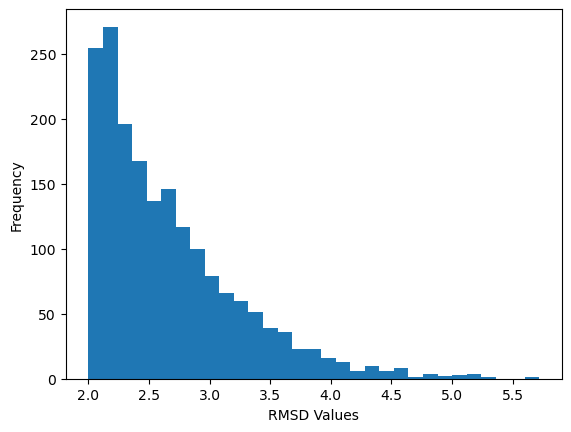

In [13]:
#Look at distribution of sidechain RMSD
#aa_list is a list w/ len = # pdbfiles --> RMSD_stored = list all RMSD

RMSD_dist_list = []
total_res = 0

for idx,pdbfile in enumerate(RMSD_stored):
    file_list = []
    total_res += len(pdbfile)
    print(idx)
    
    for residue in pdbfile:
        file_list.append(residue.tolist())
        
    RMSD_dist_list.append(file_list) 

#Treats each residue as a set
RMSD_dist_list = flatten_to_one_list(RMSD_dist_list)

assert len(RMSD_dist_list) == total_res

#Splits up into individual atoms & replaces 0 w/ nan
RMSD_dist_list_f = flatten_to_one_list(RMSD_dist_list)
RMSD_dist_list_f = np.array(RMSD_dist_list_f)
RMSD_dist_list_f[RMSD_dist_list_f == 0] = np.nan

import matplotlib.pyplot as plt

#Plotting all
n, bins, patches = plt.hist(x=RMSD_dist_list_f, bins = 'auto')
plt.xlabel('RMSD Values')
plt.ylabel('Frequency')
plt.savefig('Sidechain RMSD Distribution.png')

0
3WW6
1
2ZXJ
2
4LBH
3
2V9I
4
4GPF
5
1SMX
6
4KDY
7
7GLE
8
3GPX
9
7GCJ
10
3EG2
11
7GBN
12
3RGI
13
6MHN
14
5MUI
15
4LOX
16
4WO9
17
4LYU
18
5AUS
19
3PHS
20
5JFN
21
5DI8
22
4UVO
23
6DY8
24
5DEM
25
3W7J
26
5ZM4
27
1ERW
28
8BV4
29
4AHQ
30
2WS6
31
3A3X
32
3DZ8
33
1W7O
34
4HN9
35
2B1Z
36
1RJK
37
3FT1
38
6ULS
39
4QU1
40
3VPD
41
5ICW
42
3S78
43
1E38
44
4J9Y
45
3C1E
46
4MIO
47
7OND
48
3ORO
49
2GC1
50
4MIY
51
3MHC
52
8BBQ
53
3FY7
54
3MDW
55
1PRY
56
4J6W
57
5I5Q
58
3HYY
59
6NXW
60
3D8Z
61
3THV
62
5P9G
63
8P3L
64
5U22
65
3FCX
66
1Y88
67
4JTB
68
6W7P
69
4Q7S
70
7Z7B
71
1GK7
72
4F9U
73
1W9E
74
2OV9
75
1A3K
76
1F73
77
6VDL
78
5M9A
79
6MS3
80
4KRU
81
1F5Z
82
4P12
83
1H97
84
6JTP
85
3KSX
86
3KS9
87
6MRV
88
1SVD
89
4BVC
90
2JEJ
91
3UW5
92
3KIV
93
3KJM
94
7GB9
95
7GBO
96
2QFF
97
1SC3
98
6MKT
99
5X8J
100
7GCK
101
6ZDA
102
3GS4
103
6VSE
104
3NXY
105
3UN5
106
6HY6
107
6T05
108
7GBM
109
2V7V
110
6QYB
111
5CY0
112
1QN4
113
3LXL
114
7K6X
115
8FAL
116
1ZSC
117
2CCA
118
1SZ3
119
5TBV
120
5D03
121
1AFB
122
3P2T
123

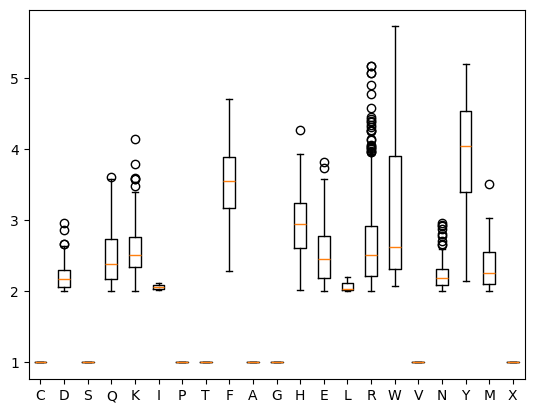

In [14]:
"""
Create dictionary --> for each residue store the RMSD values
Create histogram for each residue?
or boxplot w/ all residues

iterate through RMSD one by one then find 
"""
keys = letter_to_num.keys()
aa_dist_dict = {}

for key in keys:
    aa_dist_dict[key] = []
    

for f_idx,stored_file in enumerate(RMSD_stored): #for each file
    #print("file number:")
    print(f_idx)
    print(pdb_list[f_idx])
    for r_idx, res_RMSD in enumerate(stored_file): #for each residue
        #print(r_idx)
        #print(res_RMSD)
        for element in res_RMSD:                             #for each altloc
            if element != 0 and np.isnan(element) == False:  #store RMSD value
                #print(element)
                #print(aa_list[f_idx][r_idx])
                temp_key = aa_list[f_idx][r_idx]
                if temp_key == 'A' and element > 1:
                    print('A residue')
                    print(pdb_list[f_idx])
                    print(r_idx)
                    print(element)
                aa_dist_dict[temp_key].append(element)

#print(aa_dist_dict)

#Combining all aa datasets into one list
data = []
for key in keys:
    if len(aa_dist_dict[key]) == 0:
        data.append([1,1,1])
    else:
        data.append(aa_dist_dict[key])

#print(data)
#for each aa, print histogram? 
plt.boxplot(data,labels = keys)
plt.savefig('Sidechain RMSD Boxplot.png')

1450
1450


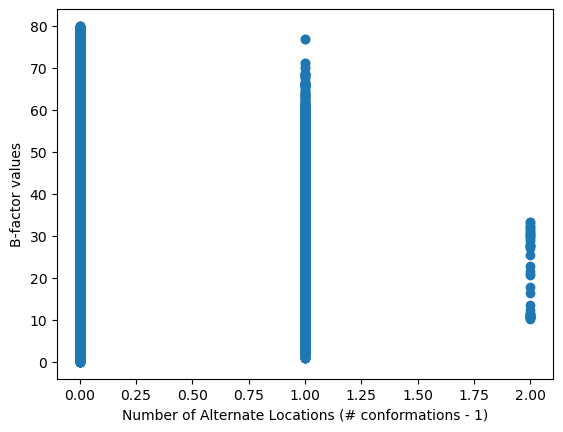

In [15]:
#Generate Scatterplot + save
print(len(num_altloc_all))
print(len(b_factor_all))
plt.scatter(num_altloc, b_factor)
plt.xlabel("Number of Alternate Locations (# conformations - 1)")
plt.ylabel("B-factor values")
plt.savefig('scatterplot.png')

In [16]:
#Correlation calculation --> CHECK IF THE CODE WORKS
from scipy.stats import f_oneway

##prepping data --> 6 different arrays
zero = []
one = []
two = []
#three = []
#four = []
#five = []

data = {'0.0': zero, '1.0': one, '2.0': two} #, '3.0': three, '4.0': four} #, '5.0': five}

#iterate through num_altloc
for idx, num in enumerate(num_altloc):
    data[str(num)].append(b_factor[idx])    #adding the corresponding b-factor

#correlation calc
correlation = f_oneway(zero,one,two)#,three,four)#,five)
print(correlation) 

F_onewayResult(statistic=219.59065015831425, pvalue=4.374548894005164e-96)


In [17]:
# ** Avg conformations per structure ** --> (sum of all alt locations/num structures)
## Sum of alt locations
## Includes unknown AA ('X')
total_altloc = 0
num_res_with_altloc = 0

for sublist in res_altloc:
    total_altloc += sum(sublist)  # Count all alt loc
    for num in sublist:           # Count number of residues w/ alt loc
        if num == 0:
            continue
        num_res_with_altloc += 1

total_altloc += num_res_with_altloc #To get total num conformations (altloc + 1 for all res)

avg_conf_per_struc = total_altloc/included_files
avg_altloc = total_altloc/num_res_with_altloc
avg_res = num_res_with_altloc/included_files

print("average number of conformations per structure:" + str("%.2f" % round(avg_conf_per_struc, 2)))
print("average number of conformations (only residues with alt locations):" + str("%.2f" % round(avg_altloc, 2)))
print("average number of residues with different conformations:" + str("%.2f" % round(avg_res, 2)))

#Number of files included
print("Total number of files processed: " + str(file))
print("Number of files with different conformations: " + str(included_files))

#Flatten list of lists into one large list
res_altloc_l = flatten_to_one_list(res_altloc)
aa_list_l = flatten_to_one_list(aa_list)
assert len(res_altloc_l) == len(aa_list_l)

#Calculate avg # conformations per AA type --> # conf = # altloc + 1
# Make 2 dictionaries: one w/ AA count, other w/ total 
## for each AA in seq
###   if num altloc != 0 --> find AA in dictionary and add to num stored
###sum all altloc/total num res 

#Counts freq of each AA w/ altloc
aa_res_count = {'C': 0, 'D': 0, 'S': 0, 'Q': 0, 'K': 0, 'I': 0,
                       'P': 0, 'T': 0, 'F': 0, 'A': 0, 'G': 0, 'H': 0,
                       'E': 0, 'L': 0, 'R': 0, 'W': 0, 'V': 0,
                       'N': 0, 'Y': 0, 'M': 0, 'X': 0}
aa_altloc_count = aa_res_count.copy()    #Sum of all conformations
all_aa = aa_res_count.copy()             #Counts freq of each AA
avg_per_res = aa_res_count.copy()        #avg # conf among res w/ altloc
avg_per_res_all = aa_res_count.copy()    #avg # conf overall
proportion = aa_res_count.copy()         #for each AA (%res w/ altloc / all residues)

for idx,res in enumerate(res_altloc_l):
    #Get aa and add to count of all res
    aa = aa_list_l[idx]
    all_aa[aa] += 1 
    
    #print(res)
    if res == 0:
        continue
        
    #add to count and altloc
    aa_res_count[aa] += 1 
    aa_altloc_count[aa] += res+1  #Add 1 to get num of conformations
    
    if aa == "G":
        print("G")
        print(idx)
    if aa == "A":
        print("A")
        print(idx)

#print(aa_res_count)
#print(aa_altloc_count)
#print(all_aa)

for key in avg_per_res.keys():
    total_num_altloc = aa_altloc_count[key]
    count_res = aa_res_count[key]
    total_res = all_aa[key]
    
    if count_res == 0:
        continue
        
    avg_per_res_all[key] = (total_num_altloc+total_res)/total_res
    avg_per_res[key] = total_num_altloc/count_res
    proportion[key] = (count_res/total_res)*100

#print(avg_per_res)
#print(proportion)

average number of conformations per structure:2.55
average number of conformations (only residues with alt locations):2.00
average number of residues with different conformations:1.27
Total number of files processed: 80325
Number of files with different conformations: 1450
G
261884
G
289977
G
354396
G
408421
G
408422
G
438536


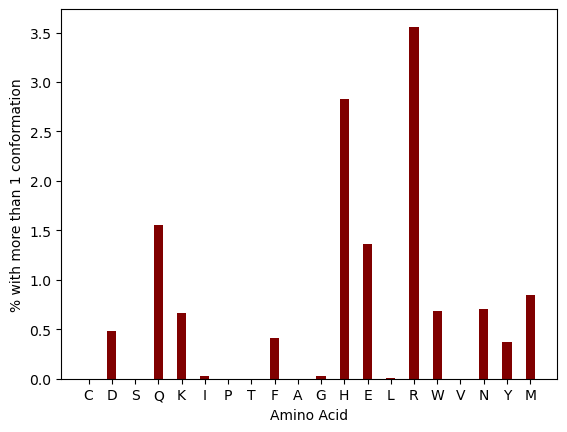

In [18]:
#Plotting as Bar Graphs
proportion.pop('X')
amino_acids = list(proportion.keys())
values = list(proportion.values())

plt.bar(amino_acids, values, color='maroon', width = 0.4)
plt.xlabel("Amino Acid")
plt.ylabel("% with more than 1 conformation")
plt.savefig('Frequency_of_all_aa.png')

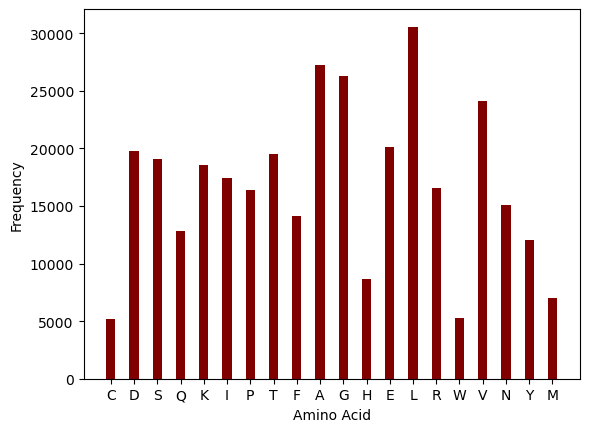

In [19]:
#Freq Overall
all_aa.pop('X')
amino_acids = list(all_aa.keys())
values = list(all_aa.values())

plt.bar(amino_acids, values, color='maroon', width = 0.4)
plt.xlabel("Amino Acid")
plt.ylabel("Frequency")
plt.savefig('All_AA.png')

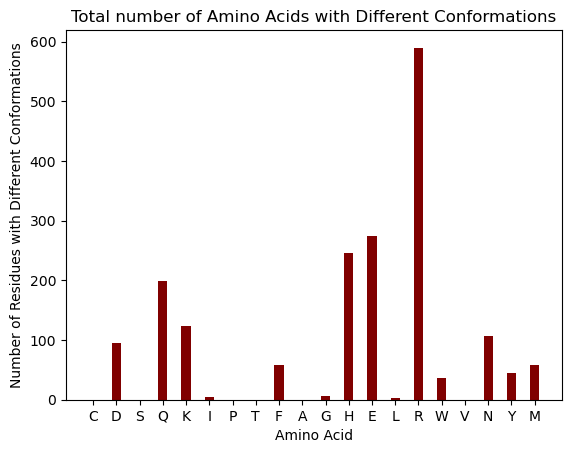

In [20]:
#with diff conformations
aa_res_count.pop('X')
values = list(aa_res_count.values())
plt.bar(amino_acids, values, color='maroon', width = 0.4)
plt.xlabel("Amino Acid")
plt.ylabel("Number of Residues with Different Conformations")
plt.title("Total number of Amino Acids with Different Conformations")
plt.savefig('Frequency_of_aa_with_altloc.png')


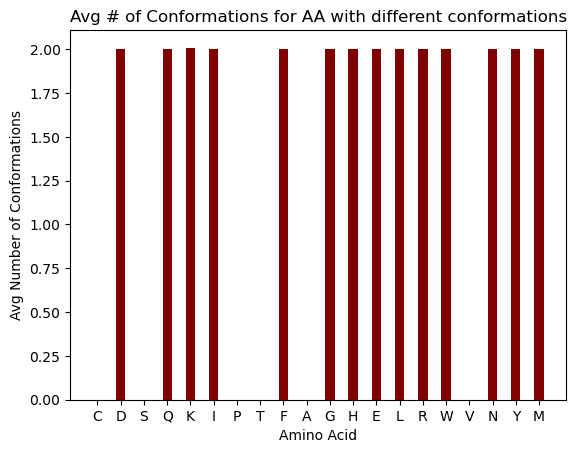

In [21]:
#Avg num conformations
avg_per_res.pop('X')
values = list(avg_per_res.values())
plt.bar(amino_acids, values, color='maroon', width = 0.4)
plt.xlabel("Amino Acid")
plt.ylabel("Avg Number of Conformations")
plt.title("Avg # of Conformations for AA with different conformations")
plt.savefig('Avg_num_conformations_by_aa_altloc.png')

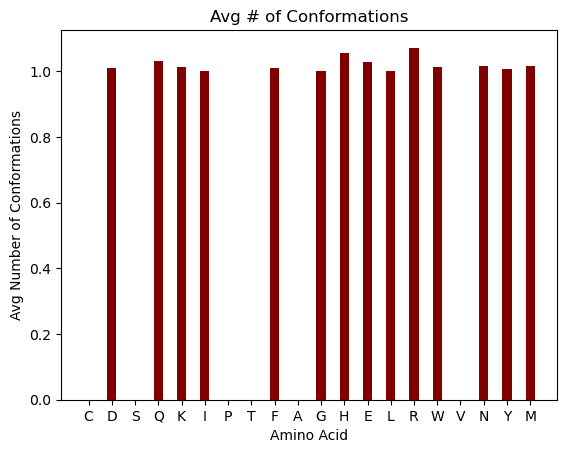

In [22]:
#Avg num conformations -- all residues included
avg_per_res_all.pop('X')
values = list(avg_per_res_all.values())
plt.bar(amino_acids, values, color='maroon', width = 0.4)
plt.xlabel("Amino Acid")
plt.ylabel("Avg Number of Conformations")
plt.title("Avg # of Conformations")
plt.savefig('Avg_num_conformations_by_aa.png')

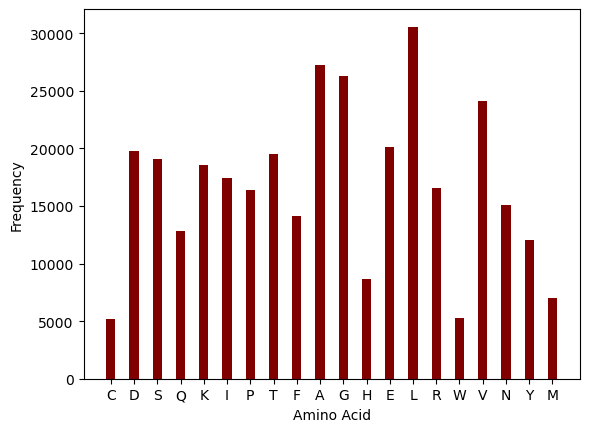

In [23]:
#Freq Overall w/o x
temp = all_aa.copy()
#temp.pop('X')
amino_acids = list(temp.keys())
values = list(temp.values())

plt.bar(amino_acids, values, color='maroon', width = 0.4)
plt.xlabel("Amino Acid")
plt.ylabel("Frequency")
plt.savefig('All_AA_without_X.png')

In [24]:
#create a dictionary with values
all_data = {'ID':pdb_list, 
            'avg_conf_per_struc': avg_conf_per_struc,
            'avg_conf': avg_altloc,                     #only res w/ altloc
            'avg_per_res': avg_per_res,
            'only_res_w_altloc': aa_res_count,
            'all_res_count':all_aa,
            'b_factor_all': b_factor, 
            'num_altloc_all': num_altloc,
            'correlation': correlation,
            'num_files': included_files,
            'total_processed': file
           }

In [ ]:
#save as npy file in separate folder
file_name = "data_analysis_v1.pkl"
file_path = Path("/Users/christinali/Documents/Rotations/Kim Lab/data-processing")/ file_name
    
#serialize dictionary to a pickle file
with open(file_path,"wb") as f:
    pickle.dump(all_data,f)
        
f.close()

In [ ]:
#Flattening into one list
#b_factor_flat = []
#for sublist in b_factor:
    #for item in sublist:
        #if item == 0:
            #item = np.nan
        #b_factor_flat.append(item)

#num_altloc_flat = []
#for sublist in num_altloc:
    #for item in sublist:
        #num_altloc_flat.append(item)
        
#import csv

#with open('data_analysis.csv', 'w', newline='') as csvfile:
    #fieldnames = all_data.keys()
    #writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    #writer.writeheader()
    #writer.writerow(all_data)

#csvfile.close()